In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

#os.chdir("/content/gdrive/My Drive/") 
#!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!unzip "/content/gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip" -d "/content/gdrive/My Drive"

In [0]:
data_dir = '/content/gdrive/My Drive/A_05_Part_02_Dataset/'

In [6]:
# Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + 'Train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + 'Validation', transform = valid_transforms)
test_data = datasets.ImageFolder(data_dir + 'Test', transform = test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 62, shuffle = True, drop_last = False)  # 62, 100?
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 4, shuffle = True, drop_last = False)   # 4, 157?
testloader = torch.utils.data.DataLoader(test_data, batch_size = 37, shuffle = False, drop_last = False)   # 37?


print("Classes in Train Data: ")
class_names = train_data.classes
print(class_names)

print("\nClasses in Validation Data: ")
class_names1 = valid_data.classes
print(class_names1)

Classes in Train Data: 
['covid-19', 'normal', 'pneumonia']

Classes in Validation Data: 
['covid', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


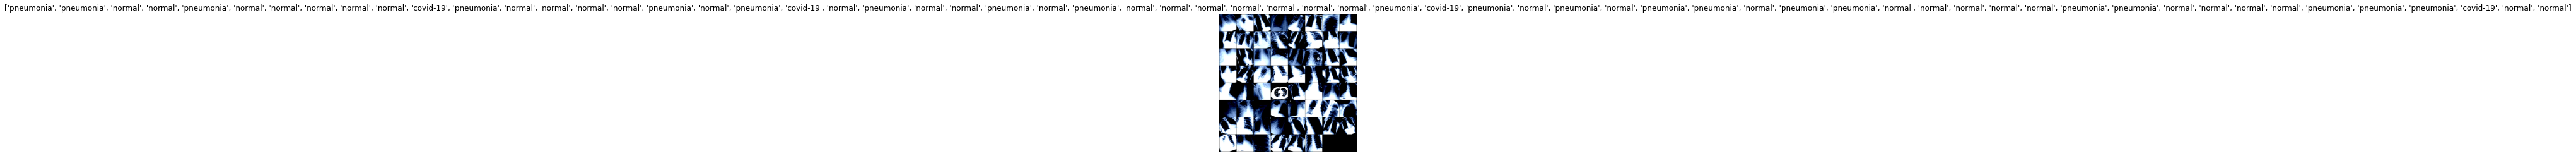

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader)) # check for valid too? - Done.
show_databatch(inputs, classes)

## Tasks 1 and 2 

In [11]:
# Load the pretrained models from pytorch

vgg16 = models.vgg16(pretrained = True)

resnet18 = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Implementation of Focal Loss:-

class FocalLoss(nn.Module):
    
    def __init__(self, gamma = 2, alpha = 0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        
        
    def forward(self, inputvals, targetvals):
        
        ptlog = nn.functional.binary_cross_entropy_with_logits(inputvals, targetvals, reduction = 'none')
        pt = torch.exp(-ptlog)
        fl =  self.alpha * ((1 - pt) ** self.gamma) * ptlog
        
        return torch.mean(fl)           #fl.mean() not working - try torch version? - Done.

In [0]:
# One-Hot Encoding:

def onehotencoder(batchsizecheck, labels):
  
  localfunclabels = labels.detach().cpu().numpy()

  if(batchsizecheck == 1):
    onehotlabels = np.zeros((62, 3))

  if(batchsizecheck == 2):
    onehotlabels = np.zeros((4, 3))

  onehotlabels[np.arange(localfunclabels.size), localfunclabels] = 1
  onehotlabels[onehotlabels[:, 0] == 1] = [1, 0, 1]

  onehotlabels = torch.Tensor(onehotlabels).to(device)         # Add torch.Tensor()? - Done

  return onehotlabels

### A) VGG16

In [22]:
# Freezing the layers:

def freezevgg16(layernum): # works for 2, extend for more? - Done.            
    if layernum != 1:
        i = 0
        for param in vgg16.features.parameters():
            i = i + 1
        layersizeuf = i - layernum 

        j = 0
        for param in vgg16.features.parameters():
            if layersizeuf > j:
                param.require_grad = False                        
            j = j + 1
            
    if layernum == 1:
        for param in vgg16.features.parameters():
            param.require_grad = False
        
Epochs = int(input("\nEnter number of epochs: ")) #10

learningrate = float(input("\nEnter learning rate: ")) #0.001

lossfunc = int(input("\nChoose the Loss Function that you want to utilize - '1' for BCEWithLogitsLoss or '2' for Focal Loss: "))  

if (lossfunc == 1):
  criterion = nn.BCEWithLogitsLoss()
elif (lossfunc == 2):
  criterion = FocalLoss()
else:
  criterion = nn.CrossEntropyLoss()


freezeask = input("\nDo you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: ")  

if (freezeask == "Yes"):
  layernum = int(input("\nEnter number of layers to freeze (1 to freeze all layers, other than 1 for exception of freezing layers): "))
  freezevgg16(layernum)
else:
  pass

num_features = vgg16.classifier[0].in_features

features = []

features.extend([nn.Linear(num_features, 340)])       # (34 * 10) + 100
features.extend([nn.Linear(340, len(class_names))])   # (34 * 10) + 100

vgg16.classifier = nn.Sequential(*features)

#optimizer = optim.SGD(vgg16.parameters(), lr = learningrate, momentum = 0.9)
optimizer = optim.Adam(vgg16.parameters(), lr = learningrate)


Enter number of epochs: 5

Enter learning rate: 0.0001

Choose the Loss Function that you want to utilize - '1' for BCEWithLogitsLoss or '2' for Focal Loss: 2

Do you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: No


### VGG16 - Training

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

correct = 0
total = 0

accuracies = []

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    vgg16.train()

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #print("\nFor Checking: ", labels)

        # One-Hot Encoding of Labels:

        #ohelabels = nn.functional.one_hot(labels, num_classes = 3)
        #newlabels = ohelabels.detach().cpu().numpy()

        batchsizecheck = 1

        ohelabels = onehotencoder(batchsizecheck, labels)
        print("\nNormal Label: ", labels, "\nOne Hot Label: ", ohelabels)     #For Checking? - Done.

        optimizer.zero_grad()

        outputs = vgg16(inputs)                        #----> forward pass
        _, predicted = torch.max(outputs.data, 1)

        loss = criterion(outputs, ohelabels)           #----> compute loss

        loss.backward()                                #----> backward pass
        optimizer.step()                               #----> weights update

        running_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies.append(tempaccuracy)
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    errors.append(running_loss)

    if(lossfunc == 1):
        modelpath = "/content/gdrive/My Drive/vgg16_wo_focal_loss.pth" 
        torch.save(vgg16.state_dict(), modelpath)
    elif(lossfunc == 2):  
        modelpath = "/content/gdrive/My Drive/vgg16_focal_loss.pth" 
        torch.save(vgg16.state_dict(), modelpath)
    else:
        modelpath = "/content/gdrive/My Drive/vgg16_cross_entropy.pth" 
        torch.save(vgg16.state_dict(), modelpath)

print('\nFinal Accuracy of the network on the Train Images: %d %%' % (
    100 * correct / total))

# Confusion matrix

finalcm = multilabel_confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy())
print('\nConfusion Matrix of the network on the test images: \n', finalcm)

# F1 Score

finalfs = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average = 'micro')
print('\nF1 Score of the network on the test images: \n', finalfs)  

print('\nFinished Training!')

0it [00:00, ?it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.042875: : 1it [00:02,  2.29s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [62/6200 (1%)]	Loss: 0.032877: : 2it [00:04,  2.28s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [124/6200 (2%)]	Loss: 0.023887: : 3it [00:06,  2.31s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [186/6200 (3%)]	Loss: 0.024574: : 4it [00:09,  2.32s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [248/6200 (4%)]	Loss: 0.011530: : 5it [00:11,  2.31s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [310/6200 (5%)]	Loss: 0.018167: : 6it [00:13,  2.31s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [372/6200 (6%)]	Loss: 0.022288: : 7it [00:16,  2.30s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [434/6200 (7%)]	Loss: 0.019289: : 8it [00:18,  2.33s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1,
        0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [496/6200 (8%)]	Loss: 0.031090: : 9it [00:20,  2.36s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [558/6200 (9%)]	Loss: 0.013148: : 10it [00:23,  2.35s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        1, 2, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [620/6200 (10%)]	Loss: 0.021786: : 11it [00:26,  2.48s/it]


Normal Label:  tensor([1, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [682/6200 (11%)]	Loss: 0.017560: : 12it [00:28,  2.53s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [744/6200 (12%)]	Loss: 0.012985: : 13it [00:31,  2.46s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1,
        2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1,
        1, 1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [806/6200 (13%)]	Loss: 0.016962: : 14it [00:33,  2.51s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1,
        2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 

Train Epoch: 0 [868/6200 (14%)]	Loss: 0.027257: : 15it [00:36,  2.53s/it]


Normal Label:  tensor([1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [930/6200 (15%)]	Loss: 0.019497: : 16it [00:38,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2,
        1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [992/6200 (16%)]	Loss: 0.016060: : 17it [00:41,  2.56s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 

Train Epoch: 0 [1054/6200 (17%)]	Loss: 0.018991: : 18it [00:43,  2.52s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1116/6200 (18%)]	Loss: 0.016290: : 19it [00:46,  2.50s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
        1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1178/6200 (19%)]	Loss: 0.015490: : 20it [00:48,  2.45s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1240/6200 (20%)]	Loss: 0.014236: : 21it [00:50,  2.45s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1302/6200 (21%)]	Loss: 0.009400: : 22it [00:53,  2.51s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2,
        2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1364/6200 (22%)]	Loss: 0.016430: : 23it [00:56,  2.48s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2,
        2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1426/6200 (23%)]	Loss: 0.011711: : 24it [00:58,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1488/6200 (24%)]	Loss: 0.009538: : 25it [01:00,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1,
        1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1550/6200 (25%)]	Loss: 0.017412: : 26it [01:03,  2.41s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1,
        1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 0 [1612/6200 (26%)]	Loss: 0.008491: : 27it [01:05,  2.39s/it]


Normal Label:  tensor([1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2,
        2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1674/6200 (27%)]	Loss: 0.013331: : 28it [01:07,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1736/6200 (28%)]	Loss: 0.016218: : 29it [01:10,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1798/6200 (29%)]	Loss: 0.016835: : 30it [01:12,  2.34s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2,
        1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [1860/6200 (30%)]	Loss: 0.015159: : 31it [01:14,  2.33s/it]


Normal Label:  tensor([1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1922/6200 (31%)]	Loss: 0.015713: : 32it [01:17,  2.39s/it]


Normal Label:  tensor([2, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0,
        2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.022237: : 33it [01:20,  2.54s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2046/6200 (33%)]	Loss: 0.011085: : 34it [01:22,  2.53s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0,
        1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2108/6200 (34%)]	Loss: 0.021957: : 35it [01:25,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,
        0, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2170/6200 (35%)]	Loss: 0.011381: : 36it [01:27,  2.42s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2232/6200 (36%)]	Loss: 0.016158: : 37it [01:29,  2.40s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 

Train Epoch: 0 [2294/6200 (37%)]	Loss: 0.017035: : 38it [01:32,  2.50s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1,
        1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2356/6200 (38%)]	Loss: 0.011525: : 39it [01:34,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2,
        2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2418/6200 (39%)]	Loss: 0.014761: : 40it [01:37,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2480/6200 (40%)]	Loss: 0.014219: : 41it [01:39,  2.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1,
        1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2542/6200 (41%)]	Loss: 0.020677: : 42it [01:42,  2.47s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2604/6200 (42%)]	Loss: 0.012822: : 43it [01:44,  2.42s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2,
        1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2666/6200 (43%)]	Loss: 0.016594: : 44it [01:46,  2.40s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2728/6200 (44%)]	Loss: 0.009250: : 45it [01:49,  2.38s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2790/6200 (45%)]	Loss: 0.012419: : 46it [01:51,  2.36s/it]


Normal Label:  tensor([1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2852/6200 (46%)]	Loss: 0.010995: : 47it [01:54,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [2914/6200 (47%)]	Loss: 0.015131: : 48it [01:56,  2.42s/it]


Normal Label:  tensor([1, 0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1,
        1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2,
        1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [2976/6200 (48%)]	Loss: 0.014596: : 49it [01:59,  2.54s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [3038/6200 (49%)]	Loss: 0.009047: : 50it [02:01,  2.47s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3100/6200 (50%)]	Loss: 0.009318: : 51it [02:03,  2.43s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3162/6200 (51%)]	Loss: 0.011652: : 52it [02:06,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1,
        0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3224/6200 (52%)]	Loss: 0.006901: : 53it [02:08,  2.38s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3286/6200 (53%)]	Loss: 0.012875: : 54it [02:10,  2.37s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3348/6200 (54%)]	Loss: 0.018125: : 55it [02:13,  2.38s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3410/6200 (55%)]	Loss: 0.010931: : 56it [02:15,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3472/6200 (56%)]	Loss: 0.012212: : 57it [02:18,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3534/6200 (57%)]	Loss: 0.014680: : 58it [02:20,  2.39s/it]


Normal Label:  tensor([1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0,
        2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
        0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [3596/6200 (58%)]	Loss: 0.022234: : 59it [02:22,  2.39s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3658/6200 (59%)]	Loss: 0.012859: : 60it [02:25,  2.37s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3720/6200 (60%)]	Loss: 0.008668: : 61it [02:27,  2.35s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [3782/6200 (61%)]	Loss: 0.011368: : 62it [02:29,  2.34s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2,
        0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3844/6200 (62%)]	Loss: 0.019240: : 63it [02:32,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2,
        2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3906/6200 (63%)]	Loss: 0.015751: : 64it [02:35,  2.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.015277: : 65it [02:37,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2,
        2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [4030/6200 (65%)]	Loss: 0.013985: : 66it [02:39,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2,
        1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [4092/6200 (66%)]	Loss: 0.015128: : 67it [02:42,  2.50s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
        1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1,
        2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4154/6200 (67%)]	Loss: 0.015023: : 68it [02:44,  2.44s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [4216/6200 (68%)]	Loss: 0.010348: : 69it [02:47,  2.40s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
        1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
        2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4278/6200 (69%)]	Loss: 0.014744: : 70it [02:49,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4340/6200 (70%)]	Loss: 0.016873: : 71it [02:51,  2.43s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4402/6200 (71%)]	Loss: 0.012504: : 72it [02:54,  2.40s/it]


Normal Label:  tensor([2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1,
        1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4464/6200 (72%)]	Loss: 0.017394: : 73it [02:56,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
        2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4526/6200 (73%)]	Loss: 0.015466: : 74it [02:59,  2.38s/it]


Normal Label:  tensor([0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 1, 1, 0,
        2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4588/6200 (74%)]	Loss: 0.016349: : 75it [03:01,  2.34s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4650/6200 (75%)]	Loss: 0.012121: : 76it [03:03,  2.33s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4712/6200 (76%)]	Loss: 0.011950: : 77it [03:06,  2.36s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4774/6200 (77%)]	Loss: 0.012515: : 78it [03:08,  2.37s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4836/6200 (78%)]	Loss: 0.009214: : 79it [03:10,  2.35s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0,
        2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [4898/6200 (79%)]	Loss: 0.014543: : 80it [03:13,  2.37s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1,
        2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [4960/6200 (80%)]	Loss: 0.008999: : 81it [03:15,  2.35s/it]


Normal Label:  tensor([0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
        2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
        1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5022/6200 (81%)]	Loss: 0.011626: : 82it [03:17,  2.36s/it]


Normal Label:  tensor([1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 0 [5084/6200 (82%)]	Loss: 0.014061: : 83it [03:20,  2.36s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5146/6200 (83%)]	Loss: 0.005674: : 84it [03:22,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
        2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0,
        2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 

Train Epoch: 0 [5208/6200 (84%)]	Loss: 0.011621: : 85it [03:25,  2.39s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5270/6200 (85%)]	Loss: 0.012630: : 86it [03:27,  2.38s/it]


Normal Label:  tensor([1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5332/6200 (86%)]	Loss: 0.004460: : 87it [03:29,  2.41s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1,
        1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5394/6200 (87%)]	Loss: 0.008820: : 88it [03:32,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2,
        2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5456/6200 (88%)]	Loss: 0.015980: : 89it [03:34,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5518/6200 (89%)]	Loss: 0.011057: : 90it [03:36,  2.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5580/6200 (90%)]	Loss: 0.013837: : 91it [03:39,  2.35s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1,
        2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5642/6200 (91%)]	Loss: 0.018691: : 92it [03:41,  2.34s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2,
        1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1,
        1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5704/6200 (92%)]	Loss: 0.017530: : 93it [03:43,  2.37s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2,
        1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5766/6200 (93%)]	Loss: 0.007937: : 94it [03:46,  2.38s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
        0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [5828/6200 (94%)]	Loss: 0.010090: : 95it [03:48,  2.37s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1,
        2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5890/6200 (95%)]	Loss: 0.018385: : 96it [03:50,  2.37s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.010439: : 97it [03:53,  2.35s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [6014/6200 (97%)]	Loss: 0.015328: : 98it [03:55,  2.34s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 0 [6076/6200 (98%)]	Loss: 0.008631: : 99it [03:57,  2.33s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 0 [6138/6200 (99%)]	Loss: 0.010449: : 100it [04:00,  2.40s/it]
0it [00:00, ?it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2,
        1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [0/6200 (0%)]	Loss: 0.020409: : 1it [00:02,  2.40s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1,
        1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [62/6200 (1%)]	Loss: 0.011421: : 2it [00:04,  2.41s/it]


Normal Label:  tensor([1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2,
        1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [124/6200 (2%)]	Loss: 0.011273: : 3it [00:07,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [186/6200 (3%)]	Loss: 0.013342: : 4it [00:09,  2.37s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [248/6200 (4%)]	Loss: 0.018656: : 5it [00:12,  2.63s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2,
        1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [310/6200 (5%)]	Loss: 0.011757: : 6it [00:15,  2.52s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [372/6200 (6%)]	Loss: 0.015828: : 7it [00:17,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [434/6200 (7%)]	Loss: 0.014203: : 8it [00:19,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 2, 1,
        1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [496/6200 (8%)]	Loss: 0.014281: : 9it [00:22,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [558/6200 (9%)]	Loss: 0.010161: : 10it [00:24,  2.39s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [620/6200 (10%)]	Loss: 0.013144: : 11it [00:26,  2.42s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [682/6200 (11%)]	Loss: 0.019224: : 12it [00:29,  2.40s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [744/6200 (12%)]	Loss: 0.011253: : 13it [00:31,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [806/6200 (13%)]	Loss: 0.013864: : 14it [00:33,  2.39s/it]


Normal Label:  tensor([1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [868/6200 (14%)]	Loss: 0.029555: : 15it [00:36,  2.46s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [930/6200 (15%)]	Loss: 0.009192: : 16it [00:38,  2.41s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [992/6200 (16%)]	Loss: 0.016131: : 17it [00:41,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
        2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1054/6200 (17%)]	Loss: 0.008250: : 18it [00:43,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2,
        1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1116/6200 (18%)]	Loss: 0.011580: : 19it [00:45,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
        0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1178/6200 (19%)]	Loss: 0.015741: : 20it [00:48,  2.35s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
        2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1240/6200 (20%)]	Loss: 0.010095: : 21it [00:50,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1302/6200 (21%)]	Loss: 0.013350: : 22it [00:53,  2.37s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1364/6200 (22%)]	Loss: 0.011178: : 23it [00:55,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1426/6200 (23%)]	Loss: 0.010191: : 24it [00:57,  2.37s/it]


Normal Label:  tensor([0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1488/6200 (24%)]	Loss: 0.021636: : 25it [01:00,  2.37s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1,
        2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1550/6200 (25%)]	Loss: 0.010836: : 26it [01:02,  2.48s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1612/6200 (26%)]	Loss: 0.016889: : 27it [01:05,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1674/6200 (27%)]	Loss: 0.017353: : 28it [01:07,  2.52s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1736/6200 (28%)]	Loss: 0.010930: : 29it [01:10,  2.45s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1798/6200 (29%)]	Loss: 0.012501: : 30it [01:12,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1,
        1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2,
        1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1860/6200 (30%)]	Loss: 0.007641: : 31it [01:14,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
        1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1,
        1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [1922/6200 (31%)]	Loss: 0.013429: : 32it [01:17,  2.47s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2,
        2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.007999: : 33it [01:19,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 2,
        2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2046/6200 (33%)]	Loss: 0.013058: : 34it [01:22,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1,
        2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2108/6200 (34%)]	Loss: 0.019101: : 35it [01:24,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1,
        2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 1 [2170/6200 (35%)]	Loss: 0.013325: : 36it [01:27,  2.40s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
        2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
        2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2232/6200 (36%)]	Loss: 0.017854: : 37it [01:29,  2.40s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2294/6200 (37%)]	Loss: 0.013178: : 38it [01:31,  2.43s/it]


Normal Label:  tensor([2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2356/6200 (38%)]	Loss: 0.012304: : 39it [01:34,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
        1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2418/6200 (39%)]	Loss: 0.011633: : 40it [01:36,  2.48s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2480/6200 (40%)]	Loss: 0.012374: : 41it [01:39,  2.43s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1,
        2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2542/6200 (41%)]	Loss: 0.018659: : 42it [01:41,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0,
        1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2604/6200 (42%)]	Loss: 0.011991: : 43it [01:43,  2.39s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [2666/6200 (43%)]	Loss: 0.011429: : 44it [01:46,  2.36s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2728/6200 (44%)]	Loss: 0.009848: : 45it [01:48,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
        2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2790/6200 (45%)]	Loss: 0.012878: : 46it [01:50,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1,
        2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2852/6200 (46%)]	Loss: 0.013676: : 47it [01:53,  2.34s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1,
        2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2914/6200 (47%)]	Loss: 0.014377: : 48it [01:55,  2.33s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2,
        1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [2976/6200 (48%)]	Loss: 0.015192: : 49it [01:58,  2.51s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 

Train Epoch: 1 [3038/6200 (49%)]	Loss: 0.012340: : 50it [02:00,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2,
        1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [3100/6200 (50%)]	Loss: 0.009138: : 51it [02:03,  2.53s/it]


Normal Label:  tensor([1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3162/6200 (51%)]	Loss: 0.007833: : 52it [02:06,  2.50s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3224/6200 (52%)]	Loss: 0.012725: : 53it [02:08,  2.48s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3286/6200 (53%)]	Loss: 0.008974: : 54it [02:10,  2.43s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3348/6200 (54%)]	Loss: 0.011523: : 55it [02:13,  2.43s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3410/6200 (55%)]	Loss: 0.011843: : 56it [02:15,  2.45s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3472/6200 (56%)]	Loss: 0.013707: : 57it [02:18,  2.45s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [3534/6200 (57%)]	Loss: 0.025051: : 58it [02:21,  2.60s/it]


Normal Label:  tensor([2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3596/6200 (58%)]	Loss: 0.010188: : 59it [02:23,  2.54s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [3658/6200 (59%)]	Loss: 0.005953: : 60it [02:25,  2.51s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [3720/6200 (60%)]	Loss: 0.008006: : 61it [02:28,  2.45s/it]


Normal Label:  tensor([1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [3782/6200 (61%)]	Loss: 0.018211: : 62it [02:30,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0,
        0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3844/6200 (62%)]	Loss: 0.017810: : 63it [02:33,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1,
        2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3906/6200 (63%)]	Loss: 0.011552: : 64it [02:35,  2.49s/it]


Normal Label:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2,
        2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.011459: : 65it [02:38,  2.52s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 2,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4030/6200 (65%)]	Loss: 0.009896: : 66it [02:40,  2.44s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4092/6200 (66%)]	Loss: 0.015795: : 67it [02:43,  2.47s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4154/6200 (67%)]	Loss: 0.022553: : 68it [02:45,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4216/6200 (68%)]	Loss: 0.009208: : 69it [02:47,  2.41s/it]


Normal Label:  tensor([0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4278/6200 (69%)]	Loss: 0.014773: : 70it [02:50,  2.38s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4340/6200 (70%)]	Loss: 0.017780: : 71it [02:52,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1,
        2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4402/6200 (71%)]	Loss: 0.020150: : 72it [02:55,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2,
        2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        0, 2, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4464/6200 (72%)]	Loss: 0.017136: : 73it [02:57,  2.43s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1,
        2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4526/6200 (73%)]	Loss: 0.014349: : 74it [02:59,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
        0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4588/6200 (74%)]	Loss: 0.013751: : 75it [03:02,  2.37s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2,
        2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4650/6200 (75%)]	Loss: 0.011948: : 76it [03:04,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1,
        1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4712/6200 (76%)]	Loss: 0.014240: : 77it [03:06,  2.36s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1,
        1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2,
        1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4774/6200 (77%)]	Loss: 0.014448: : 78it [03:09,  2.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4836/6200 (78%)]	Loss: 0.010065: : 79it [03:11,  2.33s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2,
        2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [4898/6200 (79%)]	Loss: 0.013635: : 80it [03:13,  2.33s/it]


Normal Label:  tensor([1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [4960/6200 (80%)]	Loss: 0.015081: : 81it [03:16,  2.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [5022/6200 (81%)]	Loss: 0.010445: : 82it [03:18,  2.35s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5084/6200 (82%)]	Loss: 0.013108: : 83it [03:20,  2.34s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5146/6200 (83%)]	Loss: 0.014391: : 84it [03:23,  2.34s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2,
        1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
        0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5208/6200 (84%)]	Loss: 0.011763: : 85it [03:25,  2.36s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [5270/6200 (85%)]	Loss: 0.011342: : 86it [03:27,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5332/6200 (86%)]	Loss: 0.012061: : 87it [03:30,  2.35s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [5394/6200 (87%)]	Loss: 0.010238: : 88it [03:32,  2.33s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2,
        0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5456/6200 (88%)]	Loss: 0.007606: : 89it [03:34,  2.32s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5518/6200 (89%)]	Loss: 0.017283: : 90it [03:37,  2.35s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5580/6200 (90%)]	Loss: 0.009409: : 91it [03:39,  2.35s/it]


Normal Label:  tensor([2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [5642/6200 (91%)]	Loss: 0.011897: : 92it [03:41,  2.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1,
        2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5704/6200 (92%)]	Loss: 0.009707: : 93it [03:44,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 2,
        1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5766/6200 (93%)]	Loss: 0.012862: : 94it [03:46,  2.35s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5828/6200 (94%)]	Loss: 0.009341: : 95it [03:49,  2.34s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
        2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1,
        2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5890/6200 (95%)]	Loss: 0.021743: : 96it [03:51,  2.39s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
        2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.013749: : 97it [03:53,  2.36s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [6014/6200 (97%)]	Loss: 0.020650: : 98it [03:56,  2.39s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2,
        1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2,
        2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 1 [6076/6200 (98%)]	Loss: 0.017644: : 99it [03:58,  2.46s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 1 [6138/6200 (99%)]	Loss: 0.019674: : 100it [04:01,  2.41s/it]
0it [00:00, ?it/s]


Normal Label:  tensor([2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2,
        1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [0/6200 (0%)]	Loss: 0.015954: : 1it [00:02,  2.31s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [62/6200 (1%)]	Loss: 0.010110: : 2it [00:04,  2.30s/it]


Normal Label:  tensor([0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2,
        1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [124/6200 (2%)]	Loss: 0.014977: : 3it [00:06,  2.31s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 2 [186/6200 (3%)]	Loss: 0.012527: : 4it [00:09,  2.33s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 2 [248/6200 (4%)]	Loss: 0.014942: : 5it [00:12,  2.51s/it]


Normal Label:  tensor([0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [310/6200 (5%)]	Loss: 0.019322: : 6it [00:14,  2.48s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 2,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [372/6200 (6%)]	Loss: 0.016508: : 7it [00:17,  2.48s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2,
        1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [434/6200 (7%)]	Loss: 0.017181: : 8it [00:19,  2.45s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [496/6200 (8%)]	Loss: 0.012721: : 9it [00:21,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [558/6200 (9%)]	Loss: 0.013093: : 10it [00:24,  2.43s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
        2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [620/6200 (10%)]	Loss: 0.011747: : 11it [00:26,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2,
        1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [682/6200 (11%)]	Loss: 0.012028: : 12it [00:29,  2.46s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
        1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [744/6200 (12%)]	Loss: 0.015107: : 13it [00:31,  2.45s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [806/6200 (13%)]	Loss: 0.022401: : 14it [00:33,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [868/6200 (14%)]	Loss: 0.011372: : 15it [00:36,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2,
        2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 2 [930/6200 (15%)]	Loss: 0.012374: : 16it [00:39,  2.48s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
        2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [992/6200 (16%)]	Loss: 0.009800: : 17it [00:41,  2.47s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2,
        2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1054/6200 (17%)]	Loss: 0.008859: : 18it [00:43,  2.47s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1116/6200 (18%)]	Loss: 0.011846: : 19it [00:46,  2.44s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1178/6200 (19%)]	Loss: 0.009860: : 20it [00:48,  2.40s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1240/6200 (20%)]	Loss: 0.004967: : 21it [00:50,  2.37s/it]


Normal Label:  tensor([2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1302/6200 (21%)]	Loss: 0.012348: : 22it [00:53,  2.36s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [1364/6200 (22%)]	Loss: 0.015615: : 23it [00:55,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1426/6200 (23%)]	Loss: 0.014186: : 24it [00:57,  2.33s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2,
        1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1488/6200 (24%)]	Loss: 0.014136: : 25it [01:00,  2.32s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1550/6200 (25%)]	Loss: 0.009385: : 26it [01:02,  2.33s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1,
        2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1612/6200 (26%)]	Loss: 0.014193: : 27it [01:04,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [1674/6200 (27%)]	Loss: 0.009687: : 28it [01:07,  2.36s/it]


Normal Label:  tensor([1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1736/6200 (28%)]	Loss: 0.010563: : 29it [01:09,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [1798/6200 (29%)]	Loss: 0.007705: : 30it [01:11,  2.34s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2,
        1, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2,
        1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1860/6200 (30%)]	Loss: 0.009914: : 31it [01:14,  2.32s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [1922/6200 (31%)]	Loss: 0.016294: : 32it [01:16,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
        2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [1984/6200 (32%)]	Loss: 0.010064: : 33it [01:19,  2.39s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2046/6200 (33%)]	Loss: 0.010456: : 34it [01:21,  2.39s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2108/6200 (34%)]	Loss: 0.008050: : 35it [01:23,  2.37s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2170/6200 (35%)]	Loss: 0.008269: : 36it [01:26,  2.36s/it]


Normal Label:  tensor([1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2232/6200 (36%)]	Loss: 0.014248: : 37it [01:28,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [2294/6200 (37%)]	Loss: 0.008054: : 38it [01:31,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        1, 2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2356/6200 (38%)]	Loss: 0.006381: : 39it [01:33,  2.51s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2418/6200 (39%)]	Loss: 0.007589: : 40it [01:36,  2.50s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 2,
        2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2480/6200 (40%)]	Loss: 0.006826: : 41it [01:38,  2.47s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [2542/6200 (41%)]	Loss: 0.008646: : 42it [01:41,  2.51s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [2604/6200 (42%)]	Loss: 0.017220: : 43it [01:43,  2.45s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2666/6200 (43%)]	Loss: 0.013611: : 44it [01:46,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
        1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2728/6200 (44%)]	Loss: 0.006720: : 45it [01:48,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2790/6200 (45%)]	Loss: 0.008247: : 46it [01:50,  2.38s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2852/6200 (46%)]	Loss: 0.018608: : 47it [01:53,  2.36s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2914/6200 (47%)]	Loss: 0.010959: : 48it [01:55,  2.34s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2,
        2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [2976/6200 (48%)]	Loss: 0.010743: : 49it [01:58,  2.54s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3038/6200 (49%)]	Loss: 0.014589: : 50it [02:00,  2.49s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3100/6200 (50%)]	Loss: 0.014073: : 51it [02:03,  2.53s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3162/6200 (51%)]	Loss: 0.008460: : 52it [02:05,  2.48s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3224/6200 (52%)]	Loss: 0.009859: : 53it [02:08,  2.45s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1,
        1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 2, 1,
        0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3286/6200 (53%)]	Loss: 0.023925: : 54it [02:10,  2.45s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
        0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [3348/6200 (54%)]	Loss: 0.015959: : 55it [02:12,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3410/6200 (55%)]	Loss: 0.014345: : 56it [02:15,  2.40s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3472/6200 (56%)]	Loss: 0.010289: : 57it [02:17,  2.43s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3534/6200 (57%)]	Loss: 0.012781: : 58it [02:20,  2.48s/it]


Normal Label:  tensor([0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3596/6200 (58%)]	Loss: 0.012149: : 59it [02:22,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3658/6200 (59%)]	Loss: 0.013331: : 60it [02:25,  2.46s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3720/6200 (60%)]	Loss: 0.017005: : 61it [02:27,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [3782/6200 (61%)]	Loss: 0.011964: : 62it [02:29,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1,
        1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 2 [3844/6200 (62%)]	Loss: 0.011403: : 63it [02:32,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3906/6200 (63%)]	Loss: 0.008866: : 64it [02:34,  2.43s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1,
        1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 2, 2,
        1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [3968/6200 (64%)]	Loss: 0.015177: : 65it [02:37,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4030/6200 (65%)]	Loss: 0.011537: : 66it [02:40,  2.67s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1,
        2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4092/6200 (66%)]	Loss: 0.011547: : 67it [02:42,  2.61s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4154/6200 (67%)]	Loss: 0.013509: : 68it [02:45,  2.52s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2,
        1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2,
        2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4216/6200 (68%)]	Loss: 0.017029: : 69it [02:47,  2.59s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4278/6200 (69%)]	Loss: 0.008927: : 70it [02:50,  2.54s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4340/6200 (70%)]	Loss: 0.006061: : 71it [02:52,  2.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4402/6200 (71%)]	Loss: 0.019547: : 72it [02:55,  2.49s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 0, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4464/6200 (72%)]	Loss: 0.016806: : 73it [02:57,  2.45s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1,
        2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2,
        1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4526/6200 (73%)]	Loss: 0.012124: : 74it [02:59,  2.43s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0,
        2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0,
        2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4588/6200 (74%)]	Loss: 0.018488: : 75it [03:02,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4650/6200 (75%)]	Loss: 0.026941: : 76it [03:04,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4712/6200 (76%)]	Loss: 0.012800: : 77it [03:07,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1,
        1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4774/6200 (77%)]	Loss: 0.014120: : 78it [03:09,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1,
        1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4836/6200 (78%)]	Loss: 0.016350: : 79it [03:11,  2.35s/it]


Normal Label:  tensor([2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2,
        0, 1, 0, 2, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [4898/6200 (79%)]	Loss: 0.022009: : 80it [03:14,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [4960/6200 (80%)]	Loss: 0.011498: : 81it [03:16,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
        2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5022/6200 (81%)]	Loss: 0.021861: : 82it [03:19,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 

Train Epoch: 2 [5084/6200 (82%)]	Loss: 0.017057: : 83it [03:21,  2.45s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5146/6200 (83%)]	Loss: 0.020500: : 84it [03:24,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2,
        1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5208/6200 (84%)]	Loss: 0.015805: : 85it [03:26,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5270/6200 (85%)]	Loss: 0.016175: : 86it [03:28,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
        2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
        1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5332/6200 (86%)]	Loss: 0.018781: : 87it [03:31,  2.40s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
        2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5394/6200 (87%)]	Loss: 0.012361: : 88it [03:33,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5456/6200 (88%)]	Loss: 0.015915: : 89it [03:36,  2.46s/it]


Normal Label:  tensor([1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5518/6200 (89%)]	Loss: 0.010479: : 90it [03:38,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5580/6200 (90%)]	Loss: 0.013038: : 91it [03:41,  2.43s/it]


Normal Label:  tensor([2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
        0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2,
        1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5642/6200 (91%)]	Loss: 0.017125: : 92it [03:43,  2.44s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5704/6200 (92%)]	Loss: 0.015694: : 93it [03:45,  2.42s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 1,
        2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5766/6200 (93%)]	Loss: 0.014492: : 94it [03:48,  2.39s/it]


Normal Label:  tensor([1, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 

Train Epoch: 2 [5828/6200 (94%)]	Loss: 0.016530: : 95it [03:50,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,
        2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 

Train Epoch: 2 [5890/6200 (95%)]	Loss: 0.012148: : 96it [03:52,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [5952/6200 (96%)]	Loss: 0.018628: : 97it [03:55,  2.35s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 2 [6014/6200 (97%)]	Loss: 0.010796: : 98it [03:57,  2.35s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2,
        2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [6076/6200 (98%)]	Loss: 0.013217: : 99it [03:59,  2.38s/it]


Normal Label:  tensor([2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1,
        2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 2 [6138/6200 (99%)]	Loss: 0.011943: : 100it [04:02,  2.42s/it]
0it [00:00, ?it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [0/6200 (0%)]	Loss: 0.012047: : 1it [00:02,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [62/6200 (1%)]	Loss: 0.014080: : 2it [00:04,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0,
        2, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [124/6200 (2%)]	Loss: 0.016278: : 3it [00:07,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2,
        2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [186/6200 (3%)]	Loss: 0.011061: : 4it [00:09,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0,
        2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [248/6200 (4%)]	Loss: 0.014569: : 5it [00:12,  2.58s/it]


Normal Label:  tensor([1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [310/6200 (5%)]	Loss: 0.011092: : 6it [00:15,  2.65s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [372/6200 (6%)]	Loss: 0.009131: : 7it [00:17,  2.58s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [434/6200 (7%)]	Loss: 0.010630: : 8it [00:20,  2.58s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1,
        2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1,
        2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [496/6200 (8%)]	Loss: 0.012975: : 9it [00:22,  2.52s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [558/6200 (9%)]	Loss: 0.009952: : 10it [00:25,  2.48s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [620/6200 (10%)]	Loss: 0.010649: : 11it [00:27,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 3 [682/6200 (11%)]	Loss: 0.015161: : 12it [00:30,  2.46s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [744/6200 (12%)]	Loss: 0.015319: : 13it [00:32,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [806/6200 (13%)]	Loss: 0.014794: : 14it [00:34,  2.46s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1,
        1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 3 [868/6200 (14%)]	Loss: 0.008093: : 15it [00:37,  2.42s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [930/6200 (15%)]	Loss: 0.019118: : 16it [00:39,  2.49s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [992/6200 (16%)]	Loss: 0.013951: : 17it [00:42,  2.44s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1054/6200 (17%)]	Loss: 0.005960: : 18it [00:44,  2.40s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1116/6200 (18%)]	Loss: 0.011607: : 19it [00:46,  2.39s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1178/6200 (19%)]	Loss: 0.010906: : 20it [00:49,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1,
        1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1,
        1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 3 [1240/6200 (20%)]	Loss: 0.015763: : 21it [00:51,  2.40s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        0, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1302/6200 (21%)]	Loss: 0.012060: : 22it [00:54,  2.38s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 3 [1364/6200 (22%)]	Loss: 0.015226: : 23it [00:56,  2.37s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2,
        1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1426/6200 (23%)]	Loss: 0.009870: : 24it [00:58,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 3 [1488/6200 (24%)]	Loss: 0.011889: : 25it [01:01,  2.36s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2,
        0, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1550/6200 (25%)]	Loss: 0.021621: : 26it [01:03,  2.36s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1612/6200 (26%)]	Loss: 0.010142: : 27it [01:05,  2.36s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1674/6200 (27%)]	Loss: 0.014890: : 28it [01:08,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1736/6200 (28%)]	Loss: 0.013632: : 29it [01:10,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1798/6200 (29%)]	Loss: 0.011139: : 30it [01:13,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
        0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1860/6200 (30%)]	Loss: 0.009460: : 31it [01:15,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [1922/6200 (31%)]	Loss: 0.011131: : 32it [01:17,  2.38s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0,
        2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [1984/6200 (32%)]	Loss: 0.006326: : 33it [01:20,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0,
        2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [2046/6200 (33%)]	Loss: 0.005682: : 34it [01:22,  2.48s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0,
        1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [2108/6200 (34%)]	Loss: 0.016133: : 35it [01:25,  2.50s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1,
        1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2170/6200 (35%)]	Loss: 0.016539: : 36it [01:27,  2.47s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2232/6200 (36%)]	Loss: 0.012969: : 37it [01:30,  2.52s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2294/6200 (37%)]	Loss: 0.009457: : 38it [01:32,  2.46s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1,
        2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1,
        2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [2356/6200 (38%)]	Loss: 0.017024: : 39it [01:35,  2.45s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2,
        2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2418/6200 (39%)]	Loss: 0.013166: : 40it [01:37,  2.42s/it]


Normal Label:  tensor([1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2480/6200 (40%)]	Loss: 0.010049: : 41it [01:40,  2.46s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2542/6200 (41%)]	Loss: 0.009287: : 42it [01:42,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2604/6200 (42%)]	Loss: 0.007240: : 43it [01:44,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2666/6200 (43%)]	Loss: 0.010756: : 44it [01:47,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1,
        1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2728/6200 (44%)]	Loss: 0.013104: : 45it [01:49,  2.47s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1,
        0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [2790/6200 (45%)]	Loss: 0.024030: : 46it [01:52,  2.55s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2852/6200 (46%)]	Loss: 0.010244: : 47it [01:54,  2.49s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2914/6200 (47%)]	Loss: 0.010341: : 48it [01:57,  2.49s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [2976/6200 (48%)]	Loss: 0.008482: : 49it [01:59,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1,
        1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [3038/6200 (49%)]	Loss: 0.013887: : 50it [02:02,  2.56s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3100/6200 (50%)]	Loss: 0.014413: : 51it [02:04,  2.50s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3162/6200 (51%)]	Loss: 0.017608: : 52it [02:07,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2,
        1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3224/6200 (52%)]	Loss: 0.015263: : 53it [02:09,  2.43s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2,
        2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3286/6200 (53%)]	Loss: 0.010807: : 54it [02:11,  2.40s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1,
        2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [3348/6200 (54%)]	Loss: 0.007589: : 55it [02:14,  2.37s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3410/6200 (55%)]	Loss: 0.008863: : 56it [02:16,  2.35s/it]


Normal Label:  tensor([0, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3472/6200 (56%)]	Loss: 0.012353: : 57it [02:18,  2.36s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3534/6200 (57%)]	Loss: 0.012020: : 58it [02:21,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
        1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3596/6200 (58%)]	Loss: 0.005720: : 59it [02:24,  2.48s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [3658/6200 (59%)]	Loss: 0.009829: : 60it [02:26,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [3720/6200 (60%)]	Loss: 0.011015: : 61it [02:29,  2.52s/it]


Normal Label:  tensor([1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3782/6200 (61%)]	Loss: 0.018889: : 62it [02:31,  2.50s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [3844/6200 (62%)]	Loss: 0.016018: : 63it [02:34,  2.50s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3906/6200 (63%)]	Loss: 0.010868: : 64it [02:36,  2.51s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2,
        2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [3968/6200 (64%)]	Loss: 0.013127: : 65it [02:39,  2.51s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4030/6200 (65%)]	Loss: 0.014076: : 66it [02:41,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 2,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4092/6200 (66%)]	Loss: 0.012646: : 67it [02:44,  2.48s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2,
        1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4154/6200 (67%)]	Loss: 0.014902: : 68it [02:46,  2.47s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4216/6200 (68%)]	Loss: 0.012832: : 69it [02:48,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4278/6200 (69%)]	Loss: 0.008239: : 70it [02:51,  2.39s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4340/6200 (70%)]	Loss: 0.013348: : 71it [02:53,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4402/6200 (71%)]	Loss: 0.009797: : 72it [02:55,  2.37s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4464/6200 (72%)]	Loss: 0.012354: : 73it [02:58,  2.36s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4526/6200 (73%)]	Loss: 0.009721: : 74it [03:00,  2.35s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0,
        0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4588/6200 (74%)]	Loss: 0.010771: : 75it [03:02,  2.36s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4650/6200 (75%)]	Loss: 0.011121: : 76it [03:05,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4712/6200 (76%)]	Loss: 0.014620: : 77it [03:07,  2.44s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4774/6200 (77%)]	Loss: 0.010472: : 78it [03:10,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 2, 2,
        0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4836/6200 (78%)]	Loss: 0.005942: : 79it [03:12,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [4898/6200 (79%)]	Loss: 0.011070: : 80it [03:14,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [4960/6200 (80%)]	Loss: 0.010048: : 81it [03:17,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5022/6200 (81%)]	Loss: 0.009174: : 82it [03:19,  2.40s/it]


Normal Label:  tensor([2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5084/6200 (82%)]	Loss: 0.010872: : 83it [03:22,  2.43s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2,
        1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5146/6200 (83%)]	Loss: 0.006938: : 84it [03:24,  2.43s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
        1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5208/6200 (84%)]	Loss: 0.009861: : 85it [03:27,  2.42s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [5270/6200 (85%)]	Loss: 0.012839: : 86it [03:29,  2.39s/it]


Normal Label:  tensor([2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1,
        2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5332/6200 (86%)]	Loss: 0.013309: : 87it [03:31,  2.37s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 1,
        2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5394/6200 (87%)]	Loss: 0.009943: : 88it [03:34,  2.39s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2,
        2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5456/6200 (88%)]	Loss: 0.013359: : 89it [03:36,  2.37s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1,
        2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [5518/6200 (89%)]	Loss: 0.007696: : 90it [03:38,  2.37s/it]


Normal Label:  tensor([2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
        2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5580/6200 (90%)]	Loss: 0.016963: : 91it [03:41,  2.37s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [5642/6200 (91%)]	Loss: 0.012063: : 92it [03:43,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5704/6200 (92%)]	Loss: 0.006210: : 93it [03:46,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5766/6200 (93%)]	Loss: 0.013538: : 94it [03:48,  2.53s/it]


Normal Label:  tensor([0, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 2,
        2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5828/6200 (94%)]	Loss: 0.015345: : 95it [03:51,  2.49s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5890/6200 (95%)]	Loss: 0.017073: : 96it [03:53,  2.49s/it]


Normal Label:  tensor([1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2,
        2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0,
        1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [5952/6200 (96%)]	Loss: 0.013161: : 97it [03:56,  2.46s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
        2, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 3 [6014/6200 (97%)]	Loss: 0.014228: : 98it [03:58,  2.42s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2,
        1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
        2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 3 [6076/6200 (98%)]	Loss: 0.023276: : 99it [04:00,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2,
        2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 3 [6138/6200 (99%)]	Loss: 0.007690: : 100it [04:03,  2.43s/it]
0it [00:00, ?it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [0/6200 (0%)]	Loss: 0.008617: : 1it [00:02,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1,
        2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [62/6200 (1%)]	Loss: 0.017414: : 2it [00:04,  2.36s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1,
        2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1,
        2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [124/6200 (2%)]	Loss: 0.012534: : 3it [00:07,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1,
        1, 1, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [186/6200 (3%)]	Loss: 0.009078: : 4it [00:10,  2.58s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2,
        2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [248/6200 (4%)]	Loss: 0.008688: : 5it [00:12,  2.51s/it]


Normal Label:  tensor([1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [310/6200 (5%)]	Loss: 0.008966: : 6it [00:15,  2.49s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [372/6200 (6%)]	Loss: 0.011212: : 7it [00:17,  2.44s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [434/6200 (7%)]	Loss: 0.008488: : 8it [00:19,  2.44s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [496/6200 (8%)]	Loss: 0.009412: : 9it [00:22,  2.43s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
        2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [558/6200 (9%)]	Loss: 0.005477: : 10it [00:24,  2.42s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
        0, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2,
        1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [620/6200 (10%)]	Loss: 0.018350: : 11it [00:27,  2.47s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [682/6200 (11%)]	Loss: 0.004200: : 12it [00:29,  2.45s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2,
        1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [744/6200 (12%)]	Loss: 0.008565: : 13it [00:32,  2.56s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [806/6200 (13%)]	Loss: 0.014018: : 14it [00:34,  2.51s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [868/6200 (14%)]	Loss: 0.011651: : 15it [00:37,  2.52s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [930/6200 (15%)]	Loss: 0.007488: : 16it [00:39,  2.47s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [992/6200 (16%)]	Loss: 0.010731: : 17it [00:42,  2.47s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
        1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2,
        1, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1054/6200 (17%)]	Loss: 0.014650: : 18it [00:44,  2.43s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1116/6200 (18%)]	Loss: 0.007803: : 19it [00:46,  2.40s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1178/6200 (19%)]	Loss: 0.010951: : 20it [00:49,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1,
        2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1240/6200 (20%)]	Loss: 0.013213: : 21it [00:51,  2.38s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2,
        2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1302/6200 (21%)]	Loss: 0.013350: : 22it [00:54,  2.40s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1364/6200 (22%)]	Loss: 0.016616: : 23it [00:56,  2.39s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2,
        2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1426/6200 (23%)]	Loss: 0.009404: : 24it [00:58,  2.44s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1488/6200 (24%)]	Loss: 0.014828: : 25it [01:01,  2.41s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1550/6200 (25%)]	Loss: 0.010305: : 26it [01:03,  2.40s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1612/6200 (26%)]	Loss: 0.016829: : 27it [01:06,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
        2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1674/6200 (27%)]	Loss: 0.012553: : 28it [01:08,  2.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1736/6200 (28%)]	Loss: 0.008940: : 29it [01:10,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1,
        1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1798/6200 (29%)]	Loss: 0.010413: : 30it [01:13,  2.50s/it]


Normal Label:  tensor([1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2,
        2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
        2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [1860/6200 (30%)]	Loss: 0.010691: : 31it [01:16,  2.48s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [1922/6200 (31%)]	Loss: 0.013233: : 32it [01:18,  2.48s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 

Train Epoch: 4 [1984/6200 (32%)]	Loss: 0.016564: : 33it [01:21,  2.49s/it]


Normal Label:  tensor([1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2,
        1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2046/6200 (33%)]	Loss: 0.012228: : 34it [01:23,  2.54s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2108/6200 (34%)]	Loss: 0.014565: : 35it [01:26,  2.48s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2170/6200 (35%)]	Loss: 0.012784: : 36it [01:28,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2232/6200 (36%)]	Loss: 0.009459: : 37it [01:31,  2.52s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1,
        2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
        1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2294/6200 (37%)]	Loss: 0.011868: : 38it [01:33,  2.46s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2356/6200 (38%)]	Loss: 0.015931: : 39it [01:35,  2.43s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2,
        0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2,
        1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2418/6200 (39%)]	Loss: 0.024088: : 40it [01:38,  2.42s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2480/6200 (40%)]	Loss: 0.019721: : 41it [01:41,  2.58s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2542/6200 (41%)]	Loss: 0.010409: : 42it [01:43,  2.51s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 0,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1,
        2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2604/6200 (42%)]	Loss: 0.015304: : 43it [01:46,  2.51s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2666/6200 (43%)]	Loss: 0.010836: : 44it [01:48,  2.46s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2,
        1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2728/6200 (44%)]	Loss: 0.016279: : 45it [01:50,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2790/6200 (45%)]	Loss: 0.014653: : 46it [01:53,  2.42s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [2852/6200 (46%)]	Loss: 0.008109: : 47it [01:55,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2,
        1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2914/6200 (47%)]	Loss: 0.017941: : 48it [01:57,  2.44s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [2976/6200 (48%)]	Loss: 0.014847: : 49it [02:00,  2.43s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3038/6200 (49%)]	Loss: 0.010730: : 50it [02:02,  2.41s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 0,
        2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 0, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3100/6200 (50%)]	Loss: 0.016656: : 51it [02:05,  2.49s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3162/6200 (51%)]	Loss: 0.014682: : 52it [02:07,  2.45s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2,
        2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3224/6200 (52%)]	Loss: 0.009524: : 53it [02:10,  2.43s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1,
        1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3286/6200 (53%)]	Loss: 0.007935: : 54it [02:12,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3348/6200 (54%)]	Loss: 0.008211: : 55it [02:14,  2.41s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3410/6200 (55%)]	Loss: 0.011296: : 56it [02:17,  2.38s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3472/6200 (56%)]	Loss: 0.007915: : 57it [02:19,  2.36s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2,
        1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3534/6200 (57%)]	Loss: 0.005283: : 58it [02:22,  2.38s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1,
        1, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3596/6200 (58%)]	Loss: 0.007248: : 59it [02:24,  2.41s/it]


Normal Label:  tensor([2, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2,
        0, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3658/6200 (59%)]	Loss: 0.006041: : 60it [02:26,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 2,
        2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3720/6200 (60%)]	Loss: 0.008015: : 61it [02:29,  2.44s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3782/6200 (61%)]	Loss: 0.005680: : 62it [02:31,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2,
        1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [3844/6200 (62%)]	Loss: 0.014674: : 63it [02:34,  2.39s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 2, 2,
        1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 0, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3906/6200 (63%)]	Loss: 0.012319: : 64it [02:36,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [3968/6200 (64%)]	Loss: 0.015479: : 65it [02:38,  2.36s/it]


Normal Label:  tensor([0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4030/6200 (65%)]	Loss: 0.016239: : 66it [02:41,  2.36s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4092/6200 (66%)]	Loss: 0.006319: : 67it [02:43,  2.35s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1,
        0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 4 [4154/6200 (67%)]	Loss: 0.008953: : 68it [02:45,  2.38s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2,
        2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4216/6200 (68%)]	Loss: 0.011516: : 69it [02:48,  2.41s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2,
        2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 

Train Epoch: 4 [4278/6200 (69%)]	Loss: 0.015050: : 70it [02:51,  2.53s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4340/6200 (70%)]	Loss: 0.009996: : 71it [02:53,  2.49s/it]


Normal Label:  tensor([2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4402/6200 (71%)]	Loss: 0.009601: : 72it [02:55,  2.44s/it]


Normal Label:  tensor([1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1,
        1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4464/6200 (72%)]	Loss: 0.020141: : 73it [02:58,  2.40s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1,
        1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4526/6200 (73%)]	Loss: 0.005354: : 74it [03:00,  2.47s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4588/6200 (74%)]	Loss: 0.008162: : 75it [03:03,  2.45s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0,
        1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4650/6200 (75%)]	Loss: 0.008284: : 76it [03:05,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4712/6200 (76%)]	Loss: 0.010789: : 77it [03:08,  2.52s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2,
        1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4774/6200 (77%)]	Loss: 0.014108: : 78it [03:10,  2.50s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1,
        2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2,
        2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [4836/6200 (78%)]	Loss: 0.014026: : 79it [03:13,  2.54s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2,
        0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1,
        1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [4898/6200 (79%)]	Loss: 0.013710: : 80it [03:15,  2.47s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 2,
        1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 

Train Epoch: 4 [4960/6200 (80%)]	Loss: 0.010727: : 81it [03:18,  2.48s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2,
        1, 2, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 

Train Epoch: 4 [5022/6200 (81%)]	Loss: 0.013629: : 82it [03:20,  2.45s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1,
        2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5084/6200 (82%)]	Loss: 0.017444: : 83it [03:23,  2.44s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5146/6200 (83%)]	Loss: 0.008349: : 84it [03:25,  2.42s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1,
        2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [5208/6200 (84%)]	Loss: 0.013720: : 85it [03:27,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5270/6200 (85%)]	Loss: 0.013391: : 86it [03:30,  2.38s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5332/6200 (86%)]	Loss: 0.007364: : 87it [03:32,  2.38s/it]


Normal Label:  tensor([2, 1, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5394/6200 (87%)]	Loss: 0.008830: : 88it [03:34,  2.39s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5456/6200 (88%)]	Loss: 0.011309: : 89it [03:37,  2.50s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5518/6200 (89%)]	Loss: 0.009360: : 90it [03:39,  2.44s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2,
        1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 

Train Epoch: 4 [5580/6200 (90%)]	Loss: 0.012702: : 91it [03:42,  2.45s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2,
        1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5642/6200 (91%)]	Loss: 0.017530: : 92it [03:44,  2.44s/it]


Normal Label:  tensor([1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [5704/6200 (92%)]	Loss: 0.015707: : 93it [03:47,  2.43s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5766/6200 (93%)]	Loss: 0.013488: : 94it [03:49,  2.51s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [5828/6200 (94%)]	Loss: 0.010073: : 95it [03:52,  2.46s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 2, 2, 2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
        0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5890/6200 (95%)]	Loss: 0.015448: : 96it [03:54,  2.43s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [5952/6200 (96%)]	Loss: 0.015804: : 97it [03:57,  2.46s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2,
        0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [6014/6200 (97%)]	Loss: 0.009346: : 98it [03:59,  2.44s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 

Train Epoch: 4 [6076/6200 (98%)]	Loss: 0.010295: : 99it [04:01,  2.41s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1,
        2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 

Train Epoch: 4 [6138/6200 (99%)]	Loss: 0.011073: : 100it [04:04,  2.44s/it]



Final Accuracy of the network on the Train Images: 88 %

Confusion Matrix of the network on the test images: 
 [[[19  6]
  [ 1 36]]

 [[36  1]
  [ 6 19]]]

F1 Score of the network on the test images: 
 0.8870967741935484

Finished Training!


Text(0.5, 0, 'Epochs')

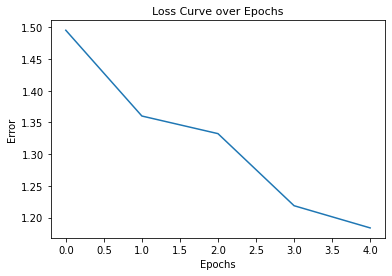

In [24]:
# Loss Curve (Training) - VGG16:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

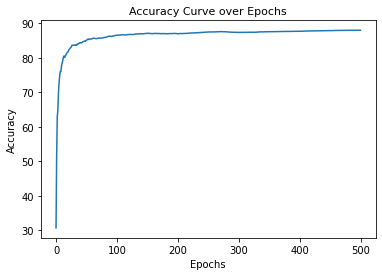

In [25]:
# Accuracy Curve (Training) - VGG16

plt.plot(accuracies)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### VGG16 - Validating

In [28]:
confusion_matrix = torch.zeros(3, 3)          # 3 represents number of classes.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

correct = 0
total = 0

accuracies1 = []

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    vgg16.eval()

    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #ohelabels = nn.functional.one_hot(labels, num_classes = 3)
        #print("\nNormal Label: ", labels, "\nOne Hot Label: ", ohelabels)

        batchsizecheck = 2

        ohelabels = onehotencoder(batchsizecheck, labels)
        print("\nNormal Label: ", labels, "\nOne Hot Label: ", ohelabels)     #For Checking? - Done.
        
        optimizer.zero_grad()

        outputs = vgg16(inputs)                         #----> forward pass
        _, predicted = torch.max(outputs.data, 1)

        loss = criterion(outputs, ohelabels)            #----> compute loss

        #loss.backward()                                #----> backward pass
        #optimizer.step()                               #----> weights update

        running_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies1.append(tempaccuracy)
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.item()))
        
    errors.append(running_loss)

print('\nFinal Accuracy of the network on the Validation Images: %d %%' % (
    100 * correct / total))

# Confusion matrix

finalcm = multilabel_confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy())
print('\nConfusion Matrix of the network on the test images: \n', finalcm)

# F1 Score

finalfs = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average = 'micro')
print('\nF1 Score of the network on the test images: \n', finalfs)  

print('\nFinished Validating!')


0it [00:00, ?it/s]
Validation Epoch: 0 [0/628 (0%)]	Loss: 0.110744: : 0it [00:02, ?it/s]
Validation Epoch: 0 [0/628 (0%)]	Loss: 0.110744: : 1it [00:02,  2.10s/it]


Normal Label:  tensor([2, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [4/628 (1%)]	Loss: 0.001140: : 1it [00:04,  2.10s/it]
Validation Epoch: 0 [4/628 (1%)]	Loss: 0.001140: : 2it [00:04,  2.09s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [8/628 (1%)]	Loss: 0.022318: : 2it [00:05,  2.09s/it]
Validation Epoch: 0 [8/628 (1%)]	Loss: 0.022318: : 3it [00:05,  2.01s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [12/628 (2%)]	Loss: 0.058954: : 3it [00:08,  2.01s/it]
Validation Epoch: 0 [12/628 (2%)]	Loss: 0.058954: : 4it [00:08,  2.01s/it]


Normal Label:  tensor([0, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [16/628 (3%)]	Loss: 0.028461: : 4it [00:09,  2.01s/it]
Validation Epoch: 0 [16/628 (3%)]	Loss: 0.028461: : 5it [00:09,  1.85s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [20/628 (3%)]	Loss: 0.008367: : 5it [00:11,  1.85s/it]
Validation Epoch: 0 [20/628 (3%)]	Loss: 0.008367: : 6it [00:11,  1.91s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [24/628 (4%)]	Loss: 0.014452: : 6it [00:13,  1.91s/it]
Validation Epoch: 0 [24/628 (4%)]	Loss: 0.014452: : 7it [00:13,  1.91s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [28/628 (4%)]	Loss: 0.002454: : 7it [00:15,  1.91s/it]
Validation Epoch: 0 [28/628 (4%)]	Loss: 0.002454: : 8it [00:15,  2.00s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [32/628 (5%)]	Loss: 0.003081: : 8it [00:17,  2.00s/it]
Validation Epoch: 0 [32/628 (5%)]	Loss: 0.003081: : 9it [00:17,  1.93s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [36/628 (6%)]	Loss: 0.064271: : 9it [00:19,  1.93s/it]
Validation Epoch: 0 [36/628 (6%)]	Loss: 0.064271: : 10it [00:19,  1.89s/it]


Normal Label:  tensor([2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [40/628 (6%)]	Loss: 0.001507: : 10it [00:21,  1.89s/it]
Validation Epoch: 0 [40/628 (6%)]	Loss: 0.001507: : 11it [00:21,  1.97s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [44/628 (7%)]	Loss: 0.009011: : 11it [00:23,  1.97s/it]
Validation Epoch: 0 [44/628 (7%)]	Loss: 0.009011: : 12it [00:23,  1.92s/it]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [48/628 (8%)]	Loss: 0.004468: : 12it [00:25,  1.92s/it]
Validation Epoch: 0 [48/628 (8%)]	Loss: 0.004468: : 13it [00:25,  1.90s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [52/628 (8%)]	Loss: 0.005221: : 13it [00:40,  1.90s/it]
Validation Epoch: 0 [52/628 (8%)]	Loss: 0.005221: : 14it [00:40,  6.07s/it]


Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [56/628 (9%)]	Loss: 0.004788: : 14it [00:42,  6.07s/it]
Validation Epoch: 0 [56/628 (9%)]	Loss: 0.004788: : 15it [00:42,  4.87s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [60/628 (10%)]	Loss: 0.003186: : 15it [00:45,  4.87s/it]
Validation Epoch: 0 [60/628 (10%)]	Loss: 0.003186: : 16it [00:45,  4.07s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [64/628 (10%)]	Loss: 0.015831: : 16it [00:47,  4.07s/it]
Validation Epoch: 0 [64/628 (10%)]	Loss: 0.015831: : 17it [00:47,  3.45s/it]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [68/628 (11%)]	Loss: 0.007947: : 17it [00:48,  3.45s/it]
Validation Epoch: 0 [68/628 (11%)]	Loss: 0.007947: : 18it [00:49,  2.98s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [72/628 (11%)]	Loss: 0.004680: : 18it [00:50,  2.98s/it]
Validation Epoch: 0 [72/628 (11%)]	Loss: 0.004680: : 19it [00:50,  2.58s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [76/628 (12%)]	Loss: 0.001709: : 19it [00:52,  2.58s/it]
Validation Epoch: 0 [76/628 (12%)]	Loss: 0.001709: : 20it [00:52,  2.39s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [80/628 (13%)]	Loss: 0.050272: : 20it [00:54,  2.39s/it]
Validation Epoch: 0 [80/628 (13%)]	Loss: 0.050272: : 21it [00:54,  2.31s/it]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [84/628 (13%)]	Loss: 0.026636: : 21it [00:56,  2.31s/it]
Validation Epoch: 0 [84/628 (13%)]	Loss: 0.026636: : 22it [00:56,  2.20s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [88/628 (14%)]	Loss: 0.012485: : 22it [00:58,  2.20s/it]
Validation Epoch: 0 [88/628 (14%)]	Loss: 0.012485: : 23it [00:58,  2.12s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [92/628 (15%)]	Loss: 0.037811: : 23it [01:00,  2.12s/it]
Validation Epoch: 0 [92/628 (15%)]	Loss: 0.037811: : 24it [01:00,  2.04s/it]


Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [96/628 (15%)]	Loss: 0.009608: : 24it [01:02,  2.04s/it]
Validation Epoch: 0 [96/628 (15%)]	Loss: 0.009608: : 25it [01:02,  2.06s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [100/628 (16%)]	Loss: 0.005081: : 25it [01:04,  2.06s/it]
Validation Epoch: 0 [100/628 (16%)]	Loss: 0.005081: : 26it [01:04,  2.06s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [104/628 (17%)]	Loss: 0.003282: : 26it [01:29,  2.06s/it]
Validation Epoch: 0 [104/628 (17%)]	Loss: 0.003282: : 27it [01:29,  9.00s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [108/628 (17%)]	Loss: 0.006007: : 27it [01:31,  9.00s/it]
Validation Epoch: 0 [108/628 (17%)]	Loss: 0.006007: : 28it [01:31,  6.92s/it]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [112/628 (18%)]	Loss: 0.016856: : 28it [01:33,  6.92s/it]
Validation Epoch: 0 [112/628 (18%)]	Loss: 0.016856: : 29it [01:33,  5.34s/it]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [116/628 (18%)]	Loss: 0.002362: : 29it [01:35,  5.34s/it]
Validation Epoch: 0 [116/628 (18%)]	Loss: 0.002362: : 30it [01:35,  4.39s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [120/628 (19%)]	Loss: 0.027089: : 30it [01:37,  4.39s/it]
Validation Epoch: 0 [120/628 (19%)]	Loss: 0.027089: : 31it [01:37,  3.65s/it]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [124/628 (20%)]	Loss: 0.031702: : 31it [01:39,  3.65s/it]
Validation Epoch: 0 [124/628 (20%)]	Loss: 0.031702: : 32it [01:39,  3.15s/it]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [128/628 (20%)]	Loss: 0.002748: : 32it [01:41,  3.15s/it]
Validation Epoch: 0 [128/628 (20%)]	Loss: 0.002748: : 33it [01:41,  2.80s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [132/628 (21%)]	Loss: 0.020984: : 33it [01:43,  2.80s/it]
Validation Epoch: 0 [132/628 (21%)]	Loss: 0.020984: : 34it [01:43,  2.54s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [136/628 (22%)]	Loss: 0.002372: : 34it [01:45,  2.54s/it]
Validation Epoch: 0 [136/628 (22%)]	Loss: 0.002372: : 35it [01:45,  2.42s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [140/628 (22%)]	Loss: 0.004422: : 35it [01:47,  2.42s/it]
Validation Epoch: 0 [140/628 (22%)]	Loss: 0.004422: : 36it [01:47,  2.28s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [144/628 (23%)]	Loss: 0.015891: : 36it [01:49,  2.28s/it]
Validation Epoch: 0 [144/628 (23%)]	Loss: 0.015891: : 37it [01:49,  2.12s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [148/628 (24%)]	Loss: 0.002480: : 37it [01:51,  2.12s/it]
Validation Epoch: 0 [148/628 (24%)]	Loss: 0.002480: : 38it [01:51,  2.05s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [152/628 (24%)]	Loss: 0.022563: : 38it [01:52,  2.05s/it]
Validation Epoch: 0 [152/628 (24%)]	Loss: 0.022563: : 39it [01:52,  1.88s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [156/628 (25%)]	Loss: 0.003740: : 39it [01:54,  1.88s/it]
Validation Epoch: 0 [156/628 (25%)]	Loss: 0.003740: : 40it [01:54,  1.86s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [160/628 (25%)]	Loss: 0.002670: : 40it [01:56,  1.86s/it]
Validation Epoch: 0 [160/628 (25%)]	Loss: 0.002670: : 41it [01:56,  1.85s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [164/628 (26%)]	Loss: 0.025763: : 41it [01:58,  1.85s/it]
Validation Epoch: 0 [164/628 (26%)]	Loss: 0.025763: : 42it [01:58,  1.88s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [168/628 (27%)]	Loss: 0.002831: : 42it [02:00,  1.88s/it]
Validation Epoch: 0 [168/628 (27%)]	Loss: 0.002831: : 43it [02:00,  1.88s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [172/628 (27%)]	Loss: 0.002102: : 43it [02:02,  1.88s/it]
Validation Epoch: 0 [172/628 (27%)]	Loss: 0.002102: : 44it [02:02,  1.97s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [176/628 (28%)]	Loss: 0.013084: : 44it [02:03,  1.97s/it]
Validation Epoch: 0 [176/628 (28%)]	Loss: 0.013084: : 45it [02:03,  1.86s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [180/628 (29%)]	Loss: 0.024296: : 45it [02:05,  1.86s/it]
Validation Epoch: 0 [180/628 (29%)]	Loss: 0.024296: : 46it [02:05,  1.87s/it]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [184/628 (29%)]	Loss: 0.002979: : 46it [02:07,  1.87s/it]
Validation Epoch: 0 [184/628 (29%)]	Loss: 0.002979: : 47it [02:07,  1.93s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [188/628 (30%)]	Loss: 0.002044: : 47it [02:09,  1.93s/it]
Validation Epoch: 0 [188/628 (30%)]	Loss: 0.002044: : 48it [02:09,  1.96s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [192/628 (31%)]	Loss: 0.005053: : 48it [02:11,  1.96s/it]
Validation Epoch: 0 [192/628 (31%)]	Loss: 0.005053: : 49it [02:11,  1.88s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [196/628 (31%)]	Loss: 0.001888: : 49it [02:13,  1.88s/it]
Validation Epoch: 0 [196/628 (31%)]	Loss: 0.001888: : 50it [02:13,  1.79s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [200/628 (32%)]	Loss: 0.019642: : 50it [02:15,  1.79s/it]
Validation Epoch: 0 [200/628 (32%)]	Loss: 0.019642: : 51it [02:15,  1.99s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [204/628 (32%)]	Loss: 0.001044: : 51it [02:17,  1.99s/it]
Validation Epoch: 0 [204/628 (32%)]	Loss: 0.001044: : 52it [02:17,  1.92s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [208/628 (33%)]	Loss: 0.006881: : 52it [02:19,  1.92s/it]
Validation Epoch: 0 [208/628 (33%)]	Loss: 0.006881: : 53it [02:19,  1.96s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [212/628 (34%)]	Loss: 0.030525: : 53it [02:21,  1.96s/it]
Validation Epoch: 0 [212/628 (34%)]	Loss: 0.030525: : 54it [02:21,  1.91s/it]


Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [216/628 (34%)]	Loss: 0.032417: : 54it [02:23,  1.91s/it]
Validation Epoch: 0 [216/628 (34%)]	Loss: 0.032417: : 55it [02:23,  1.86s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [220/628 (35%)]	Loss: 0.035949: : 55it [02:26,  1.86s/it]
Validation Epoch: 0 [220/628 (35%)]	Loss: 0.035949: : 56it [02:26,  2.45s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [224/628 (36%)]	Loss: 0.010223: : 56it [02:28,  2.45s/it]
Validation Epoch: 0 [224/628 (36%)]	Loss: 0.010223: : 57it [02:28,  2.29s/it]


Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [228/628 (36%)]	Loss: 0.023716: : 57it [02:30,  2.29s/it]
Validation Epoch: 0 [228/628 (36%)]	Loss: 0.023716: : 58it [02:30,  2.22s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [232/628 (37%)]	Loss: 0.004773: : 58it [02:32,  2.22s/it]
Validation Epoch: 0 [232/628 (37%)]	Loss: 0.004773: : 59it [02:32,  2.05s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [236/628 (38%)]	Loss: 0.035213: : 59it [02:35,  2.05s/it]
Validation Epoch: 0 [236/628 (38%)]	Loss: 0.035213: : 60it [02:35,  2.25s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [240/628 (38%)]	Loss: 0.016302: : 60it [02:37,  2.25s/it]
Validation Epoch: 0 [240/628 (38%)]	Loss: 0.016302: : 61it [02:37,  2.14s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [244/628 (39%)]	Loss: 0.001198: : 61it [02:38,  2.14s/it]
Validation Epoch: 0 [244/628 (39%)]	Loss: 0.001198: : 62it [02:38,  2.05s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [248/628 (39%)]	Loss: 0.005330: : 62it [02:40,  2.05s/it]
Validation Epoch: 0 [248/628 (39%)]	Loss: 0.005330: : 63it [02:40,  1.92s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [252/628 (40%)]	Loss: 0.004038: : 63it [02:42,  1.92s/it]
Validation Epoch: 0 [252/628 (40%)]	Loss: 0.004038: : 64it [02:42,  1.86s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [256/628 (41%)]	Loss: 0.003459: : 64it [02:44,  1.86s/it]
Validation Epoch: 0 [256/628 (41%)]	Loss: 0.003459: : 65it [02:44,  1.86s/it]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [260/628 (41%)]	Loss: 0.017102: : 65it [02:46,  1.86s/it]
Validation Epoch: 0 [260/628 (41%)]	Loss: 0.017102: : 66it [02:46,  1.88s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [264/628 (42%)]	Loss: 0.039290: : 66it [02:48,  1.88s/it]
Validation Epoch: 0 [264/628 (42%)]	Loss: 0.039290: : 67it [02:48,  1.95s/it]


Normal Label:  tensor([0, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [268/628 (43%)]	Loss: 0.007475: : 67it [02:50,  1.95s/it]
Validation Epoch: 0 [268/628 (43%)]	Loss: 0.007475: : 68it [02:50,  1.94s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [272/628 (43%)]	Loss: 0.008580: : 68it [02:51,  1.94s/it]
Validation Epoch: 0 [272/628 (43%)]	Loss: 0.008580: : 69it [02:51,  1.86s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [276/628 (44%)]	Loss: 0.039032: : 69it [02:53,  1.86s/it]
Validation Epoch: 0 [276/628 (44%)]	Loss: 0.039032: : 70it [02:53,  1.90s/it]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [280/628 (45%)]	Loss: 0.004913: : 70it [02:55,  1.90s/it]
Validation Epoch: 0 [280/628 (45%)]	Loss: 0.004913: : 71it [02:55,  1.96s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [284/628 (45%)]	Loss: 0.006526: : 71it [03:00,  1.96s/it]
Validation Epoch: 0 [284/628 (45%)]	Loss: 0.006526: : 72it [03:00,  2.67s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [288/628 (46%)]	Loss: 0.018614: : 72it [03:01,  2.67s/it]
Validation Epoch: 0 [288/628 (46%)]	Loss: 0.018614: : 73it [03:01,  2.32s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [292/628 (46%)]	Loss: 0.004666: : 73it [03:03,  2.32s/it]
Validation Epoch: 0 [292/628 (46%)]	Loss: 0.004666: : 74it [03:03,  2.21s/it]


Normal Label:  tensor([0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [296/628 (47%)]	Loss: 0.008255: : 74it [03:05,  2.21s/it]
Validation Epoch: 0 [296/628 (47%)]	Loss: 0.008255: : 75it [03:05,  2.04s/it]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [300/628 (48%)]	Loss: 0.043144: : 75it [03:07,  2.04s/it]
Validation Epoch: 0 [300/628 (48%)]	Loss: 0.043144: : 76it [03:07,  1.94s/it]


Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [304/628 (48%)]	Loss: 0.005605: : 76it [03:08,  1.94s/it]
Validation Epoch: 0 [304/628 (48%)]	Loss: 0.005605: : 77it [03:08,  1.81s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [308/628 (49%)]	Loss: 0.052375: : 77it [03:10,  1.81s/it]
Validation Epoch: 0 [308/628 (49%)]	Loss: 0.052375: : 78it [03:10,  1.97s/it]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [312/628 (50%)]	Loss: 0.015179: : 78it [03:12,  1.97s/it]
Validation Epoch: 0 [312/628 (50%)]	Loss: 0.015179: : 79it [03:12,  1.86s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [316/628 (50%)]	Loss: 0.048923: : 79it [03:16,  1.86s/it]
Validation Epoch: 0 [316/628 (50%)]	Loss: 0.048923: : 80it [03:16,  2.41s/it]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [320/628 (51%)]	Loss: 0.046192: : 80it [03:17,  2.41s/it]
Validation Epoch: 0 [320/628 (51%)]	Loss: 0.046192: : 81it [03:17,  2.19s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [324/628 (52%)]	Loss: 0.003603: : 81it [03:19,  2.19s/it]
Validation Epoch: 0 [324/628 (52%)]	Loss: 0.003603: : 82it [03:19,  2.10s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [328/628 (52%)]	Loss: 0.021681: : 82it [03:21,  2.10s/it]
Validation Epoch: 0 [328/628 (52%)]	Loss: 0.021681: : 83it [03:21,  1.92s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [332/628 (53%)]	Loss: 0.009906: : 83it [03:22,  1.92s/it]
Validation Epoch: 0 [332/628 (53%)]	Loss: 0.009906: : 84it [03:22,  1.79s/it]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [336/628 (54%)]	Loss: 0.002054: : 84it [03:24,  1.79s/it]
Validation Epoch: 0 [336/628 (54%)]	Loss: 0.002054: : 85it [03:24,  1.86s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [340/628 (54%)]	Loss: 0.003145: : 85it [03:27,  1.86s/it]
Validation Epoch: 0 [340/628 (54%)]	Loss: 0.003145: : 86it [03:27,  2.10s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [344/628 (55%)]	Loss: 0.001221: : 86it [03:29,  2.10s/it]
Validation Epoch: 0 [344/628 (55%)]	Loss: 0.001221: : 87it [03:29,  2.07s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [348/628 (55%)]	Loss: 0.003308: : 87it [03:31,  2.07s/it]
Validation Epoch: 0 [348/628 (55%)]	Loss: 0.003308: : 88it [03:31,  2.01s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [352/628 (56%)]	Loss: 0.007359: : 88it [03:33,  2.01s/it]
Validation Epoch: 0 [352/628 (56%)]	Loss: 0.007359: : 89it [03:33,  1.97s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [356/628 (57%)]	Loss: 0.031225: : 89it [03:34,  1.97s/it]
Validation Epoch: 0 [356/628 (57%)]	Loss: 0.031225: : 90it [03:34,  1.88s/it]


Normal Label:  tensor([0, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [360/628 (57%)]	Loss: 0.023196: : 90it [03:36,  1.88s/it]
Validation Epoch: 0 [360/628 (57%)]	Loss: 0.023196: : 91it [03:36,  1.81s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [364/628 (58%)]	Loss: 0.006275: : 91it [03:37,  1.81s/it]
Validation Epoch: 0 [364/628 (58%)]	Loss: 0.006275: : 92it [03:37,  1.72s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [368/628 (59%)]	Loss: 0.372628: : 92it [03:39,  1.72s/it]
Validation Epoch: 0 [368/628 (59%)]	Loss: 0.372628: : 93it [03:39,  1.70s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [372/628 (59%)]	Loss: 0.015397: : 93it [03:41,  1.70s/it]
Validation Epoch: 0 [372/628 (59%)]	Loss: 0.015397: : 94it [03:41,  1.68s/it]


Normal Label:  tensor([2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [376/628 (60%)]	Loss: 0.003150: : 94it [03:42,  1.68s/it]
Validation Epoch: 0 [376/628 (60%)]	Loss: 0.003150: : 95it [03:42,  1.69s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [380/628 (61%)]	Loss: 0.018478: : 95it [03:44,  1.69s/it]
Validation Epoch: 0 [380/628 (61%)]	Loss: 0.018478: : 96it [03:44,  1.74s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [384/628 (61%)]	Loss: 0.018587: : 96it [03:46,  1.74s/it]
Validation Epoch: 0 [384/628 (61%)]	Loss: 0.018587: : 97it [03:46,  1.70s/it]


Normal Label:  tensor([2, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [388/628 (62%)]	Loss: 0.038466: : 97it [03:48,  1.70s/it]
Validation Epoch: 0 [388/628 (62%)]	Loss: 0.038466: : 98it [03:48,  1.82s/it]


Normal Label:  tensor([2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [392/628 (62%)]	Loss: 0.018680: : 98it [03:49,  1.82s/it]
Validation Epoch: 0 [392/628 (62%)]	Loss: 0.018680: : 99it [03:49,  1.70s/it]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [396/628 (63%)]	Loss: 0.018049: : 99it [03:51,  1.70s/it]
Validation Epoch: 0 [396/628 (63%)]	Loss: 0.018049: : 100it [03:51,  1.80s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [400/628 (64%)]	Loss: 0.001337: : 100it [03:53,  1.80s/it]
Validation Epoch: 0 [400/628 (64%)]	Loss: 0.001337: : 101it [03:53,  1.86s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [404/628 (64%)]	Loss: 0.015494: : 101it [03:55,  1.86s/it]
Validation Epoch: 0 [404/628 (64%)]	Loss: 0.015494: : 102it [03:55,  1.81s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [408/628 (65%)]	Loss: 0.002182: : 102it [03:57,  1.81s/it]
Validation Epoch: 0 [408/628 (65%)]	Loss: 0.002182: : 103it [03:57,  1.81s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [412/628 (66%)]	Loss: 0.017043: : 103it [03:59,  1.81s/it]
Validation Epoch: 0 [412/628 (66%)]	Loss: 0.017043: : 104it [03:59,  1.77s/it]


Normal Label:  tensor([1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [416/628 (66%)]	Loss: 0.001276: : 104it [04:01,  1.77s/it]
Validation Epoch: 0 [416/628 (66%)]	Loss: 0.001276: : 105it [04:01,  1.91s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [420/628 (67%)]	Loss: 0.008678: : 105it [04:03,  1.91s/it]
Validation Epoch: 0 [420/628 (67%)]	Loss: 0.008678: : 106it [04:03,  1.87s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [424/628 (68%)]	Loss: 0.005938: : 106it [04:04,  1.87s/it]
Validation Epoch: 0 [424/628 (68%)]	Loss: 0.005938: : 107it [04:04,  1.83s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [428/628 (68%)]	Loss: 0.006601: : 107it [04:07,  1.83s/it]
Validation Epoch: 0 [428/628 (68%)]	Loss: 0.006601: : 108it [04:07,  2.08s/it]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [432/628 (69%)]	Loss: 0.002072: : 108it [04:09,  2.08s/it]
Validation Epoch: 0 [432/628 (69%)]	Loss: 0.002072: : 109it [04:09,  2.05s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [436/628 (69%)]	Loss: 0.016357: : 109it [04:11,  2.05s/it]
Validation Epoch: 0 [436/628 (69%)]	Loss: 0.016357: : 110it [04:11,  1.91s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [440/628 (70%)]	Loss: 0.041790: : 110it [04:12,  1.91s/it]
Validation Epoch: 0 [440/628 (70%)]	Loss: 0.041790: : 111it [04:12,  1.83s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [444/628 (71%)]	Loss: 0.014860: : 111it [04:14,  1.83s/it]
Validation Epoch: 0 [444/628 (71%)]	Loss: 0.014860: : 112it [04:14,  1.83s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [448/628 (71%)]	Loss: 0.005725: : 112it [04:15,  1.83s/it]
Validation Epoch: 0 [448/628 (71%)]	Loss: 0.005725: : 113it [04:15,  1.69s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [452/628 (72%)]	Loss: 0.001831: : 113it [04:17,  1.69s/it]
Validation Epoch: 0 [452/628 (72%)]	Loss: 0.001831: : 114it [04:17,  1.63s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [456/628 (73%)]	Loss: 0.005945: : 114it [04:18,  1.63s/it]
Validation Epoch: 0 [456/628 (73%)]	Loss: 0.005945: : 115it [04:18,  1.61s/it]


Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [460/628 (73%)]	Loss: 0.018333: : 115it [04:20,  1.61s/it]
Validation Epoch: 0 [460/628 (73%)]	Loss: 0.018333: : 116it [04:20,  1.62s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [464/628 (74%)]	Loss: 0.011730: : 116it [04:22,  1.62s/it]
Validation Epoch: 0 [464/628 (74%)]	Loss: 0.011730: : 117it [04:22,  1.68s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [468/628 (75%)]	Loss: 0.013411: : 117it [04:24,  1.68s/it]
Validation Epoch: 0 [468/628 (75%)]	Loss: 0.013411: : 118it [04:24,  1.69s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [472/628 (75%)]	Loss: 0.002806: : 118it [04:25,  1.69s/it]
Validation Epoch: 0 [472/628 (75%)]	Loss: 0.002806: : 119it [04:25,  1.65s/it]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [476/628 (76%)]	Loss: 0.014233: : 119it [04:28,  1.65s/it]
Validation Epoch: 0 [476/628 (76%)]	Loss: 0.014233: : 120it [04:28,  1.96s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [480/628 (76%)]	Loss: 0.005003: : 120it [04:30,  1.96s/it]
Validation Epoch: 0 [480/628 (76%)]	Loss: 0.005003: : 121it [04:30,  1.99s/it]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [484/628 (77%)]	Loss: 0.015079: : 121it [04:32,  1.99s/it]
Validation Epoch: 0 [484/628 (77%)]	Loss: 0.015079: : 122it [04:32,  1.97s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [488/628 (78%)]	Loss: 0.002237: : 122it [04:34,  1.97s/it]
Validation Epoch: 0 [488/628 (78%)]	Loss: 0.002237: : 123it [04:34,  1.94s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [492/628 (78%)]	Loss: 0.028475: : 123it [04:35,  1.94s/it]
Validation Epoch: 0 [492/628 (78%)]	Loss: 0.028475: : 124it [04:35,  1.87s/it]


Normal Label:  tensor([2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [496/628 (79%)]	Loss: 0.005469: : 124it [04:37,  1.87s/it]
Validation Epoch: 0 [496/628 (79%)]	Loss: 0.005469: : 125it [04:37,  1.79s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [500/628 (80%)]	Loss: 0.023551: : 125it [04:39,  1.79s/it]
Validation Epoch: 0 [500/628 (80%)]	Loss: 0.023551: : 126it [04:39,  1.78s/it]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [504/628 (80%)]	Loss: 0.001756: : 126it [04:41,  1.78s/it]
Validation Epoch: 0 [504/628 (80%)]	Loss: 0.001756: : 127it [04:41,  1.82s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [508/628 (81%)]	Loss: 0.019020: : 127it [04:42,  1.82s/it]
Validation Epoch: 0 [508/628 (81%)]	Loss: 0.019020: : 128it [04:42,  1.80s/it]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [512/628 (82%)]	Loss: 0.004934: : 128it [04:44,  1.80s/it]
Validation Epoch: 0 [512/628 (82%)]	Loss: 0.004934: : 129it [04:44,  1.82s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [516/628 (82%)]	Loss: 0.013383: : 129it [04:46,  1.82s/it]
Validation Epoch: 0 [516/628 (82%)]	Loss: 0.013383: : 130it [04:46,  1.77s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [520/628 (83%)]	Loss: 0.002538: : 130it [04:48,  1.77s/it]
Validation Epoch: 0 [520/628 (83%)]	Loss: 0.002538: : 131it [04:48,  1.80s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [524/628 (83%)]	Loss: 0.007121: : 131it [04:50,  1.80s/it]
Validation Epoch: 0 [524/628 (83%)]	Loss: 0.007121: : 132it [04:50,  1.77s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [528/628 (84%)]	Loss: 0.007876: : 132it [04:52,  1.77s/it]
Validation Epoch: 0 [528/628 (84%)]	Loss: 0.007876: : 133it [04:52,  1.89s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [532/628 (85%)]	Loss: 0.003654: : 133it [04:53,  1.89s/it]
Validation Epoch: 0 [532/628 (85%)]	Loss: 0.003654: : 134it [04:53,  1.81s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [536/628 (85%)]	Loss: 0.003402: : 134it [04:55,  1.81s/it]
Validation Epoch: 0 [536/628 (85%)]	Loss: 0.003402: : 135it [04:55,  1.82s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [540/628 (86%)]	Loss: 0.005841: : 135it [04:57,  1.82s/it]
Validation Epoch: 0 [540/628 (86%)]	Loss: 0.005841: : 136it [04:57,  1.71s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [544/628 (87%)]	Loss: 0.007537: : 136it [04:58,  1.71s/it]
Validation Epoch: 0 [544/628 (87%)]	Loss: 0.007537: : 137it [04:58,  1.70s/it]


Normal Label:  tensor([2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [548/628 (87%)]	Loss: 0.003787: : 137it [05:00,  1.70s/it]
Validation Epoch: 0 [548/628 (87%)]	Loss: 0.003787: : 138it [05:00,  1.81s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [552/628 (88%)]	Loss: 0.047561: : 138it [05:02,  1.81s/it]
Validation Epoch: 0 [552/628 (88%)]	Loss: 0.047561: : 139it [05:02,  1.88s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [556/628 (89%)]	Loss: 0.002400: : 139it [05:04,  1.88s/it]
Validation Epoch: 0 [556/628 (89%)]	Loss: 0.002400: : 140it [05:04,  1.83s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [560/628 (89%)]	Loss: 0.006477: : 140it [05:06,  1.83s/it]
Validation Epoch: 0 [560/628 (89%)]	Loss: 0.006477: : 141it [05:06,  1.77s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [564/628 (90%)]	Loss: 0.008104: : 141it [05:07,  1.77s/it]
Validation Epoch: 0 [564/628 (90%)]	Loss: 0.008104: : 142it [05:07,  1.70s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [568/628 (90%)]	Loss: 0.001926: : 142it [05:09,  1.70s/it]
Validation Epoch: 0 [568/628 (90%)]	Loss: 0.001926: : 143it [05:09,  1.73s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [572/628 (91%)]	Loss: 0.013938: : 143it [05:11,  1.73s/it]
Validation Epoch: 0 [572/628 (91%)]	Loss: 0.013938: : 144it [05:11,  1.72s/it]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [576/628 (92%)]	Loss: 0.034604: : 144it [05:13,  1.72s/it]
Validation Epoch: 0 [576/628 (92%)]	Loss: 0.034604: : 145it [05:13,  1.72s/it]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [580/628 (92%)]	Loss: 0.011990: : 145it [05:14,  1.72s/it]
Validation Epoch: 0 [580/628 (92%)]	Loss: 0.011990: : 146it [05:14,  1.73s/it]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [584/628 (93%)]	Loss: 0.024842: : 146it [05:16,  1.73s/it]
Validation Epoch: 0 [584/628 (93%)]	Loss: 0.024842: : 147it [05:16,  1.74s/it]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [588/628 (94%)]	Loss: 0.002862: : 147it [05:18,  1.74s/it]
Validation Epoch: 0 [588/628 (94%)]	Loss: 0.002862: : 148it [05:18,  1.73s/it]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [592/628 (94%)]	Loss: 0.004664: : 148it [05:19,  1.73s/it]
Validation Epoch: 0 [592/628 (94%)]	Loss: 0.004664: : 149it [05:19,  1.68s/it]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [596/628 (95%)]	Loss: 0.043774: : 149it [05:21,  1.68s/it]
Validation Epoch: 0 [596/628 (95%)]	Loss: 0.043774: : 150it [05:21,  1.70s/it]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [600/628 (96%)]	Loss: 0.004331: : 150it [05:23,  1.70s/it]
Validation Epoch: 0 [600/628 (96%)]	Loss: 0.004331: : 151it [05:23,  1.83s/it]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [604/628 (96%)]	Loss: 0.001097: : 151it [05:25,  1.83s/it]
Validation Epoch: 0 [604/628 (96%)]	Loss: 0.001097: : 152it [05:25,  1.84s/it]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [608/628 (97%)]	Loss: 0.022516: : 152it [05:26,  1.84s/it]
Validation Epoch: 0 [608/628 (97%)]	Loss: 0.022516: : 153it [05:26,  1.69s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [612/628 (97%)]	Loss: 0.024954: : 153it [05:29,  1.69s/it]
Validation Epoch: 0 [612/628 (97%)]	Loss: 0.024954: : 154it [05:29,  1.82s/it]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [616/628 (98%)]	Loss: 0.002683: : 154it [05:30,  1.82s/it]
Validation Epoch: 0 [616/628 (98%)]	Loss: 0.002683: : 155it [05:30,  1.79s/it]


Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 0 [620/628 (99%)]	Loss: 0.007030: : 155it [05:33,  1.79s/it]
Validation Epoch: 0 [620/628 (99%)]	Loss: 0.007030: : 156it [05:33,  2.01s/it]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 0 [624/628 (99%)]	Loss: 0.028463: : 156it [05:34,  2.01s/it]
Validation Epoch: 0 [624/628 (99%)]	Loss: 0.028463: : 157it [05:35,  2.13s/it]

0it [00:00, ?it/s]


Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [0/628 (0%)]	Loss: 0.011070: : 0it [00:00, ?it/s]
Validation Epoch: 1 [0/628 (0%)]	Loss: 0.011070: : 1it [00:00,  6.43it/s]
Validation Epoch: 1 [4/628 (1%)]	Loss: 0.003088: : 1it [00:00,  6.43it/s]
Validation Epoch: 1 [4/628 (1%)]	Loss: 0.003088: : 2it [00:00,  6.59it/s]
Validation Epoch: 1 [8/628 (1%)]	Loss: 0.003116: : 2it [00:00,  6.59it/s]
Validation Epoch: 1 [8/628 (1%)]	Loss: 0.003116: : 3it [00:00,  6.92it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [12/628 (2%)]	Loss: 0.005474: : 3it [00:00,  6.92it/s]
Validation Epoch: 1 [12/628 (2%)]	Loss: 0.005474: : 4it [00:00,  7.18it/s]
Validation Epoch: 1 [16/628 (3%)]	Loss: 0.002351: : 4it [00:00,  7.18it/s]
Validation Epoch: 1 [16/628 (3%)]	Loss: 0.002351: : 5it [00:00,  7.26it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [20/628 (3%)]	Loss: 0.003683: : 5it [00:00,  7.26it/s]
Validation Epoch: 1 [20/628 (3%)]	Loss: 0.003683: : 6it [00:00,  7.26it/s]
Validation Epoch: 1 [24/628 (4%)]	Loss: 0.002133: : 6it [00:00,  7.26it/s]
Validation Epoch: 1 [24/628 (4%)]	Loss: 0.002133: : 7it [00:00,  7.28it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [28/628 (4%)]	Loss: 0.007217: : 7it [00:01,  7.28it/s]
Validation Epoch: 1 [28/628 (4%)]	Loss: 0.007217: : 8it [00:01,  7.38it/s]
Validation Epoch: 1 [32/628 (5%)]	Loss: 0.016729: : 8it [00:01,  7.38it/s]
Validation Epoch: 1 [32/628 (5%)]	Loss: 0.016729: : 9it [00:01,  7.28it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [36/628 (6%)]	Loss: 0.001714: : 9it [00:01,  7.28it/s]
Validation Epoch: 1 [36/628 (6%)]	Loss: 0.001714: : 10it [00:01,  7.29it/s]
Validation Epoch: 1 [40/628 (6%)]	Loss: 0.008640: : 10it [00:01,  7.29it/s]
Validation Epoch: 1 [40/628 (6%)]	Loss: 0.008640: : 11it [00:01,  7.24it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [44/628 (7%)]	Loss: 0.004980: : 11it [00:01,  7.24it/s]
Validation Epoch: 1 [44/628 (7%)]	Loss: 0.004980: : 12it [00:01,  7.19it/s]
Validation Epoch: 1 [48/628 (8%)]	Loss: 0.001990: : 12it [00:01,  7.19it/s]
Validation Epoch: 1 [48/628 (8%)]	Loss: 0.001990: : 13it [00:01,  7.24it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [52/628 (8%)]	Loss: 0.029273: : 13it [00:01,  7.24it/s]
Validation Epoch: 1 [52/628 (8%)]	Loss: 0.029273: : 14it [00:01,  7.60it/s]
Validation Epoch: 1 [56/628 (9%)]	Loss: 0.003134: : 14it [00:02,  7.60it/s]
Validation Epoch: 1 [56/628 (9%)]	Loss: 0.003134: : 15it [00:02,  7.59it/s]


Normal Label:  tensor([2, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [60/628 (10%)]	Loss: 0.025446: : 15it [00:02,  7.59it/s]
Validation Epoch: 1 [60/628 (10%)]	Loss: 0.025446: : 16it [00:02,  6.51it/s]
Validation Epoch: 1 [64/628 (10%)]	Loss: 0.018496: : 16it [00:02,  6.51it/s]
Validation Epoch: 1 [64/628 (10%)]	Loss: 0.018496: : 17it [00:02,  6.58it/s]


Normal Label:  tensor([2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [68/628 (11%)]	Loss: 0.017015: : 17it [00:02,  6.58it/s]
Validation Epoch: 1 [68/628 (11%)]	Loss: 0.017015: : 18it [00:02,  6.77it/s]
Validation Epoch: 1 [72/628 (11%)]	Loss: 0.008337: : 18it [00:02,  6.77it/s]
Validation Epoch: 1 [72/628 (11%)]	Loss: 0.008337: : 19it [00:02,  6.69it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [76/628 (12%)]	Loss: 0.019542: : 19it [00:02,  6.69it/s]
Validation Epoch: 1 [76/628 (12%)]	Loss: 0.019542: : 20it [00:02,  6.68it/s]
Validation Epoch: 1 [80/628 (13%)]	Loss: 0.004848: : 20it [00:02,  6.68it/s]
Validation Epoch: 1 [80/628 (13%)]	Loss: 0.004848: : 21it [00:02,  6.91it/s]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [84/628 (13%)]	Loss: 0.030721: : 21it [00:03,  6.91it/s]
Validation Epoch: 1 [84/628 (13%)]	Loss: 0.030721: : 22it [00:03,  7.26it/s]
Validation Epoch: 1 [88/628 (14%)]	Loss: 0.004068: : 22it [00:03,  7.26it/s]
Validation Epoch: 1 [88/628 (14%)]	Loss: 0.004068: : 23it [00:03,  7.22it/s]


Normal Label:  tensor([2, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [92/628 (15%)]	Loss: 0.010458: : 23it [00:03,  7.22it/s]
Validation Epoch: 1 [92/628 (15%)]	Loss: 0.010458: : 24it [00:03,  7.22it/s]
Validation Epoch: 1 [96/628 (15%)]	Loss: 0.002376: : 24it [00:03,  7.22it/s]
Validation Epoch: 1 [96/628 (15%)]	Loss: 0.002376: : 25it [00:03,  7.30it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [100/628 (16%)]	Loss: 0.041567: : 25it [00:03,  7.30it/s]
Validation Epoch: 1 [100/628 (16%)]	Loss: 0.041567: : 26it [00:03,  5.48it/s]
Validation Epoch: 1 [104/628 (17%)]	Loss: 0.019060: : 26it [00:03,  5.48it/s]
Validation Epoch: 1 [104/628 (17%)]	Loss: 0.019060: : 27it [00:03,  5.84it/s]


Normal Label:  tensor([2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [108/628 (17%)]	Loss: 0.008904: : 27it [00:04,  5.84it/s]
Validation Epoch: 1 [108/628 (17%)]	Loss: 0.008904: : 28it [00:04,  5.82it/s]
Validation Epoch: 1 [112/628 (18%)]	Loss: 0.073633: : 28it [00:04,  5.82it/s]
Validation Epoch: 1 [112/628 (18%)]	Loss: 0.073633: : 29it [00:04,  6.04it/s]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [116/628 (18%)]	Loss: 0.001863: : 29it [00:04,  6.04it/s]
Validation Epoch: 1 [116/628 (18%)]	Loss: 0.001863: : 30it [00:04,  6.36it/s]
Validation Epoch: 1 [120/628 (19%)]	Loss: 0.002297: : 30it [00:04,  6.36it/s]
Validation Epoch: 1 [120/628 (19%)]	Loss: 0.002297: : 31it [00:04,  6.59it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [124/628 (20%)]	Loss: 0.034440: : 31it [00:04,  6.59it/s]
Validation Epoch: 1 [124/628 (20%)]	Loss: 0.034440: : 32it [00:04,  6.29it/s]
Validation Epoch: 1 [128/628 (20%)]	Loss: 0.001275: : 32it [00:04,  6.29it/s]
Validation Epoch: 1 [128/628 (20%)]	Loss: 0.001275: : 33it [00:04,  6.62it/s]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [132/628 (21%)]	Loss: 0.015404: : 33it [00:05,  6.62it/s]
Validation Epoch: 1 [132/628 (21%)]	Loss: 0.015404: : 34it [00:05,  5.19it/s]
Validation Epoch: 1 [136/628 (22%)]	Loss: 0.005488: : 34it [00:05,  5.19it/s]
Validation Epoch: 1 [136/628 (22%)]	Loss: 0.005488: : 35it [00:05,  5.55it/s]


Normal Label:  tensor([2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [140/628 (22%)]	Loss: 0.008060: : 35it [00:05,  5.55it/s]
Validation Epoch: 1 [140/628 (22%)]	Loss: 0.008060: : 36it [00:05,  5.94it/s]
Validation Epoch: 1 [144/628 (23%)]	Loss: 0.003220: : 36it [00:05,  5.94it/s]
Validation Epoch: 1 [144/628 (23%)]	Loss: 0.003220: : 37it [00:05,  6.23it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [148/628 (24%)]	Loss: 0.002328: : 37it [00:05,  6.23it/s]
Validation Epoch: 1 [148/628 (24%)]	Loss: 0.002328: : 38it [00:05,  4.43it/s]
Validation Epoch: 1 [152/628 (24%)]	Loss: 0.003972: : 38it [00:06,  4.43it/s]
Validation Epoch: 1 [152/628 (24%)]	Loss: 0.003972: : 39it [00:06,  5.03it/s]


Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [156/628 (25%)]	Loss: 0.016055: : 39it [00:06,  5.03it/s]
Validation Epoch: 1 [156/628 (25%)]	Loss: 0.016055: : 40it [00:06,  4.18it/s]
Validation Epoch: 1 [160/628 (25%)]	Loss: 0.007021: : 40it [00:06,  4.18it/s]
Validation Epoch: 1 [160/628 (25%)]	Loss: 0.007021: : 41it [00:06,  4.87it/s]


Normal Label:  tensor([1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [164/628 (26%)]	Loss: 0.003318: : 41it [00:06,  4.87it/s]
Validation Epoch: 1 [164/628 (26%)]	Loss: 0.003318: : 42it [00:06,  5.37it/s]
Validation Epoch: 1 [168/628 (27%)]	Loss: 0.003460: : 42it [00:06,  5.37it/s]
Validation Epoch: 1 [168/628 (27%)]	Loss: 0.003460: : 43it [00:06,  5.92it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [172/628 (27%)]	Loss: 0.003294: : 43it [00:06,  5.92it/s]
Validation Epoch: 1 [172/628 (27%)]	Loss: 0.003294: : 44it [00:06,  6.16it/s]
Validation Epoch: 1 [176/628 (28%)]	Loss: 0.002499: : 44it [00:07,  6.16it/s]
Validation Epoch: 1 [176/628 (28%)]	Loss: 0.002499: : 45it [00:07,  6.47it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [180/628 (29%)]	Loss: 0.055610: : 45it [00:07,  6.47it/s]
Validation Epoch: 1 [180/628 (29%)]	Loss: 0.055610: : 46it [00:07,  6.82it/s]
Validation Epoch: 1 [184/628 (29%)]	Loss: 0.011231: : 46it [00:07,  6.82it/s]
Validation Epoch: 1 [184/628 (29%)]	Loss: 0.011231: : 47it [00:07,  6.90it/s]


Normal Label:  tensor([1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [188/628 (30%)]	Loss: 0.007571: : 47it [00:07,  6.90it/s]
Validation Epoch: 1 [188/628 (30%)]	Loss: 0.007571: : 48it [00:07,  7.15it/s]
Validation Epoch: 1 [192/628 (31%)]	Loss: 0.003298: : 48it [00:07,  7.15it/s]
Validation Epoch: 1 [192/628 (31%)]	Loss: 0.003298: : 49it [00:07,  7.31it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [196/628 (31%)]	Loss: 0.008681: : 49it [00:07,  7.31it/s]
Validation Epoch: 1 [196/628 (31%)]	Loss: 0.008681: : 50it [00:07,  7.40it/s]
Validation Epoch: 1 [200/628 (32%)]	Loss: 0.008592: : 50it [00:07,  7.40it/s]
Validation Epoch: 1 [200/628 (32%)]	Loss: 0.008592: : 51it [00:07,  7.39it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [204/628 (32%)]	Loss: 0.006683: : 51it [00:08,  7.39it/s]
Validation Epoch: 1 [204/628 (32%)]	Loss: 0.006683: : 52it [00:08,  7.25it/s]
Validation Epoch: 1 [208/628 (33%)]	Loss: 0.004386: : 52it [00:08,  7.25it/s]
Validation Epoch: 1 [208/628 (33%)]	Loss: 0.004386: : 53it [00:08,  7.38it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [212/628 (34%)]	Loss: 0.002629: : 53it [00:08,  7.38it/s]
Validation Epoch: 1 [212/628 (34%)]	Loss: 0.002629: : 54it [00:08,  7.28it/s]
Validation Epoch: 1 [216/628 (34%)]	Loss: 0.045582: : 54it [00:08,  7.28it/s]
Validation Epoch: 1 [216/628 (34%)]	Loss: 0.045582: : 55it [00:08,  7.61it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [220/628 (35%)]	Loss: 0.005019: : 55it [00:08,  7.61it/s]
Validation Epoch: 1 [220/628 (35%)]	Loss: 0.005019: : 56it [00:08,  7.22it/s]
Validation Epoch: 1 [224/628 (36%)]	Loss: 0.016205: : 56it [00:08,  7.22it/s]
Validation Epoch: 1 [224/628 (36%)]	Loss: 0.016205: : 57it [00:08,  7.06it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [228/628 (36%)]	Loss: 0.017886: : 57it [00:08,  7.06it/s]
Validation Epoch: 1 [228/628 (36%)]	Loss: 0.017886: : 58it [00:08,  7.10it/s]
Validation Epoch: 1 [232/628 (37%)]	Loss: 0.004932: : 58it [00:09,  7.10it/s]
Validation Epoch: 1 [232/628 (37%)]	Loss: 0.004932: : 59it [00:09,  7.09it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [236/628 (38%)]	Loss: 0.003670: : 59it [00:09,  7.09it/s]
Validation Epoch: 1 [236/628 (38%)]	Loss: 0.003670: : 60it [00:09,  7.31it/s]
Validation Epoch: 1 [240/628 (38%)]	Loss: 0.018194: : 60it [00:09,  7.31it/s]
Validation Epoch: 1 [240/628 (38%)]	Loss: 0.018194: : 61it [00:09,  7.37it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [244/628 (39%)]	Loss: 0.026722: : 61it [00:09,  7.37it/s]
Validation Epoch: 1 [244/628 (39%)]	Loss: 0.026722: : 62it [00:09,  7.51it/s]
Validation Epoch: 1 [248/628 (39%)]	Loss: 0.002133: : 62it [00:09,  7.51it/s]
Validation Epoch: 1 [248/628 (39%)]	Loss: 0.002133: : 63it [00:09,  7.37it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [252/628 (40%)]	Loss: 0.326447: : 63it [00:09,  7.37it/s]
Validation Epoch: 1 [252/628 (40%)]	Loss: 0.326447: : 64it [00:09,  7.10it/s]
Validation Epoch: 1 [256/628 (41%)]	Loss: 0.006069: : 64it [00:09,  7.10it/s]
Validation Epoch: 1 [256/628 (41%)]	Loss: 0.006069: : 65it [00:09,  7.30it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [260/628 (41%)]	Loss: 0.018020: : 65it [00:09,  7.30it/s]
Validation Epoch: 1 [260/628 (41%)]	Loss: 0.018020: : 66it [00:09,  7.40it/s]
Validation Epoch: 1 [264/628 (42%)]	Loss: 0.029037: : 66it [00:10,  7.40it/s]
Validation Epoch: 1 [264/628 (42%)]	Loss: 0.029037: : 67it [00:10,  7.29it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [268/628 (43%)]	Loss: 0.001891: : 67it [00:10,  7.29it/s]
Validation Epoch: 1 [268/628 (43%)]	Loss: 0.001891: : 68it [00:10,  7.50it/s]
Validation Epoch: 1 [272/628 (43%)]	Loss: 0.004081: : 68it [00:10,  7.50it/s]
Validation Epoch: 1 [272/628 (43%)]	Loss: 0.004081: : 69it [00:10,  7.47it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [276/628 (44%)]	Loss: 0.002217: : 69it [00:10,  7.47it/s]
Validation Epoch: 1 [276/628 (44%)]	Loss: 0.002217: : 70it [00:10,  4.94it/s]
Validation Epoch: 1 [280/628 (45%)]	Loss: 0.003587: : 70it [00:10,  4.94it/s]
Validation Epoch: 1 [280/628 (45%)]	Loss: 0.003587: : 71it [00:10,  5.64it/s]


Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [284/628 (45%)]	Loss: 0.014224: : 71it [00:10,  5.64it/s]
Validation Epoch: 1 [284/628 (45%)]	Loss: 0.014224: : 72it [00:10,  6.04it/s]
Validation Epoch: 1 [288/628 (46%)]	Loss: 0.033032: : 72it [00:11,  6.04it/s]
Validation Epoch: 1 [288/628 (46%)]	Loss: 0.033032: : 73it [00:11,  6.43it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [292/628 (46%)]	Loss: 0.014544: : 73it [00:11,  6.43it/s]
Validation Epoch: 1 [292/628 (46%)]	Loss: 0.014544: : 74it [00:11,  6.76it/s]
Validation Epoch: 1 [296/628 (47%)]	Loss: 0.045863: : 74it [00:11,  6.76it/s]
Validation Epoch: 1 [296/628 (47%)]	Loss: 0.045863: : 75it [00:11,  6.91it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [300/628 (48%)]	Loss: 0.025673: : 75it [00:11,  6.91it/s]
Validation Epoch: 1 [300/628 (48%)]	Loss: 0.025673: : 76it [00:11,  7.17it/s]
Validation Epoch: 1 [304/628 (48%)]	Loss: 0.004958: : 76it [00:11,  7.17it/s]
Validation Epoch: 1 [304/628 (48%)]	Loss: 0.004958: : 77it [00:11,  7.40it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [308/628 (49%)]	Loss: 0.036947: : 77it [00:11,  7.40it/s]
Validation Epoch: 1 [308/628 (49%)]	Loss: 0.036947: : 78it [00:11,  7.41it/s]
Validation Epoch: 1 [312/628 (50%)]	Loss: 0.044572: : 78it [00:11,  7.41it/s]
Validation Epoch: 1 [312/628 (50%)]	Loss: 0.044572: : 79it [00:11,  7.64it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [316/628 (50%)]	Loss: 0.006220: : 79it [00:12,  7.64it/s]
Validation Epoch: 1 [316/628 (50%)]	Loss: 0.006220: : 80it [00:12,  7.55it/s]
Validation Epoch: 1 [320/628 (51%)]	Loss: 0.013657: : 80it [00:12,  7.55it/s]
Validation Epoch: 1 [320/628 (51%)]	Loss: 0.013657: : 81it [00:12,  7.61it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [324/628 (52%)]	Loss: 0.002530: : 81it [00:12,  7.61it/s]
Validation Epoch: 1 [324/628 (52%)]	Loss: 0.002530: : 82it [00:12,  7.64it/s]
Validation Epoch: 1 [328/628 (52%)]	Loss: 0.004235: : 82it [00:12,  7.64it/s]
Validation Epoch: 1 [328/628 (52%)]	Loss: 0.004235: : 83it [00:12,  7.51it/s]


Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [332/628 (53%)]	Loss: 0.014742: : 83it [00:12,  7.51it/s]
Validation Epoch: 1 [332/628 (53%)]	Loss: 0.014742: : 84it [00:12,  7.72it/s]
Validation Epoch: 1 [336/628 (54%)]	Loss: 0.019868: : 84it [00:12,  7.72it/s]
Validation Epoch: 1 [336/628 (54%)]	Loss: 0.019868: : 85it [00:12,  7.68it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [340/628 (54%)]	Loss: 0.023316: : 85it [00:12,  7.68it/s]
Validation Epoch: 1 [340/628 (54%)]	Loss: 0.023316: : 86it [00:12,  7.57it/s]
Validation Epoch: 1 [344/628 (55%)]	Loss: 0.008311: : 86it [00:12,  7.57it/s]
Validation Epoch: 1 [344/628 (55%)]	Loss: 0.008311: : 87it [00:12,  7.43it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [348/628 (55%)]	Loss: 0.052438: : 87it [00:13,  7.43it/s]
Validation Epoch: 1 [348/628 (55%)]	Loss: 0.052438: : 88it [00:13,  7.40it/s]
Validation Epoch: 1 [352/628 (56%)]	Loss: 0.018513: : 88it [00:13,  7.40it/s]
Validation Epoch: 1 [352/628 (56%)]	Loss: 0.018513: : 89it [00:13,  7.55it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [356/628 (57%)]	Loss: 0.008088: : 89it [00:13,  7.55it/s]
Validation Epoch: 1 [356/628 (57%)]	Loss: 0.008088: : 90it [00:13,  7.48it/s]
Validation Epoch: 1 [360/628 (57%)]	Loss: 0.012759: : 90it [00:13,  7.48it/s]
Validation Epoch: 1 [360/628 (57%)]	Loss: 0.012759: : 91it [00:13,  7.34it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [364/628 (58%)]	Loss: 0.004062: : 91it [00:13,  7.34it/s]
Validation Epoch: 1 [364/628 (58%)]	Loss: 0.004062: : 92it [00:13,  7.34it/s]
Validation Epoch: 1 [368/628 (59%)]	Loss: 0.005390: : 92it [00:13,  7.34it/s]
Validation Epoch: 1 [368/628 (59%)]	Loss: 0.005390: : 93it [00:13,  7.28it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [372/628 (59%)]	Loss: 0.008197: : 93it [00:13,  7.28it/s]
Validation Epoch: 1 [372/628 (59%)]	Loss: 0.008197: : 94it [00:13,  7.32it/s]
Validation Epoch: 1 [376/628 (60%)]	Loss: 0.029946: : 94it [00:14,  7.32it/s]
Validation Epoch: 1 [376/628 (60%)]	Loss: 0.029946: : 95it [00:14,  7.56it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [380/628 (61%)]	Loss: 0.012656: : 95it [00:14,  7.56it/s]
Validation Epoch: 1 [380/628 (61%)]	Loss: 0.012656: : 96it [00:14,  7.59it/s]
Validation Epoch: 1 [384/628 (61%)]	Loss: 0.010993: : 96it [00:14,  7.59it/s]
Validation Epoch: 1 [384/628 (61%)]	Loss: 0.010993: : 97it [00:14,  7.70it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [388/628 (62%)]	Loss: 0.049714: : 97it [00:14,  7.70it/s]
Validation Epoch: 1 [388/628 (62%)]	Loss: 0.049714: : 98it [00:14,  7.40it/s]
Validation Epoch: 1 [392/628 (62%)]	Loss: 0.033101: : 98it [00:14,  7.40it/s]
Validation Epoch: 1 [392/628 (62%)]	Loss: 0.033101: : 99it [00:14,  7.46it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [396/628 (63%)]	Loss: 0.022239: : 99it [00:14,  7.46it/s]
Validation Epoch: 1 [396/628 (63%)]	Loss: 0.022239: : 100it [00:14,  7.52it/s]
Validation Epoch: 1 [400/628 (64%)]	Loss: 0.007130: : 100it [00:14,  7.52it/s]
Validation Epoch: 1 [400/628 (64%)]	Loss: 0.007130: : 101it [00:14,  7.59it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [404/628 (64%)]	Loss: 0.024642: : 101it [00:14,  7.59it/s]
Validation Epoch: 1 [404/628 (64%)]	Loss: 0.024642: : 102it [00:14,  7.48it/s]
Validation Epoch: 1 [408/628 (65%)]	Loss: 0.003479: : 102it [00:15,  7.48it/s]
Validation Epoch: 1 [408/628 (65%)]	Loss: 0.003479: : 103it [00:15,  7.38it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [412/628 (66%)]	Loss: 0.003609: : 103it [00:15,  7.38it/s]
Validation Epoch: 1 [412/628 (66%)]	Loss: 0.003609: : 104it [00:15,  7.44it/s]
Validation Epoch: 1 [416/628 (66%)]	Loss: 0.013465: : 104it [00:15,  7.44it/s]
Validation Epoch: 1 [416/628 (66%)]	Loss: 0.013465: : 105it [00:15,  7.52it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [420/628 (67%)]	Loss: 0.001071: : 105it [00:15,  7.52it/s]
Validation Epoch: 1 [420/628 (67%)]	Loss: 0.001071: : 106it [00:15,  7.16it/s]
Validation Epoch: 1 [424/628 (68%)]	Loss: 0.001738: : 106it [00:15,  7.16it/s]
Validation Epoch: 1 [424/628 (68%)]	Loss: 0.001738: : 107it [00:15,  7.37it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [428/628 (68%)]	Loss: 0.003082: : 107it [00:15,  7.37it/s]
Validation Epoch: 1 [428/628 (68%)]	Loss: 0.003082: : 108it [00:15,  7.33it/s]
Validation Epoch: 1 [432/628 (69%)]	Loss: 0.018968: : 108it [00:15,  7.33it/s]
Validation Epoch: 1 [432/628 (69%)]	Loss: 0.018968: : 109it [00:15,  7.19it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [436/628 (69%)]	Loss: 0.006376: : 109it [00:16,  7.19it/s]
Validation Epoch: 1 [436/628 (69%)]	Loss: 0.006376: : 110it [00:16,  7.14it/s]
Validation Epoch: 1 [440/628 (70%)]	Loss: 0.038912: : 110it [00:16,  7.14it/s]
Validation Epoch: 1 [440/628 (70%)]	Loss: 0.038912: : 111it [00:16,  7.29it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [444/628 (71%)]	Loss: 0.010688: : 111it [00:16,  7.29it/s]
Validation Epoch: 1 [444/628 (71%)]	Loss: 0.010688: : 112it [00:16,  7.48it/s]
Validation Epoch: 1 [448/628 (71%)]	Loss: 0.017071: : 112it [00:16,  7.48it/s]
Validation Epoch: 1 [448/628 (71%)]	Loss: 0.017071: : 113it [00:16,  7.43it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [452/628 (72%)]	Loss: 0.011118: : 113it [00:16,  7.43it/s]
Validation Epoch: 1 [452/628 (72%)]	Loss: 0.011118: : 114it [00:16,  7.45it/s]
Validation Epoch: 1 [456/628 (73%)]	Loss: 0.002466: : 114it [00:16,  7.45it/s]
Validation Epoch: 1 [456/628 (73%)]	Loss: 0.002466: : 115it [00:16,  7.59it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [460/628 (73%)]	Loss: 0.014070: : 115it [00:16,  7.59it/s]
Validation Epoch: 1 [460/628 (73%)]	Loss: 0.014070: : 116it [00:16,  7.82it/s]
Validation Epoch: 1 [464/628 (74%)]	Loss: 0.004081: : 116it [00:16,  7.82it/s]
Validation Epoch: 1 [464/628 (74%)]	Loss: 0.004081: : 117it [00:16,  7.77it/s]


Normal Label:  tensor([2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [468/628 (75%)]	Loss: 0.060076: : 117it [00:17,  7.77it/s]
Validation Epoch: 1 [468/628 (75%)]	Loss: 0.060076: : 118it [00:17,  7.32it/s]
Validation Epoch: 1 [472/628 (75%)]	Loss: 0.004808: : 118it [00:17,  7.32it/s]
Validation Epoch: 1 [472/628 (75%)]	Loss: 0.004808: : 119it [00:17,  7.37it/s]


Normal Label:  tensor([1, 0, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [476/628 (76%)]	Loss: 0.012216: : 119it [00:17,  7.37it/s]
Validation Epoch: 1 [476/628 (76%)]	Loss: 0.012216: : 120it [00:17,  7.51it/s]
Validation Epoch: 1 [480/628 (76%)]	Loss: 0.009028: : 120it [00:17,  7.51it/s]
Validation Epoch: 1 [480/628 (76%)]	Loss: 0.009028: : 121it [00:17,  7.26it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [484/628 (77%)]	Loss: 0.007569: : 121it [00:17,  7.26it/s]
Validation Epoch: 1 [484/628 (77%)]	Loss: 0.007569: : 122it [00:17,  7.16it/s]
Validation Epoch: 1 [488/628 (78%)]	Loss: 0.005432: : 122it [00:17,  7.16it/s]
Validation Epoch: 1 [488/628 (78%)]	Loss: 0.005432: : 123it [00:17,  7.35it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [492/628 (78%)]	Loss: 0.006582: : 123it [00:17,  7.35it/s]
Validation Epoch: 1 [492/628 (78%)]	Loss: 0.006582: : 124it [00:17,  7.41it/s]
Validation Epoch: 1 [496/628 (79%)]	Loss: 0.009719: : 124it [00:18,  7.41it/s]
Validation Epoch: 1 [496/628 (79%)]	Loss: 0.009719: : 125it [00:18,  7.37it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [500/628 (80%)]	Loss: 0.003349: : 125it [00:18,  7.37it/s]
Validation Epoch: 1 [500/628 (80%)]	Loss: 0.003349: : 126it [00:18,  7.47it/s]
Validation Epoch: 1 [504/628 (80%)]	Loss: 0.004864: : 126it [00:18,  7.47it/s]
Validation Epoch: 1 [504/628 (80%)]	Loss: 0.004864: : 127it [00:18,  7.57it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [508/628 (81%)]	Loss: 0.041785: : 127it [00:18,  7.57it/s]
Validation Epoch: 1 [508/628 (81%)]	Loss: 0.041785: : 128it [00:18,  7.65it/s]
Validation Epoch: 1 [512/628 (82%)]	Loss: 0.002999: : 128it [00:18,  7.65it/s]
Validation Epoch: 1 [512/628 (82%)]	Loss: 0.002999: : 129it [00:18,  7.45it/s]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [516/628 (82%)]	Loss: 0.024430: : 129it [00:18,  7.45it/s]
Validation Epoch: 1 [516/628 (82%)]	Loss: 0.024430: : 130it [00:18,  7.50it/s]
Validation Epoch: 1 [520/628 (83%)]	Loss: 0.002712: : 130it [00:18,  7.50it/s]
Validation Epoch: 1 [520/628 (83%)]	Loss: 0.002712: : 131it [00:18,  7.42it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [524/628 (83%)]	Loss: 0.030381: : 131it [00:18,  7.42it/s]
Validation Epoch: 1 [524/628 (83%)]	Loss: 0.030381: : 132it [00:18,  7.46it/s]
Validation Epoch: 1 [528/628 (84%)]	Loss: 0.004994: : 132it [00:19,  7.46it/s]
Validation Epoch: 1 [528/628 (84%)]	Loss: 0.004994: : 133it [00:19,  7.44it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [532/628 (85%)]	Loss: 0.010362: : 133it [00:19,  7.44it/s]
Validation Epoch: 1 [532/628 (85%)]	Loss: 0.010362: : 134it [00:19,  7.44it/s]
Validation Epoch: 1 [536/628 (85%)]	Loss: 0.002422: : 134it [00:19,  7.44it/s]
Validation Epoch: 1 [536/628 (85%)]	Loss: 0.002422: : 135it [00:19,  7.35it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [540/628 (86%)]	Loss: 0.003289: : 135it [00:19,  7.35it/s]
Validation Epoch: 1 [540/628 (86%)]	Loss: 0.003289: : 136it [00:19,  7.26it/s]
Validation Epoch: 1 [544/628 (87%)]	Loss: 0.003911: : 136it [00:19,  7.26it/s]
Validation Epoch: 1 [544/628 (87%)]	Loss: 0.003911: : 137it [00:19,  7.09it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [548/628 (87%)]	Loss: 0.005867: : 137it [00:19,  7.09it/s]
Validation Epoch: 1 [548/628 (87%)]	Loss: 0.005867: : 138it [00:19,  7.24it/s]
Validation Epoch: 1 [552/628 (88%)]	Loss: 0.005431: : 138it [00:19,  7.24it/s]
Validation Epoch: 1 [552/628 (88%)]	Loss: 0.005431: : 139it [00:19,  7.30it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [556/628 (89%)]	Loss: 0.003679: : 139it [00:20,  7.30it/s]
Validation Epoch: 1 [556/628 (89%)]	Loss: 0.003679: : 140it [00:20,  6.96it/s]
Validation Epoch: 1 [560/628 (89%)]	Loss: 0.009068: : 140it [00:20,  6.96it/s]
Validation Epoch: 1 [560/628 (89%)]	Loss: 0.009068: : 141it [00:20,  7.13it/s]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [564/628 (90%)]	Loss: 0.004419: : 141it [00:20,  7.13it/s]
Validation Epoch: 1 [564/628 (90%)]	Loss: 0.004419: : 142it [00:20,  7.14it/s]
Validation Epoch: 1 [568/628 (90%)]	Loss: 0.005583: : 142it [00:20,  7.14it/s]
Validation Epoch: 1 [568/628 (90%)]	Loss: 0.005583: : 143it [00:20,  7.29it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [572/628 (91%)]	Loss: 0.011596: : 143it [00:20,  7.29it/s]
Validation Epoch: 1 [572/628 (91%)]	Loss: 0.011596: : 144it [00:20,  7.23it/s]
Validation Epoch: 1 [576/628 (92%)]	Loss: 0.023335: : 144it [00:20,  7.23it/s]
Validation Epoch: 1 [576/628 (92%)]	Loss: 0.023335: : 145it [00:20,  7.30it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [580/628 (92%)]	Loss: 0.003042: : 145it [00:20,  7.30it/s]
Validation Epoch: 1 [580/628 (92%)]	Loss: 0.003042: : 146it [00:20,  7.34it/s]
Validation Epoch: 1 [584/628 (93%)]	Loss: 0.003319: : 146it [00:21,  7.34it/s]
Validation Epoch: 1 [584/628 (93%)]	Loss: 0.003319: : 147it [00:21,  7.33it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 1 [588/628 (94%)]	Loss: 0.011098: : 147it [00:21,  7.33it/s]
Validation Epoch: 1 [588/628 (94%)]	Loss: 0.011098: : 148it [00:21,  7.66it/s]
Validation Epoch: 1 [592/628 (94%)]	Loss: 0.007605: : 148it [00:21,  7.66it/s]
Validation Epoch: 1 [592/628 (94%)]	Loss: 0.007605: : 149it [00:21,  7.74it/s]


Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [596/628 (95%)]	Loss: 0.023576: : 149it [00:21,  7.74it/s]
Validation Epoch: 1 [596/628 (95%)]	Loss: 0.023576: : 150it [00:21,  7.63it/s]
Validation Epoch: 1 [600/628 (96%)]	Loss: 0.008355: : 150it [00:21,  7.63it/s]
Validation Epoch: 1 [600/628 (96%)]	Loss: 0.008355: : 151it [00:21,  7.55it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [604/628 (96%)]	Loss: 0.004602: : 151it [00:21,  7.55it/s]
Validation Epoch: 1 [604/628 (96%)]	Loss: 0.004602: : 152it [00:21,  7.53it/s]
Validation Epoch: 1 [608/628 (97%)]	Loss: 0.021308: : 152it [00:21,  7.53it/s]
Validation Epoch: 1 [608/628 (97%)]	Loss: 0.021308: : 153it [00:21,  7.46it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [612/628 (97%)]	Loss: 0.003221: : 153it [00:21,  7.46it/s]
Validation Epoch: 1 [612/628 (97%)]	Loss: 0.003221: : 154it [00:21,  7.38it/s]
Validation Epoch: 1 [616/628 (98%)]	Loss: 0.040456: : 154it [00:22,  7.38it/s]
Validation Epoch: 1 [616/628 (98%)]	Loss: 0.040456: : 155it [00:22,  7.38it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 1 [620/628 (99%)]	Loss: 0.049627: : 155it [00:22,  7.38it/s]
Validation Epoch: 1 [620/628 (99%)]	Loss: 0.049627: : 156it [00:22,  7.02it/s]
Validation Epoch: 1 [624/628 (99%)]	Loss: 0.009329: : 156it [00:22,  7.02it/s]
Validation Epoch: 1 [624/628 (99%)]	Loss: 0.009329: : 157it [00:22,  7.01it/s]

0it [00:00, ?it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [0/628 (0%)]	Loss: 0.005429: : 0it [00:00, ?it/s]
Validation Epoch: 2 [0/628 (0%)]	Loss: 0.005429: : 1it [00:00,  7.25it/s]
Validation Epoch: 2 [4/628 (1%)]	Loss: 0.002949: : 1it [00:00,  7.25it/s]
Validation Epoch: 2 [4/628 (1%)]	Loss: 0.002949: : 2it [00:00,  7.20it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [8/628 (1%)]	Loss: 0.053660: : 2it [00:00,  7.20it/s]
Validation Epoch: 2 [8/628 (1%)]	Loss: 0.053660: : 3it [00:00,  7.52it/s]
Validation Epoch: 2 [12/628 (2%)]	Loss: 0.002858: : 3it [00:00,  7.52it/s]
Validation Epoch: 2 [12/628 (2%)]	Loss: 0.002858: : 4it [00:00,  7.53it/s]


Normal Label:  tensor([2, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [16/628 (3%)]	Loss: 0.005365: : 4it [00:00,  7.53it/s]
Validation Epoch: 2 [16/628 (3%)]	Loss: 0.005365: : 5it [00:00,  7.62it/s]
Validation Epoch: 2 [20/628 (3%)]	Loss: 0.010284: : 5it [00:00,  7.62it/s]
Validation Epoch: 2 [20/628 (3%)]	Loss: 0.010284: : 6it [00:00,  7.57it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [24/628 (4%)]	Loss: 0.004809: : 6it [00:00,  7.57it/s]
Validation Epoch: 2 [24/628 (4%)]	Loss: 0.004809: : 7it [00:00,  7.61it/s]
Validation Epoch: 2 [28/628 (4%)]	Loss: 0.014789: : 7it [00:01,  7.61it/s]
Validation Epoch: 2 [28/628 (4%)]	Loss: 0.014789: : 8it [00:01,  7.34it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [32/628 (5%)]	Loss: 0.003295: : 8it [00:01,  7.34it/s]
Validation Epoch: 2 [32/628 (5%)]	Loss: 0.003295: : 9it [00:01,  7.03it/s]
Validation Epoch: 2 [36/628 (6%)]	Loss: 0.085966: : 9it [00:01,  7.03it/s]
Validation Epoch: 2 [36/628 (6%)]	Loss: 0.085966: : 10it [00:01,  7.37it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [40/628 (6%)]	Loss: 0.008745: : 10it [00:01,  7.37it/s]
Validation Epoch: 2 [40/628 (6%)]	Loss: 0.008745: : 11it [00:01,  7.23it/s]
Validation Epoch: 2 [44/628 (7%)]	Loss: 0.006227: : 11it [00:01,  7.23it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [44/628 (7%)]	Loss: 0.006227: : 12it [00:01,  6.81it/s]
Validation Epoch: 2 [48/628 (8%)]	Loss: 0.004639: : 12it [00:01,  6.81it/s]
Validation Epoch: 2 [48/628 (8%)]	Loss: 0.004639: : 13it [00:01,  6.76it/s]
Validation Epoch: 2 [52/628 (8%)]	Loss: 0.002808: : 13it [00:01,  6.76it/s]
Validation Epoch: 2 [52/628 (8%)]	Loss: 0.002808: : 14it [00:01,  6.94it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [56/628 (9%)]	Loss: 0.019921: : 14it [00:02,  6.94it/s]
Validation Epoch: 2 [56/628 (9%)]	Loss: 0.019921: : 15it [00:02,  7.10it/s]
Validation Epoch: 2 [60/628 (10%)]	Loss: 0.003376: : 15it [00:02,  7.10it/s]
Validation Epoch: 2 [60/628 (10%)]	Loss: 0.003376: : 16it [00:02,  7.18it/s]


Normal Label:  tensor([2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [64/628 (10%)]	Loss: 0.001525: : 16it [00:02,  7.18it/s]
Validation Epoch: 2 [64/628 (10%)]	Loss: 0.001525: : 17it [00:02,  7.21it/s]
Validation Epoch: 2 [68/628 (11%)]	Loss: 0.042803: : 17it [00:02,  7.21it/s]
Validation Epoch: 2 [68/628 (11%)]	Loss: 0.042803: : 18it [00:02,  6.87it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [72/628 (11%)]	Loss: 0.001715: : 18it [00:02,  6.87it/s]
Validation Epoch: 2 [72/628 (11%)]	Loss: 0.001715: : 19it [00:02,  7.06it/s]
Validation Epoch: 2 [76/628 (12%)]	Loss: 0.015733: : 19it [00:02,  7.06it/s]
Validation Epoch: 2 [76/628 (12%)]	Loss: 0.015733: : 20it [00:02,  7.26it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [80/628 (13%)]	Loss: 0.008768: : 20it [00:02,  7.26it/s]
Validation Epoch: 2 [80/628 (13%)]	Loss: 0.008768: : 21it [00:02,  7.33it/s]
Validation Epoch: 2 [84/628 (13%)]	Loss: 0.012116: : 21it [00:03,  7.33it/s]
Validation Epoch: 2 [84/628 (13%)]	Loss: 0.012116: : 22it [00:03,  7.41it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [88/628 (14%)]	Loss: 0.002419: : 22it [00:03,  7.41it/s]
Validation Epoch: 2 [88/628 (14%)]	Loss: 0.002419: : 23it [00:03,  7.34it/s]
Validation Epoch: 2 [92/628 (15%)]	Loss: 0.008599: : 23it [00:03,  7.34it/s]
Validation Epoch: 2 [92/628 (15%)]	Loss: 0.008599: : 24it [00:03,  7.27it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [96/628 (15%)]	Loss: 0.057650: : 24it [00:03,  7.27it/s]
Validation Epoch: 2 [96/628 (15%)]	Loss: 0.057650: : 25it [00:03,  7.27it/s]
Validation Epoch: 2 [100/628 (16%)]	Loss: 0.001633: : 25it [00:03,  7.27it/s]
Validation Epoch: 2 [100/628 (16%)]	Loss: 0.001633: : 26it [00:03,  7.31it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [104/628 (17%)]	Loss: 0.016162: : 26it [00:03,  7.31it/s]
Validation Epoch: 2 [104/628 (17%)]	Loss: 0.016162: : 27it [00:03,  7.34it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [108/628 (17%)]	Loss: 0.033315: : 27it [00:03,  7.34it/s]
Validation Epoch: 2 [108/628 (17%)]	Loss: 0.033315: : 28it [00:03,  6.49it/s]
Validation Epoch: 2 [112/628 (18%)]	Loss: 0.001853: : 28it [00:04,  6.49it/s]
Validation Epoch: 2 [112/628 (18%)]	Loss: 0.001853: : 29it [00:04,  6.87it/s]
Validation Epoch: 2 [116/628 (18%)]	Loss: 0.012464: : 29it [00:04,  6.87it/s]
Validation Epoch: 2 [116/628 (18%)]	Loss: 0.012464: : 30it [00:04,  7.03it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [120/628 (19%)]	Loss: 0.001937: : 30it [00:04,  7.03it/s]
Validation Epoch: 2 [120/628 (19%)]	Loss: 0.001937: : 31it [00:04,  6.99it/s]
Validation Epoch: 2 [124/628 (20%)]	Loss: 0.003416: : 31it [00:04,  6.99it/s]
Validation Epoch: 2 [124/628 (20%)]	Loss: 0.003416: : 32it [00:04,  7.13it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [128/628 (20%)]	Loss: 0.090612: : 32it [00:04,  7.13it/s]
Validation Epoch: 2 [128/628 (20%)]	Loss: 0.090612: : 33it [00:04,  5.26it/s]
Validation Epoch: 2 [132/628 (21%)]	Loss: 0.004669: : 33it [00:04,  5.26it/s]
Validation Epoch: 2 [132/628 (21%)]	Loss: 0.004669: : 34it [00:04,  5.74it/s]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [136/628 (22%)]	Loss: 0.002819: : 34it [00:05,  5.74it/s]
Validation Epoch: 2 [136/628 (22%)]	Loss: 0.002819: : 35it [00:05,  6.14it/s]
Validation Epoch: 2 [140/628 (22%)]	Loss: 0.027143: : 35it [00:05,  6.14it/s]
Validation Epoch: 2 [140/628 (22%)]	Loss: 0.027143: : 36it [00:05,  6.48it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [144/628 (23%)]	Loss: 0.013084: : 36it [00:05,  6.48it/s]
Validation Epoch: 2 [144/628 (23%)]	Loss: 0.013084: : 37it [00:05,  6.65it/s]
Validation Epoch: 2 [148/628 (24%)]	Loss: 0.002002: : 37it [00:05,  6.65it/s]
Validation Epoch: 2 [148/628 (24%)]	Loss: 0.002002: : 38it [00:05,  6.68it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [152/628 (24%)]	Loss: 0.004842: : 38it [00:05,  6.68it/s]
Validation Epoch: 2 [152/628 (24%)]	Loss: 0.004842: : 39it [00:05,  7.16it/s]
Validation Epoch: 2 [156/628 (25%)]	Loss: 0.016888: : 39it [00:05,  7.16it/s]
Validation Epoch: 2 [156/628 (25%)]	Loss: 0.016888: : 40it [00:05,  7.39it/s]


Normal Label:  tensor([0, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [160/628 (25%)]	Loss: 0.005938: : 40it [00:05,  7.39it/s]
Validation Epoch: 2 [160/628 (25%)]	Loss: 0.005938: : 41it [00:05,  7.24it/s]
Validation Epoch: 2 [164/628 (26%)]	Loss: 0.017410: : 41it [00:05,  7.24it/s]
Validation Epoch: 2 [164/628 (26%)]	Loss: 0.017410: : 42it [00:05,  7.39it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [168/628 (27%)]	Loss: 0.012595: : 42it [00:06,  7.39it/s]
Validation Epoch: 2 [168/628 (27%)]	Loss: 0.012595: : 43it [00:06,  7.46it/s]
Validation Epoch: 2 [172/628 (27%)]	Loss: 0.089112: : 43it [00:06,  7.46it/s]
Validation Epoch: 2 [172/628 (27%)]	Loss: 0.089112: : 44it [00:06,  7.62it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [176/628 (28%)]	Loss: 0.027057: : 44it [00:06,  7.62it/s]
Validation Epoch: 2 [176/628 (28%)]	Loss: 0.027057: : 45it [00:06,  7.65it/s]
Validation Epoch: 2 [180/628 (29%)]	Loss: 0.004327: : 45it [00:06,  7.65it/s]
Validation Epoch: 2 [180/628 (29%)]	Loss: 0.004327: : 46it [00:06,  7.69it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [184/628 (29%)]	Loss: 0.002623: : 46it [00:06,  7.69it/s]
Validation Epoch: 2 [184/628 (29%)]	Loss: 0.002623: : 47it [00:06,  5.07it/s]
Validation Epoch: 2 [188/628 (30%)]	Loss: 0.013284: : 47it [00:06,  5.07it/s]
Validation Epoch: 2 [188/628 (30%)]	Loss: 0.013284: : 48it [00:06,  5.62it/s]


Normal Label:  tensor([1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [192/628 (31%)]	Loss: 0.035244: : 48it [00:07,  5.62it/s]
Validation Epoch: 2 [192/628 (31%)]	Loss: 0.035244: : 49it [00:07,  6.25it/s]
Validation Epoch: 2 [196/628 (31%)]	Loss: 0.002465: : 49it [00:07,  6.25it/s]
Validation Epoch: 2 [196/628 (31%)]	Loss: 0.002465: : 50it [00:07,  6.58it/s]


Normal Label:  tensor([2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [200/628 (32%)]	Loss: 0.024389: : 50it [00:07,  6.58it/s]
Validation Epoch: 2 [200/628 (32%)]	Loss: 0.024389: : 51it [00:07,  6.62it/s]
Validation Epoch: 2 [204/628 (32%)]	Loss: 0.024292: : 51it [00:07,  6.62it/s]
Validation Epoch: 2 [204/628 (32%)]	Loss: 0.024292: : 52it [00:07,  6.49it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [208/628 (33%)]	Loss: 0.015105: : 52it [00:07,  6.49it/s]
Validation Epoch: 2 [208/628 (33%)]	Loss: 0.015105: : 53it [00:07,  6.68it/s]
Validation Epoch: 2 [212/628 (34%)]	Loss: 0.005159: : 53it [00:07,  6.68it/s]
Validation Epoch: 2 [212/628 (34%)]	Loss: 0.005159: : 54it [00:07,  6.99it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [216/628 (34%)]	Loss: 0.001809: : 54it [00:07,  6.99it/s]
Validation Epoch: 2 [216/628 (34%)]	Loss: 0.001809: : 55it [00:07,  6.94it/s]
Validation Epoch: 2 [220/628 (35%)]	Loss: 0.010228: : 55it [00:08,  6.94it/s]
Validation Epoch: 2 [220/628 (35%)]	Loss: 0.010228: : 56it [00:08,  6.94it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [224/628 (36%)]	Loss: 0.006060: : 56it [00:08,  6.94it/s]
Validation Epoch: 2 [224/628 (36%)]	Loss: 0.006060: : 57it [00:08,  7.13it/s]



Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')


Validation Epoch: 2 [228/628 (36%)]	Loss: 0.021330: : 57it [00:08,  7.13it/s]
Validation Epoch: 2 [228/628 (36%)]	Loss: 0.021330: : 58it [00:08,  6.70it/s]
Validation Epoch: 2 [232/628 (37%)]	Loss: 0.010678: : 58it [00:08,  6.70it/s]
Validation Epoch: 2 [232/628 (37%)]	Loss: 0.010678: : 59it [00:08,  6.89it/s]
Validation Epoch: 2 [236/628 (38%)]	Loss: 0.001428: : 59it [00:08,  6.89it/s]
Validation Epoch: 2 [236/628 (38%)]	Loss: 0.001428: : 60it [00:08,  7.05it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [240/628 (38%)]	Loss: 0.037861: : 60it [00:08,  7.05it/s]
Validation Epoch: 2 [240/628 (38%)]	Loss: 0.037861: : 61it [00:08,  7.16it/s]
Validation Epoch: 2 [244/628 (39%)]	Loss: 0.004896: : 61it [00:08,  7.16it/s]
Validation Epoch: 2 [244/628 (39%)]	Loss: 0.004896: : 62it [00:08,  7.39it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [248/628 (39%)]	Loss: 0.002022: : 62it [00:09,  7.39it/s]
Validation Epoch: 2 [248/628 (39%)]	Loss: 0.002022: : 63it [00:09,  7.04it/s]
Validation Epoch: 2 [252/628 (40%)]	Loss: 0.021303: : 63it [00:09,  7.04it/s]
Validation Epoch: 2 [252/628 (40%)]	Loss: 0.021303: : 64it [00:09,  7.31it/s]


Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [256/628 (41%)]	Loss: 0.016717: : 64it [00:09,  7.31it/s]
Validation Epoch: 2 [256/628 (41%)]	Loss: 0.016717: : 65it [00:09,  7.25it/s]
Validation Epoch: 2 [260/628 (41%)]	Loss: 0.005046: : 65it [00:09,  7.25it/s]
Validation Epoch: 2 [260/628 (41%)]	Loss: 0.005046: : 66it [00:09,  7.24it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [264/628 (42%)]	Loss: 0.002205: : 66it [00:09,  7.24it/s]
Validation Epoch: 2 [264/628 (42%)]	Loss: 0.002205: : 67it [00:09,  7.18it/s]
Validation Epoch: 2 [268/628 (43%)]	Loss: 0.004487: : 67it [00:09,  7.18it/s]
Validation Epoch: 2 [268/628 (43%)]	Loss: 0.004487: : 68it [00:09,  7.48it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [272/628 (43%)]	Loss: 0.001654: : 68it [00:09,  7.48it/s]
Validation Epoch: 2 [272/628 (43%)]	Loss: 0.001654: : 69it [00:09,  7.27it/s]
Validation Epoch: 2 [276/628 (44%)]	Loss: 0.004947: : 69it [00:10,  7.27it/s]
Validation Epoch: 2 [276/628 (44%)]	Loss: 0.004947: : 70it [00:10,  7.38it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [280/628 (45%)]	Loss: 0.002402: : 70it [00:10,  7.38it/s]
Validation Epoch: 2 [280/628 (45%)]	Loss: 0.002402: : 71it [00:10,  7.23it/s]
Validation Epoch: 2 [284/628 (45%)]	Loss: 0.005337: : 71it [00:10,  7.23it/s]
Validation Epoch: 2 [284/628 (45%)]	Loss: 0.005337: : 72it [00:10,  7.45it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [288/628 (46%)]	Loss: 0.014463: : 72it [00:10,  7.45it/s]
Validation Epoch: 2 [288/628 (46%)]	Loss: 0.014463: : 73it [00:10,  7.38it/s]
Validation Epoch: 2 [292/628 (46%)]	Loss: 0.001643: : 73it [00:10,  7.38it/s]
Validation Epoch: 2 [292/628 (46%)]	Loss: 0.001643: : 74it [00:10,  7.34it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [296/628 (47%)]	Loss: 0.003938: : 74it [00:10,  7.34it/s]
Validation Epoch: 2 [296/628 (47%)]	Loss: 0.003938: : 75it [00:10,  7.39it/s]
Validation Epoch: 2 [300/628 (48%)]	Loss: 0.028435: : 75it [00:10,  7.39it/s]
Validation Epoch: 2 [300/628 (48%)]	Loss: 0.028435: : 76it [00:10,  7.45it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [304/628 (48%)]	Loss: 0.011594: : 76it [00:10,  7.45it/s]
Validation Epoch: 2 [304/628 (48%)]	Loss: 0.011594: : 77it [00:10,  7.56it/s]
Validation Epoch: 2 [308/628 (49%)]	Loss: 0.043117: : 77it [00:11,  7.56it/s]
Validation Epoch: 2 [308/628 (49%)]	Loss: 0.043117: : 78it [00:11,  7.72it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [312/628 (50%)]	Loss: 0.000946: : 78it [00:11,  7.72it/s]
Validation Epoch: 2 [312/628 (50%)]	Loss: 0.000946: : 79it [00:11,  7.68it/s]
Validation Epoch: 2 [316/628 (50%)]	Loss: 0.017027: : 79it [00:11,  7.68it/s]
Validation Epoch: 2 [316/628 (50%)]	Loss: 0.017027: : 80it [00:11,  7.62it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [320/628 (51%)]	Loss: 0.011883: : 80it [00:11,  7.62it/s]
Validation Epoch: 2 [320/628 (51%)]	Loss: 0.011883: : 81it [00:11,  7.37it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [324/628 (52%)]	Loss: 0.034584: : 81it [00:11,  7.37it/s]
Validation Epoch: 2 [324/628 (52%)]	Loss: 0.034584: : 82it [00:11,  5.51it/s]
Validation Epoch: 2 [328/628 (52%)]	Loss: 0.008790: : 82it [00:11,  5.51it/s]
Validation Epoch: 2 [328/628 (52%)]	Loss: 0.008790: : 83it [00:11,  6.11it/s]


Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [332/628 (53%)]	Loss: 0.019072: : 83it [00:12,  6.11it/s]
Validation Epoch: 2 [332/628 (53%)]	Loss: 0.019072: : 84it [00:12,  6.52it/s]
Validation Epoch: 2 [336/628 (54%)]	Loss: 0.046451: : 84it [00:12,  6.52it/s]
Validation Epoch: 2 [336/628 (54%)]	Loss: 0.046451: : 85it [00:12,  7.12it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [340/628 (54%)]	Loss: 0.014588: : 85it [00:12,  7.12it/s]
Validation Epoch: 2 [340/628 (54%)]	Loss: 0.014588: : 86it [00:12,  7.14it/s]
Validation Epoch: 2 [344/628 (55%)]	Loss: 0.005162: : 86it [00:12,  7.14it/s]
Validation Epoch: 2 [344/628 (55%)]	Loss: 0.005162: : 87it [00:12,  7.22it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [348/628 (55%)]	Loss: 0.006376: : 87it [00:12,  7.22it/s]
Validation Epoch: 2 [348/628 (55%)]	Loss: 0.006376: : 88it [00:12,  7.18it/s]
Validation Epoch: 2 [352/628 (56%)]	Loss: 0.016256: : 88it [00:12,  7.18it/s]
Validation Epoch: 2 [352/628 (56%)]	Loss: 0.016256: : 89it [00:12,  7.43it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [356/628 (57%)]	Loss: 0.008861: : 89it [00:12,  7.43it/s]
Validation Epoch: 2 [356/628 (57%)]	Loss: 0.008861: : 90it [00:12,  7.49it/s]
Validation Epoch: 2 [360/628 (57%)]	Loss: 0.015891: : 90it [00:12,  7.49it/s]
Validation Epoch: 2 [360/628 (57%)]	Loss: 0.015891: : 91it [00:12,  7.66it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [364/628 (58%)]	Loss: 0.005342: : 91it [00:13,  7.66it/s]
Validation Epoch: 2 [364/628 (58%)]	Loss: 0.005342: : 92it [00:13,  7.56it/s]
Validation Epoch: 2 [368/628 (59%)]	Loss: 0.002869: : 92it [00:13,  7.56it/s]
Validation Epoch: 2 [368/628 (59%)]	Loss: 0.002869: : 93it [00:13,  7.48it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [372/628 (59%)]	Loss: 0.004255: : 93it [00:13,  7.48it/s]
Validation Epoch: 2 [372/628 (59%)]	Loss: 0.004255: : 94it [00:13,  7.52it/s]
Validation Epoch: 2 [376/628 (60%)]	Loss: 0.012060: : 94it [00:13,  7.52it/s]
Validation Epoch: 2 [376/628 (60%)]	Loss: 0.012060: : 95it [00:13,  7.59it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [380/628 (61%)]	Loss: 0.009227: : 95it [00:13,  7.59it/s]
Validation Epoch: 2 [380/628 (61%)]	Loss: 0.009227: : 96it [00:13,  7.52it/s]
Validation Epoch: 2 [384/628 (61%)]	Loss: 0.004417: : 96it [00:13,  7.52it/s]
Validation Epoch: 2 [384/628 (61%)]	Loss: 0.004417: : 97it [00:13,  7.63it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [388/628 (62%)]	Loss: 0.025496: : 97it [00:13,  7.63it/s]
Validation Epoch: 2 [388/628 (62%)]	Loss: 0.025496: : 98it [00:13,  7.59it/s]
Validation Epoch: 2 [392/628 (62%)]	Loss: 0.014842: : 98it [00:14,  7.59it/s]
Validation Epoch: 2 [392/628 (62%)]	Loss: 0.014842: : 99it [00:14,  7.56it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [396/628 (63%)]	Loss: 0.008959: : 99it [00:14,  7.56it/s]
Validation Epoch: 2 [396/628 (63%)]	Loss: 0.008959: : 100it [00:14,  7.59it/s]
Validation Epoch: 2 [400/628 (64%)]	Loss: 0.019412: : 100it [00:14,  7.59it/s]
Validation Epoch: 2 [400/628 (64%)]	Loss: 0.019412: : 101it [00:14,  7.65it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [404/628 (64%)]	Loss: 0.025157: : 101it [00:14,  7.65it/s]
Validation Epoch: 2 [404/628 (64%)]	Loss: 0.025157: : 102it [00:14,  7.57it/s]
Validation Epoch: 2 [408/628 (65%)]	Loss: 0.047741: : 102it [00:14,  7.57it/s]
Validation Epoch: 2 [408/628 (65%)]	Loss: 0.047741: : 103it [00:14,  7.43it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [412/628 (66%)]	Loss: 0.043466: : 103it [00:14,  7.43it/s]
Validation Epoch: 2 [412/628 (66%)]	Loss: 0.043466: : 104it [00:14,  7.33it/s]
Validation Epoch: 2 [416/628 (66%)]	Loss: 0.007317: : 104it [00:14,  7.33it/s]
Validation Epoch: 2 [416/628 (66%)]	Loss: 0.007317: : 105it [00:14,  7.33it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [420/628 (67%)]	Loss: 0.043965: : 105it [00:14,  7.33it/s]
Validation Epoch: 2 [420/628 (67%)]	Loss: 0.043965: : 106it [00:14,  7.36it/s]
Validation Epoch: 2 [424/628 (68%)]	Loss: 0.006109: : 106it [00:15,  7.36it/s]
Validation Epoch: 2 [424/628 (68%)]	Loss: 0.006109: : 107it [00:15,  7.44it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [428/628 (68%)]	Loss: 0.015890: : 107it [00:15,  7.44it/s]
Validation Epoch: 2 [428/628 (68%)]	Loss: 0.015890: : 108it [00:15,  7.47it/s]
Validation Epoch: 2 [432/628 (69%)]	Loss: 0.001876: : 108it [00:15,  7.47it/s]
Validation Epoch: 2 [432/628 (69%)]	Loss: 0.001876: : 109it [00:15,  7.57it/s]


Normal Label:  tensor([2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [436/628 (69%)]	Loss: 0.004532: : 109it [00:15,  7.57it/s]
Validation Epoch: 2 [436/628 (69%)]	Loss: 0.004532: : 110it [00:15,  7.30it/s]
Validation Epoch: 2 [440/628 (70%)]	Loss: 0.005466: : 110it [00:15,  7.30it/s]
Validation Epoch: 2 [440/628 (70%)]	Loss: 0.005466: : 111it [00:15,  7.21it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [444/628 (71%)]	Loss: 0.006169: : 111it [00:15,  7.21it/s]
Validation Epoch: 2 [444/628 (71%)]	Loss: 0.006169: : 112it [00:15,  7.28it/s]
Validation Epoch: 2 [448/628 (71%)]	Loss: 0.008666: : 112it [00:15,  7.28it/s]
Validation Epoch: 2 [448/628 (71%)]	Loss: 0.008666: : 113it [00:15,  7.56it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [452/628 (72%)]	Loss: 0.004765: : 113it [00:16,  7.56it/s]
Validation Epoch: 2 [452/628 (72%)]	Loss: 0.004765: : 114it [00:16,  7.35it/s]
Validation Epoch: 2 [456/628 (73%)]	Loss: 0.003066: : 114it [00:16,  7.35it/s]
Validation Epoch: 2 [456/628 (73%)]	Loss: 0.003066: : 115it [00:16,  7.13it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [460/628 (73%)]	Loss: 0.018704: : 115it [00:16,  7.13it/s]
Validation Epoch: 2 [460/628 (73%)]	Loss: 0.018704: : 116it [00:16,  7.44it/s]
Validation Epoch: 2 [464/628 (74%)]	Loss: 0.003884: : 116it [00:16,  7.44it/s]
Validation Epoch: 2 [464/628 (74%)]	Loss: 0.003884: : 117it [00:16,  7.46it/s]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [468/628 (75%)]	Loss: 0.020861: : 117it [00:16,  7.46it/s]
Validation Epoch: 2 [468/628 (75%)]	Loss: 0.020861: : 118it [00:16,  7.29it/s]
Validation Epoch: 2 [472/628 (75%)]	Loss: 0.015656: : 118it [00:16,  7.29it/s]
Validation Epoch: 2 [472/628 (75%)]	Loss: 0.015656: : 119it [00:16,  7.24it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [476/628 (76%)]	Loss: 0.004969: : 119it [00:16,  7.24it/s]
Validation Epoch: 2 [476/628 (76%)]	Loss: 0.004969: : 120it [00:16,  7.37it/s]
Validation Epoch: 2 [480/628 (76%)]	Loss: 0.000736: : 120it [00:16,  7.37it/s]
Validation Epoch: 2 [480/628 (76%)]	Loss: 0.000736: : 121it [00:16,  7.49it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [484/628 (77%)]	Loss: 0.040148: : 121it [00:17,  7.49it/s]
Validation Epoch: 2 [484/628 (77%)]	Loss: 0.040148: : 122it [00:17,  7.42it/s]
Validation Epoch: 2 [488/628 (78%)]	Loss: 0.002743: : 122it [00:17,  7.42it/s]
Validation Epoch: 2 [488/628 (78%)]	Loss: 0.002743: : 123it [00:17,  7.39it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [492/628 (78%)]	Loss: 0.053893: : 123it [00:17,  7.39it/s]
Validation Epoch: 2 [492/628 (78%)]	Loss: 0.053893: : 124it [00:17,  7.33it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [496/628 (79%)]	Loss: 0.002813: : 124it [00:17,  7.33it/s]
Validation Epoch: 2 [496/628 (79%)]	Loss: 0.002813: : 125it [00:17,  4.71it/s]
Validation Epoch: 2 [500/628 (80%)]	Loss: 0.035378: : 125it [00:17,  4.71it/s]
Validation Epoch: 2 [500/628 (80%)]	Loss: 0.035378: : 126it [00:17,  5.25it/s]


Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [504/628 (80%)]	Loss: 0.047757: : 126it [00:18,  5.25it/s]
Validation Epoch: 2 [504/628 (80%)]	Loss: 0.047757: : 127it [00:18,  5.56it/s]
Validation Epoch: 2 [508/628 (81%)]	Loss: 0.001224: : 127it [00:18,  5.56it/s]
Validation Epoch: 2 [508/628 (81%)]	Loss: 0.001224: : 128it [00:18,  6.06it/s]


Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [512/628 (82%)]	Loss: 0.004589: : 128it [00:18,  6.06it/s]
Validation Epoch: 2 [512/628 (82%)]	Loss: 0.004589: : 129it [00:18,  6.46it/s]
Validation Epoch: 2 [516/628 (82%)]	Loss: 0.001850: : 129it [00:18,  6.46it/s]
Validation Epoch: 2 [516/628 (82%)]	Loss: 0.001850: : 130it [00:18,  6.73it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [520/628 (83%)]	Loss: 0.032220: : 130it [00:18,  6.73it/s]
Validation Epoch: 2 [520/628 (83%)]	Loss: 0.032220: : 131it [00:18,  6.70it/s]
Validation Epoch: 2 [524/628 (83%)]	Loss: 0.073422: : 131it [00:18,  6.70it/s]
Validation Epoch: 2 [524/628 (83%)]	Loss: 0.073422: : 132it [00:18,  7.14it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [528/628 (84%)]	Loss: 0.024509: : 132it [00:19,  7.14it/s]
Validation Epoch: 2 [528/628 (84%)]	Loss: 0.024509: : 133it [00:19,  5.37it/s]
Validation Epoch: 2 [532/628 (85%)]	Loss: 0.029345: : 133it [00:19,  5.37it/s]
Validation Epoch: 2 [532/628 (85%)]	Loss: 0.029345: : 134it [00:19,  5.81it/s]


Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [536/628 (85%)]	Loss: 0.018595: : 134it [00:19,  5.81it/s]
Validation Epoch: 2 [536/628 (85%)]	Loss: 0.018595: : 135it [00:19,  6.23it/s]
Validation Epoch: 2 [540/628 (86%)]	Loss: 0.025560: : 135it [00:19,  6.23it/s]
Validation Epoch: 2 [540/628 (86%)]	Loss: 0.025560: : 136it [00:19,  6.50it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [544/628 (87%)]	Loss: 0.016178: : 136it [00:19,  6.50it/s]
Validation Epoch: 2 [544/628 (87%)]	Loss: 0.016178: : 137it [00:19,  6.70it/s]
Validation Epoch: 2 [548/628 (87%)]	Loss: 0.001933: : 137it [00:19,  6.70it/s]
Validation Epoch: 2 [548/628 (87%)]	Loss: 0.001933: : 138it [00:19,  6.81it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [552/628 (88%)]	Loss: 0.003589: : 138it [00:19,  6.81it/s]
Validation Epoch: 2 [552/628 (88%)]	Loss: 0.003589: : 139it [00:19,  6.94it/s]
Validation Epoch: 2 [556/628 (89%)]	Loss: 0.030301: : 139it [00:20,  6.94it/s]
Validation Epoch: 2 [556/628 (89%)]	Loss: 0.030301: : 140it [00:20,  7.07it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [560/628 (89%)]	Loss: 0.002160: : 140it [00:20,  7.07it/s]
Validation Epoch: 2 [560/628 (89%)]	Loss: 0.002160: : 141it [00:20,  7.19it/s]
Validation Epoch: 2 [564/628 (90%)]	Loss: 0.002105: : 141it [00:20,  7.19it/s]
Validation Epoch: 2 [564/628 (90%)]	Loss: 0.002105: : 142it [00:20,  7.36it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [568/628 (90%)]	Loss: 0.002030: : 142it [00:20,  7.36it/s]
Validation Epoch: 2 [568/628 (90%)]	Loss: 0.002030: : 143it [00:20,  7.20it/s]
Validation Epoch: 2 [572/628 (91%)]	Loss: 0.032471: : 143it [00:20,  7.20it/s]
Validation Epoch: 2 [572/628 (91%)]	Loss: 0.032471: : 144it [00:20,  7.40it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [576/628 (92%)]	Loss: 0.007647: : 144it [00:20,  7.40it/s]
Validation Epoch: 2 [576/628 (92%)]	Loss: 0.007647: : 145it [00:20,  7.21it/s]
Validation Epoch: 2 [580/628 (92%)]	Loss: 0.041680: : 145it [00:20,  7.21it/s]
Validation Epoch: 2 [580/628 (92%)]	Loss: 0.041680: : 146it [00:20,  7.28it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [584/628 (93%)]	Loss: 0.012642: : 146it [00:20,  7.28it/s]
Validation Epoch: 2 [584/628 (93%)]	Loss: 0.012642: : 147it [00:20,  7.43it/s]
Validation Epoch: 2 [588/628 (94%)]	Loss: 0.005475: : 147it [00:21,  7.43it/s]
Validation Epoch: 2 [588/628 (94%)]	Loss: 0.005475: : 148it [00:21,  7.60it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [592/628 (94%)]	Loss: 0.001686: : 148it [00:21,  7.60it/s]
Validation Epoch: 2 [592/628 (94%)]	Loss: 0.001686: : 149it [00:21,  7.32it/s]
Validation Epoch: 2 [596/628 (95%)]	Loss: 0.002845: : 149it [00:21,  7.32it/s]
Validation Epoch: 2 [596/628 (95%)]	Loss: 0.002845: : 150it [00:21,  7.58it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [600/628 (96%)]	Loss: 0.005380: : 150it [00:21,  7.58it/s]
Validation Epoch: 2 [600/628 (96%)]	Loss: 0.005380: : 151it [00:21,  7.59it/s]
Validation Epoch: 2 [604/628 (96%)]	Loss: 0.001463: : 151it [00:21,  7.59it/s]
Validation Epoch: 2 [604/628 (96%)]	Loss: 0.001463: : 152it [00:21,  7.69it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [608/628 (97%)]	Loss: 0.004433: : 152it [00:21,  7.69it/s]
Validation Epoch: 2 [608/628 (97%)]	Loss: 0.004433: : 153it [00:21,  7.50it/s]
Validation Epoch: 2 [612/628 (97%)]	Loss: 0.012573: : 153it [00:21,  7.50it/s]
Validation Epoch: 2 [612/628 (97%)]	Loss: 0.012573: : 154it [00:21,  7.06it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 2 [616/628 (98%)]	Loss: 0.023731: : 154it [00:22,  7.06it/s]
Validation Epoch: 2 [616/628 (98%)]	Loss: 0.023731: : 155it [00:22,  7.08it/s]
Validation Epoch: 2 [620/628 (99%)]	Loss: 0.009084: : 155it [00:22,  7.08it/s]
Validation Epoch: 2 [620/628 (99%)]	Loss: 0.009084: : 156it [00:22,  7.21it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 2 [624/628 (99%)]	Loss: 0.009113: : 156it [00:22,  7.21it/s]
Validation Epoch: 2 [624/628 (99%)]	Loss: 0.009113: : 157it [00:22,  7.04it/s]

0it [00:00, ?it/s]
Validation Epoch: 3 [0/628 (0%)]	Loss: 0.004554: : 0it [00:00, ?it/s]
Validation Epoch: 3 [0/628 (0%)]	Loss: 0.004554: : 1it [00:00,  8.09it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [4/628 (1%)]	Loss: 0.004850: : 1it [00:00,  8.09it/s]
Validation Epoch: 3 [4/628 (1%)]	Loss: 0.004850: : 2it [00:00,  7.71it/s]
Validation Epoch: 3 [8/628 (1%)]	Loss: 0.002200: : 2it [00:00,  7.71it/s]
Validation Epoch: 3 [8/628 (1%)]	Loss: 0.002200: : 3it [00:00,  7.65it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [12/628 (2%)]	Loss: 0.031695: : 3it [00:00,  7.65it/s]
Validation Epoch: 3 [12/628 (2%)]	Loss: 0.031695: : 4it [00:00,  7.49it/s]
Validation Epoch: 3 [16/628 (3%)]	Loss: 0.006193: : 4it [00:00,  7.49it/s]
Validation Epoch: 3 [16/628 (3%)]	Loss: 0.006193: : 5it [00:00,  7.61it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [20/628 (3%)]	Loss: 0.013333: : 5it [00:00,  7.61it/s]
Validation Epoch: 3 [20/628 (3%)]	Loss: 0.013333: : 6it [00:00,  5.63it/s]
Validation Epoch: 3 [24/628 (4%)]	Loss: 0.001349: : 6it [00:01,  5.63it/s]
Validation Epoch: 3 [24/628 (4%)]	Loss: 0.001349: : 7it [00:01,  5.95it/s]


Normal Label:  tensor([2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [28/628 (4%)]	Loss: 0.046292: : 7it [00:01,  5.95it/s]
Validation Epoch: 3 [28/628 (4%)]	Loss: 0.046292: : 8it [00:01,  6.30it/s]
Validation Epoch: 3 [32/628 (5%)]	Loss: 0.005684: : 8it [00:01,  6.30it/s]
Validation Epoch: 3 [32/628 (5%)]	Loss: 0.005684: : 9it [00:01,  6.63it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [36/628 (6%)]	Loss: 0.008264: : 9it [00:01,  6.63it/s]
Validation Epoch: 3 [36/628 (6%)]	Loss: 0.008264: : 10it [00:01,  6.45it/s]
Validation Epoch: 3 [40/628 (6%)]	Loss: 0.010763: : 10it [00:01,  6.45it/s]
Validation Epoch: 3 [40/628 (6%)]	Loss: 0.010763: : 11it [00:01,  6.62it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [44/628 (7%)]	Loss: 0.002889: : 11it [00:01,  6.62it/s]
Validation Epoch: 3 [44/628 (7%)]	Loss: 0.002889: : 12it [00:01,  6.77it/s]
Validation Epoch: 3 [48/628 (8%)]	Loss: 0.002912: : 12it [00:01,  6.77it/s]
Validation Epoch: 3 [48/628 (8%)]	Loss: 0.002912: : 13it [00:01,  6.99it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [52/628 (8%)]	Loss: 0.023529: : 13it [00:02,  6.99it/s]
Validation Epoch: 3 [52/628 (8%)]	Loss: 0.023529: : 14it [00:02,  7.11it/s]
Validation Epoch: 3 [56/628 (9%)]	Loss: 0.001694: : 14it [00:02,  7.11it/s]
Validation Epoch: 3 [56/628 (9%)]	Loss: 0.001694: : 15it [00:02,  7.22it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [60/628 (10%)]	Loss: 0.002497: : 15it [00:02,  7.22it/s]
Validation Epoch: 3 [60/628 (10%)]	Loss: 0.002497: : 16it [00:02,  7.10it/s]
Validation Epoch: 3 [64/628 (10%)]	Loss: 0.009632: : 16it [00:02,  7.10it/s]
Validation Epoch: 3 [64/628 (10%)]	Loss: 0.009632: : 17it [00:02,  7.17it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [68/628 (11%)]	Loss: 0.002965: : 17it [00:02,  7.17it/s]
Validation Epoch: 3 [68/628 (11%)]	Loss: 0.002965: : 18it [00:02,  7.17it/s]
Validation Epoch: 3 [72/628 (11%)]	Loss: 0.005925: : 18it [00:02,  7.17it/s]
Validation Epoch: 3 [72/628 (11%)]	Loss: 0.005925: : 19it [00:02,  7.39it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [76/628 (12%)]	Loss: 0.003438: : 19it [00:02,  7.39it/s]
Validation Epoch: 3 [76/628 (12%)]	Loss: 0.003438: : 20it [00:02,  7.14it/s]
Validation Epoch: 3 [80/628 (13%)]	Loss: 0.001786: : 20it [00:03,  7.14it/s]
Validation Epoch: 3 [80/628 (13%)]	Loss: 0.001786: : 21it [00:03,  7.24it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [84/628 (13%)]	Loss: 0.002635: : 21it [00:03,  7.24it/s]
Validation Epoch: 3 [84/628 (13%)]	Loss: 0.002635: : 22it [00:03,  7.36it/s]
Validation Epoch: 3 [88/628 (14%)]	Loss: 0.004419: : 22it [00:03,  7.36it/s]
Validation Epoch: 3 [88/628 (14%)]	Loss: 0.004419: : 23it [00:03,  7.54it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [92/628 (15%)]	Loss: 0.002287: : 23it [00:03,  7.54it/s]
Validation Epoch: 3 [92/628 (15%)]	Loss: 0.002287: : 24it [00:03,  7.49it/s]
Validation Epoch: 3 [96/628 (15%)]	Loss: 0.005558: : 24it [00:03,  7.49it/s]
Validation Epoch: 3 [96/628 (15%)]	Loss: 0.005558: : 25it [00:03,  7.42it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [100/628 (16%)]	Loss: 0.003223: : 25it [00:03,  7.42it/s]
Validation Epoch: 3 [100/628 (16%)]	Loss: 0.003223: : 26it [00:03,  7.15it/s]
Validation Epoch: 3 [104/628 (17%)]	Loss: 0.003102: : 26it [00:03,  7.15it/s]
Validation Epoch: 3 [104/628 (17%)]	Loss: 0.003102: : 27it [00:03,  7.14it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [108/628 (17%)]	Loss: 0.008880: : 27it [00:03,  7.14it/s]
Validation Epoch: 3 [108/628 (17%)]	Loss: 0.008880: : 28it [00:03,  7.31it/s]
Validation Epoch: 3 [112/628 (18%)]	Loss: 0.006879: : 28it [00:04,  7.31it/s]
Validation Epoch: 3 [112/628 (18%)]	Loss: 0.006879: : 29it [00:04,  7.25it/s]


Normal Label:  tensor([0, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [116/628 (18%)]	Loss: 0.042732: : 29it [00:04,  7.25it/s]
Validation Epoch: 3 [116/628 (18%)]	Loss: 0.042732: : 30it [00:04,  7.35it/s]
Validation Epoch: 3 [120/628 (19%)]	Loss: 0.002213: : 30it [00:04,  7.35it/s]
Validation Epoch: 3 [120/628 (19%)]	Loss: 0.002213: : 31it [00:04,  7.46it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [124/628 (20%)]	Loss: 0.001300: : 31it [00:04,  7.46it/s]
Validation Epoch: 3 [124/628 (20%)]	Loss: 0.001300: : 32it [00:04,  7.01it/s]
Validation Epoch: 3 [128/628 (20%)]	Loss: 0.021853: : 32it [00:04,  7.01it/s]
Validation Epoch: 3 [128/628 (20%)]	Loss: 0.021853: : 33it [00:04,  7.44it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [132/628 (21%)]	Loss: 0.002490: : 33it [00:04,  7.44it/s]
Validation Epoch: 3 [132/628 (21%)]	Loss: 0.002490: : 34it [00:04,  7.46it/s]
Validation Epoch: 3 [136/628 (22%)]	Loss: 0.001061: : 34it [00:04,  7.46it/s]
Validation Epoch: 3 [136/628 (22%)]	Loss: 0.001061: : 35it [00:04,  7.47it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [140/628 (22%)]	Loss: 0.042904: : 35it [00:05,  7.47it/s]
Validation Epoch: 3 [140/628 (22%)]	Loss: 0.042904: : 36it [00:05,  7.42it/s]
Validation Epoch: 3 [144/628 (23%)]	Loss: 0.003958: : 36it [00:05,  7.42it/s]
Validation Epoch: 3 [144/628 (23%)]	Loss: 0.003958: : 37it [00:05,  7.34it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [148/628 (24%)]	Loss: 0.009710: : 37it [00:05,  7.34it/s]
Validation Epoch: 3 [148/628 (24%)]	Loss: 0.009710: : 38it [00:05,  7.37it/s]
Validation Epoch: 3 [152/628 (24%)]	Loss: 0.024624: : 38it [00:05,  7.37it/s]
Validation Epoch: 3 [152/628 (24%)]	Loss: 0.024624: : 39it [00:05,  7.59it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [156/628 (25%)]	Loss: 0.006904: : 39it [00:05,  7.59it/s]
Validation Epoch: 3 [156/628 (25%)]	Loss: 0.006904: : 40it [00:05,  7.47it/s]
Validation Epoch: 3 [160/628 (25%)]	Loss: 0.002738: : 40it [00:05,  7.47it/s]
Validation Epoch: 3 [160/628 (25%)]	Loss: 0.002738: : 41it [00:05,  7.24it/s]


Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [164/628 (26%)]	Loss: 0.005958: : 41it [00:05,  7.24it/s]
Validation Epoch: 3 [164/628 (26%)]	Loss: 0.005958: : 42it [00:05,  7.16it/s]
Validation Epoch: 3 [168/628 (27%)]	Loss: 0.009718: : 42it [00:06,  7.16it/s]
Validation Epoch: 3 [168/628 (27%)]	Loss: 0.009718: : 43it [00:06,  7.27it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [172/628 (27%)]	Loss: 0.004977: : 43it [00:06,  7.27it/s]
Validation Epoch: 3 [172/628 (27%)]	Loss: 0.004977: : 44it [00:06,  7.29it/s]
Validation Epoch: 3 [176/628 (28%)]	Loss: 0.006787: : 44it [00:06,  7.29it/s]
Validation Epoch: 3 [176/628 (28%)]	Loss: 0.006787: : 45it [00:06,  7.33it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [180/628 (29%)]	Loss: 0.013334: : 45it [00:06,  7.33it/s]
Validation Epoch: 3 [180/628 (29%)]	Loss: 0.013334: : 46it [00:06,  7.42it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [184/628 (29%)]	Loss: 0.027061: : 46it [00:06,  7.42it/s]
Validation Epoch: 3 [184/628 (29%)]	Loss: 0.027061: : 47it [00:06,  6.78it/s]
Validation Epoch: 3 [188/628 (30%)]	Loss: 0.011805: : 47it [00:06,  6.78it/s]
Validation Epoch: 3 [188/628 (30%)]	Loss: 0.011805: : 48it [00:06,  6.97it/s]
Validation Epoch: 3 [192/628 (31%)]	Loss: 0.007574: : 48it [00:06,  6.97it/s]
Validation Epoch: 3 [192/628 (31%)]	Loss: 0.007574: : 49it [00:06,  7.11it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [196/628 (31%)]	Loss: 0.002645: : 49it [00:07,  7.11it/s]
Validation Epoch: 3 [196/628 (31%)]	Loss: 0.002645: : 50it [00:07,  7.05it/s]
Validation Epoch: 3 [200/628 (32%)]	Loss: 0.004763: : 50it [00:07,  7.05it/s]
Validation Epoch: 3 [200/628 (32%)]	Loss: 0.004763: : 51it [00:07,  7.09it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [204/628 (32%)]	Loss: 0.024607: : 51it [00:07,  7.09it/s]
Validation Epoch: 3 [204/628 (32%)]	Loss: 0.024607: : 52it [00:07,  7.02it/s]
Validation Epoch: 3 [208/628 (33%)]	Loss: 0.012161: : 52it [00:07,  7.02it/s]
Validation Epoch: 3 [208/628 (33%)]	Loss: 0.012161: : 53it [00:07,  7.14it/s]


Normal Label:  tensor([2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [212/628 (34%)]	Loss: 0.001576: : 53it [00:07,  7.14it/s]
Validation Epoch: 3 [212/628 (34%)]	Loss: 0.001576: : 54it [00:07,  6.88it/s]
Validation Epoch: 3 [216/628 (34%)]	Loss: 0.011215: : 54it [00:07,  6.88it/s]
Validation Epoch: 3 [216/628 (34%)]	Loss: 0.011215: : 55it [00:07,  7.00it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [220/628 (35%)]	Loss: 0.001359: : 55it [00:07,  7.00it/s]
Validation Epoch: 3 [220/628 (35%)]	Loss: 0.001359: : 56it [00:07,  6.91it/s]
Validation Epoch: 3 [224/628 (36%)]	Loss: 0.002159: : 56it [00:08,  6.91it/s]
Validation Epoch: 3 [224/628 (36%)]	Loss: 0.002159: : 57it [00:08,  6.99it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [228/628 (36%)]	Loss: 0.002320: : 57it [00:08,  6.99it/s]
Validation Epoch: 3 [228/628 (36%)]	Loss: 0.002320: : 58it [00:08,  7.06it/s]
Validation Epoch: 3 [232/628 (37%)]	Loss: 0.004808: : 58it [00:08,  7.06it/s]
Validation Epoch: 3 [232/628 (37%)]	Loss: 0.004808: : 59it [00:08,  7.13it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [236/628 (38%)]	Loss: 0.003184: : 59it [00:08,  7.13it/s]
Validation Epoch: 3 [236/628 (38%)]	Loss: 0.003184: : 60it [00:08,  7.27it/s]
Validation Epoch: 3 [240/628 (38%)]	Loss: 0.014426: : 60it [00:08,  7.27it/s]
Validation Epoch: 3 [240/628 (38%)]	Loss: 0.014426: : 61it [00:08,  7.30it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [244/628 (39%)]	Loss: 0.003076: : 61it [00:08,  7.30it/s]
Validation Epoch: 3 [244/628 (39%)]	Loss: 0.003076: : 62it [00:08,  7.11it/s]
Validation Epoch: 3 [248/628 (39%)]	Loss: 0.026253: : 62it [00:08,  7.11it/s]
Validation Epoch: 3 [248/628 (39%)]	Loss: 0.026253: : 63it [00:08,  7.09it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [252/628 (40%)]	Loss: 0.004680: : 63it [00:09,  7.09it/s]
Validation Epoch: 3 [252/628 (40%)]	Loss: 0.004680: : 64it [00:09,  6.40it/s]
Validation Epoch: 3 [256/628 (41%)]	Loss: 0.007552: : 64it [00:09,  6.40it/s]
Validation Epoch: 3 [256/628 (41%)]	Loss: 0.007552: : 65it [00:09,  6.59it/s]


Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [260/628 (41%)]	Loss: 0.040040: : 65it [00:09,  6.59it/s]
Validation Epoch: 3 [260/628 (41%)]	Loss: 0.040040: : 66it [00:09,  6.42it/s]
Validation Epoch: 3 [264/628 (42%)]	Loss: 0.012030: : 66it [00:09,  6.42it/s]
Validation Epoch: 3 [264/628 (42%)]	Loss: 0.012030: : 67it [00:09,  6.76it/s]


Normal Label:  tensor([0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [268/628 (43%)]	Loss: 0.000712: : 67it [00:09,  6.76it/s]
Validation Epoch: 3 [268/628 (43%)]	Loss: 0.000712: : 68it [00:09,  6.79it/s]
Validation Epoch: 3 [272/628 (43%)]	Loss: 0.081597: : 68it [00:09,  6.79it/s]
Validation Epoch: 3 [272/628 (43%)]	Loss: 0.081597: : 69it [00:09,  7.18it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [276/628 (44%)]	Loss: 0.006853: : 69it [00:09,  7.18it/s]
Validation Epoch: 3 [276/628 (44%)]	Loss: 0.006853: : 70it [00:09,  7.15it/s]
Validation Epoch: 3 [280/628 (45%)]	Loss: 0.019592: : 70it [00:10,  7.15it/s]
Validation Epoch: 3 [280/628 (45%)]	Loss: 0.019592: : 71it [00:10,  7.45it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [284/628 (45%)]	Loss: 0.003174: : 71it [00:10,  7.45it/s]
Validation Epoch: 3 [284/628 (45%)]	Loss: 0.003174: : 72it [00:10,  7.48it/s]
Validation Epoch: 3 [288/628 (46%)]	Loss: 0.002029: : 72it [00:10,  7.48it/s]
Validation Epoch: 3 [288/628 (46%)]	Loss: 0.002029: : 73it [00:10,  7.46it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [292/628 (46%)]	Loss: 0.001711: : 73it [00:10,  7.46it/s]
Validation Epoch: 3 [292/628 (46%)]	Loss: 0.001711: : 74it [00:10,  7.34it/s]
Validation Epoch: 3 [296/628 (47%)]	Loss: 0.005013: : 74it [00:10,  7.34it/s]
Validation Epoch: 3 [296/628 (47%)]	Loss: 0.005013: : 75it [00:10,  7.47it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [300/628 (48%)]	Loss: 0.018331: : 75it [00:10,  7.47it/s]
Validation Epoch: 3 [300/628 (48%)]	Loss: 0.018331: : 76it [00:10,  7.44it/s]
Validation Epoch: 3 [304/628 (48%)]	Loss: 0.006583: : 76it [00:10,  7.44it/s]
Validation Epoch: 3 [304/628 (48%)]	Loss: 0.006583: : 77it [00:10,  7.57it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [308/628 (49%)]	Loss: 0.014807: : 77it [00:11,  7.57it/s]
Validation Epoch: 3 [308/628 (49%)]	Loss: 0.014807: : 78it [00:11,  5.00it/s]
Validation Epoch: 3 [312/628 (50%)]	Loss: 0.034127: : 78it [00:11,  5.00it/s]
Validation Epoch: 3 [312/628 (50%)]	Loss: 0.034127: : 79it [00:11,  5.44it/s]


Normal Label:  tensor([1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [316/628 (50%)]	Loss: 0.034337: : 79it [00:11,  5.44it/s]
Validation Epoch: 3 [316/628 (50%)]	Loss: 0.034337: : 80it [00:11,  4.44it/s]
Validation Epoch: 3 [320/628 (51%)]	Loss: 0.001564: : 80it [00:11,  4.44it/s]
Validation Epoch: 3 [320/628 (51%)]	Loss: 0.001564: : 81it [00:11,  5.10it/s]


Normal Label:  tensor([1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [324/628 (52%)]	Loss: 0.051404: : 81it [00:11,  5.10it/s]
Validation Epoch: 3 [324/628 (52%)]	Loss: 0.051404: : 82it [00:11,  5.64it/s]
Validation Epoch: 3 [328/628 (52%)]	Loss: 0.011584: : 82it [00:12,  5.64it/s]
Validation Epoch: 3 [328/628 (52%)]	Loss: 0.011584: : 83it [00:12,  6.03it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [332/628 (53%)]	Loss: 0.086314: : 83it [00:12,  6.03it/s]
Validation Epoch: 3 [332/628 (53%)]	Loss: 0.086314: : 84it [00:12,  6.42it/s]
Validation Epoch: 3 [336/628 (54%)]	Loss: 0.031411: : 84it [00:12,  6.42it/s]
Validation Epoch: 3 [336/628 (54%)]	Loss: 0.031411: : 85it [00:12,  6.86it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [340/628 (54%)]	Loss: 0.009915: : 85it [00:12,  6.86it/s]
Validation Epoch: 3 [340/628 (54%)]	Loss: 0.009915: : 86it [00:12,  7.01it/s]
Validation Epoch: 3 [344/628 (55%)]	Loss: 0.002094: : 86it [00:12,  7.01it/s]
Validation Epoch: 3 [344/628 (55%)]	Loss: 0.002094: : 87it [00:12,  6.80it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [348/628 (55%)]	Loss: 0.006393: : 87it [00:12,  6.80it/s]
Validation Epoch: 3 [348/628 (55%)]	Loss: 0.006393: : 88it [00:12,  6.82it/s]
Validation Epoch: 3 [352/628 (56%)]	Loss: 0.007672: : 88it [00:12,  6.82it/s]
Validation Epoch: 3 [352/628 (56%)]	Loss: 0.007672: : 89it [00:12,  7.11it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [356/628 (57%)]	Loss: 0.006879: : 89it [00:12,  7.11it/s]
Validation Epoch: 3 [356/628 (57%)]	Loss: 0.006879: : 90it [00:13,  7.27it/s]
Validation Epoch: 3 [360/628 (57%)]	Loss: 0.006133: : 90it [00:13,  7.27it/s]
Validation Epoch: 3 [360/628 (57%)]	Loss: 0.006133: : 91it [00:13,  7.23it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [364/628 (58%)]	Loss: 0.004918: : 91it [00:13,  7.23it/s]
Validation Epoch: 3 [364/628 (58%)]	Loss: 0.004918: : 92it [00:13,  7.18it/s]
Validation Epoch: 3 [368/628 (59%)]	Loss: 0.026626: : 92it [00:13,  7.18it/s]
Validation Epoch: 3 [368/628 (59%)]	Loss: 0.026626: : 93it [00:13,  7.28it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [372/628 (59%)]	Loss: 0.004310: : 93it [00:13,  7.28it/s]
Validation Epoch: 3 [372/628 (59%)]	Loss: 0.004310: : 94it [00:13,  7.34it/s]
Validation Epoch: 3 [376/628 (60%)]	Loss: 0.013553: : 94it [00:13,  7.34it/s]
Validation Epoch: 3 [376/628 (60%)]	Loss: 0.013553: : 95it [00:13,  7.41it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [380/628 (61%)]	Loss: 0.007782: : 95it [00:14,  7.41it/s]
Validation Epoch: 3 [380/628 (61%)]	Loss: 0.007782: : 96it [00:14,  5.02it/s]
Validation Epoch: 3 [384/628 (61%)]	Loss: 0.024191: : 96it [00:14,  5.02it/s]
Validation Epoch: 3 [384/628 (61%)]	Loss: 0.024191: : 97it [00:14,  5.55it/s]


Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [388/628 (62%)]	Loss: 0.010909: : 97it [00:14,  5.55it/s]
Validation Epoch: 3 [388/628 (62%)]	Loss: 0.010909: : 98it [00:14,  5.95it/s]
Validation Epoch: 3 [392/628 (62%)]	Loss: 0.010730: : 98it [00:14,  5.95it/s]
Validation Epoch: 3 [392/628 (62%)]	Loss: 0.010730: : 99it [00:14,  6.50it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [396/628 (63%)]	Loss: 0.010731: : 99it [00:14,  6.50it/s]
Validation Epoch: 3 [396/628 (63%)]	Loss: 0.010731: : 100it [00:14,  6.68it/s]
Validation Epoch: 3 [400/628 (64%)]	Loss: 0.009159: : 100it [00:14,  6.68it/s]
Validation Epoch: 3 [400/628 (64%)]	Loss: 0.009159: : 101it [00:14,  7.06it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [404/628 (64%)]	Loss: 0.013626: : 101it [00:14,  7.06it/s]
Validation Epoch: 3 [404/628 (64%)]	Loss: 0.013626: : 102it [00:14,  7.09it/s]
Validation Epoch: 3 [408/628 (65%)]	Loss: 0.006525: : 102it [00:14,  7.09it/s]
Validation Epoch: 3 [408/628 (65%)]	Loss: 0.006525: : 103it [00:14,  7.13it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [412/628 (66%)]	Loss: 0.064234: : 103it [00:15,  7.13it/s]
Validation Epoch: 3 [412/628 (66%)]	Loss: 0.064234: : 104it [00:15,  7.42it/s]
Validation Epoch: 3 [416/628 (66%)]	Loss: 0.031185: : 104it [00:15,  7.42it/s]
Validation Epoch: 3 [416/628 (66%)]	Loss: 0.031185: : 105it [00:15,  7.86it/s]


Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [420/628 (67%)]	Loss: 0.003721: : 105it [00:15,  7.86it/s]
Validation Epoch: 3 [420/628 (67%)]	Loss: 0.003721: : 106it [00:15,  7.70it/s]
Validation Epoch: 3 [424/628 (68%)]	Loss: 0.005346: : 106it [00:15,  7.70it/s]
Validation Epoch: 3 [424/628 (68%)]	Loss: 0.005346: : 107it [00:15,  7.86it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [428/628 (68%)]	Loss: 0.001085: : 107it [00:15,  7.86it/s]
Validation Epoch: 3 [428/628 (68%)]	Loss: 0.001085: : 108it [00:15,  7.56it/s]
Validation Epoch: 3 [432/628 (69%)]	Loss: 0.025983: : 108it [00:15,  7.56it/s]
Validation Epoch: 3 [432/628 (69%)]	Loss: 0.025983: : 109it [00:15,  7.43it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [436/628 (69%)]	Loss: 0.000987: : 109it [00:15,  7.43it/s]
Validation Epoch: 3 [436/628 (69%)]	Loss: 0.000987: : 110it [00:15,  7.36it/s]
Validation Epoch: 3 [440/628 (70%)]	Loss: 0.001815: : 110it [00:16,  7.36it/s]
Validation Epoch: 3 [440/628 (70%)]	Loss: 0.001815: : 111it [00:16,  7.52it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [444/628 (71%)]	Loss: 0.020003: : 111it [00:16,  7.52it/s]
Validation Epoch: 3 [444/628 (71%)]	Loss: 0.020003: : 112it [00:16,  7.84it/s]
Validation Epoch: 3 [448/628 (71%)]	Loss: 0.004484: : 112it [00:16,  7.84it/s]
Validation Epoch: 3 [448/628 (71%)]	Loss: 0.004484: : 113it [00:16,  7.67it/s]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [452/628 (72%)]	Loss: 0.003947: : 113it [00:16,  7.67it/s]
Validation Epoch: 3 [452/628 (72%)]	Loss: 0.003947: : 114it [00:16,  7.58it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [456/628 (73%)]	Loss: 0.020533: : 114it [00:16,  7.58it/s]
Validation Epoch: 3 [456/628 (73%)]	Loss: 0.020533: : 115it [00:16,  6.99it/s]
Validation Epoch: 3 [460/628 (73%)]	Loss: 0.007849: : 115it [00:16,  6.99it/s]
Validation Epoch: 3 [460/628 (73%)]	Loss: 0.007849: : 116it [00:16,  6.89it/s]
Validation Epoch: 3 [464/628 (74%)]	Loss: 0.004352: : 116it [00:16,  6.89it/s]
Validation Epoch: 3 [464/628 (74%)]	Loss: 0.004352: : 117it [00:16,  6.84it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [468/628 (75%)]	Loss: 0.010999: : 117it [00:16,  6.84it/s]
Validation Epoch: 3 [468/628 (75%)]	Loss: 0.010999: : 118it [00:16,  7.00it/s]
Validation Epoch: 3 [472/628 (75%)]	Loss: 0.017177: : 118it [00:17,  7.00it/s]
Validation Epoch: 3 [472/628 (75%)]	Loss: 0.017177: : 119it [00:17,  7.27it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [476/628 (76%)]	Loss: 0.004508: : 119it [00:17,  7.27it/s]
Validation Epoch: 3 [476/628 (76%)]	Loss: 0.004508: : 120it [00:17,  7.29it/s]
Validation Epoch: 3 [480/628 (76%)]	Loss: 0.023011: : 120it [00:17,  7.29it/s]
Validation Epoch: 3 [480/628 (76%)]	Loss: 0.023011: : 121it [00:17,  7.45it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [484/628 (77%)]	Loss: 0.006039: : 121it [00:17,  7.45it/s]
Validation Epoch: 3 [484/628 (77%)]	Loss: 0.006039: : 122it [00:17,  7.60it/s]
Validation Epoch: 3 [488/628 (78%)]	Loss: 0.002569: : 122it [00:17,  7.60it/s]
Validation Epoch: 3 [488/628 (78%)]	Loss: 0.002569: : 123it [00:17,  7.18it/s]


Normal Label:  tensor([2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [492/628 (78%)]	Loss: 0.015993: : 123it [00:17,  7.18it/s]
Validation Epoch: 3 [492/628 (78%)]	Loss: 0.015993: : 124it [00:17,  7.21it/s]
Validation Epoch: 3 [496/628 (79%)]	Loss: 0.002421: : 124it [00:17,  7.21it/s]
Validation Epoch: 3 [496/628 (79%)]	Loss: 0.002421: : 125it [00:17,  7.29it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [500/628 (80%)]	Loss: 0.020921: : 125it [00:18,  7.29it/s]
Validation Epoch: 3 [500/628 (80%)]	Loss: 0.020921: : 126it [00:18,  7.44it/s]
Validation Epoch: 3 [504/628 (80%)]	Loss: 0.004357: : 126it [00:18,  7.44it/s]
Validation Epoch: 3 [504/628 (80%)]	Loss: 0.004357: : 127it [00:18,  7.51it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [508/628 (81%)]	Loss: 0.004524: : 127it [00:18,  7.51it/s]
Validation Epoch: 3 [508/628 (81%)]	Loss: 0.004524: : 128it [00:18,  7.52it/s]
Validation Epoch: 3 [512/628 (82%)]	Loss: 0.008166: : 128it [00:18,  7.52it/s]
Validation Epoch: 3 [512/628 (82%)]	Loss: 0.008166: : 129it [00:18,  7.49it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [516/628 (82%)]	Loss: 0.008212: : 129it [00:18,  7.49it/s]
Validation Epoch: 3 [516/628 (82%)]	Loss: 0.008212: : 130it [00:18,  7.43it/s]
Validation Epoch: 3 [520/628 (83%)]	Loss: 0.002939: : 130it [00:18,  7.43it/s]
Validation Epoch: 3 [520/628 (83%)]	Loss: 0.002939: : 131it [00:18,  7.36it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [524/628 (83%)]	Loss: 0.039927: : 131it [00:18,  7.36it/s]
Validation Epoch: 3 [524/628 (83%)]	Loss: 0.039927: : 132it [00:18,  7.13it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [528/628 (84%)]	Loss: 0.031250: : 132it [00:19,  7.13it/s]
Validation Epoch: 3 [528/628 (84%)]	Loss: 0.031250: : 133it [00:19,  5.33it/s]
Validation Epoch: 3 [532/628 (85%)]	Loss: 0.001682: : 133it [00:19,  5.33it/s]
Validation Epoch: 3 [532/628 (85%)]	Loss: 0.001682: : 134it [00:19,  5.89it/s]


Normal Label:  tensor([1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [536/628 (85%)]	Loss: 0.003558: : 134it [00:19,  5.89it/s]
Validation Epoch: 3 [536/628 (85%)]	Loss: 0.003558: : 135it [00:19,  6.32it/s]
Validation Epoch: 3 [540/628 (86%)]	Loss: 0.009479: : 135it [00:19,  6.32it/s]
Validation Epoch: 3 [540/628 (86%)]	Loss: 0.009479: : 136it [00:19,  6.55it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [544/628 (87%)]	Loss: 0.005191: : 136it [00:19,  6.55it/s]
Validation Epoch: 3 [544/628 (87%)]	Loss: 0.005191: : 137it [00:19,  6.61it/s]
Validation Epoch: 3 [548/628 (87%)]	Loss: 0.033781: : 137it [00:19,  6.61it/s]
Validation Epoch: 3 [548/628 (87%)]	Loss: 0.033781: : 138it [00:19,  6.91it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [552/628 (88%)]	Loss: 0.027521: : 138it [00:19,  6.91it/s]
Validation Epoch: 3 [552/628 (88%)]	Loss: 0.027521: : 139it [00:19,  7.11it/s]
Validation Epoch: 3 [556/628 (89%)]	Loss: 0.008238: : 139it [00:20,  7.11it/s]
Validation Epoch: 3 [556/628 (89%)]	Loss: 0.008238: : 140it [00:20,  7.14it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [560/628 (89%)]	Loss: 0.003588: : 140it [00:20,  7.14it/s]
Validation Epoch: 3 [560/628 (89%)]	Loss: 0.003588: : 141it [00:20,  7.31it/s]
Validation Epoch: 3 [564/628 (90%)]	Loss: 0.043679: : 141it [00:20,  7.31it/s]
Validation Epoch: 3 [564/628 (90%)]	Loss: 0.043679: : 142it [00:20,  7.49it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [568/628 (90%)]	Loss: 0.022829: : 142it [00:20,  7.49it/s]
Validation Epoch: 3 [568/628 (90%)]	Loss: 0.022829: : 143it [00:20,  7.02it/s]
Validation Epoch: 3 [572/628 (91%)]	Loss: 0.008574: : 143it [00:20,  7.02it/s]
Validation Epoch: 3 [572/628 (91%)]	Loss: 0.008574: : 144it [00:20,  7.02it/s]


Normal Label:  tensor([1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [576/628 (92%)]	Loss: 0.019244: : 144it [00:20,  7.02it/s]
Validation Epoch: 3 [576/628 (92%)]	Loss: 0.019244: : 145it [00:20,  7.26it/s]
Validation Epoch: 3 [580/628 (92%)]	Loss: 0.001835: : 145it [00:20,  7.26it/s]
Validation Epoch: 3 [580/628 (92%)]	Loss: 0.001835: : 146it [00:20,  7.30it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [584/628 (93%)]	Loss: 0.004948: : 146it [00:21,  7.30it/s]
Validation Epoch: 3 [584/628 (93%)]	Loss: 0.004948: : 147it [00:21,  7.53it/s]
Validation Epoch: 3 [588/628 (94%)]	Loss: 0.034646: : 147it [00:21,  7.53it/s]
Validation Epoch: 3 [588/628 (94%)]	Loss: 0.034646: : 148it [00:21,  7.37it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [592/628 (94%)]	Loss: 0.042531: : 148it [00:21,  7.37it/s]
Validation Epoch: 3 [592/628 (94%)]	Loss: 0.042531: : 149it [00:21,  7.47it/s]
Validation Epoch: 3 [596/628 (95%)]	Loss: 0.003763: : 149it [00:21,  7.47it/s]
Validation Epoch: 3 [596/628 (95%)]	Loss: 0.003763: : 150it [00:21,  7.03it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [600/628 (96%)]	Loss: 0.012787: : 150it [00:21,  7.03it/s]
Validation Epoch: 3 [600/628 (96%)]	Loss: 0.012787: : 151it [00:21,  7.17it/s]
Validation Epoch: 3 [604/628 (96%)]	Loss: 0.048303: : 151it [00:21,  7.17it/s]
Validation Epoch: 3 [604/628 (96%)]	Loss: 0.048303: : 152it [00:21,  7.21it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [608/628 (97%)]	Loss: 0.002867: : 152it [00:21,  7.21it/s]
Validation Epoch: 3 [608/628 (97%)]	Loss: 0.002867: : 153it [00:21,  7.10it/s]
Validation Epoch: 3 [612/628 (97%)]	Loss: 0.008921: : 153it [00:22,  7.10it/s]
Validation Epoch: 3 [612/628 (97%)]	Loss: 0.008921: : 154it [00:22,  7.25it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 3 [616/628 (98%)]	Loss: 0.003263: : 154it [00:22,  7.25it/s]
Validation Epoch: 3 [616/628 (98%)]	Loss: 0.003263: : 155it [00:22,  7.04it/s]
Validation Epoch: 3 [620/628 (99%)]	Loss: 0.005739: : 155it [00:22,  7.04it/s]
Validation Epoch: 3 [620/628 (99%)]	Loss: 0.005739: : 156it [00:22,  7.21it/s]


Normal Label:  tensor([2, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 3 [624/628 (99%)]	Loss: 0.039385: : 156it [00:22,  7.21it/s]
Validation Epoch: 3 [624/628 (99%)]	Loss: 0.039385: : 157it [00:22,  6.98it/s]

0it [00:00, ?it/s]
Validation Epoch: 4 [0/628 (0%)]	Loss: 0.004513: : 0it [00:00, ?it/s]
Validation Epoch: 4 [0/628 (0%)]	Loss: 0.004513: : 1it [00:00,  8.46it/s]


Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [4/628 (1%)]	Loss: 0.005906: : 1it [00:00,  8.46it/s]
Validation Epoch: 4 [4/628 (1%)]	Loss: 0.005906: : 2it [00:00,  7.85it/s]
Validation Epoch: 4 [8/628 (1%)]	Loss: 0.005563: : 2it [00:00,  7.85it/s]
Validation Epoch: 4 [8/628 (1%)]	Loss: 0.005563: : 3it [00:00,  7.62it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [12/628 (2%)]	Loss: 0.004272: : 3it [00:00,  7.62it/s]
Validation Epoch: 4 [12/628 (2%)]	Loss: 0.004272: : 4it [00:00,  7.66it/s]
Validation Epoch: 4 [16/628 (3%)]	Loss: 0.020387: : 4it [00:00,  7.66it/s]
Validation Epoch: 4 [16/628 (3%)]	Loss: 0.020387: : 5it [00:00,  7.91it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [20/628 (3%)]	Loss: 0.025207: : 5it [00:00,  7.91it/s]
Validation Epoch: 4 [20/628 (3%)]	Loss: 0.025207: : 6it [00:00,  7.77it/s]
Validation Epoch: 4 [24/628 (4%)]	Loss: 0.015396: : 6it [00:00,  7.77it/s]
Validation Epoch: 4 [24/628 (4%)]	Loss: 0.015396: : 7it [00:00,  7.73it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [28/628 (4%)]	Loss: 0.002958: : 7it [00:01,  7.73it/s]
Validation Epoch: 4 [28/628 (4%)]	Loss: 0.002958: : 8it [00:01,  7.48it/s]
Validation Epoch: 4 [32/628 (5%)]	Loss: 0.012564: : 8it [00:01,  7.48it/s]
Validation Epoch: 4 [32/628 (5%)]	Loss: 0.012564: : 9it [00:01,  7.37it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [36/628 (6%)]	Loss: 0.002574: : 9it [00:01,  7.37it/s]
Validation Epoch: 4 [36/628 (6%)]	Loss: 0.002574: : 10it [00:01,  7.37it/s]
Validation Epoch: 4 [40/628 (6%)]	Loss: 0.006350: : 10it [00:01,  7.37it/s]
Validation Epoch: 4 [40/628 (6%)]	Loss: 0.006350: : 11it [00:01,  7.37it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [44/628 (7%)]	Loss: 0.071506: : 11it [00:01,  7.37it/s]
Validation Epoch: 4 [44/628 (7%)]	Loss: 0.071506: : 12it [00:01,  7.41it/s]
Validation Epoch: 4 [48/628 (8%)]	Loss: 0.003836: : 12it [00:01,  7.41it/s]
Validation Epoch: 4 [48/628 (8%)]	Loss: 0.003836: : 13it [00:01,  7.49it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [52/628 (8%)]	Loss: 0.016586: : 13it [00:01,  7.49it/s]
Validation Epoch: 4 [52/628 (8%)]	Loss: 0.016586: : 14it [00:01,  7.38it/s]
Validation Epoch: 4 [56/628 (9%)]	Loss: 0.011575: : 14it [00:02,  7.38it/s]
Validation Epoch: 4 [56/628 (9%)]	Loss: 0.011575: : 15it [00:02,  7.40it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [60/628 (10%)]	Loss: 0.019145: : 15it [00:02,  7.40it/s]
Validation Epoch: 4 [60/628 (10%)]	Loss: 0.019145: : 16it [00:02,  7.51it/s]
Validation Epoch: 4 [64/628 (10%)]	Loss: 0.017765: : 16it [00:02,  7.51it/s]
Validation Epoch: 4 [64/628 (10%)]	Loss: 0.017765: : 17it [00:02,  7.15it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [68/628 (11%)]	Loss: 0.002372: : 17it [00:02,  7.15it/s]
Validation Epoch: 4 [68/628 (11%)]	Loss: 0.002372: : 18it [00:02,  7.23it/s]
Validation Epoch: 4 [72/628 (11%)]	Loss: 0.003860: : 18it [00:02,  7.23it/s]
Validation Epoch: 4 [72/628 (11%)]	Loss: 0.003860: : 19it [00:02,  7.27it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [76/628 (12%)]	Loss: 0.002392: : 19it [00:02,  7.27it/s]
Validation Epoch: 4 [76/628 (12%)]	Loss: 0.002392: : 20it [00:02,  7.18it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [80/628 (13%)]	Loss: 0.034488: : 20it [00:02,  7.18it/s]
Validation Epoch: 4 [80/628 (13%)]	Loss: 0.034488: : 21it [00:03,  5.42it/s]
Validation Epoch: 4 [84/628 (13%)]	Loss: 0.002354: : 21it [00:03,  5.42it/s]
Validation Epoch: 4 [84/628 (13%)]	Loss: 0.002354: : 22it [00:03,  5.95it/s]


Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [88/628 (14%)]	Loss: 0.052297: : 22it [00:03,  5.95it/s]
Validation Epoch: 4 [88/628 (14%)]	Loss: 0.052297: : 23it [00:03,  6.17it/s]
Validation Epoch: 4 [92/628 (15%)]	Loss: 0.021136: : 23it [00:03,  6.17it/s]
Validation Epoch: 4 [92/628 (15%)]	Loss: 0.021136: : 24it [00:03,  6.58it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [96/628 (15%)]	Loss: 0.002008: : 24it [00:03,  6.58it/s]
Validation Epoch: 4 [96/628 (15%)]	Loss: 0.002008: : 25it [00:03,  6.62it/s]
Validation Epoch: 4 [100/628 (16%)]	Loss: 0.030114: : 25it [00:03,  6.62it/s]
Validation Epoch: 4 [100/628 (16%)]	Loss: 0.030114: : 26it [00:03,  7.10it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [104/628 (17%)]	Loss: 0.003151: : 26it [00:03,  7.10it/s]
Validation Epoch: 4 [104/628 (17%)]	Loss: 0.003151: : 27it [00:03,  7.24it/s]
Validation Epoch: 4 [108/628 (17%)]	Loss: 0.028067: : 27it [00:03,  7.24it/s]
Validation Epoch: 4 [108/628 (17%)]	Loss: 0.028067: : 28it [00:03,  7.50it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [112/628 (18%)]	Loss: 0.073079: : 28it [00:04,  7.50it/s]
Validation Epoch: 4 [112/628 (18%)]	Loss: 0.073079: : 29it [00:04,  7.47it/s]
Validation Epoch: 4 [116/628 (18%)]	Loss: 0.012996: : 29it [00:04,  7.47it/s]
Validation Epoch: 4 [116/628 (18%)]	Loss: 0.012996: : 30it [00:04,  7.52it/s]


Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [120/628 (19%)]	Loss: 0.007995: : 30it [00:04,  7.52it/s]
Validation Epoch: 4 [120/628 (19%)]	Loss: 0.007995: : 31it [00:04,  7.23it/s]
Validation Epoch: 4 [124/628 (20%)]	Loss: 0.041702: : 31it [00:04,  7.23it/s]
Validation Epoch: 4 [124/628 (20%)]	Loss: 0.041702: : 32it [00:04,  7.38it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [128/628 (20%)]	Loss: 0.007478: : 32it [00:04,  7.38it/s]
Validation Epoch: 4 [128/628 (20%)]	Loss: 0.007478: : 33it [00:04,  7.28it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [132/628 (21%)]	Loss: 0.028534: : 33it [00:04,  7.28it/s]
Validation Epoch: 4 [132/628 (21%)]	Loss: 0.028534: : 34it [00:04,  4.94it/s]
Validation Epoch: 4 [136/628 (22%)]	Loss: 0.009981: : 34it [00:05,  4.94it/s]
Validation Epoch: 4 [136/628 (22%)]	Loss: 0.009981: : 35it [00:05,  5.46it/s]


Normal Label:  tensor([1, 0, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [140/628 (22%)]	Loss: 0.004644: : 35it [00:05,  5.46it/s]
Validation Epoch: 4 [140/628 (22%)]	Loss: 0.004644: : 36it [00:05,  5.87it/s]
Validation Epoch: 4 [144/628 (23%)]	Loss: 0.014076: : 36it [00:05,  5.87it/s]
Validation Epoch: 4 [144/628 (23%)]	Loss: 0.014076: : 37it [00:05,  6.34it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [148/628 (24%)]	Loss: 0.027210: : 37it [00:05,  6.34it/s]
Validation Epoch: 4 [148/628 (24%)]	Loss: 0.027210: : 38it [00:05,  6.53it/s]
Validation Epoch: 4 [152/628 (24%)]	Loss: 0.003181: : 38it [00:05,  6.53it/s]
Validation Epoch: 4 [152/628 (24%)]	Loss: 0.003181: : 39it [00:05,  6.83it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [156/628 (25%)]	Loss: 0.011054: : 39it [00:05,  6.83it/s]
Validation Epoch: 4 [156/628 (25%)]	Loss: 0.011054: : 40it [00:05,  7.13it/s]
Validation Epoch: 4 [160/628 (25%)]	Loss: 0.050404: : 40it [00:05,  7.13it/s]
Validation Epoch: 4 [160/628 (25%)]	Loss: 0.050404: : 41it [00:05,  7.09it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [164/628 (26%)]	Loss: 0.004719: : 41it [00:06,  7.09it/s]
Validation Epoch: 4 [164/628 (26%)]	Loss: 0.004719: : 42it [00:06,  7.01it/s]
Validation Epoch: 4 [168/628 (27%)]	Loss: 0.003059: : 42it [00:06,  7.01it/s]
Validation Epoch: 4 [168/628 (27%)]	Loss: 0.003059: : 43it [00:06,  7.16it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [172/628 (27%)]	Loss: 0.003756: : 43it [00:06,  7.16it/s]
Validation Epoch: 4 [172/628 (27%)]	Loss: 0.003756: : 44it [00:06,  7.06it/s]
Validation Epoch: 4 [176/628 (28%)]	Loss: 0.029679: : 44it [00:06,  7.06it/s]
Validation Epoch: 4 [176/628 (28%)]	Loss: 0.029679: : 45it [00:06,  7.14it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [180/628 (29%)]	Loss: 0.002401: : 45it [00:06,  7.14it/s]
Validation Epoch: 4 [180/628 (29%)]	Loss: 0.002401: : 46it [00:06,  7.15it/s]
Validation Epoch: 4 [184/628 (29%)]	Loss: 0.009403: : 46it [00:06,  7.15it/s]
Validation Epoch: 4 [184/628 (29%)]	Loss: 0.009403: : 47it [00:06,  7.13it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [188/628 (30%)]	Loss: 0.024781: : 47it [00:07,  7.13it/s]
Validation Epoch: 4 [188/628 (30%)]	Loss: 0.024781: : 48it [00:07,  4.92it/s]
Validation Epoch: 4 [192/628 (31%)]	Loss: 0.002177: : 48it [00:07,  4.92it/s]
Validation Epoch: 4 [192/628 (31%)]	Loss: 0.002177: : 49it [00:07,  5.48it/s]


Normal Label:  tensor([0, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [196/628 (31%)]	Loss: 0.047107: : 49it [00:07,  5.48it/s]
Validation Epoch: 4 [196/628 (31%)]	Loss: 0.047107: : 50it [00:07,  5.86it/s]
Validation Epoch: 4 [200/628 (32%)]	Loss: 0.007959: : 50it [00:07,  5.86it/s]
Validation Epoch: 4 [200/628 (32%)]	Loss: 0.007959: : 51it [00:07,  6.27it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [204/628 (32%)]	Loss: 0.003143: : 51it [00:07,  6.27it/s]
Validation Epoch: 4 [204/628 (32%)]	Loss: 0.003143: : 52it [00:07,  6.55it/s]
Validation Epoch: 4 [208/628 (33%)]	Loss: 0.005801: : 52it [00:07,  6.55it/s]
Validation Epoch: 4 [208/628 (33%)]	Loss: 0.005801: : 53it [00:07,  6.94it/s]


Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [212/628 (34%)]	Loss: 0.001276: : 53it [00:07,  6.94it/s]
Validation Epoch: 4 [212/628 (34%)]	Loss: 0.001276: : 54it [00:07,  7.07it/s]
Validation Epoch: 4 [216/628 (34%)]	Loss: 0.008884: : 54it [00:08,  7.07it/s]
Validation Epoch: 4 [216/628 (34%)]	Loss: 0.008884: : 55it [00:08,  7.17it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [220/628 (35%)]	Loss: 0.001733: : 55it [00:08,  7.17it/s]
Validation Epoch: 4 [220/628 (35%)]	Loss: 0.001733: : 56it [00:08,  7.20it/s]
Validation Epoch: 4 [224/628 (36%)]	Loss: 0.004981: : 56it [00:08,  7.20it/s]
Validation Epoch: 4 [224/628 (36%)]	Loss: 0.004981: : 57it [00:08,  7.32it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [228/628 (36%)]	Loss: 0.003762: : 57it [00:08,  7.32it/s]
Validation Epoch: 4 [228/628 (36%)]	Loss: 0.003762: : 58it [00:08,  7.35it/s]
Validation Epoch: 4 [232/628 (37%)]	Loss: 0.036485: : 58it [00:08,  7.35it/s]
Validation Epoch: 4 [232/628 (37%)]	Loss: 0.036485: : 59it [00:08,  7.57it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [236/628 (38%)]	Loss: 0.002193: : 59it [00:08,  7.57it/s]
Validation Epoch: 4 [236/628 (38%)]	Loss: 0.002193: : 60it [00:08,  7.43it/s]
Validation Epoch: 4 [240/628 (38%)]	Loss: 0.002251: : 60it [00:08,  7.43it/s]
Validation Epoch: 4 [240/628 (38%)]	Loss: 0.002251: : 61it [00:08,  7.46it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [244/628 (39%)]	Loss: 0.048295: : 61it [00:08,  7.46it/s]
Validation Epoch: 4 [244/628 (39%)]	Loss: 0.048295: : 62it [00:08,  7.63it/s]
Validation Epoch: 4 [248/628 (39%)]	Loss: 0.048497: : 62it [00:09,  7.63it/s]
Validation Epoch: 4 [248/628 (39%)]	Loss: 0.048497: : 63it [00:09,  7.59it/s]


Normal Label:  tensor([0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [252/628 (40%)]	Loss: 0.042585: : 63it [00:09,  7.59it/s]
Validation Epoch: 4 [252/628 (40%)]	Loss: 0.042585: : 64it [00:09,  7.50it/s]
Validation Epoch: 4 [256/628 (41%)]	Loss: 0.004620: : 64it [00:09,  7.50it/s]
Validation Epoch: 4 [256/628 (41%)]	Loss: 0.004620: : 65it [00:09,  7.47it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [260/628 (41%)]	Loss: 0.004720: : 65it [00:09,  7.47it/s]
Validation Epoch: 4 [260/628 (41%)]	Loss: 0.004720: : 66it [00:09,  6.89it/s]
Validation Epoch: 4 [264/628 (42%)]	Loss: 0.017975: : 66it [00:09,  6.89it/s]
Validation Epoch: 4 [264/628 (42%)]	Loss: 0.017975: : 67it [00:09,  7.02it/s]


Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [268/628 (43%)]	Loss: 0.027146: : 67it [00:09,  7.02it/s]
Validation Epoch: 4 [268/628 (43%)]	Loss: 0.027146: : 68it [00:09,  7.13it/s]
Validation Epoch: 4 [272/628 (43%)]	Loss: 0.002851: : 68it [00:09,  7.13it/s]
Validation Epoch: 4 [272/628 (43%)]	Loss: 0.002851: : 69it [00:09,  7.27it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [276/628 (44%)]	Loss: 0.002962: : 69it [00:10,  7.27it/s]
Validation Epoch: 4 [276/628 (44%)]	Loss: 0.002962: : 70it [00:10,  7.29it/s]
Validation Epoch: 4 [280/628 (45%)]	Loss: 0.007937: : 70it [00:10,  7.29it/s]
Validation Epoch: 4 [280/628 (45%)]	Loss: 0.007937: : 71it [00:10,  7.39it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [284/628 (45%)]	Loss: 0.003501: : 71it [00:10,  7.39it/s]
Validation Epoch: 4 [284/628 (45%)]	Loss: 0.003501: : 72it [00:10,  7.38it/s]
Validation Epoch: 4 [288/628 (46%)]	Loss: 0.006388: : 72it [00:10,  7.38it/s]
Validation Epoch: 4 [288/628 (46%)]	Loss: 0.006388: : 73it [00:10,  7.56it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [292/628 (46%)]	Loss: 0.004537: : 73it [00:10,  7.56it/s]
Validation Epoch: 4 [292/628 (46%)]	Loss: 0.004537: : 74it [00:10,  7.39it/s]
Validation Epoch: 4 [296/628 (47%)]	Loss: 0.008833: : 74it [00:10,  7.39it/s]
Validation Epoch: 4 [296/628 (47%)]	Loss: 0.008833: : 75it [00:10,  7.33it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [300/628 (48%)]	Loss: 0.004525: : 75it [00:10,  7.33it/s]
Validation Epoch: 4 [300/628 (48%)]	Loss: 0.004525: : 76it [00:10,  7.30it/s]
Validation Epoch: 4 [304/628 (48%)]	Loss: 0.004958: : 76it [00:11,  7.30it/s]
Validation Epoch: 4 [304/628 (48%)]	Loss: 0.004958: : 77it [00:11,  7.57it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [308/628 (49%)]	Loss: 0.001467: : 77it [00:11,  7.57it/s]
Validation Epoch: 4 [308/628 (49%)]	Loss: 0.001467: : 78it [00:11,  7.45it/s]
Validation Epoch: 4 [312/628 (50%)]	Loss: 0.003868: : 78it [00:11,  7.45it/s]
Validation Epoch: 4 [312/628 (50%)]	Loss: 0.003868: : 79it [00:11,  7.31it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [316/628 (50%)]	Loss: 0.002664: : 79it [00:11,  7.31it/s]
Validation Epoch: 4 [316/628 (50%)]	Loss: 0.002664: : 80it [00:11,  7.25it/s]
Validation Epoch: 4 [320/628 (51%)]	Loss: 0.001220: : 80it [00:11,  7.25it/s]
Validation Epoch: 4 [320/628 (51%)]	Loss: 0.001220: : 81it [00:11,  7.13it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [324/628 (52%)]	Loss: 0.007010: : 81it [00:11,  7.13it/s]
Validation Epoch: 4 [324/628 (52%)]	Loss: 0.007010: : 82it [00:11,  7.00it/s]
Validation Epoch: 4 [328/628 (52%)]	Loss: 0.004275: : 82it [00:11,  7.00it/s]
Validation Epoch: 4 [328/628 (52%)]	Loss: 0.004275: : 83it [00:11,  6.88it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [332/628 (53%)]	Loss: 0.002897: : 83it [00:12,  6.88it/s]
Validation Epoch: 4 [332/628 (53%)]	Loss: 0.002897: : 84it [00:12,  6.99it/s]
Validation Epoch: 4 [336/628 (54%)]	Loss: 0.015502: : 84it [00:12,  6.99it/s]
Validation Epoch: 4 [336/628 (54%)]	Loss: 0.015502: : 85it [00:12,  7.11it/s]


Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [340/628 (54%)]	Loss: 0.018574: : 85it [00:12,  7.11it/s]
Validation Epoch: 4 [340/628 (54%)]	Loss: 0.018574: : 86it [00:12,  7.29it/s]
Validation Epoch: 4 [344/628 (55%)]	Loss: 0.005124: : 86it [00:12,  7.29it/s]


Normal Label:  tensor([0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [344/628 (55%)]	Loss: 0.005124: : 87it [00:12,  6.86it/s]
Validation Epoch: 4 [348/628 (55%)]	Loss: 0.002095: : 87it [00:12,  6.86it/s]
Validation Epoch: 4 [348/628 (55%)]	Loss: 0.002095: : 88it [00:12,  7.11it/s]
Validation Epoch: 4 [352/628 (56%)]	Loss: 0.008415: : 88it [00:12,  7.11it/s]
Validation Epoch: 4 [352/628 (56%)]	Loss: 0.008415: : 89it [00:12,  7.34it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [356/628 (57%)]	Loss: 0.022539: : 89it [00:12,  7.34it/s]
Validation Epoch: 4 [356/628 (57%)]	Loss: 0.022539: : 90it [00:12,  7.12it/s]
Validation Epoch: 4 [360/628 (57%)]	Loss: 0.003137: : 90it [00:12,  7.12it/s]
Validation Epoch: 4 [360/628 (57%)]	Loss: 0.003137: : 91it [00:12,  7.19it/s]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [364/628 (58%)]	Loss: 0.004150: : 91it [00:13,  7.19it/s]
Validation Epoch: 4 [364/628 (58%)]	Loss: 0.004150: : 92it [00:13,  7.10it/s]
Validation Epoch: 4 [368/628 (59%)]	Loss: 0.029000: : 92it [00:13,  7.10it/s]
Validation Epoch: 4 [368/628 (59%)]	Loss: 0.029000: : 93it [00:13,  7.28it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [372/628 (59%)]	Loss: 0.040946: : 93it [00:13,  7.28it/s]
Validation Epoch: 4 [372/628 (59%)]	Loss: 0.040946: : 94it [00:13,  7.19it/s]
Validation Epoch: 4 [376/628 (60%)]	Loss: 0.005230: : 94it [00:13,  7.19it/s]
Validation Epoch: 4 [376/628 (60%)]	Loss: 0.005230: : 95it [00:13,  7.34it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [380/628 (61%)]	Loss: 0.006003: : 95it [00:13,  7.34it/s]
Validation Epoch: 4 [380/628 (61%)]	Loss: 0.006003: : 96it [00:13,  7.30it/s]
Validation Epoch: 4 [384/628 (61%)]	Loss: 0.007443: : 96it [00:13,  7.30it/s]
Validation Epoch: 4 [384/628 (61%)]	Loss: 0.007443: : 97it [00:13,  7.30it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [388/628 (62%)]	Loss: 0.004407: : 97it [00:13,  7.30it/s]
Validation Epoch: 4 [388/628 (62%)]	Loss: 0.004407: : 98it [00:13,  6.93it/s]
Validation Epoch: 4 [392/628 (62%)]	Loss: 0.042256: : 98it [00:14,  6.93it/s]
Validation Epoch: 4 [392/628 (62%)]	Loss: 0.042256: : 99it [00:14,  7.47it/s]


Normal Label:  tensor([1, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [396/628 (63%)]	Loss: 0.004611: : 99it [00:14,  7.47it/s]
Validation Epoch: 4 [396/628 (63%)]	Loss: 0.004611: : 100it [00:14,  7.44it/s]
Validation Epoch: 4 [400/628 (64%)]	Loss: 0.012056: : 100it [00:14,  7.44it/s]
Validation Epoch: 4 [400/628 (64%)]	Loss: 0.012056: : 101it [00:14,  7.36it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [404/628 (64%)]	Loss: 0.025602: : 101it [00:14,  7.36it/s]
Validation Epoch: 4 [404/628 (64%)]	Loss: 0.025602: : 102it [00:14,  7.38it/s]
Validation Epoch: 4 [408/628 (65%)]	Loss: 0.006457: : 102it [00:14,  7.38it/s]
Validation Epoch: 4 [408/628 (65%)]	Loss: 0.006457: : 103it [00:14,  7.32it/s]


Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [412/628 (66%)]	Loss: 0.001839: : 103it [00:14,  7.32it/s]
Validation Epoch: 4 [412/628 (66%)]	Loss: 0.001839: : 104it [00:14,  7.05it/s]
Validation Epoch: 4 [416/628 (66%)]	Loss: 0.001873: : 104it [00:14,  7.05it/s]
Validation Epoch: 4 [416/628 (66%)]	Loss: 0.001873: : 105it [00:14,  7.24it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [420/628 (67%)]	Loss: 0.001017: : 105it [00:15,  7.24it/s]
Validation Epoch: 4 [420/628 (67%)]	Loss: 0.001017: : 106it [00:15,  7.27it/s]
Validation Epoch: 4 [424/628 (68%)]	Loss: 0.011446: : 106it [00:15,  7.27it/s]
Validation Epoch: 4 [424/628 (68%)]	Loss: 0.011446: : 107it [00:15,  7.33it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [428/628 (68%)]	Loss: 0.002794: : 107it [00:15,  7.33it/s]
Validation Epoch: 4 [428/628 (68%)]	Loss: 0.002794: : 108it [00:15,  7.38it/s]


Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [432/628 (69%)]	Loss: 0.002846: : 108it [00:15,  7.38it/s]
Validation Epoch: 4 [432/628 (69%)]	Loss: 0.002846: : 109it [00:15,  6.74it/s]
Validation Epoch: 4 [436/628 (69%)]	Loss: 0.004365: : 109it [00:15,  6.74it/s]
Validation Epoch: 4 [436/628 (69%)]	Loss: 0.004365: : 110it [00:15,  7.06it/s]
Validation Epoch: 4 [440/628 (70%)]	Loss: 0.010648: : 110it [00:15,  7.06it/s]
Validation Epoch: 4 [440/628 (70%)]	Loss: 0.010648: : 111it [00:15,  7.21it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [444/628 (71%)]	Loss: 0.014122: : 111it [00:15,  7.21it/s]
Validation Epoch: 4 [444/628 (71%)]	Loss: 0.014122: : 112it [00:15,  7.17it/s]
Validation Epoch: 4 [448/628 (71%)]	Loss: 0.022210: : 112it [00:16,  7.17it/s]
Validation Epoch: 4 [448/628 (71%)]	Loss: 0.022210: : 113it [00:16,  7.01it/s]


Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [452/628 (72%)]	Loss: 0.007352: : 113it [00:16,  7.01it/s]
Validation Epoch: 4 [452/628 (72%)]	Loss: 0.007352: : 114it [00:16,  7.27it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [456/628 (73%)]	Loss: 0.039526: : 114it [00:16,  7.27it/s]
Validation Epoch: 4 [456/628 (73%)]	Loss: 0.039526: : 115it [00:16,  5.43it/s]
Validation Epoch: 4 [460/628 (73%)]	Loss: 0.019382: : 115it [00:16,  5.43it/s]
Validation Epoch: 4 [460/628 (73%)]	Loss: 0.019382: : 116it [00:16,  6.06it/s]


Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [464/628 (74%)]	Loss: 0.017060: : 116it [00:16,  6.06it/s]
Validation Epoch: 4 [464/628 (74%)]	Loss: 0.017060: : 117it [00:16,  6.49it/s]
Validation Epoch: 4 [468/628 (75%)]	Loss: 0.029862: : 117it [00:16,  6.49it/s]
Validation Epoch: 4 [468/628 (75%)]	Loss: 0.029862: : 118it [00:16,  6.87it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [472/628 (75%)]	Loss: 0.015545: : 118it [00:16,  6.87it/s]
Validation Epoch: 4 [472/628 (75%)]	Loss: 0.015545: : 119it [00:16,  6.98it/s]
Validation Epoch: 4 [476/628 (76%)]	Loss: 0.037329: : 119it [00:17,  6.98it/s]
Validation Epoch: 4 [476/628 (76%)]	Loss: 0.037329: : 120it [00:17,  7.16it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [480/628 (76%)]	Loss: 0.001484: : 120it [00:17,  7.16it/s]
Validation Epoch: 4 [480/628 (76%)]	Loss: 0.001484: : 121it [00:17,  7.18it/s]
Validation Epoch: 4 [484/628 (77%)]	Loss: 0.017256: : 121it [00:17,  7.18it/s]
Validation Epoch: 4 [484/628 (77%)]	Loss: 0.017256: : 122it [00:17,  7.37it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [488/628 (78%)]	Loss: 0.004128: : 122it [00:17,  7.37it/s]
Validation Epoch: 4 [488/628 (78%)]	Loss: 0.004128: : 123it [00:17,  7.29it/s]
Validation Epoch: 4 [492/628 (78%)]	Loss: 0.008263: : 123it [00:17,  7.29it/s]
Validation Epoch: 4 [492/628 (78%)]	Loss: 0.008263: : 124it [00:17,  7.52it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [496/628 (79%)]	Loss: 0.041590: : 124it [00:17,  7.52it/s]
Validation Epoch: 4 [496/628 (79%)]	Loss: 0.041590: : 125it [00:17,  7.37it/s]
Validation Epoch: 4 [500/628 (80%)]	Loss: 0.004086: : 125it [00:17,  7.37it/s]
Validation Epoch: 4 [500/628 (80%)]	Loss: 0.004086: : 126it [00:17,  7.16it/s]


Normal Label:  tensor([2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [504/628 (80%)]	Loss: 0.005369: : 126it [00:18,  7.16it/s]
Validation Epoch: 4 [504/628 (80%)]	Loss: 0.005369: : 127it [00:18,  7.27it/s]
Validation Epoch: 4 [508/628 (81%)]	Loss: 0.005482: : 127it [00:18,  7.27it/s]
Validation Epoch: 4 [508/628 (81%)]	Loss: 0.005482: : 128it [00:18,  7.36it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [512/628 (82%)]	Loss: 0.009609: : 128it [00:18,  7.36it/s]
Validation Epoch: 4 [512/628 (82%)]	Loss: 0.009609: : 129it [00:18,  7.52it/s]
Validation Epoch: 4 [516/628 (82%)]	Loss: 0.014596: : 129it [00:18,  7.52it/s]
Validation Epoch: 4 [516/628 (82%)]	Loss: 0.014596: : 130it [00:18,  7.45it/s]


Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [520/628 (83%)]	Loss: 0.028979: : 130it [00:18,  7.45it/s]
Validation Epoch: 4 [520/628 (83%)]	Loss: 0.028979: : 131it [00:18,  7.50it/s]
Validation Epoch: 4 [524/628 (83%)]	Loss: 0.012785: : 131it [00:18,  7.50it/s]
Validation Epoch: 4 [524/628 (83%)]	Loss: 0.012785: : 132it [00:18,  7.51it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [528/628 (84%)]	Loss: 0.011945: : 132it [00:18,  7.51it/s]
Validation Epoch: 4 [528/628 (84%)]	Loss: 0.011945: : 133it [00:18,  7.51it/s]
Validation Epoch: 4 [532/628 (85%)]	Loss: 0.012157: : 133it [00:18,  7.51it/s]
Validation Epoch: 4 [532/628 (85%)]	Loss: 0.012157: : 134it [00:18,  7.48it/s]


Normal Label:  tensor([2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [536/628 (85%)]	Loss: 0.008794: : 134it [00:19,  7.48it/s]
Validation Epoch: 4 [536/628 (85%)]	Loss: 0.008794: : 135it [00:19,  7.44it/s]
Validation Epoch: 4 [540/628 (86%)]	Loss: 0.005072: : 135it [00:19,  7.44it/s]
Validation Epoch: 4 [540/628 (86%)]	Loss: 0.005072: : 136it [00:19,  7.39it/s]


Normal Label:  tensor([2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [544/628 (87%)]	Loss: 0.036264: : 136it [00:19,  7.39it/s]
Validation Epoch: 4 [544/628 (87%)]	Loss: 0.036264: : 137it [00:19,  7.44it/s]
Validation Epoch: 4 [548/628 (87%)]	Loss: 0.005012: : 137it [00:19,  7.44it/s]
Validation Epoch: 4 [548/628 (87%)]	Loss: 0.005012: : 138it [00:19,  7.26it/s]


Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [552/628 (88%)]	Loss: 0.006727: : 138it [00:19,  7.26it/s]
Validation Epoch: 4 [552/628 (88%)]	Loss: 0.006727: : 139it [00:19,  7.19it/s]
Validation Epoch: 4 [556/628 (89%)]	Loss: 0.004726: : 139it [00:19,  7.19it/s]
Validation Epoch: 4 [556/628 (89%)]	Loss: 0.004726: : 140it [00:19,  7.25it/s]


Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [560/628 (89%)]	Loss: 0.060263: : 140it [00:19,  7.25it/s]
Validation Epoch: 4 [560/628 (89%)]	Loss: 0.060263: : 141it [00:19,  7.44it/s]
Validation Epoch: 4 [564/628 (90%)]	Loss: 0.023207: : 141it [00:20,  7.44it/s]
Validation Epoch: 4 [564/628 (90%)]	Loss: 0.023207: : 142it [00:20,  7.51it/s]


Normal Label:  tensor([1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0')

Normal Label:  tensor([1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [568/628 (90%)]	Loss: 0.074196: : 142it [00:20,  7.51it/s]
Validation Epoch: 4 [568/628 (90%)]	Loss: 0.074196: : 143it [00:20,  5.30it/s]
Validation Epoch: 4 [572/628 (91%)]	Loss: 0.026192: : 143it [00:20,  5.30it/s]
Validation Epoch: 4 [572/628 (91%)]	Loss: 0.026192: : 144it [00:20,  5.72it/s]


Normal Label:  tensor([2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [576/628 (92%)]	Loss: 0.004087: : 144it [00:20,  5.72it/s]
Validation Epoch: 4 [576/628 (92%)]	Loss: 0.004087: : 145it [00:20,  6.23it/s]
Validation Epoch: 4 [580/628 (92%)]	Loss: 0.073845: : 145it [00:20,  6.23it/s]
Validation Epoch: 4 [580/628 (92%)]	Loss: 0.073845: : 146it [00:20,  6.76it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [584/628 (93%)]	Loss: 0.004269: : 146it [00:20,  6.76it/s]
Validation Epoch: 4 [584/628 (93%)]	Loss: 0.004269: : 147it [00:20,  7.06it/s]
Validation Epoch: 4 [588/628 (94%)]	Loss: 0.021238: : 147it [00:21,  7.06it/s]
Validation Epoch: 4 [588/628 (94%)]	Loss: 0.021238: : 148it [00:21,  7.26it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [592/628 (94%)]	Loss: 0.003903: : 148it [00:21,  7.26it/s]
Validation Epoch: 4 [592/628 (94%)]	Loss: 0.003903: : 149it [00:21,  7.33it/s]
Validation Epoch: 4 [596/628 (95%)]	Loss: 0.003863: : 149it [00:21,  7.33it/s]
Validation Epoch: 4 [596/628 (95%)]	Loss: 0.003863: : 150it [00:21,  7.76it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [600/628 (96%)]	Loss: 0.011938: : 150it [00:21,  7.76it/s]
Validation Epoch: 4 [600/628 (96%)]	Loss: 0.011938: : 151it [00:21,  7.71it/s]
Validation Epoch: 4 [604/628 (96%)]	Loss: 0.009056: : 151it [00:21,  7.71it/s]
Validation Epoch: 4 [604/628 (96%)]	Loss: 0.009056: : 152it [00:21,  7.64it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')



Validation Epoch: 4 [608/628 (97%)]	Loss: 0.002009: : 152it [00:21,  7.64it/s]
Validation Epoch: 4 [608/628 (97%)]	Loss: 0.002009: : 153it [00:21,  7.61it/s]
Validation Epoch: 4 [612/628 (97%)]	Loss: 0.012656: : 153it [00:21,  7.61it/s]
Validation Epoch: 4 [612/628 (97%)]	Loss: 0.012656: : 154it [00:21,  7.74it/s]


Normal Label:  tensor([1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [616/628 (98%)]	Loss: 0.009794: : 154it [00:21,  7.74it/s]
Validation Epoch: 4 [616/628 (98%)]	Loss: 0.009794: : 155it [00:21,  7.37it/s]
Validation Epoch: 4 [620/628 (99%)]	Loss: 0.015147: : 155it [00:22,  7.37it/s]
Validation Epoch: 4 [620/628 (99%)]	Loss: 0.015147: : 156it [00:22,  7.39it/s]


Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')

Normal Label:  tensor([2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0')



Validation Epoch: 4 [624/628 (99%)]	Loss: 0.001578: : 156it [00:22,  7.39it/s]
Validation Epoch: 4 [624/628 (99%)]	Loss: 0.001578: : 157it [00:22,  7.06it/s]


Normal Label:  tensor([1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')

Final Accuracy of the network on the Validation Images: 87 %

Confusion Matrix of the network on the test images: 
 [[[1 0]
  [0 3]]

 [[3 0]
  [0 1]]]

F1 Score of the network on the test images: 
 1.0

Finished Validating!


Text(0.5, 0, 'Epochs')

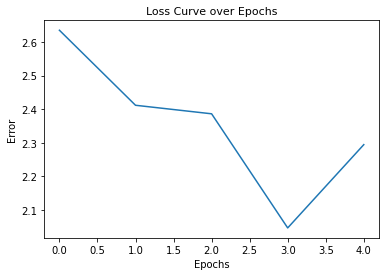

In [29]:
# Loss Curve (Validating) - VGG16:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

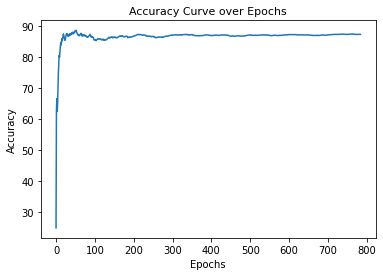

In [30]:
# Accuracy Curve (Validating) - VGG16

plt.plot(accuracies1)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### VGG16 - Testing 


Initiating Testing!

Testing on a sample batch, the predicted labels are:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


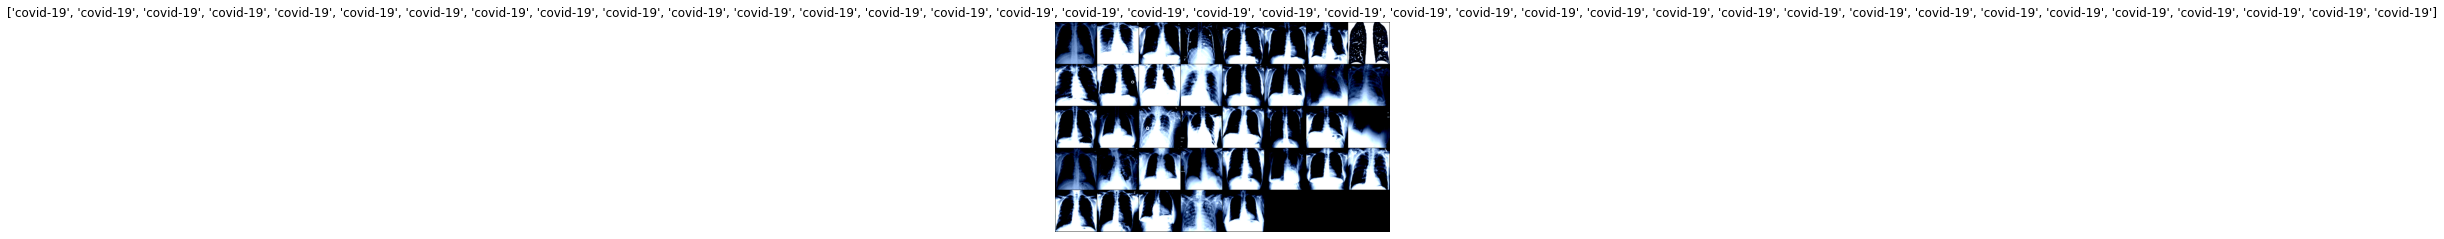

Predicted:  normal normal normal pneumonia normal normal normal covid-19 pneumonia normal normal pneumonia normal normal pneumonia pneumonia normal normal pneumonia pneumonia normal normal normal pneumonia normal pneumonia normal normal normal normal normal normal normal normal normal pneumonia normal

Prediction 0 :  tensor([[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [ True, False,  True],
        [ True, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False]

In [31]:
confusion_matrix = torch.zeros(3, 3)          # 3 represents number of classes.

print("\nInitiating Testing!")

print("\nTesting on a sample batch, the predicted labels are:\n")

dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

images = images.to(device)                    #--> convert test image to cuda (if available)
outputs = vgg16(images)                       #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

correct = 0
total = 0
counter = 0
threshold = 0.5

accuracies = []

import pandas as pd

px = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = torch.sigmoid(vgg16(images))
        outputs = outputs > threshold
        predicted = outputs
        #_, predicted = torch.max(outputs.data, 1)
        print("\nPrediction", counter, ": ", predicted)
        counter = counter + 1
        pxx = predicted.cpu().numpy()
        px = px.append(pd.DataFrame(pxx))

        # You can uncomment the following commented lines of code to compute the Final Accuracy, Confusion Matrix and F1 Score for these predictions.

        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
        #tempaccuracy = 100 * (correct / total)
        #accuracies.append(tempaccuracy)

        #for i, j in zip(labels.view(-1), predicted.view(-1)):
        #        confusion_matrix[i, j] = confusion_matrix[i, j] + 1


#print('\nFinal Accuracy of the network on the test images: %d %%' % (
#    100 * correct / total))

# Confusion matrix
#print('\nConfusion Matrix of the network on the test images: \n', confusion_matrix)

# F1 Score
#tp = int(confusion_matrix[0, 0])
#fn = int(confusion_matrix[0, 1])
#fp = int(confusion_matrix[1, 0])
#tn = int(confusion_matrix[1, 1])

#precision = tp / (tp + fp)
#recall = tp / (tp + fn)

#f1score = round(100 * (2 * (recall * precision) / (recall + precision)), 2)

#print('\nF1 Score of the network on the test images: \n', f1score)

print('\nFinished Testing!')

In [32]:
# Saving Results of VGG16 to CSV (BCELogitsLoss):

px.rename(columns = {0:'Covid-19', 1:'Pneumonia', 2:'Normal'}, inplace = True)

px["Covid-19"] = px["Covid-19"].astype(int)
px["Pneumonia"] = px["Pneumonia"].astype(int)
px["Normal"] = px["Normal"].astype(int)

px.reset_index(inplace=True)
px.reset_index(inplace=True)

del px["index"]

px.rename(columns = {'level_0':'Image Name'}, inplace = True)

px.to_csv('/content/gdrive/My Drive/Results1.csv', index = False, header = False)

px

# Sanity Checks:

#print(px.iloc[[17]])

,Image Name,Covid-19,Pneumonia,Normal
0,0,0,1,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,1
4,4,0,1,0
...,...,...,...,...
624,624,0,1,0
625,625,0,0,1
626,626,0,0,1
627,627,0,1,0


### B) RESNET18

In [0]:
# Freezing the layers:

def freezeresnet18(layernum): # works for 2, extend for more? - Done.
    if layernum != 1:
        i = 0
        for param in resnet18.parameters():
            i = i + 1
        layersizeuf = i - layernum 

        j = 0
        for param in resnet18.parameters():
            if layersizeuf > j:
                param.require_grad = False                        
            j = j + 1   
            
    if layernum == 1:
        for param in resnet18.parameters():
            param.require_grad = False
            
    
Epochs = int(input("\nEnter number of epochs: ")) #10

learningrate = float(input("\nEnter learning rate: ")) #0.001

lossfunc = int(input("\nChoose the Loss Function that you want to utilize - '1' for BCEWithLogitsLoss or '2' for Focal Loss: "))  

if (lossfunc == 1):
  criterion = nn.BCEWithLogitsLoss()
elif (lossfunc == 2):
  criterion = nn.FocalLoss()
else:
  criterion = nn.CrossEntropyLoss()

freezeask = input("\nDo you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: ")  

if (freezeask == "Yes"):
  layernum = int(input("\nEnter number of layers to freeze (1 to freeze all layers, other than 1 for exception of freezing layers): "))
  freezeresnet18(layernum)
else:
  pass


resnet18.fc = nn.Linear(512, 3)

num_features = resnet18.fc.in_features

features = []

features.extend([nn.Linear(num_features, 340)])       # (34 * 10) + 100
features.extend([nn.Linear(340, len(class_names))])   # (34 * 10) + 100

resnet18.classifier = nn.Sequential(*features)

#optimizer = optim.SGD(resnet18.parameters(), lr = learningrate, momentum = 0.9)
optimizer = optim.Adam(resnet18.parameters(), lr = learningrate)


Enter number of epochs: 2

Enter learning rate: 0.0001

Choose the Loss Function that you want to utilize - '1' for BCEWithLogitsLoss or '2' for Focal Loss: 1

Do you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: No


### RESNET18 - Training 

In [0]:
#confusion_matrix = torch.zeros(3, 3)          # 3 represents number of classes.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

correct = 0
total = 0

accuracies = []

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    resnet18.train()

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        ohelabels = nn.functional.one_hot(labels, num_classes = 3)
        print("\nNormal Label: ", labels, "\nOne Hot Label: ", ohelabels)

        optimizer.zero_grad()

        outputs = resnet18(inputs)                     #----> forward pass
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, ohelabels.float())   #----> compute loss
        loss.backward()                                #----> backward pass
        optimizer.step()                               #----> weights update

        running_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies.append(tempaccuracy)
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
        finalcm = multilabel_confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy())
        finalfs = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average = 'micro')

    errors.append(loss.item())

    if(lossfunc == 1):
        modelpath = "/content/gdrive/My Drive/resnet18_wo_focal_loss.pth" 
        torch.save(resnet18.state_dict(), modelpath)
    elif(lossfunc == 2):  
        modelpath = "/content/gdrive/My Drive/resnet18_focal_loss.pth" 
        torch.save(resnet18.state_dict(), modelpath)
    else:
        modelpath = "/content/gdrive/My Drive/resnet18_cross_entropy.pth" 
        torch.save(resnet18.state_dict(), modelpath)


print('\nFinal Accuracy of the network on the Train Images: %d %%' % (
    100 * correct / total))

# Confusion matrix
print('\nConfusion Matrix of the network on the test images: \n', finalcm)

# F1 Score
print('\nF1 Score of the network on the test images: \n', finalfs)

print('\nFinished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.862409: : 0it [00:08, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.862409: : 1it [00:08,  8.30s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [16/6200 (0%)]	Loss: 0.778342: : 1it [00:16,  8.30s/it]
Train Epoch: 0 [16/6200 (0%)]	Loss: 0.778342: : 2it [00:16,  8.32s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [32/6200 (1%)]	Loss: 0.829508: : 2it [00:25,  8.32s/it]
Train Epoch: 0 [32/6200 (1%)]	Loss: 0.829508: : 3it [00:25,  8.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [48/6200 (1%)]	Loss: 0.846208: : 3it [00:33,  8.39s/it]
Train Epoch: 0 [48/6200 (1%)]	Loss: 0.846208: : 4it [00:33,  8.34s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [64/6200 (1%)]	Loss: 0.758057: : 4it [00:41,  8.34s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.758057: : 5it [00:41,  8.20s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [80/6200 (1%)]	Loss: 0.675365: : 5it [00:49,  8.20s/it]
Train Epoch: 0 [80/6200 (1%)]	Loss: 0.675365: : 6it [00:49,  8.10s/it]


Normal Label:  tensor([1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [96/6200 (2%)]	Loss: 0.672653: : 6it [00:57,  8.10s/it]
Train Epoch: 0 [96/6200 (2%)]	Loss: 0.672653: : 7it [00:57,  8.09s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [112/6200 (2%)]	Loss: 0.633955: : 7it [01:05,  8.09s/it]
Train Epoch: 0 [112/6200 (2%)]	Loss: 0.633955: : 8it [01:05,  8.09s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [128/6200 (2%)]	Loss: 0.569068: : 8it [01:13,  8.09s/it]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.569068: : 9it [01:13,  8.07s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [144/6200 (2%)]	Loss: 0.615074: : 9it [01:21,  8.07s/it]
Train Epoch: 0 [144/6200 (2%)]	Loss: 0.615074: : 10it [01:21,  8.07s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [160/6200 (3%)]	Loss: 0.512010: : 10it [01:29,  8.07s/it]
Train Epoch: 0 [160/6200 (3%)]	Loss: 0.512010: : 11it [01:29,  7.98s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [176/6200 (3%)]	Loss: 0.707094: : 11it [01:37,  7.98s/it]
Train Epoch: 0 [176/6200 (3%)]	Loss: 0.707094: : 12it [01:37,  7.95s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [192/6200 (3%)]	Loss: 0.584248: : 12it [01:45,  7.95s/it]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.584248: : 13it [01:45,  8.23s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [208/6200 (3%)]	Loss: 0.478552: : 13it [01:54,  8.23s/it]
Train Epoch: 0 [208/6200 (3%)]	Loss: 0.478552: : 14it [01:54,  8.18s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [224/6200 (4%)]	Loss: 0.503358: : 14it [02:02,  8.18s/it]
Train Epoch: 0 [224/6200 (4%)]	Loss: 0.503358: : 15it [02:02,  8.12s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [240/6200 (4%)]	Loss: 0.451956: : 15it [02:10,  8.12s/it]
Train Epoch: 0 [240/6200 (4%)]	Loss: 0.451956: : 16it [02:10,  8.09s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [256/6200 (4%)]	Loss: 0.423719: : 16it [02:18,  8.09s/it]
Train Epoch: 0 [256/6200 (4%)]	Loss: 0.423719: : 17it [02:18,  8.13s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [272/6200 (4%)]	Loss: 0.629193: : 17it [02:26,  8.13s/it]
Train Epoch: 0 [272/6200 (4%)]	Loss: 0.629193: : 18it [02:26,  8.31s/it]


Normal Label:  tensor([2, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [288/6200 (5%)]	Loss: 0.473250: : 18it [02:35,  8.31s/it]
Train Epoch: 0 [288/6200 (5%)]	Loss: 0.473250: : 19it [02:35,  8.36s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [304/6200 (5%)]	Loss: 0.409731: : 19it [02:43,  8.36s/it]
Train Epoch: 0 [304/6200 (5%)]	Loss: 0.409731: : 20it [02:43,  8.23s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [320/6200 (5%)]	Loss: 0.481405: : 20it [02:51,  8.23s/it]
Train Epoch: 0 [320/6200 (5%)]	Loss: 0.481405: : 21it [02:51,  8.05s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [336/6200 (5%)]	Loss: 0.500110: : 21it [02:58,  8.05s/it]
Train Epoch: 0 [336/6200 (5%)]	Loss: 0.500110: : 22it [02:58,  7.93s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [352/6200 (6%)]	Loss: 0.386969: : 22it [03:06,  7.93s/it]
Train Epoch: 0 [352/6200 (6%)]	Loss: 0.386969: : 23it [03:06,  7.95s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [368/6200 (6%)]	Loss: 0.614970: : 23it [03:14,  7.95s/it]
Train Epoch: 0 [368/6200 (6%)]	Loss: 0.614970: : 24it [03:14,  7.90s/it]


Normal Label:  tensor([1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [384/6200 (6%)]	Loss: 0.403839: : 24it [03:22,  7.90s/it]
Train Epoch: 0 [384/6200 (6%)]	Loss: 0.403839: : 25it [03:22,  7.99s/it]


Normal Label:  tensor([0, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [400/6200 (6%)]	Loss: 0.464613: : 25it [03:30,  7.99s/it]
Train Epoch: 0 [400/6200 (6%)]	Loss: 0.464613: : 26it [03:30,  8.02s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [416/6200 (7%)]	Loss: 0.457569: : 26it [03:41,  8.02s/it]
Train Epoch: 0 [416/6200 (7%)]	Loss: 0.457569: : 27it [03:41,  8.95s/it]


Normal Label:  tensor([0, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [432/6200 (7%)]	Loss: 0.362380: : 27it [03:50,  8.95s/it]
Train Epoch: 0 [432/6200 (7%)]	Loss: 0.362380: : 28it [03:50,  8.76s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [448/6200 (7%)]	Loss: 0.729825: : 28it [03:58,  8.76s/it]
Train Epoch: 0 [448/6200 (7%)]	Loss: 0.729825: : 29it [03:58,  8.49s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [464/6200 (7%)]	Loss: 0.565740: : 29it [04:05,  8.49s/it]
Train Epoch: 0 [464/6200 (7%)]	Loss: 0.565740: : 30it [04:05,  8.30s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [480/6200 (8%)]	Loss: 0.457389: : 30it [04:14,  8.30s/it]
Train Epoch: 0 [480/6200 (8%)]	Loss: 0.457389: : 31it [04:14,  8.30s/it]


Normal Label:  tensor([1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [496/6200 (8%)]	Loss: 0.337199: : 31it [04:21,  8.30s/it]
Train Epoch: 0 [496/6200 (8%)]	Loss: 0.337199: : 32it [04:21,  8.15s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [512/6200 (8%)]	Loss: 0.277515: : 32it [04:29,  8.15s/it]
Train Epoch: 0 [512/6200 (8%)]	Loss: 0.277515: : 33it [04:29,  8.02s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [528/6200 (9%)]	Loss: 0.358138: : 33it [04:37,  8.02s/it]
Train Epoch: 0 [528/6200 (9%)]	Loss: 0.358138: : 34it [04:37,  7.98s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [544/6200 (9%)]	Loss: 0.293147: : 34it [04:45,  7.98s/it]
Train Epoch: 0 [544/6200 (9%)]	Loss: 0.293147: : 35it [04:45,  7.92s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [560/6200 (9%)]	Loss: 0.445667: : 35it [04:53,  7.92s/it]
Train Epoch: 0 [560/6200 (9%)]	Loss: 0.445667: : 36it [04:53,  7.88s/it]


Normal Label:  tensor([2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [576/6200 (9%)]	Loss: 0.374893: : 36it [05:04,  7.88s/it]
Train Epoch: 0 [576/6200 (9%)]	Loss: 0.374893: : 37it [05:04,  8.78s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [592/6200 (10%)]	Loss: 0.456156: : 37it [05:14,  8.78s/it]
Train Epoch: 0 [592/6200 (10%)]	Loss: 0.456156: : 38it [05:14,  9.35s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [608/6200 (10%)]	Loss: 0.432587: : 38it [05:23,  9.35s/it]
Train Epoch: 0 [608/6200 (10%)]	Loss: 0.432587: : 39it [05:23,  9.11s/it]


Normal Label:  tensor([0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [624/6200 (10%)]	Loss: 0.374407: : 39it [05:32,  9.11s/it]
Train Epoch: 0 [624/6200 (10%)]	Loss: 0.374407: : 40it [05:32,  9.27s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [640/6200 (10%)]	Loss: 0.389035: : 40it [05:41,  9.27s/it]
Train Epoch: 0 [640/6200 (10%)]	Loss: 0.389035: : 41it [05:41,  8.93s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [656/6200 (11%)]	Loss: 0.466411: : 41it [05:48,  8.93s/it]
Train Epoch: 0 [656/6200 (11%)]	Loss: 0.466411: : 42it [05:48,  8.62s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [672/6200 (11%)]	Loss: 0.467733: : 42it [05:57,  8.62s/it]
Train Epoch: 0 [672/6200 (11%)]	Loss: 0.467733: : 43it [05:57,  8.49s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [688/6200 (11%)]	Loss: 0.264485: : 43it [06:05,  8.49s/it]
Train Epoch: 0 [688/6200 (11%)]	Loss: 0.264485: : 44it [06:05,  8.30s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [704/6200 (11%)]	Loss: 0.301926: : 44it [06:14,  8.30s/it]
Train Epoch: 0 [704/6200 (11%)]	Loss: 0.301926: : 45it [06:14,  8.66s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [720/6200 (12%)]	Loss: 0.363416: : 45it [06:22,  8.66s/it]
Train Epoch: 0 [720/6200 (12%)]	Loss: 0.363416: : 46it [06:22,  8.40s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [736/6200 (12%)]	Loss: 0.270168: : 46it [06:30,  8.40s/it]
Train Epoch: 0 [736/6200 (12%)]	Loss: 0.270168: : 47it [06:30,  8.36s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [752/6200 (12%)]	Loss: 0.282024: : 47it [06:38,  8.36s/it]
Train Epoch: 0 [752/6200 (12%)]	Loss: 0.282024: : 48it [06:39,  8.38s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [768/6200 (12%)]	Loss: 0.237079: : 48it [06:46,  8.38s/it]
Train Epoch: 0 [768/6200 (12%)]	Loss: 0.237079: : 49it [06:46,  8.19s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [784/6200 (13%)]	Loss: 0.202697: : 49it [06:54,  8.19s/it]
Train Epoch: 0 [784/6200 (13%)]	Loss: 0.202697: : 50it [06:54,  8.10s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [800/6200 (13%)]	Loss: 0.238011: : 50it [07:02,  8.10s/it]
Train Epoch: 0 [800/6200 (13%)]	Loss: 0.238011: : 51it [07:02,  8.04s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [816/6200 (13%)]	Loss: 0.224449: : 51it [07:10,  8.04s/it]
Train Epoch: 0 [816/6200 (13%)]	Loss: 0.224449: : 52it [07:10,  7.93s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [832/6200 (13%)]	Loss: 0.357602: : 52it [07:17,  7.93s/it]
Train Epoch: 0 [832/6200 (13%)]	Loss: 0.357602: : 53it [07:17,  7.87s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [848/6200 (14%)]	Loss: 0.503536: : 53it [07:26,  7.87s/it]
Train Epoch: 0 [848/6200 (14%)]	Loss: 0.503536: : 54it [07:26,  8.02s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [864/6200 (14%)]	Loss: 0.164754: : 54it [07:34,  8.02s/it]
Train Epoch: 0 [864/6200 (14%)]	Loss: 0.164754: : 55it [07:34,  8.11s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [880/6200 (14%)]	Loss: 0.285996: : 55it [07:42,  8.11s/it]
Train Epoch: 0 [880/6200 (14%)]	Loss: 0.285996: : 56it [07:42,  8.10s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [896/6200 (14%)]	Loss: 0.449125: : 56it [07:50,  8.10s/it]
Train Epoch: 0 [896/6200 (14%)]	Loss: 0.449125: : 57it [07:50,  8.15s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [912/6200 (15%)]	Loss: 0.220046: : 57it [07:58,  8.15s/it]
Train Epoch: 0 [912/6200 (15%)]	Loss: 0.220046: : 58it [07:58,  8.00s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [928/6200 (15%)]	Loss: 0.420236: : 58it [08:06,  8.00s/it]
Train Epoch: 0 [928/6200 (15%)]	Loss: 0.420236: : 59it [08:06,  8.06s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [944/6200 (15%)]	Loss: 0.225621: : 59it [08:15,  8.06s/it]
Train Epoch: 0 [944/6200 (15%)]	Loss: 0.225621: : 60it [08:15,  8.14s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [960/6200 (15%)]	Loss: 0.170371: : 60it [08:22,  8.14s/it]
Train Epoch: 0 [960/6200 (15%)]	Loss: 0.170371: : 61it [08:22,  7.94s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [976/6200 (16%)]	Loss: 0.417529: : 61it [08:29,  7.94s/it]
Train Epoch: 0 [976/6200 (16%)]	Loss: 0.417529: : 62it [08:29,  7.71s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [992/6200 (16%)]	Loss: 0.265013: : 62it [08:37,  7.71s/it]
Train Epoch: 0 [992/6200 (16%)]	Loss: 0.265013: : 63it [08:37,  7.76s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1008/6200 (16%)]	Loss: 0.210668: : 63it [08:45,  7.76s/it]
Train Epoch: 0 [1008/6200 (16%)]	Loss: 0.210668: : 64it [08:45,  7.85s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.260105: : 64it [08:53,  7.85s/it]
Train Epoch: 0 [1024/6200 (16%)]	Loss: 0.260105: : 65it [08:53,  7.91s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1040/6200 (17%)]	Loss: 0.377338: : 65it [09:01,  7.91s/it]
Train Epoch: 0 [1040/6200 (17%)]	Loss: 0.377338: : 66it [09:01,  7.84s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1056/6200 (17%)]	Loss: 0.226916: : 66it [09:09,  7.84s/it]
Train Epoch: 0 [1056/6200 (17%)]	Loss: 0.226916: : 67it [09:09,  7.94s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1072/6200 (17%)]	Loss: 0.312995: : 67it [09:17,  7.94s/it]
Train Epoch: 0 [1072/6200 (17%)]	Loss: 0.312995: : 68it [09:17,  7.97s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.394587: : 68it [09:25,  7.97s/it]
Train Epoch: 0 [1088/6200 (18%)]	Loss: 0.394587: : 69it [09:25,  8.03s/it]


Normal Label:  tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1104/6200 (18%)]	Loss: 0.468260: : 69it [09:33,  8.03s/it]
Train Epoch: 0 [1104/6200 (18%)]	Loss: 0.468260: : 70it [09:33,  7.93s/it]


Normal Label:  tensor([1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1120/6200 (18%)]	Loss: 0.230588: : 70it [09:41,  7.93s/it]
Train Epoch: 0 [1120/6200 (18%)]	Loss: 0.230588: : 71it [09:41,  7.94s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1136/6200 (18%)]	Loss: 0.334905: : 71it [09:49,  7.94s/it]
Train Epoch: 0 [1136/6200 (18%)]	Loss: 0.334905: : 72it [09:49,  7.82s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.170398: : 72it [09:56,  7.82s/it]
Train Epoch: 0 [1152/6200 (19%)]	Loss: 0.170398: : 73it [09:56,  7.82s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1168/6200 (19%)]	Loss: 0.176458: : 73it [10:04,  7.82s/it]
Train Epoch: 0 [1168/6200 (19%)]	Loss: 0.176458: : 74it [10:04,  7.85s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1184/6200 (19%)]	Loss: 0.197507: : 74it [10:12,  7.85s/it]
Train Epoch: 0 [1184/6200 (19%)]	Loss: 0.197507: : 75it [10:12,  7.92s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1200/6200 (19%)]	Loss: 0.471719: : 75it [10:20,  7.92s/it]
Train Epoch: 0 [1200/6200 (19%)]	Loss: 0.471719: : 76it [10:20,  7.84s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.276713: : 76it [10:29,  7.84s/it]
Train Epoch: 0 [1216/6200 (20%)]	Loss: 0.276713: : 77it [10:29,  8.08s/it]


Normal Label:  tensor([1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1232/6200 (20%)]	Loss: 0.155251: : 77it [10:36,  8.08s/it]
Train Epoch: 0 [1232/6200 (20%)]	Loss: 0.155251: : 78it [10:36,  7.97s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1248/6200 (20%)]	Loss: 0.170910: : 78it [10:44,  7.97s/it]
Train Epoch: 0 [1248/6200 (20%)]	Loss: 0.170910: : 79it [10:44,  7.92s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1264/6200 (20%)]	Loss: 0.114413: : 79it [10:53,  7.92s/it]
Train Epoch: 0 [1264/6200 (20%)]	Loss: 0.114413: : 80it [10:53,  8.14s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.338288: : 80it [11:01,  8.14s/it]
Train Epoch: 0 [1280/6200 (21%)]	Loss: 0.338288: : 81it [11:01,  8.09s/it]


Normal Label:  tensor([0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1296/6200 (21%)]	Loss: 0.409641: : 81it [11:09,  8.09s/it]
Train Epoch: 0 [1296/6200 (21%)]	Loss: 0.409641: : 82it [11:09,  8.09s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1312/6200 (21%)]	Loss: 0.165013: : 82it [11:17,  8.09s/it]
Train Epoch: 0 [1312/6200 (21%)]	Loss: 0.165013: : 83it [11:17,  8.14s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1328/6200 (21%)]	Loss: 0.205862: : 83it [11:25,  8.14s/it]
Train Epoch: 0 [1328/6200 (21%)]	Loss: 0.205862: : 84it [11:25,  8.05s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.264841: : 84it [11:36,  8.05s/it]
Train Epoch: 0 [1344/6200 (22%)]	Loss: 0.264841: : 85it [11:36,  8.89s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1360/6200 (22%)]	Loss: 0.229597: : 85it [11:44,  8.89s/it]
Train Epoch: 0 [1360/6200 (22%)]	Loss: 0.229597: : 86it [11:44,  8.55s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1376/6200 (22%)]	Loss: 0.316908: : 86it [11:52,  8.55s/it]
Train Epoch: 0 [1376/6200 (22%)]	Loss: 0.316908: : 87it [11:52,  8.52s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1392/6200 (22%)]	Loss: 0.476036: : 87it [12:00,  8.52s/it]
Train Epoch: 0 [1392/6200 (22%)]	Loss: 0.476036: : 88it [12:00,  8.40s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.277895: : 88it [12:08,  8.40s/it]
Train Epoch: 0 [1408/6200 (23%)]	Loss: 0.277895: : 89it [12:08,  8.25s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1424/6200 (23%)]	Loss: 0.154897: : 89it [12:15,  8.25s/it]
Train Epoch: 0 [1424/6200 (23%)]	Loss: 0.154897: : 90it [12:15,  7.99s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1440/6200 (23%)]	Loss: 0.161206: : 90it [12:29,  7.99s/it]
Train Epoch: 0 [1440/6200 (23%)]	Loss: 0.161206: : 91it [12:29,  9.70s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1456/6200 (23%)]	Loss: 0.200160: : 91it [12:37,  9.70s/it]
Train Epoch: 0 [1456/6200 (23%)]	Loss: 0.200160: : 92it [12:37,  9.26s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.140842: : 92it [12:46,  9.26s/it]
Train Epoch: 0 [1472/6200 (24%)]	Loss: 0.140842: : 93it [12:46,  9.04s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1488/6200 (24%)]	Loss: 0.248182: : 93it [12:54,  9.04s/it]
Train Epoch: 0 [1488/6200 (24%)]	Loss: 0.248182: : 94it [12:54,  8.80s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1504/6200 (24%)]	Loss: 0.175131: : 94it [13:02,  8.80s/it]
Train Epoch: 0 [1504/6200 (24%)]	Loss: 0.175131: : 95it [13:02,  8.66s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1520/6200 (24%)]	Loss: 0.472799: : 95it [13:10,  8.66s/it]
Train Epoch: 0 [1520/6200 (24%)]	Loss: 0.472799: : 96it [13:10,  8.27s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.237951: : 96it [13:18,  8.27s/it]
Train Epoch: 0 [1536/6200 (25%)]	Loss: 0.237951: : 97it [13:18,  8.17s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [1552/6200 (25%)]	Loss: 0.233092: : 97it [13:26,  8.17s/it]
Train Epoch: 0 [1552/6200 (25%)]	Loss: 0.233092: : 98it [13:26,  8.09s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1568/6200 (25%)]	Loss: 0.435448: : 98it [13:34,  8.09s/it]
Train Epoch: 0 [1568/6200 (25%)]	Loss: 0.435448: : 99it [13:34,  8.10s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1584/6200 (26%)]	Loss: 0.216991: : 99it [13:42,  8.10s/it]
Train Epoch: 0 [1584/6200 (26%)]	Loss: 0.216991: : 100it [13:42,  8.00s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.276410: : 100it [13:49,  8.00s/it]
Train Epoch: 0 [1600/6200 (26%)]	Loss: 0.276410: : 101it [13:49,  7.97s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1616/6200 (26%)]	Loss: 0.364068: : 101it [13:58,  7.97s/it]
Train Epoch: 0 [1616/6200 (26%)]	Loss: 0.364068: : 102it [13:58,  8.01s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1632/6200 (26%)]	Loss: 0.210197: : 102it [14:05,  8.01s/it]
Train Epoch: 0 [1632/6200 (26%)]	Loss: 0.210197: : 103it [14:05,  7.95s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1648/6200 (27%)]	Loss: 0.134790: : 103it [14:13,  7.95s/it]
Train Epoch: 0 [1648/6200 (27%)]	Loss: 0.134790: : 104it [14:13,  7.88s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.132561: : 104it [14:21,  7.88s/it]
Train Epoch: 0 [1664/6200 (27%)]	Loss: 0.132561: : 105it [14:21,  7.83s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1680/6200 (27%)]	Loss: 0.235306: : 105it [14:28,  7.83s/it]
Train Epoch: 0 [1680/6200 (27%)]	Loss: 0.235306: : 106it [14:28,  7.68s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1696/6200 (27%)]	Loss: 0.337834: : 106it [14:37,  7.68s/it]
Train Epoch: 0 [1696/6200 (27%)]	Loss: 0.337834: : 107it [14:37,  7.91s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1712/6200 (28%)]	Loss: 0.273325: : 107it [14:49,  7.91s/it]
Train Epoch: 0 [1712/6200 (28%)]	Loss: 0.273325: : 108it [14:49,  9.26s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.294559: : 108it [15:00,  9.26s/it]
Train Epoch: 0 [1728/6200 (28%)]	Loss: 0.294559: : 109it [15:00,  9.89s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1744/6200 (28%)]	Loss: 0.336593: : 109it [15:08,  9.89s/it]
Train Epoch: 0 [1744/6200 (28%)]	Loss: 0.336593: : 110it [15:08,  9.35s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1760/6200 (28%)]	Loss: 0.108948: : 110it [15:16,  9.35s/it]
Train Epoch: 0 [1760/6200 (28%)]	Loss: 0.108948: : 111it [15:16,  8.86s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1776/6200 (29%)]	Loss: 0.080641: : 111it [15:24,  8.86s/it]
Train Epoch: 0 [1776/6200 (29%)]	Loss: 0.080641: : 112it [15:24,  8.56s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.285049: : 112it [15:33,  8.56s/it]
Train Epoch: 0 [1792/6200 (29%)]	Loss: 0.285049: : 113it [15:33,  8.67s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1808/6200 (29%)]	Loss: 0.167193: : 113it [15:49,  8.67s/it]
Train Epoch: 0 [1808/6200 (29%)]	Loss: 0.167193: : 114it [15:49, 10.75s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1824/6200 (29%)]	Loss: 0.414579: : 114it [16:04, 10.75s/it]
Train Epoch: 0 [1824/6200 (29%)]	Loss: 0.414579: : 115it [16:04, 12.10s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1840/6200 (30%)]	Loss: 0.349311: : 115it [16:14, 12.10s/it]
Train Epoch: 0 [1840/6200 (30%)]	Loss: 0.349311: : 116it [16:14, 11.46s/it]


Normal Label:  tensor([1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.404553: : 116it [16:24, 11.46s/it]
Train Epoch: 0 [1856/6200 (30%)]	Loss: 0.404553: : 117it [16:24, 11.04s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1872/6200 (30%)]	Loss: 0.212602: : 117it [16:32, 11.04s/it]
Train Epoch: 0 [1872/6200 (30%)]	Loss: 0.212602: : 118it [16:32, 10.14s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1888/6200 (30%)]	Loss: 0.130436: : 118it [16:40, 10.14s/it]
Train Epoch: 0 [1888/6200 (30%)]	Loss: 0.130436: : 119it [16:40,  9.56s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1904/6200 (31%)]	Loss: 0.221105: : 119it [16:48,  9.56s/it]
Train Epoch: 0 [1904/6200 (31%)]	Loss: 0.221105: : 120it [16:48,  9.03s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.238695: : 120it [16:56,  9.03s/it]
Train Epoch: 0 [1920/6200 (31%)]	Loss: 0.238695: : 121it [16:56,  8.66s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1936/6200 (31%)]	Loss: 0.311633: : 121it [17:07,  8.66s/it]
Train Epoch: 0 [1936/6200 (31%)]	Loss: 0.311633: : 122it [17:07,  9.38s/it]


Normal Label:  tensor([1, 2, 1, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [1952/6200 (31%)]	Loss: 0.154585: : 122it [17:16,  9.38s/it]
Train Epoch: 0 [1952/6200 (31%)]	Loss: 0.154585: : 123it [17:16,  9.27s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1968/6200 (32%)]	Loss: 0.180742: : 123it [17:24,  9.27s/it]
Train Epoch: 0 [1968/6200 (32%)]	Loss: 0.180742: : 124it [17:24,  8.87s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.121807: : 124it [17:32,  8.87s/it]
Train Epoch: 0 [1984/6200 (32%)]	Loss: 0.121807: : 125it [17:32,  8.64s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2000/6200 (32%)]	Loss: 0.242653: : 125it [17:41,  8.64s/it]
Train Epoch: 0 [2000/6200 (32%)]	Loss: 0.242653: : 126it [17:41,  8.85s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2016/6200 (32%)]	Loss: 0.443691: : 126it [17:49,  8.85s/it]
Train Epoch: 0 [2016/6200 (32%)]	Loss: 0.443691: : 127it [17:49,  8.59s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2032/6200 (33%)]	Loss: 0.275924: : 127it [17:57,  8.59s/it]
Train Epoch: 0 [2032/6200 (33%)]	Loss: 0.275924: : 128it [17:57,  8.43s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.217281: : 128it [18:05,  8.43s/it]
Train Epoch: 0 [2048/6200 (33%)]	Loss: 0.217281: : 129it [18:05,  8.29s/it]


Normal Label:  tensor([1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2064/6200 (33%)]	Loss: 0.220685: : 129it [18:13,  8.29s/it]
Train Epoch: 0 [2064/6200 (33%)]	Loss: 0.220685: : 130it [18:13,  8.18s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2080/6200 (34%)]	Loss: 0.216580: : 130it [18:21,  8.18s/it]
Train Epoch: 0 [2080/6200 (34%)]	Loss: 0.216580: : 131it [18:21,  7.99s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2096/6200 (34%)]	Loss: 0.239779: : 131it [18:28,  7.99s/it]
Train Epoch: 0 [2096/6200 (34%)]	Loss: 0.239779: : 132it [18:28,  7.77s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.137342: : 132it [18:36,  7.77s/it]
Train Epoch: 0 [2112/6200 (34%)]	Loss: 0.137342: : 133it [18:36,  7.89s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2128/6200 (34%)]	Loss: 0.119942: : 133it [18:44,  7.89s/it]
Train Epoch: 0 [2128/6200 (34%)]	Loss: 0.119942: : 134it [18:44,  8.01s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2144/6200 (35%)]	Loss: 0.270410: : 134it [18:53,  8.01s/it]
Train Epoch: 0 [2144/6200 (35%)]	Loss: 0.270410: : 135it [18:53,  8.17s/it]


Normal Label:  tensor([2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2160/6200 (35%)]	Loss: 0.201357: : 135it [19:01,  8.17s/it]
Train Epoch: 0 [2160/6200 (35%)]	Loss: 0.201357: : 136it [19:01,  8.12s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.194783: : 136it [19:08,  8.12s/it]
Train Epoch: 0 [2176/6200 (35%)]	Loss: 0.194783: : 137it [19:08,  7.94s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2192/6200 (35%)]	Loss: 0.441253: : 137it [19:16,  7.94s/it]
Train Epoch: 0 [2192/6200 (35%)]	Loss: 0.441253: : 138it [19:16,  7.92s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2208/6200 (36%)]	Loss: 0.274095: : 138it [19:24,  7.92s/it]
Train Epoch: 0 [2208/6200 (36%)]	Loss: 0.274095: : 139it [19:24,  7.82s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2224/6200 (36%)]	Loss: 0.185195: : 139it [19:32,  7.82s/it]
Train Epoch: 0 [2224/6200 (36%)]	Loss: 0.185195: : 140it [19:32,  7.96s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.342838: : 140it [19:42,  7.96s/it]
Train Epoch: 0 [2240/6200 (36%)]	Loss: 0.342838: : 141it [19:42,  8.48s/it]


Normal Label:  tensor([1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2256/6200 (36%)]	Loss: 0.107429: : 141it [19:51,  8.48s/it]
Train Epoch: 0 [2256/6200 (36%)]	Loss: 0.107429: : 142it [19:51,  8.71s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2272/6200 (37%)]	Loss: 0.261383: : 142it [19:59,  8.71s/it]
Train Epoch: 0 [2272/6200 (37%)]	Loss: 0.261383: : 143it [19:59,  8.48s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [2288/6200 (37%)]	Loss: 0.141999: : 143it [20:07,  8.48s/it]
Train Epoch: 0 [2288/6200 (37%)]	Loss: 0.141999: : 144it [20:07,  8.24s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.222827: : 144it [20:14,  8.24s/it]
Train Epoch: 0 [2304/6200 (37%)]	Loss: 0.222827: : 145it [20:14,  8.08s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2320/6200 (37%)]	Loss: 0.331835: : 145it [20:22,  8.08s/it]
Train Epoch: 0 [2320/6200 (37%)]	Loss: 0.331835: : 146it [20:22,  7.96s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2336/6200 (38%)]	Loss: 0.328839: : 146it [20:30,  7.96s/it]
Train Epoch: 0 [2336/6200 (38%)]	Loss: 0.328839: : 147it [20:30,  7.87s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2352/6200 (38%)]	Loss: 0.396814: : 147it [20:38,  7.87s/it]
Train Epoch: 0 [2352/6200 (38%)]	Loss: 0.396814: : 148it [20:38,  7.98s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.359353: : 148it [20:46,  7.98s/it]
Train Epoch: 0 [2368/6200 (38%)]	Loss: 0.359353: : 149it [20:46,  8.07s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2384/6200 (38%)]	Loss: 0.249969: : 149it [20:57,  8.07s/it]
Train Epoch: 0 [2384/6200 (38%)]	Loss: 0.249969: : 150it [20:57,  8.78s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2400/6200 (39%)]	Loss: 0.298901: : 150it [21:06,  8.78s/it]
Train Epoch: 0 [2400/6200 (39%)]	Loss: 0.298901: : 151it [21:06,  8.98s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2416/6200 (39%)]	Loss: 0.292552: : 151it [21:15,  8.98s/it]
Train Epoch: 0 [2416/6200 (39%)]	Loss: 0.292552: : 152it [21:15,  8.88s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.200541: : 152it [21:23,  8.88s/it]
Train Epoch: 0 [2432/6200 (39%)]	Loss: 0.200541: : 153it [21:23,  8.57s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2448/6200 (39%)]	Loss: 0.196371: : 153it [21:31,  8.57s/it]
Train Epoch: 0 [2448/6200 (39%)]	Loss: 0.196371: : 154it [21:31,  8.41s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2464/6200 (40%)]	Loss: 0.425487: : 154it [21:39,  8.41s/it]
Train Epoch: 0 [2464/6200 (40%)]	Loss: 0.425487: : 155it [21:39,  8.28s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2480/6200 (40%)]	Loss: 0.196147: : 155it [21:47,  8.28s/it]
Train Epoch: 0 [2480/6200 (40%)]	Loss: 0.196147: : 156it [21:47,  8.29s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.299065: : 156it [21:55,  8.29s/it]
Train Epoch: 0 [2496/6200 (40%)]	Loss: 0.299065: : 157it [21:55,  8.28s/it]


Normal Label:  tensor([2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2512/6200 (40%)]	Loss: 0.321545: : 157it [22:03,  8.28s/it]
Train Epoch: 0 [2512/6200 (40%)]	Loss: 0.321545: : 158it [22:03,  8.18s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2528/6200 (41%)]	Loss: 0.273338: : 158it [22:11,  8.18s/it]
Train Epoch: 0 [2528/6200 (41%)]	Loss: 0.273338: : 159it [22:11,  8.07s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2544/6200 (41%)]	Loss: 0.507533: : 159it [22:19,  8.07s/it]
Train Epoch: 0 [2544/6200 (41%)]	Loss: 0.507533: : 160it [22:19,  7.99s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.239718: : 160it [22:27,  7.99s/it]
Train Epoch: 0 [2560/6200 (41%)]	Loss: 0.239718: : 161it [22:27,  7.98s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2576/6200 (41%)]	Loss: 0.231232: : 161it [22:34,  7.98s/it]
Train Epoch: 0 [2576/6200 (41%)]	Loss: 0.231232: : 162it [22:34,  7.87s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2592/6200 (42%)]	Loss: 0.214086: : 162it [22:42,  7.87s/it]
Train Epoch: 0 [2592/6200 (42%)]	Loss: 0.214086: : 163it [22:42,  7.92s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2608/6200 (42%)]	Loss: 0.171299: : 163it [22:52,  7.92s/it]
Train Epoch: 0 [2608/6200 (42%)]	Loss: 0.171299: : 164it [22:52,  8.41s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.192476: : 164it [23:00,  8.41s/it]
Train Epoch: 0 [2624/6200 (42%)]	Loss: 0.192476: : 165it [23:00,  8.18s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2640/6200 (43%)]	Loss: 0.143411: : 165it [23:08,  8.18s/it]
Train Epoch: 0 [2640/6200 (43%)]	Loss: 0.143411: : 166it [23:08,  8.23s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2656/6200 (43%)]	Loss: 0.168097: : 166it [23:16,  8.23s/it]
Train Epoch: 0 [2656/6200 (43%)]	Loss: 0.168097: : 167it [23:16,  8.10s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2672/6200 (43%)]	Loss: 0.369048: : 167it [23:24,  8.10s/it]
Train Epoch: 0 [2672/6200 (43%)]	Loss: 0.369048: : 168it [23:24,  8.01s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.141105: : 168it [23:32,  8.01s/it]
Train Epoch: 0 [2688/6200 (43%)]	Loss: 0.141105: : 169it [23:32,  8.04s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2704/6200 (44%)]	Loss: 0.198896: : 169it [23:39,  8.04s/it]
Train Epoch: 0 [2704/6200 (44%)]	Loss: 0.198896: : 170it [23:39,  7.77s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2720/6200 (44%)]	Loss: 0.173429: : 170it [23:51,  7.77s/it]
Train Epoch: 0 [2720/6200 (44%)]	Loss: 0.173429: : 171it [23:51,  9.17s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2736/6200 (44%)]	Loss: 0.268227: : 171it [24:05,  9.17s/it]
Train Epoch: 0 [2736/6200 (44%)]	Loss: 0.268227: : 172it [24:05, 10.45s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.239665: : 172it [24:15, 10.45s/it]
Train Epoch: 0 [2752/6200 (44%)]	Loss: 0.239665: : 173it [24:15, 10.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2768/6200 (45%)]	Loss: 0.250404: : 173it [24:23, 10.34s/it]
Train Epoch: 0 [2768/6200 (45%)]	Loss: 0.250404: : 174it [24:23,  9.66s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2784/6200 (45%)]	Loss: 0.227526: : 174it [24:33,  9.66s/it]
Train Epoch: 0 [2784/6200 (45%)]	Loss: 0.227526: : 175it [24:33,  9.76s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2800/6200 (45%)]	Loss: 0.241214: : 175it [24:41,  9.76s/it]
Train Epoch: 0 [2800/6200 (45%)]	Loss: 0.241214: : 176it [24:41,  9.20s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.336282: : 176it [24:49,  9.20s/it]
Train Epoch: 0 [2816/6200 (45%)]	Loss: 0.336282: : 177it [24:49,  8.97s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2832/6200 (46%)]	Loss: 0.207386: : 177it [24:56,  8.97s/it]
Train Epoch: 0 [2832/6200 (46%)]	Loss: 0.207386: : 178it [24:56,  8.44s/it]


Normal Label:  tensor([1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2848/6200 (46%)]	Loss: 0.183403: : 178it [25:04,  8.44s/it]
Train Epoch: 0 [2848/6200 (46%)]	Loss: 0.183403: : 179it [25:04,  8.29s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2864/6200 (46%)]	Loss: 0.434629: : 179it [25:12,  8.29s/it]
Train Epoch: 0 [2864/6200 (46%)]	Loss: 0.434629: : 180it [25:12,  8.22s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.249400: : 180it [25:20,  8.22s/it]
Train Epoch: 0 [2880/6200 (46%)]	Loss: 0.249400: : 181it [25:20,  8.17s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2896/6200 (47%)]	Loss: 0.511031: : 181it [25:29,  8.17s/it]
Train Epoch: 0 [2896/6200 (47%)]	Loss: 0.511031: : 182it [25:29,  8.17s/it]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2912/6200 (47%)]	Loss: 0.166369: : 182it [25:37,  8.17s/it]
Train Epoch: 0 [2912/6200 (47%)]	Loss: 0.166369: : 183it [25:37,  8.17s/it]


Normal Label:  tensor([1, 2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2928/6200 (47%)]	Loss: 0.236238: : 183it [25:45,  8.17s/it]
Train Epoch: 0 [2928/6200 (47%)]	Loss: 0.236238: : 184it [25:45,  8.21s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.368055: : 184it [25:53,  8.21s/it]
Train Epoch: 0 [2944/6200 (47%)]	Loss: 0.368055: : 185it [25:53,  8.17s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [2960/6200 (48%)]	Loss: 0.177996: : 185it [26:01,  8.17s/it]
Train Epoch: 0 [2960/6200 (48%)]	Loss: 0.177996: : 186it [26:01,  8.03s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [2976/6200 (48%)]	Loss: 0.157261: : 186it [26:09,  8.03s/it]
Train Epoch: 0 [2976/6200 (48%)]	Loss: 0.157261: : 187it [26:09,  8.06s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [2992/6200 (48%)]	Loss: 0.364819: : 187it [26:18,  8.06s/it]
Train Epoch: 0 [2992/6200 (48%)]	Loss: 0.364819: : 188it [26:18,  8.38s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.376958: : 188it [26:27,  8.38s/it]
Train Epoch: 0 [3008/6200 (48%)]	Loss: 0.376958: : 189it [26:27,  8.46s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3024/6200 (49%)]	Loss: 0.132790: : 189it [26:35,  8.46s/it]
Train Epoch: 0 [3024/6200 (49%)]	Loss: 0.132790: : 190it [26:35,  8.41s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3040/6200 (49%)]	Loss: 0.139226: : 190it [26:43,  8.41s/it]
Train Epoch: 0 [3040/6200 (49%)]	Loss: 0.139226: : 191it [26:43,  8.32s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3056/6200 (49%)]	Loss: 0.167609: : 191it [26:51,  8.32s/it]
Train Epoch: 0 [3056/6200 (49%)]	Loss: 0.167609: : 192it [26:51,  8.16s/it]


Normal Label:  tensor([1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.098249: : 192it [26:59,  8.16s/it]
Train Epoch: 0 [3072/6200 (49%)]	Loss: 0.098249: : 193it [26:59,  8.13s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3088/6200 (50%)]	Loss: 0.430904: : 193it [27:07,  8.13s/it]
Train Epoch: 0 [3088/6200 (50%)]	Loss: 0.430904: : 194it [27:07,  8.07s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3104/6200 (50%)]	Loss: 0.194702: : 194it [27:16,  8.07s/it]
Train Epoch: 0 [3104/6200 (50%)]	Loss: 0.194702: : 195it [27:16,  8.24s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3120/6200 (50%)]	Loss: 0.316249: : 195it [27:24,  8.24s/it]
Train Epoch: 0 [3120/6200 (50%)]	Loss: 0.316249: : 196it [27:24,  8.42s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.261269: : 196it [27:34,  8.42s/it]
Train Epoch: 0 [3136/6200 (51%)]	Loss: 0.261269: : 197it [27:34,  8.89s/it]


Normal Label:  tensor([1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3152/6200 (51%)]	Loss: 0.286345: : 197it [27:44,  8.89s/it]
Train Epoch: 0 [3152/6200 (51%)]	Loss: 0.286345: : 198it [27:44,  9.09s/it]


Normal Label:  tensor([1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3168/6200 (51%)]	Loss: 0.164404: : 198it [27:52,  9.09s/it]
Train Epoch: 0 [3168/6200 (51%)]	Loss: 0.164404: : 199it [27:52,  8.78s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3184/6200 (51%)]	Loss: 0.097617: : 199it [28:00,  8.78s/it]
Train Epoch: 0 [3184/6200 (51%)]	Loss: 0.097617: : 200it [28:00,  8.52s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.201969: : 200it [28:08,  8.52s/it]
Train Epoch: 0 [3200/6200 (52%)]	Loss: 0.201969: : 201it [28:08,  8.29s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3216/6200 (52%)]	Loss: 0.187661: : 201it [28:16,  8.29s/it]
Train Epoch: 0 [3216/6200 (52%)]	Loss: 0.187661: : 202it [28:16,  8.22s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3232/6200 (52%)]	Loss: 0.486502: : 202it [28:24,  8.22s/it]
Train Epoch: 0 [3232/6200 (52%)]	Loss: 0.486502: : 203it [28:24,  8.18s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3248/6200 (52%)]	Loss: 0.382591: : 203it [28:32,  8.18s/it]
Train Epoch: 0 [3248/6200 (52%)]	Loss: 0.382591: : 204it [28:32,  8.07s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.220567: : 204it [28:40,  8.07s/it]
Train Epoch: 0 [3264/6200 (53%)]	Loss: 0.220567: : 205it [28:40,  8.05s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3280/6200 (53%)]	Loss: 0.184417: : 205it [28:48,  8.05s/it]
Train Epoch: 0 [3280/6200 (53%)]	Loss: 0.184417: : 206it [28:48,  8.20s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3296/6200 (53%)]	Loss: 0.306353: : 206it [28:56,  8.20s/it]
Train Epoch: 0 [3296/6200 (53%)]	Loss: 0.306353: : 207it [28:56,  8.17s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3312/6200 (53%)]	Loss: 0.224806: : 207it [29:04,  8.17s/it]
Train Epoch: 0 [3312/6200 (53%)]	Loss: 0.224806: : 208it [29:04,  8.19s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.376100: : 208it [29:13,  8.19s/it]
Train Epoch: 0 [3328/6200 (54%)]	Loss: 0.376100: : 209it [29:13,  8.17s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3344/6200 (54%)]	Loss: 0.113783: : 209it [29:21,  8.17s/it]
Train Epoch: 0 [3344/6200 (54%)]	Loss: 0.113783: : 210it [29:21,  8.25s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3360/6200 (54%)]	Loss: 0.222473: : 210it [29:30,  8.25s/it]
Train Epoch: 0 [3360/6200 (54%)]	Loss: 0.222473: : 211it [29:30,  8.39s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3376/6200 (54%)]	Loss: 0.180260: : 211it [29:38,  8.39s/it]
Train Epoch: 0 [3376/6200 (54%)]	Loss: 0.180260: : 212it [29:38,  8.27s/it]


Normal Label:  tensor([2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.199419: : 212it [29:46,  8.27s/it]
Train Epoch: 0 [3392/6200 (55%)]	Loss: 0.199419: : 213it [29:46,  8.39s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3408/6200 (55%)]	Loss: 0.089504: : 213it [29:54,  8.39s/it]
Train Epoch: 0 [3408/6200 (55%)]	Loss: 0.089504: : 214it [29:54,  8.23s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3424/6200 (55%)]	Loss: 0.262268: : 214it [30:03,  8.23s/it]
Train Epoch: 0 [3424/6200 (55%)]	Loss: 0.262268: : 215it [30:03,  8.31s/it]


Normal Label:  tensor([0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3440/6200 (55%)]	Loss: 0.191958: : 215it [30:12,  8.31s/it]
Train Epoch: 0 [3440/6200 (55%)]	Loss: 0.191958: : 216it [30:12,  8.65s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.385371: : 216it [30:20,  8.65s/it]
Train Epoch: 0 [3456/6200 (56%)]	Loss: 0.385371: : 217it [30:20,  8.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3472/6200 (56%)]	Loss: 0.218757: : 217it [30:29,  8.49s/it]
Train Epoch: 0 [3472/6200 (56%)]	Loss: 0.218757: : 218it [30:29,  8.40s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3488/6200 (56%)]	Loss: 0.097352: : 218it [30:37,  8.40s/it]
Train Epoch: 0 [3488/6200 (56%)]	Loss: 0.097352: : 219it [30:37,  8.32s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3504/6200 (56%)]	Loss: 0.211624: : 219it [30:45,  8.32s/it]
Train Epoch: 0 [3504/6200 (56%)]	Loss: 0.211624: : 220it [30:45,  8.32s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.127707: : 220it [30:53,  8.32s/it]
Train Epoch: 0 [3520/6200 (57%)]	Loss: 0.127707: : 221it [30:53,  8.16s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3536/6200 (57%)]	Loss: 0.144011: : 221it [31:01,  8.16s/it]
Train Epoch: 0 [3536/6200 (57%)]	Loss: 0.144011: : 222it [31:01,  8.10s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3552/6200 (57%)]	Loss: 0.146865: : 222it [31:09,  8.10s/it]
Train Epoch: 0 [3552/6200 (57%)]	Loss: 0.146865: : 223it [31:09,  8.10s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3568/6200 (57%)]	Loss: 0.232664: : 223it [31:17,  8.10s/it]
Train Epoch: 0 [3568/6200 (57%)]	Loss: 0.232664: : 224it [31:17,  8.14s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.286773: : 224it [31:26,  8.14s/it]
Train Epoch: 0 [3584/6200 (58%)]	Loss: 0.286773: : 225it [31:26,  8.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3600/6200 (58%)]	Loss: 0.175005: : 225it [31:34,  8.49s/it]
Train Epoch: 0 [3600/6200 (58%)]	Loss: 0.175005: : 226it [31:34,  8.33s/it]


Normal Label:  tensor([0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3616/6200 (58%)]	Loss: 0.494051: : 226it [31:43,  8.33s/it]
Train Epoch: 0 [3616/6200 (58%)]	Loss: 0.494051: : 227it [31:43,  8.33s/it]


Normal Label:  tensor([0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3632/6200 (59%)]	Loss: 0.180294: : 227it [31:52,  8.33s/it]
Train Epoch: 0 [3632/6200 (59%)]	Loss: 0.180294: : 228it [31:52,  8.65s/it]


Normal Label:  tensor([2, 1, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.288828: : 228it [32:02,  8.65s/it]
Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.288828: : 229it [32:02,  8.94s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3664/6200 (59%)]	Loss: 0.168392: : 229it [32:10,  8.94s/it]
Train Epoch: 0 [3664/6200 (59%)]	Loss: 0.168392: : 230it [32:10,  8.62s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3680/6200 (59%)]	Loss: 0.347933: : 230it [32:21,  8.62s/it]
Train Epoch: 0 [3680/6200 (59%)]	Loss: 0.347933: : 231it [32:21,  9.44s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3696/6200 (60%)]	Loss: 0.299556: : 231it [32:29,  9.44s/it]
Train Epoch: 0 [3696/6200 (60%)]	Loss: 0.299556: : 232it [32:29,  9.03s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.283496: : 232it [32:37,  9.03s/it]
Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.283496: : 233it [32:37,  8.60s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3728/6200 (60%)]	Loss: 0.280253: : 233it [32:45,  8.60s/it]
Train Epoch: 0 [3728/6200 (60%)]	Loss: 0.280253: : 234it [32:45,  8.60s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3744/6200 (60%)]	Loss: 0.079206: : 234it [32:53,  8.60s/it]
Train Epoch: 0 [3744/6200 (60%)]	Loss: 0.079206: : 235it [32:53,  8.38s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3760/6200 (61%)]	Loss: 0.138051: : 235it [33:01,  8.38s/it]
Train Epoch: 0 [3760/6200 (61%)]	Loss: 0.138051: : 236it [33:01,  8.18s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.358851: : 236it [33:09,  8.18s/it]
Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.358851: : 237it [33:09,  8.07s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3792/6200 (61%)]	Loss: 0.262763: : 237it [33:17,  8.07s/it]
Train Epoch: 0 [3792/6200 (61%)]	Loss: 0.262763: : 238it [33:17,  8.24s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3808/6200 (61%)]	Loss: 0.529907: : 238it [33:26,  8.24s/it]
Train Epoch: 0 [3808/6200 (61%)]	Loss: 0.529907: : 239it [33:26,  8.32s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [3824/6200 (62%)]	Loss: 0.092521: : 239it [33:41,  8.32s/it]
Train Epoch: 0 [3824/6200 (62%)]	Loss: 0.092521: : 240it [33:41, 10.47s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.218329: : 240it [33:56, 10.47s/it]
Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.218329: : 241it [33:56, 11.77s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3856/6200 (62%)]	Loss: 0.135715: : 241it [34:08, 11.77s/it]
Train Epoch: 0 [3856/6200 (62%)]	Loss: 0.135715: : 242it [34:08, 11.78s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3872/6200 (62%)]	Loss: 0.290588: : 242it [34:17, 11.78s/it]
Train Epoch: 0 [3872/6200 (62%)]	Loss: 0.290588: : 243it [34:17, 10.91s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3888/6200 (63%)]	Loss: 0.285326: : 243it [34:26, 10.91s/it]
Train Epoch: 0 [3888/6200 (63%)]	Loss: 0.285326: : 244it [34:26, 10.48s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.216333: : 244it [34:34, 10.48s/it]
Train Epoch: 0 [3904/6200 (63%)]	Loss: 0.216333: : 245it [34:34,  9.82s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3920/6200 (63%)]	Loss: 0.138814: : 245it [34:43,  9.82s/it]
Train Epoch: 0 [3920/6200 (63%)]	Loss: 0.138814: : 246it [34:43,  9.30s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3936/6200 (63%)]	Loss: 0.151572: : 246it [34:51,  9.30s/it]
Train Epoch: 0 [3936/6200 (63%)]	Loss: 0.151572: : 247it [34:51,  8.97s/it]


Normal Label:  tensor([2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3952/6200 (64%)]	Loss: 0.418055: : 247it [34:59,  8.97s/it]
Train Epoch: 0 [3952/6200 (64%)]	Loss: 0.418055: : 248it [34:59,  8.91s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.425001: : 248it [35:08,  8.91s/it]
Train Epoch: 0 [3968/6200 (64%)]	Loss: 0.425001: : 249it [35:08,  8.81s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3984/6200 (64%)]	Loss: 0.216992: : 249it [35:16,  8.81s/it]
Train Epoch: 0 [3984/6200 (64%)]	Loss: 0.216992: : 250it [35:16,  8.67s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4000/6200 (64%)]	Loss: 0.131052: : 250it [35:25,  8.67s/it]
Train Epoch: 0 [4000/6200 (64%)]	Loss: 0.131052: : 251it [35:25,  8.70s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4016/6200 (65%)]	Loss: 0.116970: : 251it [35:33,  8.70s/it]
Train Epoch: 0 [4016/6200 (65%)]	Loss: 0.116970: : 252it [35:33,  8.50s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.120212: : 252it [35:42,  8.50s/it]
Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.120212: : 253it [35:42,  8.64s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4048/6200 (65%)]	Loss: 0.102315: : 253it [35:51,  8.64s/it]
Train Epoch: 0 [4048/6200 (65%)]	Loss: 0.102315: : 254it [35:51,  8.64s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4064/6200 (65%)]	Loss: 0.128907: : 254it [35:59,  8.64s/it]
Train Epoch: 0 [4064/6200 (65%)]	Loss: 0.128907: : 255it [35:59,  8.58s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4080/6200 (66%)]	Loss: 0.223254: : 255it [36:08,  8.58s/it]
Train Epoch: 0 [4080/6200 (66%)]	Loss: 0.223254: : 256it [36:08,  8.50s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.271143: : 256it [36:16,  8.50s/it]
Train Epoch: 0 [4096/6200 (66%)]	Loss: 0.271143: : 257it [36:16,  8.44s/it]


Normal Label:  tensor([1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4112/6200 (66%)]	Loss: 0.237066: : 257it [36:24,  8.44s/it]
Train Epoch: 0 [4112/6200 (66%)]	Loss: 0.237066: : 258it [36:24,  8.31s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4128/6200 (66%)]	Loss: 0.323559: : 258it [36:32,  8.31s/it]
Train Epoch: 0 [4128/6200 (66%)]	Loss: 0.323559: : 259it [36:32,  8.27s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4144/6200 (67%)]	Loss: 0.635669: : 259it [36:40,  8.27s/it]
Train Epoch: 0 [4144/6200 (67%)]	Loss: 0.635669: : 260it [36:40,  8.16s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.205495: : 260it [36:48,  8.16s/it]
Train Epoch: 0 [4160/6200 (67%)]	Loss: 0.205495: : 261it [36:48,  8.15s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4176/6200 (67%)]	Loss: 0.309017: : 261it [36:57,  8.15s/it]
Train Epoch: 0 [4176/6200 (67%)]	Loss: 0.309017: : 262it [36:57,  8.24s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4192/6200 (68%)]	Loss: 0.160806: : 262it [37:05,  8.24s/it]
Train Epoch: 0 [4192/6200 (68%)]	Loss: 0.160806: : 263it [37:05,  8.39s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4208/6200 (68%)]	Loss: 0.257097: : 263it [37:14,  8.39s/it]
Train Epoch: 0 [4208/6200 (68%)]	Loss: 0.257097: : 264it [37:14,  8.36s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.158448: : 264it [37:22,  8.36s/it]
Train Epoch: 0 [4224/6200 (68%)]	Loss: 0.158448: : 265it [37:22,  8.24s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4240/6200 (68%)]	Loss: 0.321803: : 265it [37:29,  8.24s/it]
Train Epoch: 0 [4240/6200 (68%)]	Loss: 0.321803: : 266it [37:29,  8.07s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4256/6200 (69%)]	Loss: 0.363981: : 266it [37:38,  8.07s/it]
Train Epoch: 0 [4256/6200 (69%)]	Loss: 0.363981: : 267it [37:38,  8.22s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4272/6200 (69%)]	Loss: 0.328921: : 267it [37:46,  8.22s/it]
Train Epoch: 0 [4272/6200 (69%)]	Loss: 0.328921: : 268it [37:46,  8.15s/it]


Normal Label:  tensor([2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.194858: : 268it [37:54,  8.15s/it]
Train Epoch: 0 [4288/6200 (69%)]	Loss: 0.194858: : 269it [37:54,  8.26s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4304/6200 (69%)]	Loss: 0.178700: : 269it [38:03,  8.26s/it]
Train Epoch: 0 [4304/6200 (69%)]	Loss: 0.178700: : 270it [38:03,  8.42s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4320/6200 (70%)]	Loss: 0.175939: : 270it [38:12,  8.42s/it]
Train Epoch: 0 [4320/6200 (70%)]	Loss: 0.175939: : 271it [38:12,  8.48s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4336/6200 (70%)]	Loss: 0.293531: : 271it [38:20,  8.48s/it]
Train Epoch: 0 [4336/6200 (70%)]	Loss: 0.293531: : 272it [38:20,  8.51s/it]


Normal Label:  tensor([2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.091835: : 272it [38:28,  8.51s/it]
Train Epoch: 0 [4352/6200 (70%)]	Loss: 0.091835: : 273it [38:28,  8.25s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4368/6200 (70%)]	Loss: 0.165920: : 273it [38:36,  8.25s/it]
Train Epoch: 0 [4368/6200 (70%)]	Loss: 0.165920: : 274it [38:36,  8.15s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4384/6200 (71%)]	Loss: 0.118006: : 274it [38:43,  8.15s/it]
Train Epoch: 0 [4384/6200 (71%)]	Loss: 0.118006: : 275it [38:43,  7.98s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4400/6200 (71%)]	Loss: 0.286921: : 275it [38:52,  7.98s/it]
Train Epoch: 0 [4400/6200 (71%)]	Loss: 0.286921: : 276it [38:52,  8.15s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.196016: : 276it [39:00,  8.15s/it]
Train Epoch: 0 [4416/6200 (71%)]	Loss: 0.196016: : 277it [39:00,  8.24s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4432/6200 (71%)]	Loss: 0.131092: : 277it [39:09,  8.24s/it]
Train Epoch: 0 [4432/6200 (71%)]	Loss: 0.131092: : 278it [39:09,  8.30s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4448/6200 (72%)]	Loss: 0.539043: : 278it [39:18,  8.30s/it]
Train Epoch: 0 [4448/6200 (72%)]	Loss: 0.539043: : 279it [39:18,  8.45s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4464/6200 (72%)]	Loss: 0.255535: : 279it [39:26,  8.45s/it]
Train Epoch: 0 [4464/6200 (72%)]	Loss: 0.255535: : 280it [39:26,  8.42s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.346332: : 280it [39:34,  8.42s/it]
Train Epoch: 0 [4480/6200 (72%)]	Loss: 0.346332: : 281it [39:34,  8.37s/it]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4496/6200 (72%)]	Loss: 0.192858: : 281it [39:43,  8.37s/it]
Train Epoch: 0 [4496/6200 (72%)]	Loss: 0.192858: : 282it [39:43,  8.40s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4512/6200 (73%)]	Loss: 0.180829: : 282it [39:51,  8.40s/it]
Train Epoch: 0 [4512/6200 (73%)]	Loss: 0.180829: : 283it [39:51,  8.50s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4528/6200 (73%)]	Loss: 0.251592: : 283it [40:00,  8.50s/it]
Train Epoch: 0 [4528/6200 (73%)]	Loss: 0.251592: : 284it [40:00,  8.56s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.207486: : 284it [40:09,  8.56s/it]
Train Epoch: 0 [4544/6200 (73%)]	Loss: 0.207486: : 285it [40:09,  8.52s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4560/6200 (73%)]	Loss: 0.153431: : 285it [40:17,  8.52s/it]
Train Epoch: 0 [4560/6200 (73%)]	Loss: 0.153431: : 286it [40:17,  8.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4576/6200 (74%)]	Loss: 0.218675: : 286it [40:29,  8.41s/it]
Train Epoch: 0 [4576/6200 (74%)]	Loss: 0.218675: : 287it [40:29,  9.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4592/6200 (74%)]	Loss: 0.218508: : 287it [40:38,  9.49s/it]
Train Epoch: 0 [4592/6200 (74%)]	Loss: 0.218508: : 288it [40:38,  9.27s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.254900: : 288it [40:47,  9.27s/it]
Train Epoch: 0 [4608/6200 (74%)]	Loss: 0.254900: : 289it [40:47,  9.39s/it]


Normal Label:  tensor([2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4624/6200 (74%)]	Loss: 0.193573: : 289it [41:00,  9.39s/it]
Train Epoch: 0 [4624/6200 (74%)]	Loss: 0.193573: : 290it [41:00, 10.39s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4640/6200 (75%)]	Loss: 0.209408: : 290it [41:09, 10.39s/it]
Train Epoch: 0 [4640/6200 (75%)]	Loss: 0.209408: : 291it [41:09,  9.90s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4656/6200 (75%)]	Loss: 0.253116: : 291it [41:17,  9.90s/it]
Train Epoch: 0 [4656/6200 (75%)]	Loss: 0.253116: : 292it [41:17,  9.49s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.284203: : 292it [41:25,  9.49s/it]
Train Epoch: 0 [4672/6200 (75%)]	Loss: 0.284203: : 293it [41:25,  9.04s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4688/6200 (76%)]	Loss: 0.178193: : 293it [41:34,  9.04s/it]
Train Epoch: 0 [4688/6200 (76%)]	Loss: 0.178193: : 294it [41:34,  9.00s/it]


Normal Label:  tensor([2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4704/6200 (76%)]	Loss: 0.163086: : 294it [41:42,  9.00s/it]
Train Epoch: 0 [4704/6200 (76%)]	Loss: 0.163086: : 295it [41:42,  8.69s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4720/6200 (76%)]	Loss: 0.134451: : 295it [41:50,  8.69s/it]
Train Epoch: 0 [4720/6200 (76%)]	Loss: 0.134451: : 296it [41:50,  8.54s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.184163: : 296it [41:59,  8.54s/it]
Train Epoch: 0 [4736/6200 (76%)]	Loss: 0.184163: : 297it [41:59,  8.56s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4752/6200 (77%)]	Loss: 0.353199: : 297it [42:09,  8.56s/it]
Train Epoch: 0 [4752/6200 (77%)]	Loss: 0.353199: : 298it [42:09,  9.03s/it]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4768/6200 (77%)]	Loss: 0.228525: : 298it [42:18,  9.03s/it]
Train Epoch: 0 [4768/6200 (77%)]	Loss: 0.228525: : 299it [42:18,  8.89s/it]


Normal Label:  tensor([1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4784/6200 (77%)]	Loss: 0.107128: : 299it [42:28,  8.89s/it]
Train Epoch: 0 [4784/6200 (77%)]	Loss: 0.107128: : 300it [42:28,  9.26s/it]


Normal Label:  tensor([1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.209929: : 300it [42:38,  9.26s/it]
Train Epoch: 0 [4800/6200 (77%)]	Loss: 0.209929: : 301it [42:38,  9.56s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 0 [4816/6200 (78%)]	Loss: 0.417308: : 301it [42:49,  9.56s/it]
Train Epoch: 0 [4816/6200 (78%)]	Loss: 0.417308: : 302it [42:49,  9.91s/it]


Normal Label:  tensor([2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4832/6200 (78%)]	Loss: 0.094258: : 302it [42:57,  9.91s/it]
Train Epoch: 0 [4832/6200 (78%)]	Loss: 0.094258: : 303it [42:57,  9.38s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4848/6200 (78%)]	Loss: 0.236279: : 303it [43:05,  9.38s/it]
Train Epoch: 0 [4848/6200 (78%)]	Loss: 0.236279: : 304it [43:05,  9.11s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.457534: : 304it [43:13,  9.11s/it]
Train Epoch: 0 [4864/6200 (78%)]	Loss: 0.457534: : 305it [43:13,  8.80s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4880/6200 (79%)]	Loss: 0.337387: : 305it [43:22,  8.80s/it]
Train Epoch: 0 [4880/6200 (79%)]	Loss: 0.337387: : 306it [43:22,  8.77s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4896/6200 (79%)]	Loss: 0.431119: : 306it [43:31,  8.77s/it]
Train Epoch: 0 [4896/6200 (79%)]	Loss: 0.431119: : 307it [43:31,  8.70s/it]


Normal Label:  tensor([2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4912/6200 (79%)]	Loss: 0.362671: : 307it [43:39,  8.70s/it]
Train Epoch: 0 [4912/6200 (79%)]	Loss: 0.362671: : 308it [43:39,  8.59s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.234753: : 308it [43:48,  8.59s/it]
Train Epoch: 0 [4928/6200 (79%)]	Loss: 0.234753: : 309it [43:48,  8.71s/it]


Normal Label:  tensor([2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4944/6200 (80%)]	Loss: 0.387554: : 309it [43:57,  8.71s/it]
Train Epoch: 0 [4944/6200 (80%)]	Loss: 0.387554: : 310it [43:57,  8.70s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4960/6200 (80%)]	Loss: 0.416444: : 310it [44:05,  8.70s/it]
Train Epoch: 0 [4960/6200 (80%)]	Loss: 0.416444: : 311it [44:05,  8.76s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [4976/6200 (80%)]	Loss: 0.153241: : 311it [44:13,  8.76s/it]
Train Epoch: 0 [4976/6200 (80%)]	Loss: 0.153241: : 312it [44:13,  8.54s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.244029: : 312it [44:22,  8.54s/it]
Train Epoch: 0 [4992/6200 (80%)]	Loss: 0.244029: : 313it [44:22,  8.42s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5008/6200 (81%)]	Loss: 0.205488: : 313it [44:30,  8.42s/it]
Train Epoch: 0 [5008/6200 (81%)]	Loss: 0.205488: : 314it [44:30,  8.29s/it]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5024/6200 (81%)]	Loss: 0.112081: : 314it [44:38,  8.29s/it]
Train Epoch: 0 [5024/6200 (81%)]	Loss: 0.112081: : 315it [44:38,  8.23s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5040/6200 (81%)]	Loss: 0.178566: : 315it [44:46,  8.23s/it]
Train Epoch: 0 [5040/6200 (81%)]	Loss: 0.178566: : 316it [44:46,  8.23s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.402132: : 316it [44:55,  8.23s/it]
Train Epoch: 0 [5056/6200 (81%)]	Loss: 0.402132: : 317it [44:55,  8.46s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5072/6200 (82%)]	Loss: 0.353557: : 317it [45:04,  8.46s/it]
Train Epoch: 0 [5072/6200 (82%)]	Loss: 0.353557: : 318it [45:04,  8.50s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5088/6200 (82%)]	Loss: 0.328478: : 318it [45:13,  8.50s/it]
Train Epoch: 0 [5088/6200 (82%)]	Loss: 0.328478: : 319it [45:13,  8.65s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5104/6200 (82%)]	Loss: 0.124839: : 319it [45:21,  8.65s/it]
Train Epoch: 0 [5104/6200 (82%)]	Loss: 0.124839: : 320it [45:21,  8.56s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.213735: : 320it [45:29,  8.56s/it]
Train Epoch: 0 [5120/6200 (82%)]	Loss: 0.213735: : 321it [45:29,  8.55s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5136/6200 (83%)]	Loss: 0.227013: : 321it [45:37,  8.55s/it]
Train Epoch: 0 [5136/6200 (83%)]	Loss: 0.227013: : 322it [45:37,  8.37s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5152/6200 (83%)]	Loss: 0.371185: : 322it [45:46,  8.37s/it]
Train Epoch: 0 [5152/6200 (83%)]	Loss: 0.371185: : 323it [45:46,  8.32s/it]


Normal Label:  tensor([2, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5168/6200 (83%)]	Loss: 0.133414: : 323it [45:54,  8.32s/it]
Train Epoch: 0 [5168/6200 (83%)]	Loss: 0.133414: : 324it [45:54,  8.26s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.122711: : 324it [46:02,  8.26s/it]
Train Epoch: 0 [5184/6200 (84%)]	Loss: 0.122711: : 325it [46:02,  8.33s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5200/6200 (84%)]	Loss: 0.260779: : 325it [46:11,  8.33s/it]
Train Epoch: 0 [5200/6200 (84%)]	Loss: 0.260779: : 326it [46:11,  8.53s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5216/6200 (84%)]	Loss: 0.563145: : 326it [46:20,  8.53s/it]
Train Epoch: 0 [5216/6200 (84%)]	Loss: 0.563145: : 327it [46:20,  8.57s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5232/6200 (84%)]	Loss: 0.344195: : 327it [46:28,  8.57s/it]
Train Epoch: 0 [5232/6200 (84%)]	Loss: 0.344195: : 328it [46:28,  8.53s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.171644: : 328it [46:37,  8.53s/it]
Train Epoch: 0 [5248/6200 (85%)]	Loss: 0.171644: : 329it [46:37,  8.54s/it]


Normal Label:  tensor([0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5264/6200 (85%)]	Loss: 0.170972: : 329it [46:46,  8.54s/it]
Train Epoch: 0 [5264/6200 (85%)]	Loss: 0.170972: : 330it [46:46,  8.66s/it]


Normal Label:  tensor([1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5280/6200 (85%)]	Loss: 0.320808: : 330it [46:53,  8.66s/it]
Train Epoch: 0 [5280/6200 (85%)]	Loss: 0.320808: : 331it [46:53,  8.36s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5296/6200 (85%)]	Loss: 0.218527: : 331it [47:02,  8.36s/it]
Train Epoch: 0 [5296/6200 (85%)]	Loss: 0.218527: : 332it [47:02,  8.43s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.129055: : 332it [47:10,  8.43s/it]
Train Epoch: 0 [5312/6200 (86%)]	Loss: 0.129055: : 333it [47:10,  8.45s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5328/6200 (86%)]	Loss: 0.113496: : 333it [47:19,  8.45s/it]
Train Epoch: 0 [5328/6200 (86%)]	Loss: 0.113496: : 334it [47:19,  8.39s/it]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5344/6200 (86%)]	Loss: 0.345059: : 334it [47:27,  8.39s/it]
Train Epoch: 0 [5344/6200 (86%)]	Loss: 0.345059: : 335it [47:27,  8.36s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5360/6200 (86%)]	Loss: 0.162162: : 335it [47:35,  8.36s/it]
Train Epoch: 0 [5360/6200 (86%)]	Loss: 0.162162: : 336it [47:35,  8.18s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.289906: : 336it [47:44,  8.18s/it]
Train Epoch: 0 [5376/6200 (87%)]	Loss: 0.289906: : 337it [47:44,  8.41s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5392/6200 (87%)]	Loss: 0.228222: : 337it [47:53,  8.41s/it]
Train Epoch: 0 [5392/6200 (87%)]	Loss: 0.228222: : 338it [47:53,  8.70s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5408/6200 (87%)]	Loss: 0.209626: : 338it [48:02,  8.70s/it]
Train Epoch: 0 [5408/6200 (87%)]	Loss: 0.209626: : 339it [48:02,  8.72s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5424/6200 (87%)]	Loss: 0.345087: : 339it [48:10,  8.72s/it]
Train Epoch: 0 [5424/6200 (87%)]	Loss: 0.345087: : 340it [48:10,  8.62s/it]


Normal Label:  tensor([2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.173797: : 340it [48:18,  8.62s/it]
Train Epoch: 0 [5440/6200 (88%)]	Loss: 0.173797: : 341it [48:18,  8.32s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5456/6200 (88%)]	Loss: 0.188049: : 341it [48:26,  8.32s/it]
Train Epoch: 0 [5456/6200 (88%)]	Loss: 0.188049: : 342it [48:26,  8.34s/it]


Normal Label:  tensor([1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5472/6200 (88%)]	Loss: 0.179150: : 342it [48:35,  8.34s/it]
Train Epoch: 0 [5472/6200 (88%)]	Loss: 0.179150: : 343it [48:35,  8.38s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5488/6200 (88%)]	Loss: 0.129588: : 343it [48:42,  8.38s/it]
Train Epoch: 0 [5488/6200 (88%)]	Loss: 0.129588: : 344it [48:42,  8.19s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.125408: : 344it [48:52,  8.19s/it]
Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.125408: : 345it [48:52,  8.51s/it]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5520/6200 (89%)]	Loss: 0.309305: : 345it [49:00,  8.51s/it]
Train Epoch: 0 [5520/6200 (89%)]	Loss: 0.309305: : 346it [49:00,  8.45s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5536/6200 (89%)]	Loss: 0.117785: : 346it [49:08,  8.45s/it]
Train Epoch: 0 [5536/6200 (89%)]	Loss: 0.117785: : 347it [49:08,  8.40s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5552/6200 (89%)]	Loss: 0.399641: : 347it [49:18,  8.40s/it]
Train Epoch: 0 [5552/6200 (89%)]	Loss: 0.399641: : 348it [49:18,  8.64s/it]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.206083: : 348it [49:26,  8.64s/it]
Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.206083: : 349it [49:26,  8.59s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5584/6200 (90%)]	Loss: 0.186070: : 349it [49:35,  8.59s/it]
Train Epoch: 0 [5584/6200 (90%)]	Loss: 0.186070: : 350it [49:35,  8.74s/it]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5600/6200 (90%)]	Loss: 0.234240: : 350it [49:44,  8.74s/it]
Train Epoch: 0 [5600/6200 (90%)]	Loss: 0.234240: : 351it [49:44,  8.79s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5616/6200 (90%)]	Loss: 0.142890: : 351it [49:53,  8.79s/it]
Train Epoch: 0 [5616/6200 (90%)]	Loss: 0.142890: : 352it [49:53,  8.82s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.184250: : 352it [50:01,  8.82s/it]
Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.184250: : 353it [50:01,  8.61s/it]


Normal Label:  tensor([1, 2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5648/6200 (91%)]	Loss: 0.063559: : 353it [50:10,  8.61s/it]
Train Epoch: 0 [5648/6200 (91%)]	Loss: 0.063559: : 354it [50:10,  8.66s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5664/6200 (91%)]	Loss: 0.188901: : 354it [50:19,  8.66s/it]
Train Epoch: 0 [5664/6200 (91%)]	Loss: 0.188901: : 355it [50:19,  8.75s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5680/6200 (91%)]	Loss: 0.532205: : 355it [50:27,  8.75s/it]
Train Epoch: 0 [5680/6200 (91%)]	Loss: 0.532205: : 356it [50:27,  8.61s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.163652: : 356it [50:36,  8.61s/it]
Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.163652: : 357it [50:36,  8.77s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5712/6200 (92%)]	Loss: 0.348599: : 357it [50:46,  8.77s/it]
Train Epoch: 0 [5712/6200 (92%)]	Loss: 0.348599: : 358it [50:46,  8.98s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5728/6200 (92%)]	Loss: 0.342315: : 358it [50:54,  8.98s/it]
Train Epoch: 0 [5728/6200 (92%)]	Loss: 0.342315: : 359it [50:54,  8.72s/it]


Normal Label:  tensor([1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5744/6200 (93%)]	Loss: 0.426975: : 359it [51:03,  8.72s/it]
Train Epoch: 0 [5744/6200 (93%)]	Loss: 0.426975: : 360it [51:03,  8.81s/it]


Normal Label:  tensor([2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.319298: : 360it [51:13,  8.81s/it]
Train Epoch: 0 [5760/6200 (93%)]	Loss: 0.319298: : 361it [51:13,  9.34s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5776/6200 (93%)]	Loss: 0.366328: : 361it [51:25,  9.34s/it]
Train Epoch: 0 [5776/6200 (93%)]	Loss: 0.366328: : 362it [51:25,  9.92s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5792/6200 (93%)]	Loss: 0.172252: : 362it [51:33,  9.92s/it]
Train Epoch: 0 [5792/6200 (93%)]	Loss: 0.172252: : 363it [51:33,  9.33s/it]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5808/6200 (94%)]	Loss: 0.320757: : 363it [51:41,  9.33s/it]
Train Epoch: 0 [5808/6200 (94%)]	Loss: 0.320757: : 364it [51:41,  9.04s/it]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.185372: : 364it [51:50,  9.04s/it]
Train Epoch: 0 [5824/6200 (94%)]	Loss: 0.185372: : 365it [51:50,  9.16s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5840/6200 (94%)]	Loss: 0.261251: : 365it [51:59,  9.16s/it]
Train Epoch: 0 [5840/6200 (94%)]	Loss: 0.261251: : 366it [51:59,  8.87s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5856/6200 (94%)]	Loss: 0.119839: : 366it [52:07,  8.87s/it]
Train Epoch: 0 [5856/6200 (94%)]	Loss: 0.119839: : 367it [52:07,  8.77s/it]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5872/6200 (95%)]	Loss: 0.184408: : 367it [52:16,  8.77s/it]
Train Epoch: 0 [5872/6200 (95%)]	Loss: 0.184408: : 368it [52:16,  8.73s/it]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.189308: : 368it [52:25,  8.73s/it]
Train Epoch: 0 [5888/6200 (95%)]	Loss: 0.189308: : 369it [52:25,  8.78s/it]


Normal Label:  tensor([1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5904/6200 (95%)]	Loss: 0.180286: : 369it [52:34,  8.78s/it]
Train Epoch: 0 [5904/6200 (95%)]	Loss: 0.180286: : 370it [52:34,  9.00s/it]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5920/6200 (95%)]	Loss: 0.161017: : 370it [52:42,  9.00s/it]
Train Epoch: 0 [5920/6200 (95%)]	Loss: 0.161017: : 371it [52:42,  8.79s/it]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5936/6200 (96%)]	Loss: 0.233990: : 371it [52:50,  8.79s/it]
Train Epoch: 0 [5936/6200 (96%)]	Loss: 0.233990: : 372it [52:50,  8.56s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.248275: : 372it [52:59,  8.56s/it]
Train Epoch: 0 [5952/6200 (96%)]	Loss: 0.248275: : 373it [52:59,  8.63s/it]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [5968/6200 (96%)]	Loss: 0.201526: : 373it [53:08,  8.63s/it]
Train Epoch: 0 [5968/6200 (96%)]	Loss: 0.201526: : 374it [53:08,  8.57s/it]


Normal Label:  tensor([2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [5984/6200 (96%)]	Loss: 0.308584: : 374it [53:16,  8.57s/it]
Train Epoch: 0 [5984/6200 (96%)]	Loss: 0.308584: : 375it [53:16,  8.49s/it]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [6000/6200 (97%)]	Loss: 0.155672: : 375it [53:24,  8.49s/it]
Train Epoch: 0 [6000/6200 (97%)]	Loss: 0.155672: : 376it [53:24,  8.42s/it]


Normal Label:  tensor([1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.321053: : 376it [53:33,  8.42s/it]
Train Epoch: 0 [6016/6200 (97%)]	Loss: 0.321053: : 377it [53:33,  8.49s/it]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6032/6200 (97%)]	Loss: 0.297069: : 377it [53:42,  8.49s/it]
Train Epoch: 0 [6032/6200 (97%)]	Loss: 0.297069: : 378it [53:42,  8.56s/it]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [6048/6200 (97%)]	Loss: 0.343050: : 378it [53:51,  8.56s/it]
Train Epoch: 0 [6048/6200 (97%)]	Loss: 0.343050: : 379it [53:51,  8.66s/it]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6064/6200 (98%)]	Loss: 0.161266: : 379it [53:59,  8.66s/it]
Train Epoch: 0 [6064/6200 (98%)]	Loss: 0.161266: : 380it [53:59,  8.64s/it]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.179179: : 380it [54:09,  8.64s/it]
Train Epoch: 0 [6080/6200 (98%)]	Loss: 0.179179: : 381it [54:09,  9.13s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 0 [6096/6200 (98%)]	Loss: 0.129301: : 381it [54:21,  9.13s/it]
Train Epoch: 0 [6096/6200 (98%)]	Loss: 0.129301: : 382it [54:21,  9.83s/it]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6112/6200 (98%)]	Loss: 0.204615: : 382it [54:29,  9.83s/it]
Train Epoch: 0 [6112/6200 (98%)]	Loss: 0.204615: : 383it [54:29,  9.39s/it]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6128/6200 (99%)]	Loss: 0.148277: : 383it [54:37,  9.39s/it]
Train Epoch: 0 [6128/6200 (99%)]	Loss: 0.148277: : 384it [54:37,  9.01s/it]


Normal Label:  tensor([1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6144/6200 (99%)]	Loss: 0.315088: : 384it [54:46,  9.01s/it]
Train Epoch: 0 [6144/6200 (99%)]	Loss: 0.315088: : 385it [54:46,  8.87s/it]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6160/6200 (99%)]	Loss: 0.221544: : 385it [54:55,  8.87s/it]
Train Epoch: 0 [6160/6200 (99%)]	Loss: 0.221544: : 386it [54:55,  9.01s/it]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [6176/6200 (99%)]	Loss: 0.304838: : 386it [55:04,  9.01s/it]
Train Epoch: 0 [6176/6200 (99%)]	Loss: 0.304838: : 387it [55:04,  8.94s/it]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.183747: : 387it [55:08,  8.94s/it]
Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.183747: : 388it [55:08,  8.53s/it]

0it [00:00, ?it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [0/6200 (0%)]	Loss: 0.281629: : 0it [00:00, ?it/s]
Train Epoch: 1 [0/6200 (0%)]	Loss: 0.281629: : 1it [00:00,  2.40it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [16/6200 (0%)]	Loss: 0.186125: : 1it [00:00,  2.40it/s]
Train Epoch: 1 [16/6200 (0%)]	Loss: 0.186125: : 2it [00:00,  2.38it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [32/6200 (1%)]	Loss: 0.156852: : 2it [00:01,  2.38it/s]
Train Epoch: 1 [32/6200 (1%)]	Loss: 0.156852: : 3it [00:01,  2.31it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [48/6200 (1%)]	Loss: 0.060680: : 3it [00:01,  2.31it/s]
Train Epoch: 1 [48/6200 (1%)]	Loss: 0.060680: : 4it [00:01,  2.33it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [64/6200 (1%)]	Loss: 0.076261: : 4it [00:02,  2.33it/s]
Train Epoch: 1 [64/6200 (1%)]	Loss: 0.076261: : 5it [00:02,  2.34it/s]


Normal Label:  tensor([1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [80/6200 (1%)]	Loss: 0.156972: : 5it [00:02,  2.34it/s]
Train Epoch: 1 [80/6200 (1%)]	Loss: 0.156972: : 6it [00:02,  2.37it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [96/6200 (2%)]	Loss: 0.215422: : 6it [00:02,  2.37it/s]
Train Epoch: 1 [96/6200 (2%)]	Loss: 0.215422: : 7it [00:02,  2.37it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [112/6200 (2%)]	Loss: 0.091260: : 7it [00:03,  2.37it/s]
Train Epoch: 1 [112/6200 (2%)]	Loss: 0.091260: : 8it [00:03,  2.36it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [128/6200 (2%)]	Loss: 0.146631: : 8it [00:03,  2.36it/s]
Train Epoch: 1 [128/6200 (2%)]	Loss: 0.146631: : 9it [00:03,  2.36it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [144/6200 (2%)]	Loss: 0.075475: : 9it [00:04,  2.36it/s]
Train Epoch: 1 [144/6200 (2%)]	Loss: 0.075475: : 10it [00:04,  2.36it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [160/6200 (3%)]	Loss: 0.394751: : 10it [00:04,  2.36it/s]
Train Epoch: 1 [160/6200 (3%)]	Loss: 0.394751: : 11it [00:04,  2.15it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [176/6200 (3%)]	Loss: 0.307499: : 11it [00:05,  2.15it/s]
Train Epoch: 1 [176/6200 (3%)]	Loss: 0.307499: : 12it [00:05,  2.17it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [192/6200 (3%)]	Loss: 0.477380: : 12it [00:05,  2.17it/s]
Train Epoch: 1 [192/6200 (3%)]	Loss: 0.477380: : 13it [00:05,  2.26it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [208/6200 (3%)]	Loss: 0.255181: : 13it [00:06,  2.26it/s]
Train Epoch: 1 [208/6200 (3%)]	Loss: 0.255181: : 14it [00:06,  2.29it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [224/6200 (4%)]	Loss: 0.184494: : 14it [00:06,  2.29it/s]
Train Epoch: 1 [224/6200 (4%)]	Loss: 0.184494: : 15it [00:06,  2.35it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [240/6200 (4%)]	Loss: 0.448462: : 15it [00:06,  2.35it/s]
Train Epoch: 1 [240/6200 (4%)]	Loss: 0.448462: : 16it [00:06,  2.30it/s]


Normal Label:  tensor([1, 1, 2, 2, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [256/6200 (4%)]	Loss: 0.395390: : 16it [00:07,  2.30it/s]
Train Epoch: 1 [256/6200 (4%)]	Loss: 0.395390: : 17it [00:07,  2.25it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [272/6200 (4%)]	Loss: 0.105854: : 17it [00:07,  2.25it/s]
Train Epoch: 1 [272/6200 (4%)]	Loss: 0.105854: : 18it [00:07,  2.24it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [288/6200 (5%)]	Loss: 0.238683: : 18it [00:08,  2.24it/s]
Train Epoch: 1 [288/6200 (5%)]	Loss: 0.238683: : 19it [00:08,  2.30it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [304/6200 (5%)]	Loss: 0.159440: : 19it [00:08,  2.30it/s]
Train Epoch: 1 [304/6200 (5%)]	Loss: 0.159440: : 20it [00:08,  2.35it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [320/6200 (5%)]	Loss: 0.291359: : 20it [00:09,  2.35it/s]
Train Epoch: 1 [320/6200 (5%)]	Loss: 0.291359: : 21it [00:09,  2.36it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [336/6200 (5%)]	Loss: 0.329853: : 21it [00:09,  2.36it/s]
Train Epoch: 1 [336/6200 (5%)]	Loss: 0.329853: : 22it [00:09,  2.23it/s]


Normal Label:  tensor([1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [352/6200 (6%)]	Loss: 0.157244: : 22it [00:10,  2.23it/s]
Train Epoch: 1 [352/6200 (6%)]	Loss: 0.157244: : 23it [00:10,  2.25it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [368/6200 (6%)]	Loss: 0.070818: : 23it [00:10,  2.25it/s]
Train Epoch: 1 [368/6200 (6%)]	Loss: 0.070818: : 24it [00:10,  2.19it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [384/6200 (6%)]	Loss: 0.276089: : 24it [00:11,  2.19it/s]
Train Epoch: 1 [384/6200 (6%)]	Loss: 0.276089: : 25it [00:11,  2.09it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [400/6200 (6%)]	Loss: 0.074189: : 25it [00:11,  2.09it/s]
Train Epoch: 1 [400/6200 (6%)]	Loss: 0.074189: : 26it [00:11,  2.09it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [416/6200 (7%)]	Loss: 0.304479: : 26it [00:11,  2.09it/s]
Train Epoch: 1 [416/6200 (7%)]	Loss: 0.304479: : 27it [00:11,  2.19it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [432/6200 (7%)]	Loss: 0.338950: : 27it [00:12,  2.19it/s]
Train Epoch: 1 [432/6200 (7%)]	Loss: 0.338950: : 28it [00:12,  2.25it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [448/6200 (7%)]	Loss: 0.260846: : 28it [00:12,  2.25it/s]
Train Epoch: 1 [448/6200 (7%)]	Loss: 0.260846: : 29it [00:12,  2.30it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [464/6200 (7%)]	Loss: 0.137682: : 29it [00:13,  2.30it/s]
Train Epoch: 1 [464/6200 (7%)]	Loss: 0.137682: : 30it [00:13,  2.36it/s]


Normal Label:  tensor([1, 0, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [480/6200 (8%)]	Loss: 0.205002: : 30it [00:13,  2.36it/s]
Train Epoch: 1 [480/6200 (8%)]	Loss: 0.205002: : 31it [00:13,  2.37it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [496/6200 (8%)]	Loss: 0.076884: : 31it [00:14,  2.37it/s]
Train Epoch: 1 [496/6200 (8%)]	Loss: 0.076884: : 32it [00:14,  2.36it/s]


Normal Label:  tensor([0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [512/6200 (8%)]	Loss: 0.230654: : 32it [00:14,  2.36it/s]
Train Epoch: 1 [512/6200 (8%)]	Loss: 0.230654: : 33it [00:14,  2.36it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [528/6200 (9%)]	Loss: 0.217311: : 33it [00:14,  2.36it/s]
Train Epoch: 1 [528/6200 (9%)]	Loss: 0.217311: : 34it [00:14,  2.37it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [544/6200 (9%)]	Loss: 0.149277: : 34it [00:15,  2.37it/s]
Train Epoch: 1 [544/6200 (9%)]	Loss: 0.149277: : 35it [00:15,  2.21it/s]


Normal Label:  tensor([1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [560/6200 (9%)]	Loss: 0.341504: : 35it [00:15,  2.21it/s]
Train Epoch: 1 [560/6200 (9%)]	Loss: 0.341504: : 36it [00:15,  2.25it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [576/6200 (9%)]	Loss: 0.357983: : 36it [00:16,  2.25it/s]
Train Epoch: 1 [576/6200 (9%)]	Loss: 0.357983: : 37it [00:16,  2.22it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [592/6200 (10%)]	Loss: 0.308995: : 37it [00:16,  2.22it/s]
Train Epoch: 1 [592/6200 (10%)]	Loss: 0.308995: : 38it [00:16,  2.28it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [608/6200 (10%)]	Loss: 0.057936: : 38it [00:17,  2.28it/s]
Train Epoch: 1 [608/6200 (10%)]	Loss: 0.057936: : 39it [00:17,  2.30it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [624/6200 (10%)]	Loss: 0.219284: : 39it [00:17,  2.30it/s]
Train Epoch: 1 [624/6200 (10%)]	Loss: 0.219284: : 40it [00:17,  2.34it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [640/6200 (10%)]	Loss: 0.235881: : 40it [00:17,  2.34it/s]
Train Epoch: 1 [640/6200 (10%)]	Loss: 0.235881: : 41it [00:17,  2.37it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [656/6200 (11%)]	Loss: 0.336531: : 41it [00:18,  2.37it/s]
Train Epoch: 1 [656/6200 (11%)]	Loss: 0.336531: : 42it [00:18,  2.41it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [672/6200 (11%)]	Loss: 0.257759: : 42it [00:18,  2.41it/s]
Train Epoch: 1 [672/6200 (11%)]	Loss: 0.257759: : 43it [00:18,  2.40it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [688/6200 (11%)]	Loss: 0.192228: : 43it [00:19,  2.40it/s]
Train Epoch: 1 [688/6200 (11%)]	Loss: 0.192228: : 44it [00:19,  2.39it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [704/6200 (11%)]	Loss: 0.258308: : 44it [00:19,  2.39it/s]
Train Epoch: 1 [704/6200 (11%)]	Loss: 0.258308: : 45it [00:19,  2.37it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [720/6200 (12%)]	Loss: 0.378129: : 45it [00:20,  2.37it/s]
Train Epoch: 1 [720/6200 (12%)]	Loss: 0.378129: : 46it [00:20,  1.99it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [736/6200 (12%)]	Loss: 0.220057: : 46it [00:20,  1.99it/s]
Train Epoch: 1 [736/6200 (12%)]	Loss: 0.220057: : 47it [00:20,  2.11it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [752/6200 (12%)]	Loss: 0.193725: : 47it [00:21,  2.11it/s]
Train Epoch: 1 [752/6200 (12%)]	Loss: 0.193725: : 48it [00:21,  2.21it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [768/6200 (12%)]	Loss: 0.228606: : 48it [00:21,  2.21it/s]
Train Epoch: 1 [768/6200 (12%)]	Loss: 0.228606: : 49it [00:21,  2.23it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [784/6200 (13%)]	Loss: 0.356730: : 49it [00:22,  2.23it/s]
Train Epoch: 1 [784/6200 (13%)]	Loss: 0.356730: : 50it [00:22,  2.03it/s]


Normal Label:  tensor([0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [800/6200 (13%)]	Loss: 0.187018: : 50it [00:22,  2.03it/s]
Train Epoch: 1 [800/6200 (13%)]	Loss: 0.187018: : 51it [00:22,  2.12it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [816/6200 (13%)]	Loss: 0.275990: : 51it [00:23,  2.12it/s]
Train Epoch: 1 [816/6200 (13%)]	Loss: 0.275990: : 52it [00:23,  2.06it/s]


Normal Label:  tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [832/6200 (13%)]	Loss: 0.126378: : 52it [00:23,  2.06it/s]
Train Epoch: 1 [832/6200 (13%)]	Loss: 0.126378: : 53it [00:23,  2.18it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [848/6200 (14%)]	Loss: 0.351255: : 53it [00:24,  2.18it/s]
Train Epoch: 1 [848/6200 (14%)]	Loss: 0.351255: : 54it [00:24,  2.06it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [864/6200 (14%)]	Loss: 0.135461: : 54it [00:24,  2.06it/s]
Train Epoch: 1 [864/6200 (14%)]	Loss: 0.135461: : 55it [00:24,  2.21it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [880/6200 (14%)]	Loss: 0.303252: : 55it [00:24,  2.21it/s]
Train Epoch: 1 [880/6200 (14%)]	Loss: 0.303252: : 56it [00:24,  2.29it/s]


Normal Label:  tensor([2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [896/6200 (14%)]	Loss: 0.211930: : 56it [00:25,  2.29it/s]
Train Epoch: 1 [896/6200 (14%)]	Loss: 0.211930: : 57it [00:25,  2.20it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [912/6200 (15%)]	Loss: 0.383204: : 57it [00:25,  2.20it/s]
Train Epoch: 1 [912/6200 (15%)]	Loss: 0.383204: : 58it [00:25,  2.32it/s]


Normal Label:  tensor([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [928/6200 (15%)]	Loss: 0.140849: : 58it [00:26,  2.32it/s]
Train Epoch: 1 [928/6200 (15%)]	Loss: 0.140849: : 59it [00:26,  2.39it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [944/6200 (15%)]	Loss: 0.200671: : 59it [00:26,  2.39it/s]
Train Epoch: 1 [944/6200 (15%)]	Loss: 0.200671: : 60it [00:26,  1.86it/s]


Normal Label:  tensor([2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [960/6200 (15%)]	Loss: 0.418397: : 60it [00:27,  1.86it/s]
Train Epoch: 1 [960/6200 (15%)]	Loss: 0.418397: : 61it [00:27,  2.01it/s]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [976/6200 (16%)]	Loss: 0.223656: : 61it [00:27,  2.01it/s]
Train Epoch: 1 [976/6200 (16%)]	Loss: 0.223656: : 62it [00:27,  2.17it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [992/6200 (16%)]	Loss: 0.148856: : 62it [00:28,  2.17it/s]
Train Epoch: 1 [992/6200 (16%)]	Loss: 0.148856: : 63it [00:28,  2.29it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1008/6200 (16%)]	Loss: 0.149034: : 63it [00:28,  2.29it/s]
Train Epoch: 1 [1008/6200 (16%)]	Loss: 0.149034: : 64it [00:28,  2.32it/s]


Normal Label:  tensor([2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.168184: : 64it [00:28,  2.32it/s]
Train Epoch: 1 [1024/6200 (16%)]	Loss: 0.168184: : 65it [00:28,  2.38it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1040/6200 (17%)]	Loss: 0.235879: : 65it [00:29,  2.38it/s]
Train Epoch: 1 [1040/6200 (17%)]	Loss: 0.235879: : 66it [00:29,  2.41it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1056/6200 (17%)]	Loss: 0.266077: : 66it [00:29,  2.41it/s]
Train Epoch: 1 [1056/6200 (17%)]	Loss: 0.266077: : 67it [00:29,  2.24it/s]


Normal Label:  tensor([1, 1, 0, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1072/6200 (17%)]	Loss: 0.135282: : 67it [00:30,  2.24it/s]
Train Epoch: 1 [1072/6200 (17%)]	Loss: 0.135282: : 68it [00:30,  2.33it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.192752: : 68it [00:30,  2.33it/s]
Train Epoch: 1 [1088/6200 (18%)]	Loss: 0.192752: : 69it [00:30,  2.38it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1104/6200 (18%)]	Loss: 0.139872: : 69it [00:30,  2.38it/s]
Train Epoch: 1 [1104/6200 (18%)]	Loss: 0.139872: : 70it [00:30,  2.42it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [1120/6200 (18%)]	Loss: 0.241917: : 70it [00:31,  2.42it/s]
Train Epoch: 1 [1120/6200 (18%)]	Loss: 0.241917: : 71it [00:31,  2.39it/s]


Normal Label:  tensor([2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1136/6200 (18%)]	Loss: 0.166558: : 71it [00:31,  2.39it/s]
Train Epoch: 1 [1136/6200 (18%)]	Loss: 0.166558: : 72it [00:31,  2.43it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.129849: : 72it [00:32,  2.43it/s]
Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.129849: : 73it [00:32,  2.45it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1168/6200 (19%)]	Loss: 0.270707: : 73it [00:32,  2.45it/s]
Train Epoch: 1 [1168/6200 (19%)]	Loss: 0.270707: : 74it [00:32,  2.41it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1184/6200 (19%)]	Loss: 0.176151: : 74it [00:33,  2.41it/s]
Train Epoch: 1 [1184/6200 (19%)]	Loss: 0.176151: : 75it [00:33,  2.15it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1200/6200 (19%)]	Loss: 0.341083: : 75it [00:33,  2.15it/s]
Train Epoch: 1 [1200/6200 (19%)]	Loss: 0.341083: : 76it [00:33,  2.27it/s]


Normal Label:  tensor([2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.258204: : 76it [00:33,  2.27it/s]
Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.258204: : 77it [00:33,  2.29it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1232/6200 (20%)]	Loss: 0.174092: : 77it [00:34,  2.29it/s]
Train Epoch: 1 [1232/6200 (20%)]	Loss: 0.174092: : 78it [00:34,  2.36it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1248/6200 (20%)]	Loss: 0.292895: : 78it [00:34,  2.36it/s]
Train Epoch: 1 [1248/6200 (20%)]	Loss: 0.292895: : 79it [00:34,  2.43it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1264/6200 (20%)]	Loss: 0.133688: : 79it [00:35,  2.43it/s]
Train Epoch: 1 [1264/6200 (20%)]	Loss: 0.133688: : 80it [00:35,  2.10it/s]


Normal Label:  tensor([1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.105972: : 80it [00:35,  2.10it/s]
Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.105972: : 81it [00:35,  2.18it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1296/6200 (21%)]	Loss: 0.218181: : 81it [00:36,  2.18it/s]
Train Epoch: 1 [1296/6200 (21%)]	Loss: 0.218181: : 82it [00:36,  2.29it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1312/6200 (21%)]	Loss: 0.150246: : 82it [00:36,  2.29it/s]
Train Epoch: 1 [1312/6200 (21%)]	Loss: 0.150246: : 83it [00:36,  2.36it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1328/6200 (21%)]	Loss: 0.392986: : 83it [00:36,  2.36it/s]
Train Epoch: 1 [1328/6200 (21%)]	Loss: 0.392986: : 84it [00:36,  2.42it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.427513: : 84it [00:37,  2.42it/s]
Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.427513: : 85it [00:37,  2.46it/s]


Normal Label:  tensor([2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1360/6200 (22%)]	Loss: 0.320690: : 85it [00:38,  2.46it/s]
Train Epoch: 1 [1360/6200 (22%)]	Loss: 0.320690: : 86it [00:38,  2.00it/s]


Normal Label:  tensor([2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1376/6200 (22%)]	Loss: 0.362811: : 86it [00:38,  2.00it/s]
Train Epoch: 1 [1376/6200 (22%)]	Loss: 0.362811: : 87it [00:38,  2.07it/s]


Normal Label:  tensor([0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1392/6200 (22%)]	Loss: 0.174693: : 87it [00:38,  2.07it/s]
Train Epoch: 1 [1392/6200 (22%)]	Loss: 0.174693: : 88it [00:38,  2.20it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.082924: : 88it [00:39,  2.20it/s]
Train Epoch: 1 [1408/6200 (23%)]	Loss: 0.082924: : 89it [00:39,  2.28it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1424/6200 (23%)]	Loss: 0.074170: : 89it [00:39,  2.28it/s]
Train Epoch: 1 [1424/6200 (23%)]	Loss: 0.074170: : 90it [00:39,  2.37it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1440/6200 (23%)]	Loss: 0.382678: : 90it [00:40,  2.37it/s]
Train Epoch: 1 [1440/6200 (23%)]	Loss: 0.382678: : 91it [00:40,  2.41it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1456/6200 (23%)]	Loss: 0.097326: : 91it [00:40,  2.41it/s]
Train Epoch: 1 [1456/6200 (23%)]	Loss: 0.097326: : 92it [00:40,  2.43it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.088544: : 92it [00:40,  2.43it/s]
Train Epoch: 1 [1472/6200 (24%)]	Loss: 0.088544: : 93it [00:40,  2.36it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1488/6200 (24%)]	Loss: 0.218056: : 93it [00:41,  2.36it/s]
Train Epoch: 1 [1488/6200 (24%)]	Loss: 0.218056: : 94it [00:41,  2.34it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1504/6200 (24%)]	Loss: 0.122536: : 94it [00:41,  2.34it/s]
Train Epoch: 1 [1504/6200 (24%)]	Loss: 0.122536: : 95it [00:41,  2.44it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1520/6200 (24%)]	Loss: 0.205594: : 95it [00:42,  2.44it/s]
Train Epoch: 1 [1520/6200 (24%)]	Loss: 0.205594: : 96it [00:42,  2.46it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.363601: : 96it [00:42,  2.46it/s]
Train Epoch: 1 [1536/6200 (25%)]	Loss: 0.363601: : 97it [00:42,  1.99it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1552/6200 (25%)]	Loss: 0.213936: : 97it [00:43,  1.99it/s]
Train Epoch: 1 [1552/6200 (25%)]	Loss: 0.213936: : 98it [00:43,  2.06it/s]


Normal Label:  tensor([2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1568/6200 (25%)]	Loss: 0.080871: : 98it [00:43,  2.06it/s]
Train Epoch: 1 [1568/6200 (25%)]	Loss: 0.080871: : 99it [00:43,  2.20it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1584/6200 (26%)]	Loss: 0.211728: : 99it [00:44,  2.20it/s]
Train Epoch: 1 [1584/6200 (26%)]	Loss: 0.211728: : 100it [00:44,  2.26it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.248089: : 100it [00:44,  2.26it/s]
Train Epoch: 1 [1600/6200 (26%)]	Loss: 0.248089: : 101it [00:44,  2.33it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1616/6200 (26%)]	Loss: 0.163456: : 101it [00:44,  2.33it/s]
Train Epoch: 1 [1616/6200 (26%)]	Loss: 0.163456: : 102it [00:44,  2.38it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1632/6200 (26%)]	Loss: 0.357305: : 102it [00:45,  2.38it/s]
Train Epoch: 1 [1632/6200 (26%)]	Loss: 0.357305: : 103it [00:45,  2.31it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1648/6200 (27%)]	Loss: 0.173589: : 103it [00:45,  2.31it/s]
Train Epoch: 1 [1648/6200 (27%)]	Loss: 0.173589: : 104it [00:45,  2.38it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.091728: : 104it [00:46,  2.38it/s]
Train Epoch: 1 [1664/6200 (27%)]	Loss: 0.091728: : 105it [00:46,  2.43it/s]


Normal Label:  tensor([1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1680/6200 (27%)]	Loss: 0.128292: : 105it [00:46,  2.43it/s]
Train Epoch: 1 [1680/6200 (27%)]	Loss: 0.128292: : 106it [00:46,  2.44it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1696/6200 (27%)]	Loss: 0.582964: : 106it [00:46,  2.44it/s]
Train Epoch: 1 [1696/6200 (27%)]	Loss: 0.582964: : 107it [00:46,  2.48it/s]


Normal Label:  tensor([1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1712/6200 (28%)]	Loss: 0.203419: : 107it [00:47,  2.48it/s]
Train Epoch: 1 [1712/6200 (28%)]	Loss: 0.203419: : 108it [00:47,  2.51it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.338268: : 108it [00:47,  2.51it/s]
Train Epoch: 1 [1728/6200 (28%)]	Loss: 0.338268: : 109it [00:47,  2.56it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1744/6200 (28%)]	Loss: 0.143926: : 109it [00:48,  2.56it/s]
Train Epoch: 1 [1744/6200 (28%)]	Loss: 0.143926: : 110it [00:48,  2.57it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1760/6200 (28%)]	Loss: 0.187004: : 110it [00:48,  2.57it/s]
Train Epoch: 1 [1760/6200 (28%)]	Loss: 0.187004: : 111it [00:48,  2.58it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1776/6200 (29%)]	Loss: 0.284634: : 111it [00:48,  2.58it/s]
Train Epoch: 1 [1776/6200 (29%)]	Loss: 0.284634: : 112it [00:48,  2.55it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.200030: : 112it [00:49,  2.55it/s]
Train Epoch: 1 [1792/6200 (29%)]	Loss: 0.200030: : 113it [00:49,  2.53it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1808/6200 (29%)]	Loss: 0.429373: : 113it [00:49,  2.53it/s]
Train Epoch: 1 [1808/6200 (29%)]	Loss: 0.429373: : 114it [00:49,  2.55it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1824/6200 (29%)]	Loss: 0.131300: : 114it [00:50,  2.55it/s]
Train Epoch: 1 [1824/6200 (29%)]	Loss: 0.131300: : 115it [00:50,  2.51it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1840/6200 (30%)]	Loss: 0.132447: : 115it [00:50,  2.51it/s]
Train Epoch: 1 [1840/6200 (30%)]	Loss: 0.132447: : 116it [00:50,  2.50it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.249225: : 116it [00:50,  2.50it/s]
Train Epoch: 1 [1856/6200 (30%)]	Loss: 0.249225: : 117it [00:50,  2.45it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1872/6200 (30%)]	Loss: 0.245118: : 117it [00:51,  2.45it/s]
Train Epoch: 1 [1872/6200 (30%)]	Loss: 0.245118: : 118it [00:51,  2.47it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1888/6200 (30%)]	Loss: 0.089436: : 118it [00:51,  2.47it/s]
Train Epoch: 1 [1888/6200 (30%)]	Loss: 0.089436: : 119it [00:51,  2.47it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1904/6200 (31%)]	Loss: 0.211495: : 119it [00:52,  2.47it/s]
Train Epoch: 1 [1904/6200 (31%)]	Loss: 0.211495: : 120it [00:52,  2.47it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.298855: : 120it [00:52,  2.47it/s]
Train Epoch: 1 [1920/6200 (31%)]	Loss: 0.298855: : 121it [00:52,  2.47it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1936/6200 (31%)]	Loss: 0.188147: : 121it [00:52,  2.47it/s]
Train Epoch: 1 [1936/6200 (31%)]	Loss: 0.188147: : 122it [00:52,  2.48it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [1952/6200 (31%)]	Loss: 0.156004: : 122it [00:53,  2.48it/s]
Train Epoch: 1 [1952/6200 (31%)]	Loss: 0.156004: : 123it [00:53,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1968/6200 (32%)]	Loss: 0.434520: : 123it [00:53,  2.49it/s]
Train Epoch: 1 [1968/6200 (32%)]	Loss: 0.434520: : 124it [00:53,  2.53it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.105562: : 124it [00:54,  2.53it/s]
Train Epoch: 1 [1984/6200 (32%)]	Loss: 0.105562: : 125it [00:54,  2.33it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [2000/6200 (32%)]	Loss: 0.177165: : 125it [00:54,  2.33it/s]
Train Epoch: 1 [2000/6200 (32%)]	Loss: 0.177165: : 126it [00:54,  2.36it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2016/6200 (32%)]	Loss: 0.149065: : 126it [00:55,  2.36it/s]
Train Epoch: 1 [2016/6200 (32%)]	Loss: 0.149065: : 127it [00:55,  2.39it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2032/6200 (33%)]	Loss: 0.474133: : 127it [00:55,  2.39it/s]
Train Epoch: 1 [2032/6200 (33%)]	Loss: 0.474133: : 128it [00:55,  2.42it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.191633: : 128it [00:55,  2.42it/s]
Train Epoch: 1 [2048/6200 (33%)]	Loss: 0.191633: : 129it [00:55,  2.44it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [2064/6200 (33%)]	Loss: 0.261089: : 129it [00:56,  2.44it/s]
Train Epoch: 1 [2064/6200 (33%)]	Loss: 0.261089: : 130it [00:56,  2.45it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2080/6200 (34%)]	Loss: 0.170839: : 130it [00:56,  2.45it/s]
Train Epoch: 1 [2080/6200 (34%)]	Loss: 0.170839: : 131it [00:56,  2.52it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2096/6200 (34%)]	Loss: 0.180525: : 131it [00:57,  2.52it/s]
Train Epoch: 1 [2096/6200 (34%)]	Loss: 0.180525: : 132it [00:57,  2.45it/s]


Normal Label:  tensor([2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.314210: : 132it [00:57,  2.45it/s]
Train Epoch: 1 [2112/6200 (34%)]	Loss: 0.314210: : 133it [00:57,  2.46it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2128/6200 (34%)]	Loss: 0.160482: : 133it [00:57,  2.46it/s]
Train Epoch: 1 [2128/6200 (34%)]	Loss: 0.160482: : 134it [00:57,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2144/6200 (35%)]	Loss: 0.085204: : 134it [00:58,  2.49it/s]
Train Epoch: 1 [2144/6200 (35%)]	Loss: 0.085204: : 135it [00:58,  2.48it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2160/6200 (35%)]	Loss: 0.259962: : 135it [00:58,  2.48it/s]
Train Epoch: 1 [2160/6200 (35%)]	Loss: 0.259962: : 136it [00:58,  2.45it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.113377: : 136it [00:59,  2.45it/s]
Train Epoch: 1 [2176/6200 (35%)]	Loss: 0.113377: : 137it [00:59,  2.40it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2192/6200 (35%)]	Loss: 0.341713: : 137it [00:59,  2.40it/s]
Train Epoch: 1 [2192/6200 (35%)]	Loss: 0.341713: : 138it [00:59,  2.41it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2208/6200 (36%)]	Loss: 0.163225: : 138it [00:59,  2.41it/s]
Train Epoch: 1 [2208/6200 (36%)]	Loss: 0.163225: : 139it [00:59,  2.47it/s]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2224/6200 (36%)]	Loss: 0.168848: : 139it [01:00,  2.47it/s]
Train Epoch: 1 [2224/6200 (36%)]	Loss: 0.168848: : 140it [01:00,  2.53it/s]


Normal Label:  tensor([1, 0, 2, 1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.097877: : 140it [01:00,  2.53it/s]
Train Epoch: 1 [2240/6200 (36%)]	Loss: 0.097877: : 141it [01:00,  2.53it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2256/6200 (36%)]	Loss: 0.407710: : 141it [01:01,  2.53it/s]
Train Epoch: 1 [2256/6200 (36%)]	Loss: 0.407710: : 142it [01:01,  2.53it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2272/6200 (37%)]	Loss: 0.231738: : 142it [01:01,  2.53it/s]
Train Epoch: 1 [2272/6200 (37%)]	Loss: 0.231738: : 143it [01:01,  2.14it/s]


Normal Label:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2288/6200 (37%)]	Loss: 0.148178: : 143it [01:02,  2.14it/s]
Train Epoch: 1 [2288/6200 (37%)]	Loss: 0.148178: : 144it [01:02,  2.10it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.168060: : 144it [01:02,  2.10it/s]
Train Epoch: 1 [2304/6200 (37%)]	Loss: 0.168060: : 145it [01:02,  2.19it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2320/6200 (37%)]	Loss: 0.094945: : 145it [01:02,  2.19it/s]
Train Epoch: 1 [2320/6200 (37%)]	Loss: 0.094945: : 146it [01:03,  2.29it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2336/6200 (38%)]	Loss: 0.215317: : 146it [01:03,  2.29it/s]
Train Epoch: 1 [2336/6200 (38%)]	Loss: 0.215317: : 147it [01:03,  2.37it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2352/6200 (38%)]	Loss: 0.304745: : 147it [01:03,  2.37it/s]
Train Epoch: 1 [2352/6200 (38%)]	Loss: 0.304745: : 148it [01:03,  2.41it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.195630: : 148it [01:04,  2.41it/s]
Train Epoch: 1 [2368/6200 (38%)]	Loss: 0.195630: : 149it [01:04,  2.32it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2384/6200 (38%)]	Loss: 0.257259: : 149it [01:04,  2.32it/s]
Train Epoch: 1 [2384/6200 (38%)]	Loss: 0.257259: : 150it [01:04,  2.37it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2400/6200 (39%)]	Loss: 0.222797: : 150it [01:05,  2.37it/s]
Train Epoch: 1 [2400/6200 (39%)]	Loss: 0.222797: : 151it [01:05,  2.42it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2416/6200 (39%)]	Loss: 0.245450: : 151it [01:05,  2.42it/s]
Train Epoch: 1 [2416/6200 (39%)]	Loss: 0.245450: : 152it [01:05,  2.44it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.200483: : 152it [01:05,  2.44it/s]
Train Epoch: 1 [2432/6200 (39%)]	Loss: 0.200483: : 153it [01:05,  2.46it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2448/6200 (39%)]	Loss: 0.319297: : 153it [01:06,  2.46it/s]
Train Epoch: 1 [2448/6200 (39%)]	Loss: 0.319297: : 154it [01:06,  2.49it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2464/6200 (40%)]	Loss: 0.252757: : 154it [01:06,  2.49it/s]
Train Epoch: 1 [2464/6200 (40%)]	Loss: 0.252757: : 155it [01:06,  2.48it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2480/6200 (40%)]	Loss: 0.216605: : 155it [01:07,  2.48it/s]
Train Epoch: 1 [2480/6200 (40%)]	Loss: 0.216605: : 156it [01:07,  2.53it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.206678: : 156it [01:07,  2.53it/s]
Train Epoch: 1 [2496/6200 (40%)]	Loss: 0.206678: : 157it [01:07,  2.54it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2512/6200 (40%)]	Loss: 0.112753: : 157it [01:07,  2.54it/s]
Train Epoch: 1 [2512/6200 (40%)]	Loss: 0.112753: : 158it [01:07,  2.55it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2528/6200 (41%)]	Loss: 0.086091: : 158it [01:08,  2.55it/s]
Train Epoch: 1 [2528/6200 (41%)]	Loss: 0.086091: : 159it [01:08,  2.52it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2544/6200 (41%)]	Loss: 0.149800: : 159it [01:08,  2.52it/s]
Train Epoch: 1 [2544/6200 (41%)]	Loss: 0.149800: : 160it [01:08,  2.54it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.326556: : 160it [01:09,  2.54it/s]
Train Epoch: 1 [2560/6200 (41%)]	Loss: 0.326556: : 161it [01:09,  2.08it/s]


Normal Label:  tensor([1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2576/6200 (41%)]	Loss: 0.108058: : 161it [01:09,  2.08it/s]
Train Epoch: 1 [2576/6200 (41%)]	Loss: 0.108058: : 162it [01:09,  2.16it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2592/6200 (42%)]	Loss: 0.227918: : 162it [01:10,  2.16it/s]
Train Epoch: 1 [2592/6200 (42%)]	Loss: 0.227918: : 163it [01:10,  2.30it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2608/6200 (42%)]	Loss: 0.170101: : 163it [01:10,  2.30it/s]
Train Epoch: 1 [2608/6200 (42%)]	Loss: 0.170101: : 164it [01:10,  2.39it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.122557: : 164it [01:10,  2.39it/s]
Train Epoch: 1 [2624/6200 (42%)]	Loss: 0.122557: : 165it [01:10,  2.45it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2640/6200 (43%)]	Loss: 0.098571: : 165it [01:11,  2.45it/s]
Train Epoch: 1 [2640/6200 (43%)]	Loss: 0.098571: : 166it [01:11,  2.49it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2656/6200 (43%)]	Loss: 0.119799: : 166it [01:11,  2.49it/s]
Train Epoch: 1 [2656/6200 (43%)]	Loss: 0.119799: : 167it [01:11,  2.48it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2672/6200 (43%)]	Loss: 0.298380: : 167it [01:12,  2.48it/s]
Train Epoch: 1 [2672/6200 (43%)]	Loss: 0.298380: : 168it [01:12,  2.48it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.183995: : 168it [01:12,  2.48it/s]
Train Epoch: 1 [2688/6200 (43%)]	Loss: 0.183995: : 169it [01:12,  2.41it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2704/6200 (44%)]	Loss: 0.291531: : 169it [01:12,  2.41it/s]
Train Epoch: 1 [2704/6200 (44%)]	Loss: 0.291531: : 170it [01:12,  2.41it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2720/6200 (44%)]	Loss: 0.154146: : 170it [01:13,  2.41it/s]
Train Epoch: 1 [2720/6200 (44%)]	Loss: 0.154146: : 171it [01:13,  2.44it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2736/6200 (44%)]	Loss: 0.530248: : 171it [01:13,  2.44it/s]
Train Epoch: 1 [2736/6200 (44%)]	Loss: 0.530248: : 172it [01:13,  2.29it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.377882: : 172it [01:14,  2.29it/s]
Train Epoch: 1 [2752/6200 (44%)]	Loss: 0.377882: : 173it [01:14,  2.36it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2768/6200 (45%)]	Loss: 0.149888: : 173it [01:14,  2.36it/s]
Train Epoch: 1 [2768/6200 (45%)]	Loss: 0.149888: : 174it [01:14,  2.40it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [2784/6200 (45%)]	Loss: 0.053607: : 174it [01:14,  2.40it/s]
Train Epoch: 1 [2784/6200 (45%)]	Loss: 0.053607: : 175it [01:14,  2.45it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2800/6200 (45%)]	Loss: 0.238321: : 175it [01:15,  2.45it/s]
Train Epoch: 1 [2800/6200 (45%)]	Loss: 0.238321: : 176it [01:15,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.214817: : 176it [01:15,  2.49it/s]
Train Epoch: 1 [2816/6200 (45%)]	Loss: 0.214817: : 177it [01:15,  2.44it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2832/6200 (46%)]	Loss: 0.068045: : 177it [01:16,  2.44it/s]
Train Epoch: 1 [2832/6200 (46%)]	Loss: 0.068045: : 178it [01:16,  2.39it/s]


Normal Label:  tensor([1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2848/6200 (46%)]	Loss: 0.199224: : 178it [01:16,  2.39it/s]
Train Epoch: 1 [2848/6200 (46%)]	Loss: 0.199224: : 179it [01:16,  2.40it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2864/6200 (46%)]	Loss: 0.221747: : 179it [01:17,  2.40it/s]
Train Epoch: 1 [2864/6200 (46%)]	Loss: 0.221747: : 180it [01:17,  2.43it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.078812: : 180it [01:17,  2.43it/s]
Train Epoch: 1 [2880/6200 (46%)]	Loss: 0.078812: : 181it [01:17,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2896/6200 (47%)]	Loss: 0.094750: : 181it [01:17,  2.49it/s]
Train Epoch: 1 [2896/6200 (47%)]	Loss: 0.094750: : 182it [01:17,  2.50it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2912/6200 (47%)]	Loss: 0.180668: : 182it [01:18,  2.50it/s]
Train Epoch: 1 [2912/6200 (47%)]	Loss: 0.180668: : 183it [01:18,  2.55it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [2928/6200 (47%)]	Loss: 0.157363: : 183it [01:18,  2.55it/s]
Train Epoch: 1 [2928/6200 (47%)]	Loss: 0.157363: : 184it [01:18,  2.54it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.147849: : 184it [01:18,  2.54it/s]
Train Epoch: 1 [2944/6200 (47%)]	Loss: 0.147849: : 185it [01:18,  2.53it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2960/6200 (48%)]	Loss: 0.280649: : 185it [01:19,  2.53it/s]
Train Epoch: 1 [2960/6200 (48%)]	Loss: 0.280649: : 186it [01:19,  2.13it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2976/6200 (48%)]	Loss: 0.133349: : 186it [01:20,  2.13it/s]
Train Epoch: 1 [2976/6200 (48%)]	Loss: 0.133349: : 187it [01:20,  2.18it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [2992/6200 (48%)]	Loss: 0.099069: : 187it [01:20,  2.18it/s]
Train Epoch: 1 [2992/6200 (48%)]	Loss: 0.099069: : 188it [01:20,  2.26it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.119032: : 188it [01:20,  2.26it/s]
Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.119032: : 189it [01:20,  2.33it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [3024/6200 (49%)]	Loss: 0.098304: : 189it [01:21,  2.33it/s]
Train Epoch: 1 [3024/6200 (49%)]	Loss: 0.098304: : 190it [01:21,  2.39it/s]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3040/6200 (49%)]	Loss: 0.238974: : 190it [01:21,  2.39it/s]
Train Epoch: 1 [3040/6200 (49%)]	Loss: 0.238974: : 191it [01:21,  2.45it/s]


Normal Label:  tensor([1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3056/6200 (49%)]	Loss: 0.314424: : 191it [01:21,  2.45it/s]
Train Epoch: 1 [3056/6200 (49%)]	Loss: 0.314424: : 192it [01:22,  2.52it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.258746: : 192it [01:22,  2.52it/s]
Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.258746: : 193it [01:22,  2.51it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3088/6200 (50%)]	Loss: 0.423697: : 193it [01:22,  2.51it/s]
Train Epoch: 1 [3088/6200 (50%)]	Loss: 0.423697: : 194it [01:22,  2.49it/s]


Normal Label:  tensor([0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3104/6200 (50%)]	Loss: 0.539913: : 194it [01:23,  2.49it/s]
Train Epoch: 1 [3104/6200 (50%)]	Loss: 0.539913: : 195it [01:23,  2.51it/s]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3120/6200 (50%)]	Loss: 0.178200: : 195it [01:23,  2.51it/s]
Train Epoch: 1 [3120/6200 (50%)]	Loss: 0.178200: : 196it [01:23,  2.53it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.218534: : 196it [01:24,  2.53it/s]
Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.218534: : 197it [01:24,  2.50it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3152/6200 (51%)]	Loss: 0.230017: : 197it [01:24,  2.50it/s]
Train Epoch: 1 [3152/6200 (51%)]	Loss: 0.230017: : 198it [01:24,  2.52it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3168/6200 (51%)]	Loss: 0.370443: : 198it [01:24,  2.52it/s]
Train Epoch: 1 [3168/6200 (51%)]	Loss: 0.370443: : 199it [01:24,  2.34it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3184/6200 (51%)]	Loss: 0.266578: : 199it [01:25,  2.34it/s]
Train Epoch: 1 [3184/6200 (51%)]	Loss: 0.266578: : 200it [01:25,  2.43it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.134629: : 200it [01:25,  2.43it/s]
Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.134629: : 201it [01:25,  2.49it/s]


Normal Label:  tensor([2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3216/6200 (52%)]	Loss: 0.232578: : 201it [01:26,  2.49it/s]
Train Epoch: 1 [3216/6200 (52%)]	Loss: 0.232578: : 202it [01:26,  2.54it/s]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3232/6200 (52%)]	Loss: 0.165618: : 202it [01:26,  2.54it/s]
Train Epoch: 1 [3232/6200 (52%)]	Loss: 0.165618: : 203it [01:26,  2.55it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3248/6200 (52%)]	Loss: 0.098485: : 203it [01:26,  2.55it/s]
Train Epoch: 1 [3248/6200 (52%)]	Loss: 0.098485: : 204it [01:26,  2.55it/s]


Normal Label:  tensor([2, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.316306: : 204it [01:27,  2.55it/s]
Train Epoch: 1 [3264/6200 (53%)]	Loss: 0.316306: : 205it [01:27,  2.56it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [3280/6200 (53%)]	Loss: 0.563494: : 205it [01:27,  2.56it/s]
Train Epoch: 1 [3280/6200 (53%)]	Loss: 0.563494: : 206it [01:27,  2.53it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3296/6200 (53%)]	Loss: 0.494020: : 206it [01:27,  2.53it/s]
Train Epoch: 1 [3296/6200 (53%)]	Loss: 0.494020: : 207it [01:27,  2.54it/s]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3312/6200 (53%)]	Loss: 0.106748: : 207it [01:28,  2.54it/s]
Train Epoch: 1 [3312/6200 (53%)]	Loss: 0.106748: : 208it [01:28,  2.57it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.246397: : 208it [01:28,  2.57it/s]
Train Epoch: 1 [3328/6200 (54%)]	Loss: 0.246397: : 209it [01:28,  2.58it/s]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3344/6200 (54%)]	Loss: 0.179521: : 209it [01:29,  2.58it/s]
Train Epoch: 1 [3344/6200 (54%)]	Loss: 0.179521: : 210it [01:29,  2.57it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3360/6200 (54%)]	Loss: 0.583062: : 210it [01:29,  2.57it/s]
Train Epoch: 1 [3360/6200 (54%)]	Loss: 0.583062: : 211it [01:29,  1.89it/s]


Normal Label:  tensor([2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3376/6200 (54%)]	Loss: 0.078527: : 211it [01:30,  1.89it/s]
Train Epoch: 1 [3376/6200 (54%)]	Loss: 0.078527: : 212it [01:30,  2.06it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.183093: : 212it [01:30,  2.06it/s]
Train Epoch: 1 [3392/6200 (55%)]	Loss: 0.183093: : 213it [01:30,  2.20it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3408/6200 (55%)]	Loss: 0.164394: : 213it [01:31,  2.20it/s]
Train Epoch: 1 [3408/6200 (55%)]	Loss: 0.164394: : 214it [01:31,  2.29it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3424/6200 (55%)]	Loss: 0.279343: : 214it [01:31,  2.29it/s]
Train Epoch: 1 [3424/6200 (55%)]	Loss: 0.279343: : 215it [01:31,  2.36it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3440/6200 (55%)]	Loss: 0.249923: : 215it [01:32,  2.36it/s]
Train Epoch: 1 [3440/6200 (55%)]	Loss: 0.249923: : 216it [01:32,  2.28it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.203885: : 216it [01:32,  2.28it/s]
Train Epoch: 1 [3456/6200 (56%)]	Loss: 0.203885: : 217it [01:32,  2.38it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3472/6200 (56%)]	Loss: 0.169384: : 217it [01:32,  2.38it/s]
Train Epoch: 1 [3472/6200 (56%)]	Loss: 0.169384: : 218it [01:32,  2.43it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3488/6200 (56%)]	Loss: 0.425697: : 218it [01:33,  2.43it/s]
Train Epoch: 1 [3488/6200 (56%)]	Loss: 0.425697: : 219it [01:33,  2.46it/s]


Normal Label:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3504/6200 (56%)]	Loss: 0.080433: : 219it [01:33,  2.46it/s]
Train Epoch: 1 [3504/6200 (56%)]	Loss: 0.080433: : 220it [01:33,  2.48it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.271115: : 220it [01:34,  2.48it/s]
Train Epoch: 1 [3520/6200 (57%)]	Loss: 0.271115: : 221it [01:34,  2.39it/s]


Normal Label:  tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3536/6200 (57%)]	Loss: 0.296768: : 221it [01:34,  2.39it/s]
Train Epoch: 1 [3536/6200 (57%)]	Loss: 0.296768: : 222it [01:34,  2.33it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3552/6200 (57%)]	Loss: 0.183168: : 222it [01:34,  2.33it/s]
Train Epoch: 1 [3552/6200 (57%)]	Loss: 0.183168: : 223it [01:34,  2.38it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3568/6200 (57%)]	Loss: 0.480872: : 223it [01:35,  2.38it/s]
Train Epoch: 1 [3568/6200 (57%)]	Loss: 0.480872: : 224it [01:35,  2.44it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.119838: : 224it [01:35,  2.44it/s]
Train Epoch: 1 [3584/6200 (58%)]	Loss: 0.119838: : 225it [01:35,  2.44it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3600/6200 (58%)]	Loss: 0.252670: : 225it [01:36,  2.44it/s]
Train Epoch: 1 [3600/6200 (58%)]	Loss: 0.252670: : 226it [01:36,  2.49it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3616/6200 (58%)]	Loss: 0.203003: : 226it [01:36,  2.49it/s]
Train Epoch: 1 [3616/6200 (58%)]	Loss: 0.203003: : 227it [01:36,  2.51it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3632/6200 (59%)]	Loss: 0.343554: : 227it [01:36,  2.51it/s]
Train Epoch: 1 [3632/6200 (59%)]	Loss: 0.343554: : 228it [01:36,  2.53it/s]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.199159: : 228it [01:37,  2.53it/s]
Train Epoch: 1 [3648/6200 (59%)]	Loss: 0.199159: : 229it [01:37,  2.54it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3664/6200 (59%)]	Loss: 0.158032: : 229it [01:37,  2.54it/s]
Train Epoch: 1 [3664/6200 (59%)]	Loss: 0.158032: : 230it [01:37,  2.54it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3680/6200 (59%)]	Loss: 0.079794: : 230it [01:38,  2.54it/s]
Train Epoch: 1 [3680/6200 (59%)]	Loss: 0.079794: : 231it [01:38,  2.52it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3696/6200 (60%)]	Loss: 0.185011: : 231it [01:38,  2.52it/s]
Train Epoch: 1 [3696/6200 (60%)]	Loss: 0.185011: : 232it [01:38,  2.54it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.127778: : 232it [01:38,  2.54it/s]
Train Epoch: 1 [3712/6200 (60%)]	Loss: 0.127778: : 233it [01:38,  2.56it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3728/6200 (60%)]	Loss: 0.128302: : 233it [01:39,  2.56it/s]
Train Epoch: 1 [3728/6200 (60%)]	Loss: 0.128302: : 234it [01:39,  2.51it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3744/6200 (60%)]	Loss: 0.133975: : 234it [01:39,  2.51it/s]
Train Epoch: 1 [3744/6200 (60%)]	Loss: 0.133975: : 235it [01:39,  2.51it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3760/6200 (61%)]	Loss: 0.131982: : 235it [01:39,  2.51it/s]
Train Epoch: 1 [3760/6200 (61%)]	Loss: 0.131982: : 236it [01:39,  2.55it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.239973: : 236it [01:40,  2.55it/s]
Train Epoch: 1 [3776/6200 (61%)]	Loss: 0.239973: : 237it [01:40,  2.49it/s]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [3792/6200 (61%)]	Loss: 0.099355: : 237it [01:40,  2.49it/s]
Train Epoch: 1 [3792/6200 (61%)]	Loss: 0.099355: : 238it [01:40,  2.52it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3808/6200 (61%)]	Loss: 0.074487: : 238it [01:41,  2.52it/s]
Train Epoch: 1 [3808/6200 (61%)]	Loss: 0.074487: : 239it [01:41,  2.51it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3824/6200 (62%)]	Loss: 0.325631: : 239it [01:41,  2.51it/s]
Train Epoch: 1 [3824/6200 (62%)]	Loss: 0.325631: : 240it [01:41,  2.44it/s]


Normal Label:  tensor([0, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.086991: : 240it [01:42,  2.44it/s]
Train Epoch: 1 [3840/6200 (62%)]	Loss: 0.086991: : 241it [01:42,  2.50it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3856/6200 (62%)]	Loss: 0.116568: : 241it [01:42,  2.50it/s]
Train Epoch: 1 [3856/6200 (62%)]	Loss: 0.116568: : 242it [01:42,  2.53it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3872/6200 (62%)]	Loss: 0.246738: : 242it [01:42,  2.53it/s]
Train Epoch: 1 [3872/6200 (62%)]	Loss: 0.246738: : 243it [01:42,  2.54it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3888/6200 (63%)]	Loss: 0.078481: : 243it [01:43,  2.54it/s]
Train Epoch: 1 [3888/6200 (63%)]	Loss: 0.078481: : 244it [01:43,  2.56it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.179590: : 244it [01:43,  2.56it/s]
Train Epoch: 1 [3904/6200 (63%)]	Loss: 0.179590: : 245it [01:43,  2.57it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3920/6200 (63%)]	Loss: 0.196643: : 245it [01:43,  2.57it/s]
Train Epoch: 1 [3920/6200 (63%)]	Loss: 0.196643: : 246it [01:43,  2.59it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3936/6200 (63%)]	Loss: 0.075129: : 246it [01:44,  2.59it/s]
Train Epoch: 1 [3936/6200 (63%)]	Loss: 0.075129: : 247it [01:44,  2.57it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3952/6200 (64%)]	Loss: 0.104782: : 247it [01:44,  2.57it/s]
Train Epoch: 1 [3952/6200 (64%)]	Loss: 0.104782: : 248it [01:44,  2.62it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.244597: : 248it [01:45,  2.62it/s]
Train Epoch: 1 [3968/6200 (64%)]	Loss: 0.244597: : 249it [01:45,  2.64it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3984/6200 (64%)]	Loss: 0.079834: : 249it [01:45,  2.64it/s]
Train Epoch: 1 [3984/6200 (64%)]	Loss: 0.079834: : 250it [01:45,  2.57it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4000/6200 (64%)]	Loss: 0.178461: : 250it [01:45,  2.57it/s]
Train Epoch: 1 [4000/6200 (64%)]	Loss: 0.178461: : 251it [01:45,  2.59it/s]


Normal Label:  tensor([2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [4016/6200 (65%)]	Loss: 0.178585: : 251it [01:46,  2.59it/s]
Train Epoch: 1 [4016/6200 (65%)]	Loss: 0.178585: : 252it [01:46,  2.57it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.142352: : 252it [01:47,  2.57it/s]
Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.142352: : 253it [01:47,  2.02it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4048/6200 (65%)]	Loss: 0.464847: : 253it [01:47,  2.02it/s]
Train Epoch: 1 [4048/6200 (65%)]	Loss: 0.464847: : 254it [01:47,  1.78it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4064/6200 (65%)]	Loss: 0.290465: : 254it [01:48,  1.78it/s]
Train Epoch: 1 [4064/6200 (65%)]	Loss: 0.290465: : 255it [01:48,  1.96it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4080/6200 (66%)]	Loss: 0.100178: : 255it [01:48,  1.96it/s]
Train Epoch: 1 [4080/6200 (66%)]	Loss: 0.100178: : 256it [01:48,  2.10it/s]


Normal Label:  tensor([1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.160738: : 256it [01:49,  2.10it/s]
Train Epoch: 1 [4096/6200 (66%)]	Loss: 0.160738: : 257it [01:49,  2.06it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4112/6200 (66%)]	Loss: 0.227994: : 257it [01:49,  2.06it/s]
Train Epoch: 1 [4112/6200 (66%)]	Loss: 0.227994: : 258it [01:49,  2.20it/s]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4128/6200 (66%)]	Loss: 0.192477: : 258it [01:49,  2.20it/s]
Train Epoch: 1 [4128/6200 (66%)]	Loss: 0.192477: : 259it [01:49,  2.25it/s]


Normal Label:  tensor([1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4144/6200 (67%)]	Loss: 0.080010: : 259it [01:50,  2.25it/s]
Train Epoch: 1 [4144/6200 (67%)]	Loss: 0.080010: : 260it [01:50,  2.32it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.169114: : 260it [01:50,  2.32it/s]
Train Epoch: 1 [4160/6200 (67%)]	Loss: 0.169114: : 261it [01:50,  2.37it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4176/6200 (67%)]	Loss: 0.172784: : 261it [01:51,  2.37it/s]
Train Epoch: 1 [4176/6200 (67%)]	Loss: 0.172784: : 262it [01:51,  2.37it/s]


Normal Label:  tensor([1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [4192/6200 (68%)]	Loss: 0.314378: : 262it [01:51,  2.37it/s]
Train Epoch: 1 [4192/6200 (68%)]	Loss: 0.314378: : 263it [01:51,  2.39it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4208/6200 (68%)]	Loss: 0.083278: : 263it [01:51,  2.39it/s]
Train Epoch: 1 [4208/6200 (68%)]	Loss: 0.083278: : 264it [01:51,  2.45it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.153707: : 264it [01:52,  2.45it/s]
Train Epoch: 1 [4224/6200 (68%)]	Loss: 0.153707: : 265it [01:52,  2.22it/s]


Normal Label:  tensor([1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4240/6200 (68%)]	Loss: 0.123044: : 265it [01:52,  2.22it/s]
Train Epoch: 1 [4240/6200 (68%)]	Loss: 0.123044: : 266it [01:52,  2.33it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4256/6200 (69%)]	Loss: 0.037469: : 266it [01:53,  2.33it/s]
Train Epoch: 1 [4256/6200 (69%)]	Loss: 0.037469: : 267it [01:53,  2.42it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4272/6200 (69%)]	Loss: 0.260089: : 267it [01:53,  2.42it/s]
Train Epoch: 1 [4272/6200 (69%)]	Loss: 0.260089: : 268it [01:53,  2.46it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.119152: : 268it [01:53,  2.46it/s]
Train Epoch: 1 [4288/6200 (69%)]	Loss: 0.119152: : 269it [01:53,  2.48it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4304/6200 (69%)]	Loss: 0.267014: : 269it [01:54,  2.48it/s]
Train Epoch: 1 [4304/6200 (69%)]	Loss: 0.267014: : 270it [01:54,  2.51it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4320/6200 (70%)]	Loss: 0.134969: : 270it [01:54,  2.51it/s]
Train Epoch: 1 [4320/6200 (70%)]	Loss: 0.134969: : 271it [01:54,  2.50it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4336/6200 (70%)]	Loss: 0.493770: : 271it [01:55,  2.50it/s]
Train Epoch: 1 [4336/6200 (70%)]	Loss: 0.493770: : 272it [01:55,  2.16it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.519773: : 272it [01:55,  2.16it/s]
Train Epoch: 1 [4352/6200 (70%)]	Loss: 0.519773: : 273it [01:55,  2.17it/s]


Normal Label:  tensor([2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4368/6200 (70%)]	Loss: 0.252881: : 273it [01:56,  2.17it/s]
Train Epoch: 1 [4368/6200 (70%)]	Loss: 0.252881: : 274it [01:56,  2.25it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4384/6200 (71%)]	Loss: 0.124812: : 274it [01:56,  2.25it/s]
Train Epoch: 1 [4384/6200 (71%)]	Loss: 0.124812: : 275it [01:56,  2.15it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4400/6200 (71%)]	Loss: 0.172826: : 275it [01:57,  2.15it/s]
Train Epoch: 1 [4400/6200 (71%)]	Loss: 0.172826: : 276it [01:57,  2.26it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.049478: : 276it [01:57,  2.26it/s]
Train Epoch: 1 [4416/6200 (71%)]	Loss: 0.049478: : 277it [01:57,  2.37it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4432/6200 (71%)]	Loss: 0.195626: : 277it [01:57,  2.37it/s]
Train Epoch: 1 [4432/6200 (71%)]	Loss: 0.195626: : 278it [01:57,  2.44it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4448/6200 (72%)]	Loss: 0.354638: : 278it [01:58,  2.44it/s]
Train Epoch: 1 [4448/6200 (72%)]	Loss: 0.354638: : 279it [01:58,  2.49it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4464/6200 (72%)]	Loss: 0.123111: : 279it [01:58,  2.49it/s]
Train Epoch: 1 [4464/6200 (72%)]	Loss: 0.123111: : 280it [01:58,  2.52it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.191426: : 280it [01:58,  2.52it/s]
Train Epoch: 1 [4480/6200 (72%)]	Loss: 0.191426: : 281it [01:58,  2.58it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4496/6200 (72%)]	Loss: 0.582177: : 281it [01:59,  2.58it/s]
Train Epoch: 1 [4496/6200 (72%)]	Loss: 0.582177: : 282it [01:59,  2.43it/s]


Normal Label:  tensor([1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4512/6200 (73%)]	Loss: 0.242216: : 282it [01:59,  2.43it/s]
Train Epoch: 1 [4512/6200 (73%)]	Loss: 0.242216: : 283it [01:59,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4528/6200 (73%)]	Loss: 0.201288: : 283it [02:00,  2.49it/s]
Train Epoch: 1 [4528/6200 (73%)]	Loss: 0.201288: : 284it [02:00,  2.54it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.145540: : 284it [02:00,  2.54it/s]
Train Epoch: 1 [4544/6200 (73%)]	Loss: 0.145540: : 285it [02:00,  2.53it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4560/6200 (73%)]	Loss: 0.546658: : 285it [02:01,  2.53it/s]
Train Epoch: 1 [4560/6200 (73%)]	Loss: 0.546658: : 286it [02:01,  2.48it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4576/6200 (74%)]	Loss: 0.172385: : 286it [02:01,  2.48it/s]
Train Epoch: 1 [4576/6200 (74%)]	Loss: 0.172385: : 287it [02:01,  2.44it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4592/6200 (74%)]	Loss: 0.253993: : 287it [02:01,  2.44it/s]
Train Epoch: 1 [4592/6200 (74%)]	Loss: 0.253993: : 288it [02:01,  2.41it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.264086: : 288it [02:02,  2.41it/s]
Train Epoch: 1 [4608/6200 (74%)]	Loss: 0.264086: : 289it [02:02,  2.47it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4624/6200 (74%)]	Loss: 0.073113: : 289it [02:02,  2.47it/s]
Train Epoch: 1 [4624/6200 (74%)]	Loss: 0.073113: : 290it [02:02,  2.51it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4640/6200 (75%)]	Loss: 0.207698: : 290it [02:03,  2.51it/s]
Train Epoch: 1 [4640/6200 (75%)]	Loss: 0.207698: : 291it [02:03,  2.52it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4656/6200 (75%)]	Loss: 0.143878: : 291it [02:03,  2.52it/s]
Train Epoch: 1 [4656/6200 (75%)]	Loss: 0.143878: : 292it [02:03,  2.56it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.069742: : 292it [02:03,  2.56it/s]
Train Epoch: 1 [4672/6200 (75%)]	Loss: 0.069742: : 293it [02:03,  2.60it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4688/6200 (76%)]	Loss: 0.113054: : 293it [02:04,  2.60it/s]
Train Epoch: 1 [4688/6200 (76%)]	Loss: 0.113054: : 294it [02:04,  2.61it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4704/6200 (76%)]	Loss: 0.087015: : 294it [02:04,  2.61it/s]
Train Epoch: 1 [4704/6200 (76%)]	Loss: 0.087015: : 295it [02:04,  2.62it/s]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4720/6200 (76%)]	Loss: 0.260628: : 295it [02:04,  2.62it/s]
Train Epoch: 1 [4720/6200 (76%)]	Loss: 0.260628: : 296it [02:04,  2.64it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.049924: : 296it [02:05,  2.64it/s]
Train Epoch: 1 [4736/6200 (76%)]	Loss: 0.049924: : 297it [02:05,  2.62it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4752/6200 (77%)]	Loss: 0.317849: : 297it [02:05,  2.62it/s]
Train Epoch: 1 [4752/6200 (77%)]	Loss: 0.317849: : 298it [02:05,  2.62it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4768/6200 (77%)]	Loss: 0.162704: : 298it [02:06,  2.62it/s]
Train Epoch: 1 [4768/6200 (77%)]	Loss: 0.162704: : 299it [02:06,  2.50it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4784/6200 (77%)]	Loss: 0.165776: : 299it [02:06,  2.50it/s]
Train Epoch: 1 [4784/6200 (77%)]	Loss: 0.165776: : 300it [02:06,  2.57it/s]


Normal Label:  tensor([2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.451017: : 300it [02:07,  2.57it/s]
Train Epoch: 1 [4800/6200 (77%)]	Loss: 0.451017: : 301it [02:07,  2.32it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4816/6200 (78%)]	Loss: 0.123442: : 301it [02:07,  2.32it/s]
Train Epoch: 1 [4816/6200 (78%)]	Loss: 0.123442: : 302it [02:07,  2.38it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4832/6200 (78%)]	Loss: 0.142044: : 302it [02:07,  2.38it/s]
Train Epoch: 1 [4832/6200 (78%)]	Loss: 0.142044: : 303it [02:07,  2.43it/s]


Normal Label:  tensor([2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4848/6200 (78%)]	Loss: 0.353149: : 303it [02:08,  2.43it/s]
Train Epoch: 1 [4848/6200 (78%)]	Loss: 0.353149: : 304it [02:08,  2.28it/s]


Normal Label:  tensor([2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.121844: : 304it [02:08,  2.28it/s]
Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.121844: : 305it [02:08,  2.39it/s]


Normal Label:  tensor([0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4880/6200 (79%)]	Loss: 0.198541: : 305it [02:09,  2.39it/s]
Train Epoch: 1 [4880/6200 (79%)]	Loss: 0.198541: : 306it [02:09,  2.45it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4896/6200 (79%)]	Loss: 0.282927: : 306it [02:09,  2.45it/s]
Train Epoch: 1 [4896/6200 (79%)]	Loss: 0.282927: : 307it [02:09,  2.21it/s]


Normal Label:  tensor([1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4912/6200 (79%)]	Loss: 0.312687: : 307it [02:09,  2.21it/s]
Train Epoch: 1 [4912/6200 (79%)]	Loss: 0.312687: : 308it [02:10,  2.32it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.226527: : 308it [02:10,  2.32it/s]
Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.226527: : 309it [02:10,  2.37it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4944/6200 (80%)]	Loss: 0.212944: : 309it [02:10,  2.37it/s]
Train Epoch: 1 [4944/6200 (80%)]	Loss: 0.212944: : 310it [02:10,  2.34it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [4960/6200 (80%)]	Loss: 0.054251: : 310it [02:11,  2.34it/s]
Train Epoch: 1 [4960/6200 (80%)]	Loss: 0.054251: : 311it [02:11,  2.39it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [4976/6200 (80%)]	Loss: 0.264248: : 311it [02:11,  2.39it/s]
Train Epoch: 1 [4976/6200 (80%)]	Loss: 0.264248: : 312it [02:11,  2.43it/s]


Normal Label:  tensor([2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.259647: : 312it [02:12,  2.43it/s]
Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.259647: : 313it [02:12,  2.46it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5008/6200 (81%)]	Loss: 0.129279: : 313it [02:12,  2.46it/s]
Train Epoch: 1 [5008/6200 (81%)]	Loss: 0.129279: : 314it [02:12,  2.47it/s]


Normal Label:  tensor([1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5024/6200 (81%)]	Loss: 0.260597: : 314it [02:12,  2.47it/s]
Train Epoch: 1 [5024/6200 (81%)]	Loss: 0.260597: : 315it [02:12,  2.48it/s]


Normal Label:  tensor([1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5040/6200 (81%)]	Loss: 0.165753: : 315it [02:13,  2.48it/s]
Train Epoch: 1 [5040/6200 (81%)]	Loss: 0.165753: : 316it [02:13,  2.54it/s]


Normal Label:  tensor([1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.401067: : 316it [02:13,  2.54it/s]
Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.401067: : 317it [02:13,  2.58it/s]


Normal Label:  tensor([1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5072/6200 (82%)]	Loss: 0.157939: : 317it [02:13,  2.58it/s]
Train Epoch: 1 [5072/6200 (82%)]	Loss: 0.157939: : 318it [02:13,  2.59it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5088/6200 (82%)]	Loss: 0.406406: : 318it [02:14,  2.59it/s]
Train Epoch: 1 [5088/6200 (82%)]	Loss: 0.406406: : 319it [02:14,  2.56it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5104/6200 (82%)]	Loss: 0.094879: : 319it [02:14,  2.56it/s]
Train Epoch: 1 [5104/6200 (82%)]	Loss: 0.094879: : 320it [02:14,  2.58it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.109953: : 320it [02:15,  2.58it/s]
Train Epoch: 1 [5120/6200 (82%)]	Loss: 0.109953: : 321it [02:15,  2.58it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5136/6200 (83%)]	Loss: 0.369205: : 321it [02:15,  2.58it/s]
Train Epoch: 1 [5136/6200 (83%)]	Loss: 0.369205: : 322it [02:15,  1.95it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [5152/6200 (83%)]	Loss: 0.454671: : 322it [02:16,  1.95it/s]
Train Epoch: 1 [5152/6200 (83%)]	Loss: 0.454671: : 323it [02:16,  1.93it/s]


Normal Label:  tensor([2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5168/6200 (83%)]	Loss: 0.069173: : 323it [02:16,  1.93it/s]
Train Epoch: 1 [5168/6200 (83%)]	Loss: 0.069173: : 324it [02:16,  2.07it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.217149: : 324it [02:17,  2.07it/s]
Train Epoch: 1 [5184/6200 (84%)]	Loss: 0.217149: : 325it [02:17,  2.19it/s]


Normal Label:  tensor([2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5200/6200 (84%)]	Loss: 0.177174: : 325it [02:17,  2.19it/s]
Train Epoch: 1 [5200/6200 (84%)]	Loss: 0.177174: : 326it [02:17,  2.31it/s]


Normal Label:  tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [5216/6200 (84%)]	Loss: 0.286832: : 326it [02:18,  2.31it/s]
Train Epoch: 1 [5216/6200 (84%)]	Loss: 0.286832: : 327it [02:18,  2.37it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5232/6200 (84%)]	Loss: 0.452187: : 327it [02:18,  2.37it/s]
Train Epoch: 1 [5232/6200 (84%)]	Loss: 0.452187: : 328it [02:18,  2.42it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.193656: : 328it [02:18,  2.42it/s]
Train Epoch: 1 [5248/6200 (85%)]	Loss: 0.193656: : 329it [02:18,  2.45it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5264/6200 (85%)]	Loss: 0.186728: : 329it [02:19,  2.45it/s]
Train Epoch: 1 [5264/6200 (85%)]	Loss: 0.186728: : 330it [02:19,  2.49it/s]


Normal Label:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5280/6200 (85%)]	Loss: 0.237069: : 330it [02:19,  2.49it/s]
Train Epoch: 1 [5280/6200 (85%)]	Loss: 0.237069: : 331it [02:19,  2.44it/s]


Normal Label:  tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5296/6200 (85%)]	Loss: 0.295603: : 331it [02:20,  2.44it/s]
Train Epoch: 1 [5296/6200 (85%)]	Loss: 0.295603: : 332it [02:20,  1.90it/s]


Normal Label:  tensor([1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.278427: : 332it [02:20,  1.90it/s]
Train Epoch: 1 [5312/6200 (86%)]	Loss: 0.278427: : 333it [02:20,  2.06it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5328/6200 (86%)]	Loss: 0.180444: : 333it [02:21,  2.06it/s]
Train Epoch: 1 [5328/6200 (86%)]	Loss: 0.180444: : 334it [02:21,  2.21it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5344/6200 (86%)]	Loss: 0.257318: : 334it [02:21,  2.21it/s]
Train Epoch: 1 [5344/6200 (86%)]	Loss: 0.257318: : 335it [02:21,  2.28it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5360/6200 (86%)]	Loss: 0.159269: : 335it [02:22,  2.28it/s]
Train Epoch: 1 [5360/6200 (86%)]	Loss: 0.159269: : 336it [02:22,  2.24it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.239876: : 336it [02:22,  2.24it/s]
Train Epoch: 1 [5376/6200 (87%)]	Loss: 0.239876: : 337it [02:22,  2.34it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5392/6200 (87%)]	Loss: 0.511932: : 337it [02:22,  2.34it/s]
Train Epoch: 1 [5392/6200 (87%)]	Loss: 0.511932: : 338it [02:22,  2.33it/s]


Normal Label:  tensor([1, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5408/6200 (87%)]	Loss: 0.370752: : 338it [02:23,  2.33it/s]
Train Epoch: 1 [5408/6200 (87%)]	Loss: 0.370752: : 339it [02:23,  2.32it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5424/6200 (87%)]	Loss: 0.269729: : 339it [02:23,  2.32it/s]
Train Epoch: 1 [5424/6200 (87%)]	Loss: 0.269729: : 340it [02:23,  2.40it/s]


Normal Label:  tensor([2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.197073: : 340it [02:24,  2.40it/s]
Train Epoch: 1 [5440/6200 (88%)]	Loss: 0.197073: : 341it [02:24,  2.47it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5456/6200 (88%)]	Loss: 0.107682: : 341it [02:24,  2.47it/s]
Train Epoch: 1 [5456/6200 (88%)]	Loss: 0.107682: : 342it [02:24,  2.53it/s]


Normal Label:  tensor([1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5472/6200 (88%)]	Loss: 0.099562: : 342it [02:24,  2.53it/s]
Train Epoch: 1 [5472/6200 (88%)]	Loss: 0.099562: : 343it [02:24,  2.55it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5488/6200 (88%)]	Loss: 0.332090: : 343it [02:25,  2.55it/s]
Train Epoch: 1 [5488/6200 (88%)]	Loss: 0.332090: : 344it [02:25,  2.52it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.683474: : 344it [02:25,  2.52it/s]
Train Epoch: 1 [5504/6200 (89%)]	Loss: 0.683474: : 345it [02:25,  2.51it/s]


Normal Label:  tensor([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5520/6200 (89%)]	Loss: 0.183391: : 345it [02:26,  2.51it/s]
Train Epoch: 1 [5520/6200 (89%)]	Loss: 0.183391: : 346it [02:26,  2.53it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5536/6200 (89%)]	Loss: 0.145869: : 346it [02:26,  2.53it/s]
Train Epoch: 1 [5536/6200 (89%)]	Loss: 0.145869: : 347it [02:26,  2.54it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5552/6200 (89%)]	Loss: 0.289049: : 347it [02:26,  2.54it/s]
Train Epoch: 1 [5552/6200 (89%)]	Loss: 0.289049: : 348it [02:26,  2.51it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 2, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.202068: : 348it [02:27,  2.51it/s]
Train Epoch: 1 [5568/6200 (90%)]	Loss: 0.202068: : 349it [02:27,  2.55it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5584/6200 (90%)]	Loss: 0.140636: : 349it [02:27,  2.55it/s]
Train Epoch: 1 [5584/6200 (90%)]	Loss: 0.140636: : 350it [02:27,  2.59it/s]


Normal Label:  tensor([1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5600/6200 (90%)]	Loss: 0.242095: : 350it [02:27,  2.59it/s]
Train Epoch: 1 [5600/6200 (90%)]	Loss: 0.242095: : 351it [02:27,  2.56it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5616/6200 (90%)]	Loss: 0.098299: : 351it [02:28,  2.56it/s]
Train Epoch: 1 [5616/6200 (90%)]	Loss: 0.098299: : 352it [02:28,  2.56it/s]


Normal Label:  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.189175: : 352it [02:28,  2.56it/s]
Train Epoch: 1 [5632/6200 (91%)]	Loss: 0.189175: : 353it [02:28,  2.21it/s]


Normal Label:  tensor([1, 1, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5648/6200 (91%)]	Loss: 0.205296: : 353it [02:29,  2.21it/s]
Train Epoch: 1 [5648/6200 (91%)]	Loss: 0.205296: : 354it [02:29,  2.29it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0]], device='cuda:0')



Train Epoch: 1 [5664/6200 (91%)]	Loss: 0.145179: : 354it [02:29,  2.29it/s]
Train Epoch: 1 [5664/6200 (91%)]	Loss: 0.145179: : 355it [02:29,  2.37it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5680/6200 (91%)]	Loss: 0.172495: : 355it [02:30,  2.37it/s]
Train Epoch: 1 [5680/6200 (91%)]	Loss: 0.172495: : 356it [02:30,  2.44it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.425210: : 356it [02:30,  2.44it/s]
Train Epoch: 1 [5696/6200 (92%)]	Loss: 0.425210: : 357it [02:30,  2.28it/s]


Normal Label:  tensor([2, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5712/6200 (92%)]	Loss: 0.124697: : 357it [02:31,  2.28it/s]
Train Epoch: 1 [5712/6200 (92%)]	Loss: 0.124697: : 358it [02:31,  2.37it/s]


Normal Label:  tensor([2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5728/6200 (92%)]	Loss: 0.320557: : 358it [02:31,  2.37it/s]
Train Epoch: 1 [5728/6200 (92%)]	Loss: 0.320557: : 359it [02:31,  2.43it/s]


Normal Label:  tensor([2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5744/6200 (93%)]	Loss: 0.180945: : 359it [02:31,  2.43it/s]
Train Epoch: 1 [5744/6200 (93%)]	Loss: 0.180945: : 360it [02:31,  2.49it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.170078: : 360it [02:32,  2.49it/s]
Train Epoch: 1 [5760/6200 (93%)]	Loss: 0.170078: : 361it [02:32,  2.55it/s]


Normal Label:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5776/6200 (93%)]	Loss: 0.300581: : 361it [02:32,  2.55it/s]
Train Epoch: 1 [5776/6200 (93%)]	Loss: 0.300581: : 362it [02:32,  2.54it/s]


Normal Label:  tensor([1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5792/6200 (93%)]	Loss: 0.339734: : 362it [02:32,  2.54it/s]
Train Epoch: 1 [5792/6200 (93%)]	Loss: 0.339734: : 363it [02:32,  2.56it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5808/6200 (94%)]	Loss: 0.133259: : 363it [02:33,  2.56it/s]
Train Epoch: 1 [5808/6200 (94%)]	Loss: 0.133259: : 364it [02:33,  2.55it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.069104: : 364it [02:33,  2.55it/s]
Train Epoch: 1 [5824/6200 (94%)]	Loss: 0.069104: : 365it [02:33,  2.52it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5840/6200 (94%)]	Loss: 0.224476: : 365it [02:34,  2.52it/s]
Train Epoch: 1 [5840/6200 (94%)]	Loss: 0.224476: : 366it [02:34,  2.56it/s]


Normal Label:  tensor([2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5856/6200 (94%)]	Loss: 0.216489: : 366it [02:34,  2.56it/s]
Train Epoch: 1 [5856/6200 (94%)]	Loss: 0.216489: : 367it [02:34,  2.55it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5872/6200 (95%)]	Loss: 0.217945: : 367it [02:34,  2.55it/s]
Train Epoch: 1 [5872/6200 (95%)]	Loss: 0.217945: : 368it [02:34,  2.57it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.212224: : 368it [02:35,  2.57it/s]
Train Epoch: 1 [5888/6200 (95%)]	Loss: 0.212224: : 369it [02:35,  2.60it/s]


Normal Label:  tensor([1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5904/6200 (95%)]	Loss: 0.375048: : 369it [02:35,  2.60it/s]
Train Epoch: 1 [5904/6200 (95%)]	Loss: 0.375048: : 370it [02:35,  2.58it/s]


Normal Label:  tensor([1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5920/6200 (95%)]	Loss: 0.120057: : 370it [02:36,  2.58it/s]
Train Epoch: 1 [5920/6200 (95%)]	Loss: 0.120057: : 371it [02:36,  2.59it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5936/6200 (96%)]	Loss: 0.144353: : 371it [02:36,  2.59it/s]
Train Epoch: 1 [5936/6200 (96%)]	Loss: 0.144353: : 372it [02:36,  2.63it/s]


Normal Label:  tensor([2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.223904: : 372it [02:36,  2.63it/s]
Train Epoch: 1 [5952/6200 (96%)]	Loss: 0.223904: : 373it [02:36,  2.63it/s]


Normal Label:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [5968/6200 (96%)]	Loss: 0.469007: : 373it [02:37,  2.63it/s]
Train Epoch: 1 [5968/6200 (96%)]	Loss: 0.469007: : 374it [02:37,  2.57it/s]


Normal Label:  tensor([1, 0, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [5984/6200 (96%)]	Loss: 0.101018: : 374it [02:37,  2.57it/s]
Train Epoch: 1 [5984/6200 (96%)]	Loss: 0.101018: : 375it [02:37,  2.45it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6000/6200 (97%)]	Loss: 0.173935: : 375it [02:38,  2.45it/s]
Train Epoch: 1 [6000/6200 (97%)]	Loss: 0.173935: : 376it [02:38,  2.42it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.133759: : 376it [02:38,  2.42it/s]
Train Epoch: 1 [6016/6200 (97%)]	Loss: 0.133759: : 377it [02:38,  2.38it/s]


Normal Label:  tensor([1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6032/6200 (97%)]	Loss: 0.196928: : 377it [02:38,  2.38it/s]
Train Epoch: 1 [6032/6200 (97%)]	Loss: 0.196928: : 378it [02:39,  2.29it/s]


Normal Label:  tensor([2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6048/6200 (97%)]	Loss: 0.244227: : 378it [02:39,  2.29it/s]
Train Epoch: 1 [6048/6200 (97%)]	Loss: 0.244227: : 379it [02:39,  2.28it/s]


Normal Label:  tensor([1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [6064/6200 (98%)]	Loss: 0.102906: : 379it [02:39,  2.28it/s]
Train Epoch: 1 [6064/6200 (98%)]	Loss: 0.102906: : 380it [02:39,  2.34it/s]


Normal Label:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.184004: : 380it [02:40,  2.34it/s]
Train Epoch: 1 [6080/6200 (98%)]	Loss: 0.184004: : 381it [02:40,  2.44it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6096/6200 (98%)]	Loss: 0.152748: : 381it [02:40,  2.44it/s]
Train Epoch: 1 [6096/6200 (98%)]	Loss: 0.152748: : 382it [02:40,  2.46it/s]


Normal Label:  tensor([1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6112/6200 (98%)]	Loss: 0.175736: : 382it [02:41,  2.46it/s]
Train Epoch: 1 [6112/6200 (98%)]	Loss: 0.175736: : 383it [02:41,  2.45it/s]


Normal Label:  tensor([1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [6128/6200 (99%)]	Loss: 0.215564: : 383it [02:41,  2.45it/s]
Train Epoch: 1 [6128/6200 (99%)]	Loss: 0.215564: : 384it [02:41,  2.49it/s]


Normal Label:  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]], device='cuda:0')



Train Epoch: 1 [6144/6200 (99%)]	Loss: 0.222305: : 384it [02:41,  2.49it/s]
Train Epoch: 1 [6144/6200 (99%)]	Loss: 0.222305: : 385it [02:41,  2.51it/s]


Normal Label:  tensor([2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6160/6200 (99%)]	Loss: 0.494037: : 385it [02:42,  2.51it/s]
Train Epoch: 1 [6160/6200 (99%)]	Loss: 0.494037: : 386it [02:42,  2.58it/s]


Normal Label:  tensor([1, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [6176/6200 (99%)]	Loss: 0.172763: : 386it [02:42,  2.58it/s]
Train Epoch: 1 [6176/6200 (99%)]	Loss: 0.172763: : 387it [02:42,  2.54it/s]


Normal Label:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], device='cuda:0')



Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.131321: : 387it [02:42,  2.54it/s]
Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.131321: : 388it [02:42,  2.38it/s]


Normal Label:  tensor([1, 2, 1, 2, 1, 2, 1, 2], device='cuda:0') 
One Hot Label:  tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]], device='cuda:0')

Final Accuracy of the network on the Train Images: 85 %

Confusion Matrix of the network on the test images: 
 [[[3 1]
  [0 4]]

 [[4 0]
  [1 3]]]

F1 Score of the network on the test images: 
 0.875

Finished Training


Text(0.5, 0, 'Epochs')

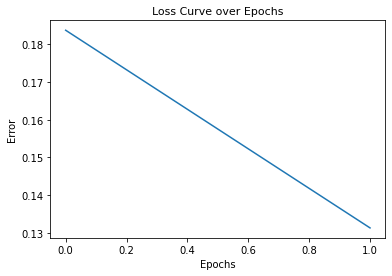

In [0]:
# Loss Curve (Training) - RESNET18:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

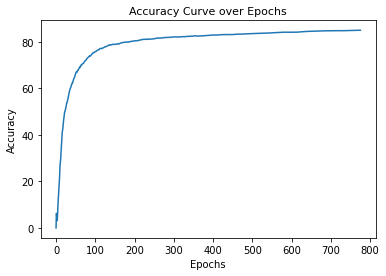

In [0]:
# Accuracy Curve (Training) - RESNET18:

plt.plot(accuracies)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### RESNET18 - Validating 

In [0]:
confusion_matrix = torch.zeros(3, 3)          # 3 represents number of classes.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

correct = 0
total = 0

accuracies2 = []

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    resnet18.eval()

    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        ohelabels = nn.functional.one_hot(labels, num_classes = 3)
        #print("\nNormal Label: ", labels, "\nOne Hot Label: ", ohelabels)
        
        optimizer.zero_grad()

        outputs = resnet18(inputs)                        #----> forward pass
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, ohelabels.float())   #----> compute loss
        #loss.backward()                                #----> backward pass
        #optimizer.step()                               #----> weights update

        running_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies2.append(tempaccuracy)
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.item()))
        
        finalcm = multilabel_confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy())
        finalfs = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average = 'micro')
        
    errors.append(running_loss)

print('\nFinal Accuracy of the network on the Validation Images: %d %%' % (
    100 * correct / total))

# Confusion matrix
print('\nConfusion Matrix of the network on the test images: \n', finalcm)

# F1 Score
print('\nF1 Score of the network on the test images: \n', finalfs)  

print('\nFinished Validating!')

Validation Epoch: 0 [156/628 (98%)]	Loss: 0.142249: : 40it [00:14,  2.75it/s]
Validation Epoch: 1 [156/628 (98%)]	Loss: 0.150476: : 40it [00:14,  2.74it/s]
Validation Epoch: 2 [156/628 (98%)]	Loss: 0.044863: : 40it [00:14,  2.74it/s]
Validation Epoch: 3 [156/628 (98%)]	Loss: 0.395681: : 40it [00:14,  2.75it/s]
Validation Epoch: 4 [156/628 (98%)]	Loss: 0.274695: : 40it [00:14,  2.74it/s]
Validation Epoch: 5 [156/628 (98%)]	Loss: 0.015283: : 40it [00:14,  2.74it/s]
Validation Epoch: 6 [156/628 (98%)]	Loss: 0.158961: : 40it [00:14,  2.72it/s]
Validation Epoch: 7 [156/628 (98%)]	Loss: 0.238738: : 40it [00:14,  2.74it/s]
Validation Epoch: 8 [156/628 (98%)]	Loss: 0.071631: : 40it [00:14,  2.74it/s]
Validation Epoch: 9 [156/628 (98%)]	Loss: 0.046841: : 40it [00:14,  2.70it/s]


Final Accuracy of the network on the Validation Images: 91 %

Confusion Matrix of the network on the test images: 
 tensor([[ 236.,   34.,   10.],
        [  51., 3826.,  123.],
        [  93.,  195., 1712.]])

F1 Score of the network on the test images: 
 84.74

Finished Validating!


Text(0.5, 0, 'Epochs')

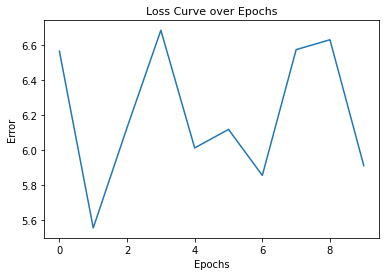

In [0]:
# Loss Curve (Validating) - RESNET18:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

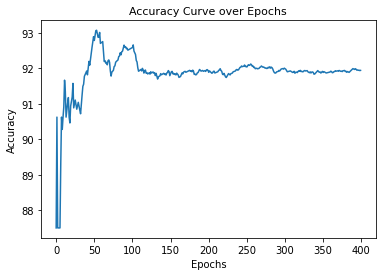

In [0]:
# Accuracy Curve (Validating) - RESNET18:

plt.plot(accuracies2)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### RESNET18 - Testing 


Initiating Testing!

Testing on a sample batch, the predicted labels are:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


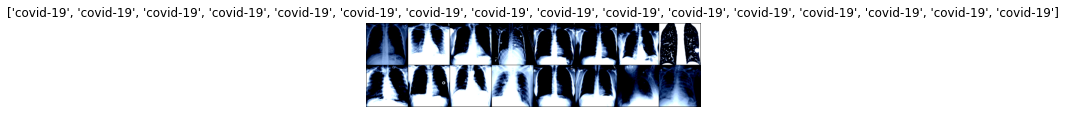

Predicted:  normal normal normal pneumonia normal normal normal covid-19 covid-19 normal normal covid-19 normal normal pneumonia pneumonia

Prediction 0 :  tensor([[False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False, False,  True]], device='cuda:0')

Prediction 1 :  tensor([[False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
   

In [0]:
confusion_matrix = torch.zeros(3, 3) # 2 represents number of classes.

print("\nInitiating Testing!")

print("\nTesting on a sample batch, the predicted labels are:\n")

dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

images = images.to(device)                    #--> convert test image to cuda (if available)
outputs = resnet18(images)                    #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

correct = 0
total = 0
counter = 0
threshold = 0.5

accuracies = []

import pandas as pd

px = pd.DataFrame()

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images = images.to(device)
        outputs = torch.sigmoid(resnet18(images))

        outputs = outputs > threshold
        predicted = outputs
        #_, predicted = torch.max(outputs.data, 1)
        print("\nPrediction", counter, ": ", predicted)
        counter = counter + 1
        pxx = predicted.cpu().numpy()
        px = px.append(pd.DataFrame(pxx))

        # You can uncomment the following commented lines of code to compute the Final Accuracy, Confusion Matrix and F1 Score for these predictions.

        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
        #tempaccuracy = 100 * (correct / total)
        #accuracies.append(tempaccuracy)
        
        #for i, j in zip(labels.view(-1), predicted.view(-1)):
        #        confusion_matrix[i, j] += 1

#print('\nFinal Accuracy of the network on the test images: %d %%' % (
#    100 * correct / total))

# Confusion matrix
#print('\nConfusion Matrix of the network on the test images: \n', confusion_matrix)

# F1 Score
#tp = int(confusion_matrix[0, 0])
#fn = int(confusion_matrix[0, 1])
#fp = int(confusion_matrix[1, 0])
#tn = int(confusion_matrix[1, 1])

#precision = tp / (tp + fp)
#recall = tp / (tp + fn)

#f1score = round(100 * (2 * (recall * precision) / (recall + precision)), 2)

#print('\nF1 Score of the network on the test images: \n', f1score)

In [0]:
# Saving Results of VGG16 to CSV (BCELogitsLoss):

px.rename(columns = {0:'Covid-19', 1:'Pneumonia', 2:'Normal'}, inplace = True)

px["Covid-19"] = px["Covid-19"].astype(int)
px["Pneumonia"] = px["Pneumonia"].astype(int)
px["Normal"] = px["Normal"].astype(int)

px.reset_index(inplace=True)
px.reset_index(inplace=True)

del px["index"]

px.rename(columns = {'level_0':'Image Name'}, inplace = True)

px.to_csv('/content/gdrive/My Drive/Results2.csv', index = False, header = False)

px

# Sanity Checks:

#print(px.iloc[[17]])

,Image Name,Covid-19,Pneumonia,Normal
0,0,0,1,0
1,1,0,1,0
2,2,0,0,1
3,3,0,1,0
4,4,0,1,0
...,...,...,...,...
623,623,0,1,0
624,624,0,0,1
625,625,0,1,0
626,626,0,0,1
